# Import

In [ ]:
import pandas as pd
import numpy as np
import os

from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind, mannwhitneyu

import time
from tqdm import tqdm

#plot
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE

from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.metrics import (classification_report, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix)

In [ ]:
start_time = time.time()

In [ ]:
# set the seed for reproducibility
SEED = 1

# set Pandas to show large numbers in float format
pd.options.display.float_format = '{:.2f}'.format

## Import data

In [ ]:
df_raw = pd.read_csv("credit_scoring.csv")
df_raw

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0       5008804           M            Y               Y             0   
1       5008805           M            Y               Y             0   
2       5008806           M            Y               Y             0   
3       5008808           F            N               Y             0   
4       5008809           F            N               Y             0   
...         ...         ...          ...             ...           ...   
338422  6392175           F            N               Y             0   
338423  6392177           F            N               Y             0   
338424  6392178           F            N               Y             0   
338425  6392179           F            N               Y             0   
338426  6392180           F            N               N             0   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0              427500.00               Working               Higher education   
1              427500.00               Working               Higher education   
2              112500.00               Working  Secondary / secondary special   
3              270000.00  Commercial associate  Secondary / secondary special   
4              270000.00  Commercial associate  Secondary / secondary special   
...                  ...                   ...                            ...   
338422         157500.00             Pensioner  Secondary / secondary special   
338423         157500.00             Pensioner  Secondary / secondary special   
338424         157500.00             Pensioner  Secondary / secondary special   
338425         157500.00             Pensioner  Secondary / secondary special   
338426          67500.00               Working                 Secondary / se   

          NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0             Civil marriage   Rented apartment   -12005.00       -4542.00   
1             Civil marriage   Rented apartment   -12005.00       -4542.00   
2                    Married  House / apartment   -21474.00       -1134.00   
3       Single / not married  House / apartment   -19110.00       -3051.00   
4       Single / not married  House / apartment   -19110.00       -3051.00   
...                      ...                ...         ...            ...   
338422               Married  House / apartment   -23661.00      365243.00   
338423               Married  House / apartment   -23661.00      365243.00   
338424               Married  House / apartment   -23661.00      365243.00   
338425               Married  House / apartment   -23661.00      365243.00   
338426                   NaN                NaN         NaN            NaN   

        FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0             1.00             1.00        0.00        0.00             NaN   
1             1.00             1.00        0.00        0.00             NaN   
2             1.00             0.00        0.00        0.00  Security staff   
3             1.00             0.00        1.00        1.00     Sales staff   
4             1.00             0.00        1.00        1.00     Sales staff   
...            ...              ...         ...         ...             ...   
338422        1.00             0.00        0.00        0.00             NaN   
338423        1.00             0.00        0.00        0.00             NaN   
338424        1.00             0.00        0.00        0.00             NaN   
338425        1.00             0.00        0.00        0.00             NaN   
338426         NaN              NaN         NaN         NaN             NaN   

        CNT_FAM_MEMBERS  TARGET  
0                  2.00       0  
1                  2.00       0  
2                  2.00       0  
3                  1.00       1  
4                  1.00       1  
...                 ...     ...  
338422             2.00    

### Summary of the types of variables

- **'ID'** : categorical
- **'CODE_GENDER'** : nominal categorical (binary)
- **'FLAG_OWN_CAR'** : nominal categorical (binary)
- **'FLAG_OWN_REALTY'** : nominal categorical (binary)
- **'CNT_CHILDREN'** : discrete quantitative
- **'AMT_INCOME_TOTAL'** : continuous quantitative
- **'NAME_INCOME_TYPE'** : nominal categorical
- **'NAME_EDUCATION_TYPE'** : ordinal categorical
- **'NAME_FAMILY_STATUS'** : nominal categorical  
- **'NAME_HOUSING_TYPE'** : nominal categorical  
- **'DAYS_BIRTH'** : discrete quantitative
- **'DAYS_EMPLOYED'** : discrete quantitative
- **'FLAG_MOBIL'** : nominal categorical (binary)
- **'FLAG_WORK_PHONE'** : nominal categorical (binary)
- **'FLAG_PHONE'** : nominal categorical (binary)
- **'FLAG_EMAIL'** : nominal categorical (binary)
- **'OCCUPATION_TYPE'** : nominal categorical
- **'CNT_FAM_MEMBERS'** : discrete quantitative
- **'TARGET'** : nominal categorical (binary)

### FUNCTIONS (plots)

In [ ]:
# Function to display barplot or countplot and pie chart
def plots_binary(df, feature):
    """
    Display a countplot and a pie chart for a binary feature in a DataFrame.

    This function generates two subplots side by side:
    1. A countplot to show the count of each category in the feature.
    2. A pie chart to show the proportion of each category in the feature.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the feature to be plotted.
    feature (str): The name of the binary feature to be plotted.

    Returns:
    None
    """
    # Calculate the frequencies of the categories
    category_counts = df[feature].value_counts()
    categories = category_counts.index
    counts = category_counts.values

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Countplot
    sns.barplot(x=categories, y=counts, ax=ax1, palette="Set2", hue=categories)

    ax1.set_title(f"Countplot of {feature}")
    ax1.set_xlabel(feature)
    ax1.set_ylabel("Count")

    # Handle the legend in the countplot or barplot
    handles, labels = ax1.get_legend_handles_labels()
    if labels:
        ax1.legend(title=None)  # Remove the title of the legend if present

    # Pie chart
    ax2.pie(counts, labels=categories, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
    ax2.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax2.set_title(f"Pie chart of {feature}")

    # Show the plots
    plt.tight_layout()
    plt.show()

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def countplot_categorical(df, feature):
    """
    Create a countplot for a categorical feature (nominal or ordinal) in a DataFrame, with sorted categories in descending order
    and improved label handling.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the feature to be plotted.
    feature (str): The name of the categorical feature to be plotted.

    Returns:
    None
    """
    # Calculate the frequency of each category and sort them in descending order
    category_counts = df[feature].value_counts().sort_values(ascending=False)

    # Create the countplot
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    sns.countplot(x=feature, data=df, order=category_counts.index, palette="Set2", hue=feature, dodge=False, legend=False)  # Generate the countplot with Seaborn

    # Set the title and labels
    plt.title(f'Countplot of {feature}')  # Set the title of the plot
    plt.xlabel(feature)  # Set the label for the x-axis
    plt.ylabel('Count')  # Set the label for the y-axis

    # Rotate x-axis labels if needed
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

    # Display the plot
    plt.tight_layout()  # Adjust layout to fit everything
    plt.show()  # Show the plot

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def barplot_discrete(df, feature):
    """
    Create a barplot for discrete quantitative data in a DataFrame, with labels managed and data sorted in descending order.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the feature to be plotted.
    feature (str): The name of the column in df containing the discrete quantitative feature.

    Returns:
    None
    """
    # Calculate the frequency of each category and sort them in descending order
    category_counts = df[feature].value_counts().sort_values(ascending=False)

    # Create the barplot
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    sns.barplot(x=category_counts.index, y=category_counts.values, hue=category_counts.index, dodge=False, palette="Set2", legend=False)  # Generate the barplot with Seaborn

    # Set the title and labels
    plt.title(f'Barplot of {feature}')  # Set the title of the plot
    plt.xlabel(feature)  # Set the label for the x-axis
    plt.ylabel('Count')  # Set the label for the y-axis

    # Rotate x-axis labels if needed
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

    # Display the plot
    plt.tight_layout()
    plt.show()

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def plot_continuous(df, feature, plot_type=None):
    """
    Create various types of plots for a continuous feature in a DataFrame based on the specified plot_type.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the feature to be plotted.
    feature (str): The name of the column in df containing the continuous feature.
    plot_type (str, optional): Type of plot to display. Accepted values: "hist", "box", "density". Default is None.

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))  # Set the size of the figure

    if plot_type == "hist":
        # Histogram with Line Plot
        sns.histplot(df[feature], kde=True, color='skyblue', bins=20)
        plt.xlabel(feature)
        plt.title(f'Histogram of {feature}')

    elif plot_type == "box":
        # Box Plot
        sns.boxplot(y=df[feature], color='lightgreen')
        plt.ylabel(feature)
        plt.title(f'Box Plot of {feature}')

    elif plot_type == "density":
        # Density Plot (Kernel Density Estimate)
        sns.kdeplot(df[feature], color='purple', fill=True)
        plt.xlabel(feature)
        plt.title(f'Density Plot of {feature}')

    else:
        # Default: Histogram
        sns.histplot(df[feature], kde=True, color='skyblue', bins=20)
        plt.xlabel(feature)
        plt.title(f'Histogram of {feature}')

        if plot_type is not None:
            print(f"Unsupported plot_type '{plot_type}'. Supported types are: 'hist', 'box', 'density'.")

    plt.ylabel('Density' if plot_type == 'density' else 'Frequency')
    plt.tight_layout()
    plt.show()

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def compare_feature_by_nan(df, feature, nan_feature):
    """
    Compares the distribution of a feature based on missing values in a specific column.

    Args:
    df (DataFrame): The DataFrame containing the data.
    feature (str): The name of the feature to compare.
    nan_feature (str): The name of the column with NaN values to use for comparison.

    Returns:
    None
    """
    # Check if the specified columns exist in the DataFrame
    if feature not in df.columns or nan_feature not in df.columns:
        raise ValueError("Make sure both columns exist in the DataFrame.")

    # Create a figure with a size of 10x6 inches
    plt.figure(figsize=(10, 6))

    # Subplot 1: Distribution plot of the feature
    plt.subplot(1, 1, 1)
    sns.histplot(df[df[nan_feature].notna()][feature], color='skyblue', label='Not NaN')
    sns.histplot(df[df[nan_feature].isna()][feature], color='red', label='NaN')

    plt.legend()
    plt.title(f'Distribution of {feature} by {nan_feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

    # Rotate X-axis labels by 45 degrees for better readability
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def plot_correlation_heatmap(numpy_array):
    """
    Plots a heatmap of the correlation matrix for a given numpy array and displays the correlation values separately.

    Parameters:
    numpy_array (np.ndarray): The input data array. Rows are observations and columns are features.
    """
    # Calculate the correlation matrix
    corr_matrix = np.corrcoef(numpy_array, rowvar=False)

    # Create the heatmap
    plt.figure(figsize=(12, 10))  # Set figure size for better readability

    # Plot the heatmap without annotations
    sns.heatmap(
        corr_matrix,
        cmap='coolwarm',
        fmt='.2f',
        linewidths=0.5,
        linecolor='black',
        cbar_kws={'shrink': 0.8}  # Shrink the color bar
    )

    # Improve the appearance
    plt.title('Correlation Matrix Heatmap', fontsize=16)
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.xticks(rotation=0, ha='center')
    plt.yticks(rotation=0)

    # Adjust layout to fit labels
    plt.tight_layout()
    plt.show()

    # Print the correlation matrix
    print("Correlation Matrix:\n")
    print(corr_matrix)

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def bivariate_cat_cat(df, col1, col2):
    """
    Analyzes the relationship between two categorical variables in a DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data.
    - col1: Name of the first categorical variable.
    - col2: Name of the second categorical variable.

    Returns:
    - Contingency table.
    - Heatmap of the contingency table.
    - Chi-square test results including chi-square statistic, p-value, degrees of freedom, and expected frequencies.
    """

    # Create the contingency table
    contingency_table = pd.crosstab(df[col1], df[col2])
    print("Contingency Table:")
    print(contingency_table)

    # Visualization with heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(contingency_table, annot=True, cmap='Blues', fmt='d')
    plt.title(f'Heatmap of Contingency Table between {col1} and {col2}')
    plt.show()

    # Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"\nChi-Square Statistic: {chi2}")
    print(f"P-Value: {p}")
    print(f"Degrees of Freedom: {dof}")
    print(f"Expected Frequencies: \n{expected}")

    return contingency_table, chi2, p, dof, expected

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def bivariate_analysis_num_cat(df, num_col, cat_col):
    """
    Performs a bivariate analysis between a quantitative discrete variable and a binary categorical variable.

    Parameters:
    - df: pandas DataFrame containing the data.
    - num_col: Name of the quantitative discrete variable.
    - cat_col: Name of the binary categorical variable.

    Returns:
    - Descriptive statistics for the quantitative variable grouped by the binary categorical variable.
    - Boxplot of the quantitative variable by the binary categorical variable.
    - Violin plot of the quantitative variable by the binary categorical variable.
    - T-test results (if applicable) including t-statistic and p-value.
    - Mann-Whitney U test results (if applicable) including U-statistic and p-value.
    """

    # Descriptive statistics
    description = df.groupby(cat_col)[num_col].describe()
    print("Descriptive Statistics by Group:")
    print(description)

    # Create a figure with two subplots side by side
    plt.figure(figsize=(14, 6))

    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=cat_col, y=num_col, data=df)
    plt.title(f'Boxplot of {num_col} by {cat_col}')

    # Violin plot
    plt.subplot(1, 2, 2)
    sns.violinplot(x=cat_col, y=num_col, data=df)
    plt.title(f'Violin Plot of {num_col} by {cat_col}')

    plt.tight_layout()
    plt.show()

    # Perform T-test
    group1 = df[df[cat_col] == df[cat_col].unique()[0]][num_col]
    group2 = df[df[cat_col] == df[cat_col].unique()[1]][num_col]

    t_stat, p_value_t = ttest_ind(group1, group2, equal_var=False)
    print(f"T-Test Results:")
    print(f"T-Statistic: {t_stat}")
    print(f"P-Value: {p_value_t}")

    # Perform Mann-Whitney U test
    u_stat, p_value_mw = mannwhitneyu(group1, group2, alternative='two-sided')
    print(f"\nMann-Whitney U Test Results:")
    print(f"U-Statistic: {u_stat}")
    print(f"P-Value: {p_value_mw}")

    return description, t_stat, p_value_t, u_stat, p_value_mw

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def plot_results(results_df, exclude_metrics=None):
    """
    Plot performance metrics for different models.

    Parameters:
    results_df: DataFrame containing the performance metrics of the models.
    exclude_metrics: List of metrics to exclude from the plot.
    """
    if exclude_metrics is None:
        exclude_metrics = []

    # Converti tutte le colonne ad eccezione di 'Model' in float
    for col in results_df.columns:
        if col != 'Model':
            results_df[col] = pd.to_numeric(results_df[col], errors='coerce')

    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")

    # Melt the DataFrame for easier plotting with seaborn
    df_melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

    # Exclude the specified metrics from the plot
    df_melted = df_melted[~df_melted['Metric'].isin(exclude_metrics)]

    # Create the bar plot
    plt.figure(figsize=(14, 10))
    sns.barplot(data=df_melted, x='Value', y='Model', hue='Metric', orient='h')
    plt.xlim(0, 1)
    plt.xticks(ticks=[i/10 for i in range(11)], labels=[f'{i/10:.1f}' for i in range(11)])
    plt.title("Model Performance Metrics")
    plt.xlabel("Value")
    plt.ylabel("Model")
    plt.legend(title="Metric", loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def select_and_plot_features_by_var(X_train_var_df, X_train_var, X_test_var, threshold=0.01):
    """
    Seleziona le feature basate sulla varianza, filtra i dati di addestramento e di test,
    e visualizza un grafico a barre orizzontale della varianza delle feature rimanenti.

    Parameters:
    - X_train_var_df: DataFrame contenente i dati di addestramento
    - X_train_var: ndarray contenente i dati di addestramento (senza nomi delle colonne)
    - X_test_var: ndarray contenente i dati di test (senza nomi delle colonne)
    - threshold: soglia di varianza per la selezione delle feature (default: 0.01)

    Returns:
    - X_train_filtered: ndarray contenente i dati di addestramento filtrati
    - X_test_filtered: ndarray contenente i dati di test filtrati
    """
    # Applica VarianceThreshold sui dati di addestramento (DataFrame)
    selector = VarianceThreshold(threshold=threshold)
    X_train_reduced = selector.fit_transform(X_train_var_df)

    # Ottieni i nomi delle feature selezionate
    selected_features = X_train_var_df.columns[selector.get_support()]

    # Trova gli indici delle colonne selezionate nel DataFrame originale
    selected_indices = [X_train_var_df.columns.get_loc(col) for col in selected_features]

    # Filtra X_train_var e X_test_var usando gli indici delle colonne selezionate
    X_train_var_filtered = X_train_var[:, selected_indices]
    X_test_var_filtered = X_test_var[:, selected_indices]

    # Calcola la varianza di ciascuna feature nel DataFrame originale
    feature_variances = X_train_var_df.var()

    # Filtra le varianze per le feature selezionate
    filtered_variances = feature_variances[selected_features]

    # Ordina le feature in ordine crescente di varianza
    sorted_variances = filtered_variances.sort_values(ascending=True)

    # Crea il grafico a barre orizzontale
    fig, ax = plt.subplots(figsize=(14, 8))  # Aumenta la dimensione della figura

    y = np.arange(len(sorted_variances))  # Indici delle feature
    x = sorted_variances.values  # Varianza delle feature ordinate

    ax.barh(y, x, height=0.5)
    ax.set_ylabel('Features')
    ax.set_xlabel('Variance')
    ax.set_xlim(0, max(x) * 1.1)  # Imposta il limite superiore leggermente sopra la varianza massima
    ax.set_yticks(y)  # Imposta i tick sull'asse y
    ax.set_yticklabels(sorted_variances.index, fontsize=8)  # Imposta le etichette dei tick sull'asse y

    # Aggiungi le etichette di varianza accanto a ciascuna barra
    for index, value in enumerate(x):
        ax.text(x=value + (max(x) * 0.01), y=index, s=str(round(value, 3)), va='center', fontsize=8)

    # Regola manualmente i margini per accogliere le etichette
    plt.subplots_adjust(left=0.3, right=0.95)
    plt.show()

    # Stampa le feature selezionate e il numero di feature
    print("Feature selezionate:", selected_features.tolist())
    print()
    print("Numero di feature selezionate:", len(selected_features))
    print()
    print("Dimensione originale di X_train_var:", X_train_var.shape)
    print("Dimensione filtrata di X_train_var_filtered:", X_train_var_filtered.shape)
    print("Dimensione originale di X_test_var:", X_test_var.shape)
    print("Dimensione filtrata di X_test_var_filtered:", X_test_var_filtered.shape)

    return X_train_var_filtered, X_test_var_filtered

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#

### FUNCTIONS

In [ ]:
# Function to determine binary variables
def binary_variables(df):
    """
    Identify binary variables in a DataFrame.

    This function checks each column in the DataFrame to determine if it is a binary variable.

    Parameters:
    df (pandas.DataFrame): The input DataFrame to be analyzed.

    Returns:
    list: A list of column names that are identified as binary variables.
    """

    binary_variab = []  # List to store the names of binary variables
    column_names = df.columns  # Get all column names from the DataFrame

    for i in column_names:
        # Determine if the column contains binary values
        constant = (set(df[i].dropna().unique()) == {0, 1} or set(df[i].dropna().unique()) == {0} or set(df[i].dropna().unique()) == {1})
        # Determine if the column has exactly two unique values
        constant_object = (len(df[i].dropna().unique()) == 2)

        # Check the data type and if it meets binary criteria for float64 or int64 types
        if df[i].dtype == 'float64' and constant:
            binary_variab.append(i)
        elif df[i].dtype == 'int64' and constant:
            binary_variab.append(i)
        # Check if the column is of type object and has exactly two unique values
        elif df[i].dtype == 'object' and constant_object:
            binary_variab.append(i)
        else:
            continue  # Skip the column if it doesn't meet the criteria

    return binary_variab  # Return the list of binary variable names

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def categorical_summary(df, feature):
    """
    Calculate and display descriptive statistics for a categorical feature in a dataframe.

    Parameters:
    df (pd.DataFrame): The dataframe containing the feature.
    feature (str): The name of the categorical feature to summarize.

    Returns:
    tuple: A tuple containing:
        - summary (pd.DataFrame): A dataframe with the frequency and percentage of each category.
        - additional_info (dict): A dictionary with additional information including the unique values count and mode.
    """
    # Checks if the feature exists in the dataframe
    assert feature in df.columns, f"Feature '{feature}' not found in dataframe columns."

    # Calculate absolute frequencies
    freq_abs = df[feature].value_counts(dropna=False)

    # Calculate relative frequencies
    freq_rel = df[feature].value_counts(normalize=True, dropna=False) * 100

    # Calculate the count of unique values
    unique_count = df[feature].nunique()

    # Calculate the mode
    mode = df[feature].mode().iloc[0]

    # Create a summary dataframe
    summary = pd.DataFrame({
        'Category': freq_abs.index,
        'Frequency': freq_abs.values,
        'Percentage': freq_rel.values
    })

    summary['Percentage'] = summary['Percentage'].map('{:,.2f}%'.format)

    # Additional information
    additional_info = {
        'Unique Values Count': unique_count,
        'Mode': mode
    }

    # Format and print the summary dataframe
    print("\nSummary Statistics for feature '{}':\n".format(feature))
    print(summary.to_string(index=False))

    # Print additional information
    print("\nAdditional Information:")
    for key, value in additional_info.items():
        print(f"{key}: {value}")

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def quantitative_summary(df, feature):
    """
    Calculate and display descriptive statistics for a quantitative feature in a dataframe.

    Parameters:
    df (pd.DataFrame): The dataframe containing the feature.
    feature (str): The name of the quantitative feature to summarize.

    Returns:
    dict: A dictionary containing descriptive statistics for the feature.
    """
    assert feature in df.columns, f"Feature '{feature}' not found in dataframe columns."

    # Calculate descriptive statistics
    mean = df[feature].mean()
    median = df[feature].median()
    mode = df[feature].mode().iloc[0] if not df[feature].mode().empty else None
    variance = df[feature].var()
    std_dev = df[feature].std()
    data_range = df[feature].max() - df[feature].min()
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    skewness = df[feature].skew()
    kurtosis = df[feature].kurtosis()
    minimum = df[feature].min()
    maximum = df[feature].max()

    summary = {
        'Min': minimum,
        'Q1 (25th)': q1,
        'Q2 Median': median,
        'Q3 (75th)': q3,
        'Max': maximum,
        'IQR': iqr,
        'Mean': mean,
        'Mode': mode,
        'Variance': variance,
        'Standard Deviation': std_dev,
        'Range': data_range,
        'Skewness': skewness,
        'Kurtosis': kurtosis
    }

    # Format and print the summary
    print("\nDescriptive Statistics for feature '{}':\n".format(feature))
    for key, value in summary.items():
        print(f"{key}: {value:.2f}" if isinstance(value, (int, float)) else f"{key}: {value}")

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def descriptive_statistics(df, feature, variables_type='none'):
    """
    Print descriptive statistics based on the type of variable.

    Parameters:
    df (pd.DataFrame): The dataframe containing the feature.
    feature (str): The name of the feature for which statistics are calculated.
    variables_type (str, optional): Type of the variable. Accepted values: 'binary', 'nominal', 'ordinal', 'discrete', 'continuous'. Default is 'none'.

    Returns:
    None
    """
    assert feature in df.columns, f"Feature '{feature}' not found in dataframe columns."

    if variables_type.lower() in ['binary', 'nominal', 'ordinal']:
        # Call categorical_summary for categorical variables
        categorical_summary(df, feature)
    elif variables_type.lower() in ['discrete', 'continuous']:
        # Call quantitative_summary for numerical variables
        quantitative_summary(df, feature)
    else:
        raise ValueError(f"Unsupported variables_type '{variables_type}'. Supported types are: 'binary', 'nominal', 'ordinal', 'discrete', 'continuous'.")

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluate a model with multiple metrics including accuracy, F1 score, ROC-AUC, precision, recall, TP, FP, TN, FN.

    Parameters:
    model: The classification model to evaluate.
    X_train: Training data features.
    y_train: Training data labels.
    X_test: Test data features.
    y_test: Test data labels.

    Returns:
    metrics: Dictionary containing various evaluation metrics.
    """
    start_time = time.time()  # Start timer
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Check if the model has predict_proba method
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
        # Normalize decision_function to be between 0 and 1
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
    else:
        y_proba = np.zeros_like(y_test)  # Placeholder for models not supporting probabilities
        print(f"Model {model.__class__.__name__} does not support probability estimates for ROC-AUC.")

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Calculate ROC-AUC if probabilities are available
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba.size > 0 else 'Not Available'

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    end_time = time.time()  # End timer
    duration = end_time - start_time

    metrics = {
        "accuracy": round(accuracy, 5),
        "f1": round(f1, 5),
        "precision": round(precision, 5),
        "recall": round(recall, 5),
        "roc_auc": round(roc_auc, 5) if isinstance(roc_auc, float) else 'Not Available',
        "tp": tp,
        "fp": fp,
        "tn": tn,
        "fn": fn,
        "duration": round(duration, 2)
    }

    return metrics

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def evaluate_models(models, X_train, y_train, X_test, y_test, results=None):
    """
    Evaluate multiple models and update a DataFrame with the results.

    Parameters:
    models: Dictionary of model names and their instances.
    X_train: Training data features.
    y_train: Training data labels.
    X_test: Test data features.
    y_test: Test data labels.
    results: Optional DataFrame to append results to. If None, a new DataFrame is created.

    Returns:
    results: Updated DataFrame with model evaluation results.
    """
    # Create a new DataFrame if results is not provided
    if results is None:
        results = pd.DataFrame(columns=[
            "Model", "Accuracy", "F1 Score", "Precision", "Recall",
            "ROC-AUC", "TP", "FP", "TN", "FN", "Duration (seconds)", "Parameters"
        ])

    # List to store the results
    results_list = []

    # Evaluate each model and update results DataFrame
    for name, model in tqdm(models.items(), desc="Evaluating Models"):
        metrics = evaluate_model(model, X_train, y_train, X_test, y_test)

        # Estrai i parametri se disponibile
        if hasattr(model, 'best_params_'):
            params = model.best_params_  # Parametri migliori se disponibili (es. dopo RandomizedSearchCV)
        else:
            params = model.get_params() if hasattr(model, 'get_params') else 'Not Available'  # Parametri del modello

        print(f"{name} Accuracy: {metrics['accuracy']:.5f}")
        print(f"{name} F1 Score: {metrics['f1']:.5f}")
        print(f"{name} Precision: {metrics['precision']:.5f}")
        print(f"{name} Recall: {metrics['recall']:.5f}")
        roc_auc_display = metrics['roc_auc'] if isinstance(metrics['roc_auc'], float) else 'Not Available'
        print(f"{name} ROC-AUC: {roc_auc_display:.5f}" if isinstance(roc_auc_display, float) else f"{name} ROC-AUC: Not Available")
        print()

        # Append the results to the list
        results_list.append({
            "Model": name,
            "Accuracy": metrics['accuracy'],
            "F1 Score": metrics['f1'],
            "Precision": metrics['precision'],
            "Recall": metrics['recall'],
            "ROC-AUC": metrics['roc_auc'],
            "TP": metrics['tp'],
            "FP": metrics['fp'],
            "TN": metrics['tn'],
            "FN": metrics['fn'],
            "Duration (seconds)": metrics['duration'],
            "Parameters": params
        })

    # Concatenate the new results with the existing DataFrame
    results = pd.concat([results, pd.DataFrame(results_list)], ignore_index=True)

    # Format float columns to 5 decimal places
    float_cols = ["Accuracy", "F1 Score", "Precision", "Recall", "ROC-AUC"]
    results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)

    return results

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def get_high_correlation_pairs(df, threshold=0.7):
    """
    Restituisce le coppie di variabili con un valore di correlazione maggiore della soglia specificata.

    Parametri:
    df (pandas.DataFrame): Il dataframe di input con le variabili.
    threshold (float): La soglia di correlazione per filtrare le coppie di variabili (default 0.7).

    Ritorna:
    pandas.DataFrame: Un dataframe con le coppie di variabili e i loro valori di correlazione.
    """
    # Calcola la matrice di correlazione
    correlation_matrix = df.corr()

    # Trasforma la matrice di correlazione in formato lungo
    correlation_pairs = correlation_matrix.unstack().reset_index()
    correlation_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']

    # Rimuove le duplicati e auto-correlazioni
    correlation_pairs = correlation_pairs[correlation_pairs['Feature_1'] != correlation_pairs['Feature_2']]
    correlation_pairs.drop_duplicates(subset=['Correlation'], inplace=True)

    # Filtra le coppie di variabili in base al valore di correlazione
    filtered_pairs = correlation_pairs[np.abs(correlation_pairs['Correlation']) > threshold]

    # Ordina le coppie di variabili per valore di correlazione
    filtered_pairs = filtered_pairs.sort_values(by='Correlation', ascending=False)

    return filtered_pairs

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def calculate_vif(df):
    """
    Calcola il Variance Inflation Factor (VIF) per ciascuna colonna di un DataFrame.

    Parametri:
    df (pd.DataFrame): Il DataFrame contenente le variabili indipendenti.

    Ritorna:
    pd.DataFrame: Un DataFrame con il VIF per ciascuna colonna.
    """
    # Aggiungi una costante al DataFrame per l'intercetta
    df_with_constant = sm.add_constant(df)

    # Calcola il VIF per ciascuna colonna
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_with_constant.columns
    vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i) for i in range(df_with_constant.shape[1])]

    # Rimuovi la riga della costante (intercetta)
    vif_data = vif_data[vif_data["Feature"] != "const"]

    return vif_data

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def calculate_feature_importance(X, y, n_estimators=100, random_state=None):
    """
    Calculates and visualizes feature importance using ExtraTreesClassifier.

    Parameters:
    X (pd.DataFrame): DataFrame containing the features.
    y (pd.Series or array): Target variable.
    n_estimators (int): Number of trees in the forest. Default is 100.
    random_state (int, optional): Seed for reproducibility. Default is None.

    Returns:
    pd.DataFrame: DataFrame containing the features and their importance.
    """
    # Create and train the ExtraTreesClassifier
    clf = ExtraTreesClassifier(n_estimators=n_estimators, random_state=random_state)
    clf.fit(X, y)

    # Get the feature importances
    importances = clf.feature_importances_

    # Create a DataFrame for feature importances
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

    # Sort the features by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    # Visualize the feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importance - ExtraTreesClassifier')
    plt.gca().invert_yaxis()
    plt.show()

    # Format the 'Importance' column to 5 decimal places
    importance_df['Importance'] = importance_df['Importance'].apply(lambda x: f"{x:.5f}")

    # Print the feature importances in tabular format
    print("Feature Importances (Tabular Format):")
    print(importance_df)

    return importance_df

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def check_column_alignment(df, np_array, column_names=None):
    """
    Verifica se l'ordine delle colonne tra un DataFrame e un array NumPy è lo stesso.

    Parametri:
    df (pandas.DataFrame): Il DataFrame con le colonne da confrontare.
    np_array (numpy.ndarray): L'array NumPy con le colonne da confrontare.
    column_names (list, opzionale): Lista dei nomi delle colonne per l'array NumPy.
                                     Se None, verrà generata una lista di nomi delle colonne
                                     dal DataFrame in base alla dimensione dell'array.

    Ritorna:
    bool: True se le colonne sono allineate, False altrimenti.
    """
    # Ottieni i nomi delle colonne dal DataFrame
    df_columns = df.columns.tolist()

    # Verifica se la lista dei nomi delle colonne è fornita
    if column_names is None:
        # Se column_names non è fornito, usa i nomi delle colonne dal DataFrame
        # per la verifica
        column_names = df_columns[:np_array.shape[1]]

    # Controlla se l'ordine delle colonne è lo stesso
    alignment_check = (df_columns[:np_array.shape[1]] == column_names)

    return alignment_check

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def remove_feature(column_to_remove, X_train_df, X_test_df, X_train_array, X_test_array):
    """
    Rimuove una feature specificata dai DataFrame e dagli array NumPy.

    Parametri:
    column_to_remove (str): Il nome della colonna da rimuovere.
    X_train_df (pandas.DataFrame): DataFrame per i dati di addestramento.
    X_test_df (pandas.DataFrame): DataFrame per i dati di test.
    X_train_array (numpy.ndarray): Array NumPy per i dati di addestramento.
    X_test_array (numpy.ndarray): Array NumPy per i dati di test.

    Ritorna:
    X_train_df_filtered (pandas.DataFrame): DataFrame di addestramento filtrato.
    X_test_df_filtered (pandas.DataFrame): DataFrame di test filtrato.
    X_train_array_filtered (numpy.ndarray): Array NumPy di addestramento filtrato.
    X_test_array_filtered (numpy.ndarray): Array NumPy di test filtrato.
    """

    # Verifica se la colonna esiste nei DataFrame
    if column_to_remove not in X_train_df.columns:
        raise ValueError(f"La colonna '{column_to_remove}' non esiste in X_train_df.")
    if column_to_remove not in X_test_df.columns:
        raise ValueError(f"La colonna '{column_to_remove}' non esiste in X_test_df.")

    # Trova l'indice della colonna da rimuovere nei DataFrame
    column_index_to_remove_train = X_train_df.columns.get_loc(column_to_remove)
    column_index_to_remove_test = X_test_df.columns.get_loc(column_to_remove)

    # Rimuovi la colonna dai DataFrame
    X_train_df_filtered = X_train_df.drop(columns=column_to_remove)
    X_test_df_filtered = X_test_df.drop(columns=column_to_remove)

    # Rimuovi la colonna dagli array NumPy
    X_train_array_filtered = np.delete(X_train_array, column_index_to_remove_train, axis=1)
    X_test_array_filtered = np.delete(X_test_array, column_index_to_remove_test, axis=1)

    # Stampa le forme degli array e dei DataFrame
    print(f"Forma originale di X_train_array: {X_train_array.shape}")
    print(f"Forma originale di X_test_array: {X_test_array.shape}")
    print(f"Forma dopo la rimozione di X_train_array: {X_train_array_filtered.shape}")
    print(f"Forma dopo la rimozione di X_test_array: {X_test_array_filtered.shape}")

    print(f"Forma originale di X_train_df: {X_train_df.shape}")
    print(f"Forma originale di X_test_df: {X_test_df.shape}")
    print(f"Forma dopo la rimozione di X_train_df: {X_train_df_filtered.shape}")
    print(f"Forma dopo la rimozione di X_test_df: {X_test_df_filtered.shape}")

    return X_train_df_filtered, X_test_df_filtered, X_train_array_filtered, X_test_array_filtered

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#
def save_dataframe_to_csv(df, filename):
    """
    Save a DataFrame to a CSV file. Append rows if the file exists, otherwise create a new file.

    Parameters:
    df (DataFrame): The DataFrame to save.
    filename (str): The name of the CSV file.
    """
    file_exists = os.path.isfile(filename)

    with open(filename, 'a') as f:
        if not file_exists:
            # File does not exist, create it with header
            df.to_csv(f, index=False)
        else:
            # File exists, append data without writing the header
            df.to_csv(f, mode='a', header=False, index=False)

#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#---#

# Exploratory Data Analysis (EDA)

In [ ]:
df_raw.shape

(338427, 19)

**Dataframe** has 338.427 rows and 19 columns.

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338427 entries, 0 to 338426
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   338427 non-null  int64  
 1   CODE_GENDER          338427 non-null  object 
 2   FLAG_OWN_CAR         338427 non-null  object 
 3   FLAG_OWN_REALTY      338427 non-null  object 
 4   CNT_CHILDREN         338427 non-null  int64  
 5   AMT_INCOME_TOTAL     338427 non-null  float64
 6   NAME_INCOME_TYPE     338427 non-null  object 
 7   NAME_EDUCATION_TYPE  338427 non-null  object 
 8   NAME_FAMILY_STATUS   338426 non-null  object 
 9   NAME_HOUSING_TYPE    338426 non-null  object 
 10  DAYS_BIRTH           338426 non-null  float64
 11  DAYS_EMPLOYED        338426 non-null  float64
 12  FLAG_MOBIL           338426 non-null  float64
 13  FLAG_WORK_PHONE      338426 non-null  float64
 14  FLAG_PHONE           338426 non-null  float64
 15  FLAG_EMAIL       

In [ ]:
df_raw.duplicated("ID").sum()

np.int64(0)

In [ ]:
# Check any na values
df_raw.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          1
NAME_HOUSING_TYPE           1
DAYS_BIRTH                  1
DAYS_EMPLOYED               1
FLAG_MOBIL                  1
FLAG_WORK_PHONE             1
FLAG_PHONE                  1
FLAG_EMAIL                  1
OCCUPATION_TYPE        103342
CNT_FAM_MEMBERS             1
TARGET                      0
dtype: int64

There are many "na" values in OCCUPATION_TYPE, let's check later.

In [ ]:
# Count number of distinct elements in specified axis.
df_raw.nunique()

ID                     338427
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          749
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         6
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16077
DAYS_EMPLOYED            8826
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
TARGET                      2
dtype: int64

In [ ]:
# Check for duplicate lines.
print(df_raw.duplicated().value_counts())

False    338427
Name: count, dtype: int64


## Categorical variables

### Binary variables

In [ ]:
binary_variables(df_raw)

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'TARGET']

Now we begin to analyze the binary categorical variables.


#### CODE_GENDER

In [ ]:
plots_binary(df_raw, "CODE_GENDER")
descriptive_statistics(df_raw, "CODE_GENDER", variables_type="binary")


Summary Statistics for feature 'CODE_GENDER':

Category  Frequency Percentage
       F     227916     67.35%
       M     110511     32.65%

Additional Information:
Unique Values Count: 2
Mode: F


- The analysis of 'CODE_GENDER' reveals that females ('F') constitute 67.35% of the dataset, while males ('M') account for 32.65%.

- With only two unique values, 'F' emerges as the most frequent mode, highlighting a gender imbalance in the dataset.

#### FLAG_OWN_CAR

In [ ]:
plots_binary(df_raw, "FLAG_OWN_CAR")
descriptive_statistics(df_raw, "FLAG_OWN_CAR", variables_type="binary")


Summary Statistics for feature 'FLAG_OWN_CAR':

Category  Frequency Percentage
       N     213196     63.00%
       Y     125231     37.00%

Additional Information:
Unique Values Count: 2
Mode: N


- The 'FLAG_OWN_CAR' feature indicates ownership of a car:
  - 63.00% of individuals do not own a car ('N')
  - 37.00% own a car ('Y')
- There are only two unique values, with 'N' being the mode.

#### FLAG_OWN_REALTY

In [ ]:
plots_binary(df_raw, "FLAG_OWN_REALTY")
descriptive_statistics(df_raw, "FLAG_OWN_REALTY", variables_type="binary")


Summary Statistics for feature 'FLAG_OWN_REALTY':

Category  Frequency Percentage
       Y     231307     68.35%
       N     107120     31.65%

Additional Information:
Unique Values Count: 2
Mode: Y


- 'FLAG_OWN_REALTY' indicates homeownership:
    - 68.35% of individuals own real estate ('Y')
    - 31.65% do not own real estate ('N')
- There are only two unique values, with 'Y' being the mode.

#### FLAG_MOBIL

In [ ]:
plots_binary(df_raw, "FLAG_MOBIL")
descriptive_statistics(df_raw, "FLAG_MOBIL", variables_type="binary")


Summary Statistics for feature 'FLAG_MOBIL':

 Category  Frequency Percentage
     1.00     338426    100.00%
      NaN          1      0.00%

Additional Information:
Unique Values Count: 1
Mode: 1.0


- 'FLAG_MOBIL' indicates the presence of a mobile phone number:
    - 100.00% of individuals have a mobile phone number
    - There is 1 NaN value
- These statistics confirm universal mobile phone number presence across the dataset, with negligible missing values.

In [ ]:
df_raw[df_raw["FLAG_MOBIL"].isna()]

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
338426  6392180           F            N               N             0   

        AMT_INCOME_TOTAL NAME_INCOME_TYPE NAME_EDUCATION_TYPE  \
338426          67500.00          Working      Secondary / se   

       NAME_FAMILY_STATUS NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
338426                NaN               NaN         NaN            NaN   

        FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
338426         NaN              NaN         NaN         NaN             NaN   

        CNT_FAM_MEMBERS  TARGET  
338426              NaN       0

In [ ]:
# drop 'FLAG_MOBIL' from the dataframe
df_raw.drop(columns=["FLAG_MOBIL"], inplace=True)

In [ ]:
df_raw.shape

(338427, 18)

The feature FLAG_MOBIL was removed from the dataset because, despite being a binary variable, it represents only one class. All values in this feature are identical, indicating that every observation in the dataset has the same value for FLAG_MOBIL. Consequently, this feature provides no variation or useful information for analysis or predictive modeling, making it redundant and unnecessarily contributing to the dataset's dimensionality. By removing FLAG_MOBIL, we improve the efficiency of our model without losing any relevant information.

#### FLAG_WORK_PHONE

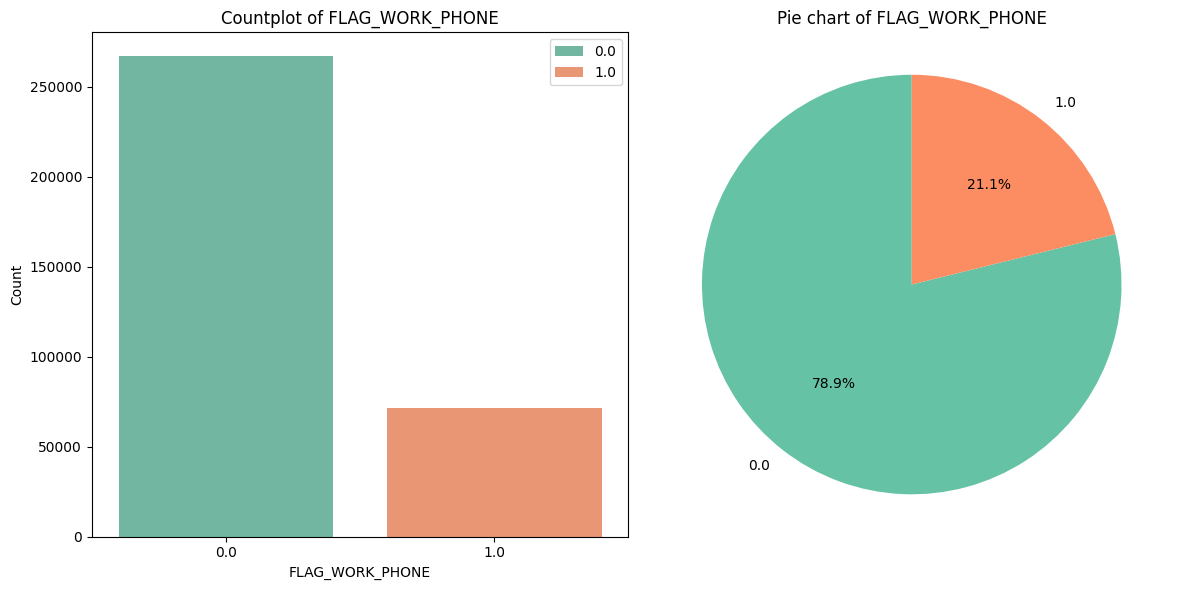


Summary Statistics for feature 'FLAG_WORK_PHONE':

 Category  Frequency Percentage
     0.00     266890     78.86%
     1.00      71536     21.14%
      NaN          1      0.00%

Additional Information:
Unique Values Count: 2
Mode: 0.0


In [ ]:
plots_binary(df_raw, "FLAG_WORK_PHONE")
descriptive_statistics(df_raw, "FLAG_WORK_PHONE", variables_type="binary")

- 'FLAG_WORK_PHONE' indicates the presence of a work phone number:
    - 78.86% of individuals do not have a work phone (0)
    - 21.14% have a work phone (1)
    - There is 1 NaN value
- There are two unique values, with 0 being the mode.

#### FLAG_PHONE

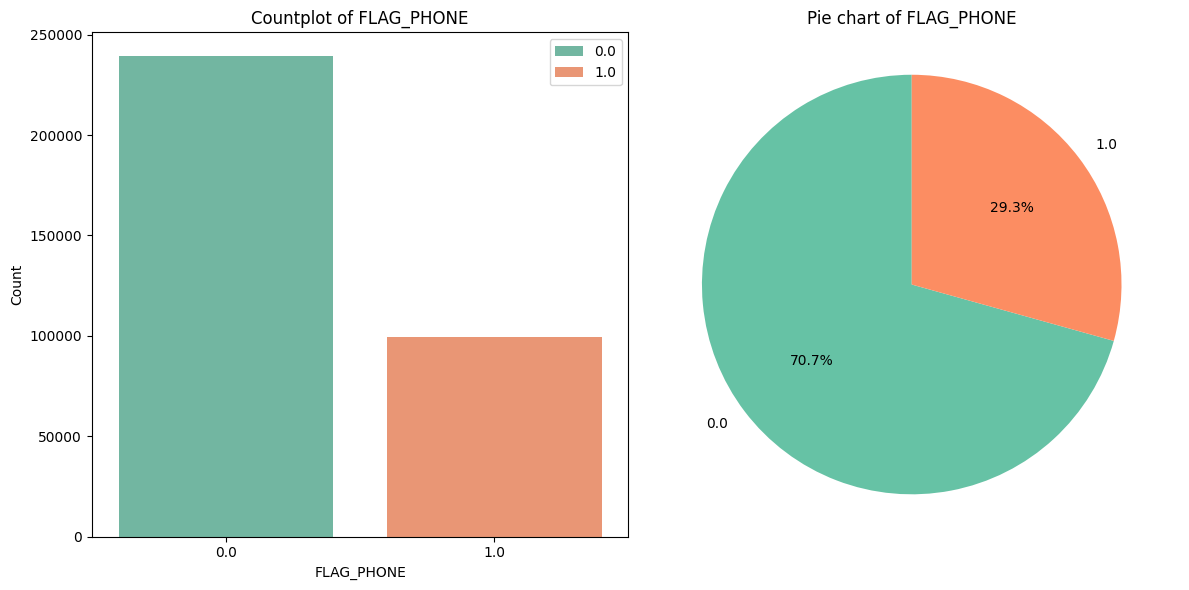


Summary Statistics for feature 'FLAG_PHONE':

 Category  Frequency Percentage
     0.00     239165     70.67%
     1.00      99261     29.33%
      NaN          1      0.00%

Additional Information:
Unique Values Count: 2
Mode: 0.0


In [ ]:
plots_binary(df_raw, "FLAG_PHONE")
descriptive_statistics(df_raw, "FLAG_PHONE", variables_type="binary")

- 'FLAG_PHONE' indicates the presence of a landline phone number:
    - 70.67% of individuals do not have a landline phone number(0)
    - 29.33% have a landline phone (1)
    - There is 1 NaN value
- There are two unique values, with 0 being the mode.

#### FLAG_EMAIL

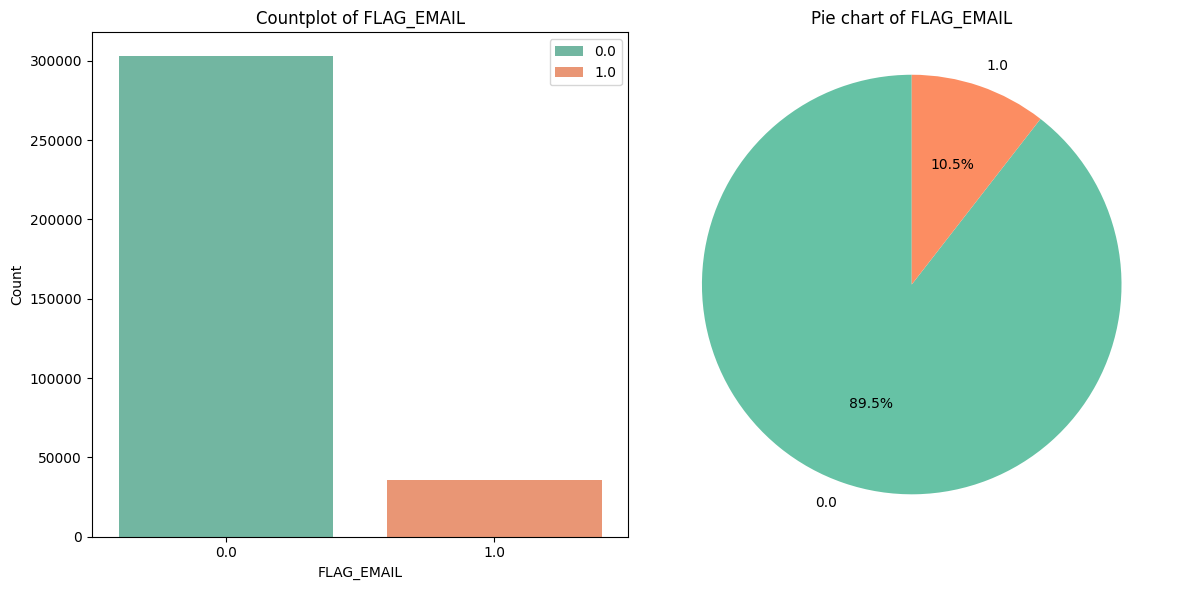


Summary Statistics for feature 'FLAG_EMAIL':

 Category  Frequency Percentage
     0.00     302830     89.48%
     1.00      35596     10.52%
      NaN          1      0.00%

Additional Information:
Unique Values Count: 2
Mode: 0.0


In [ ]:
plots_binary(df_raw, "FLAG_EMAIL")
descriptive_statistics(df_raw, "FLAG_EMAIL", variables_type="binary")

- 'FLAG_EMAIL' indicates the presence of an email address:
    - 89.48% of individuals do not have an email address (0)
    - 10.52% have an email address (1)
    - There is 1 NaN value
- There are two unique values, with 0 being the mode.

#### TARGET

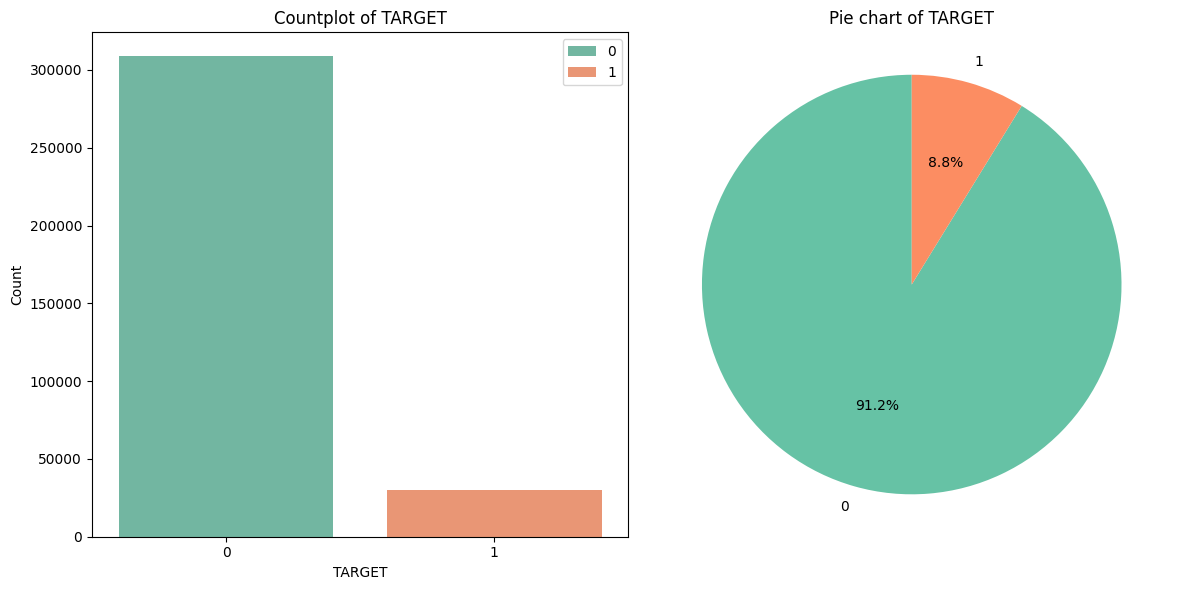


Summary Statistics for feature 'TARGET':

 Category  Frequency Percentage
        0     308705     91.22%
        1      29722      8.78%

Additional Information:
Unique Values Count: 2
Mode: 0


In [ ]:
plots_binary(df_raw, "TARGET")
descriptive_statistics(df_raw, "TARGET", variables_type="binary")

- 91.22% of observations have the value 0.
- 8.78% of observations have the value 1.
- There are two unique values, with 0 as the mode.
- These statistics indicate a significant imbalance in the distribution of the target variable, which may require balancing techniques during model training to improve prediction performance for the minority class.

In [ ]:
# I'm checking for NaN values in the explored categorical variables.
df_raw[df_raw["FLAG_WORK_PHONE"].isna()]
df_raw[df_raw["FLAG_PHONE"].isna()]
df_raw[df_raw["FLAG_EMAIL"].isna()]

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
338426  6392180           F            N               N             0   

        AMT_INCOME_TOTAL NAME_INCOME_TYPE NAME_EDUCATION_TYPE  \
338426          67500.00          Working      Secondary / se   

       NAME_FAMILY_STATUS NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
338426                NaN               NaN         NaN            NaN   

        FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
338426              NaN         NaN         NaN             NaN   

        CNT_FAM_MEMBERS  TARGET  
338426              NaN       0

As I suspected, a single observation is responsible for the NaN values found in the binary variables.
I delete the row that has NaN in the binary variables analyzed above.

In [ ]:
df_raw.shape

(338427, 18)

In [ ]:
# Drop row with 'ID' = 6392180
index_to_drop = df_raw[df_raw['ID'] == 6392180].index
df_raw.drop(index_to_drop, inplace=True)

In [ ]:
df_raw.shape

(338426, 18)

### Nominal categorical variables

#### NAME_INCOME_TYPE


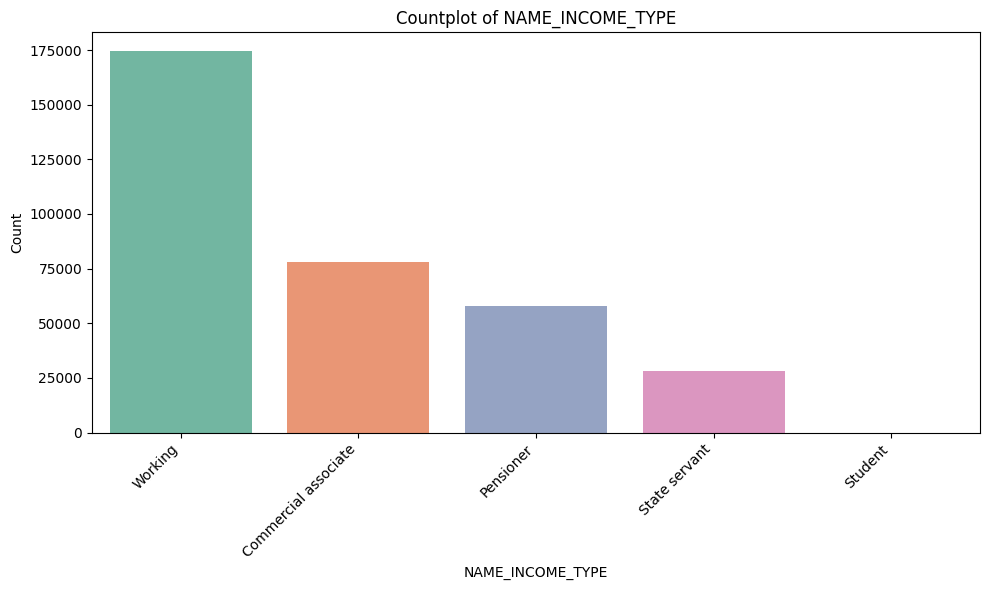


Summary Statistics for feature 'NAME_INCOME_TYPE':

            Category  Frequency Percentage
             Working     174365     51.52%
Commercial associate      78090     23.07%
           Pensioner      57841     17.09%
       State servant      28113      8.31%
             Student         17      0.01%

Additional Information:
Unique Values Count: 5
Mode: Working


In [ ]:
countplot_categorical(df_raw, "NAME_INCOME_TYPE")
descriptive_statistics(df_raw, "NAME_INCOME_TYPE", variables_type='nominal')


'NAME_INCOME_TYPE' indicates income type:

- 'Working' represents 51.52% of observations.
- There are five unique values, with 'Working' as the mode.

#### NAME_FAMILY_STATUS

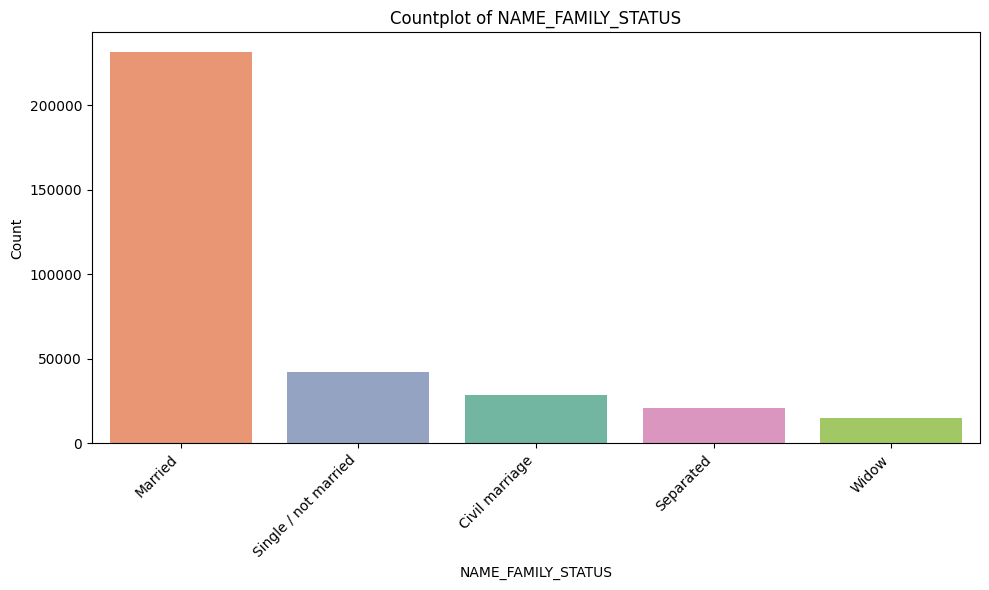


Summary Statistics for feature 'NAME_FAMILY_STATUS':

            Category  Frequency Percentage
             Married     231494     68.40%
Single / not married      42509     12.56%
      Civil marriage      28516      8.43%
           Separated      20809      6.15%
               Widow      15098      4.46%

Additional Information:
Unique Values Count: 5
Mode: Married


In [ ]:
countplot_categorical(df_raw, "NAME_FAMILY_STATUS")
descriptive_statistics(df_raw, "NAME_FAMILY_STATUS", variables_type='nominal')

'NAME_FAMILY_STATUS' indicates marital status:

- 'Married' accounts for 68.40% of observations.
- There are five unique values, with 'Married' being the mode.

#### NAME_HOUSING_TYPE

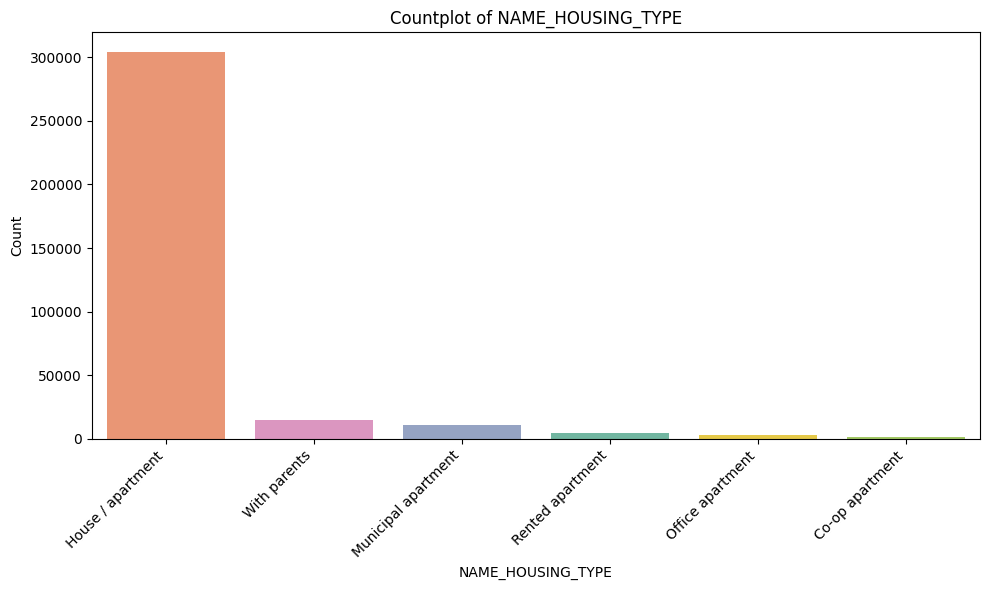


Summary Statistics for feature 'NAME_HOUSING_TYPE':

           Category  Frequency Percentage
  House / apartment     304410     89.95%
       With parents      14625      4.32%
Municipal apartment      10819      3.20%
   Rented apartment       4442      1.31%
   Office apartment       2968      0.88%
    Co-op apartment       1162      0.34%

Additional Information:
Unique Values Count: 6
Mode: House / apartment


In [ ]:
countplot_categorical(df_raw, "NAME_HOUSING_TYPE")
descriptive_statistics(df_raw, "NAME_HOUSING_TYPE", variables_type='nominal')

'NAME_HOUSING_TYPE' indicates the type of housing:

- 'House / apartment' accounts for 89.95% of observations.
- There are six unique values, with 'House / apartment' being the mode.

#### OCCUPATION_TYPE

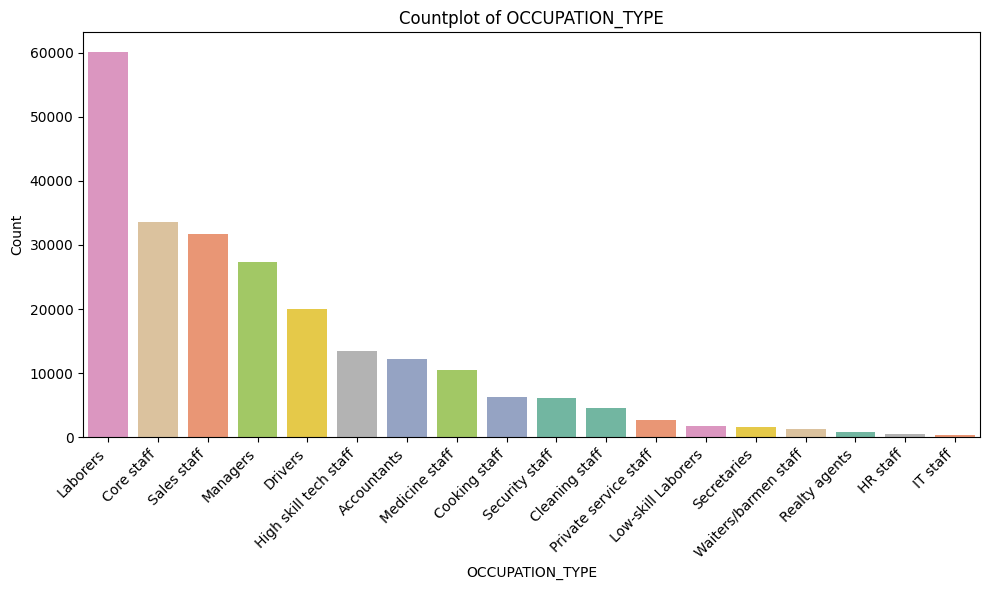


Summary Statistics for feature 'OCCUPATION_TYPE':

             Category  Frequency Percentage
                  NaN     103341     30.54%
             Laborers      60146     17.77%
           Core staff      33527      9.91%
          Sales staff      31652      9.35%
             Managers      27384      8.09%
              Drivers      20020      5.92%
High skill tech staff      13399      3.96%
          Accountants      12281      3.63%
       Medicine staff      10438      3.08%
        Cooking staff       6248      1.85%
       Security staff       6218      1.84%
       Cleaning staff       4594      1.36%
Private service staff       2787      0.82%
   Low-skill Laborers       1714      0.51%
          Secretaries       1577      0.47%
 Waiters/barmen staff       1245      0.37%
        Realty agents        852      0.25%
             HR staff        567      0.17%
             IT staff        436      0.13%

Additional Information:
Unique Values Count: 18
Mode: Laborers


In [ ]:
countplot_categorical(df_raw, "OCCUPATION_TYPE")
descriptive_statistics(df_raw, "OCCUPATION_TYPE", variables_type='nominal')

- 'OCCUPATION_TYPE' indicates the type of occupation:
    - NaN values account for 30.54% of observations
    - 'Laborers' account for 17.77% of observations
    - 'Core staff' account for 9.91% of observations
    - 'Sales staff' account for 9.35% of observations
- There are 18 unique values.

### Ordinal categorical variable

#### NAME_EDUCATION_TYPE

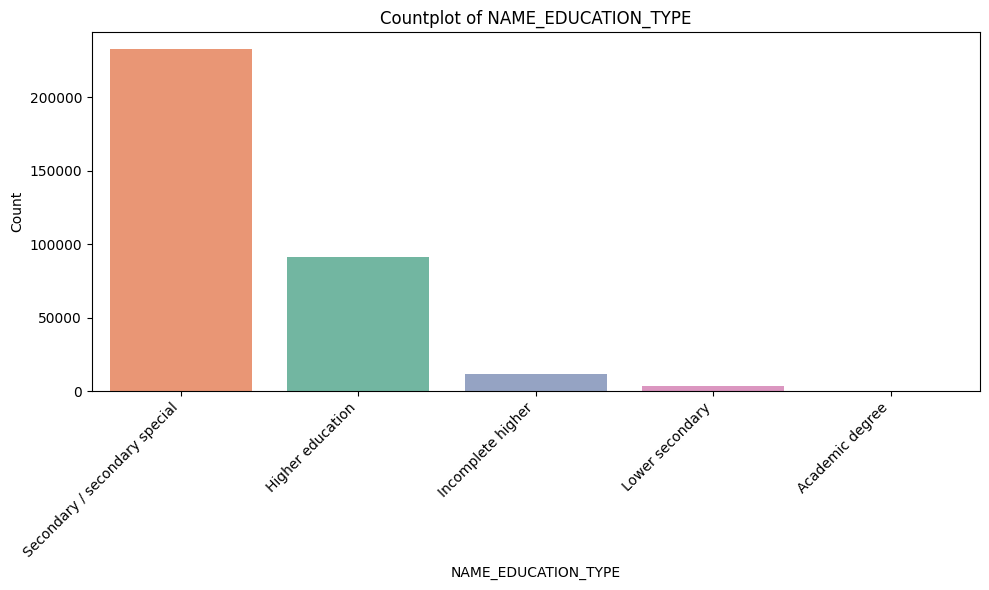


Summary Statistics for feature 'NAME_EDUCATION_TYPE':

                     Category  Frequency Percentage
Secondary / secondary special     232568     68.72%
             Higher education      91062     26.91%
            Incomplete higher      11387      3.36%
              Lower secondary       3177      0.94%
              Academic degree        232      0.07%

Additional Information:
Unique Values Count: 5
Mode: Secondary / secondary special


In [ ]:
countplot_categorical(df_raw, "NAME_EDUCATION_TYPE")
descriptive_statistics(df_raw, "NAME_EDUCATION_TYPE", variables_type='ordinal')

NAME_EDUCATION_TYPE indicates the level of education.

- The most frequent category is "Secondary / secondary special" with 68.72% of observations.
- Overall, there are 6 unique values for this feature.

## Quantitative variables

### Discrete quantitative variables

#### CNT_CHILDREN

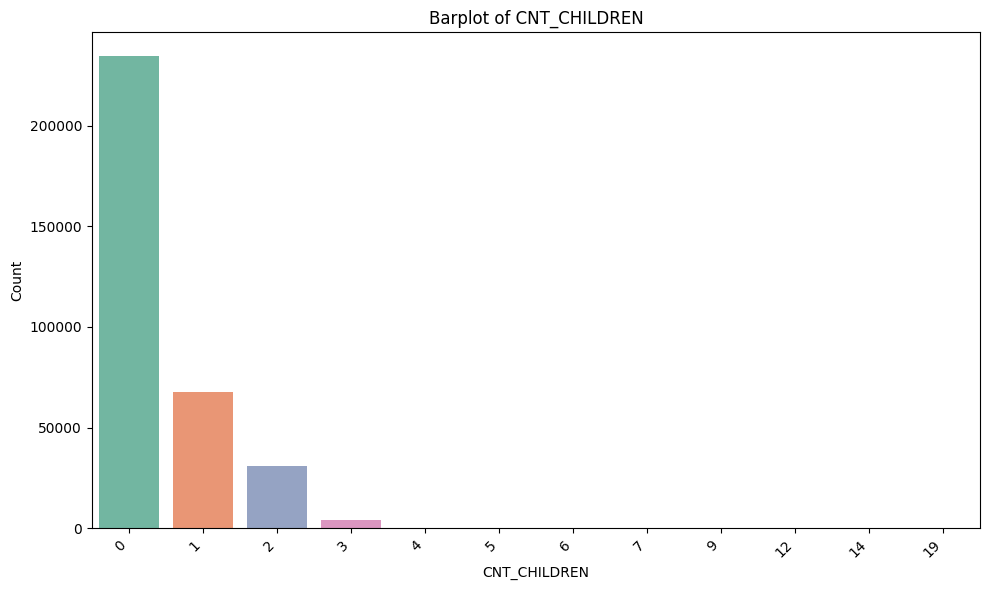


Descriptive Statistics for feature 'CNT_CHILDREN':

Min: 0
Q1 (25th): 0.00
Q2 Median: 0.00
Q3 (75th): 1.00
Max: 19
IQR: 1.00
Mean: 0.43
Mode: 0
Variance: 0.53
Standard Deviation: 0.73
Range: 19
Skewness: 1.83
Kurtosis: 5.67


In [ ]:
barplot_discrete(df_raw, "CNT_CHILDREN")
descriptive_statistics(df_raw, "CNT_CHILDREN",variables_type="discrete")

The variable CNT_CHILDREN indicates the number of children and is a discrete quantitative variable.

- Most observations have 0 children, as indicated by median (Q2) and first quartile (Q1), all equal to 0.
- The third quartile (Q3) is 1, indicating that 75% of observations have at most 1 child.
- The mean is 0.43, suggesting that the average number of children per observation is less than 1.
- The variability is moderate, with a variance of 0.53 and a standard deviation of 0.73.
- The range, from 0 to 19 children, along with the high skewness (1.83) and kurtosis (5.67), indicates the presence of a few observations with a significantly high number of children compared to the majority.
- These data suggest a skewed distribution with a long right tail, highlighting the predominance of observations with few or no children, but also the presence of some cases with many children.

#### DAYS_BIRTH

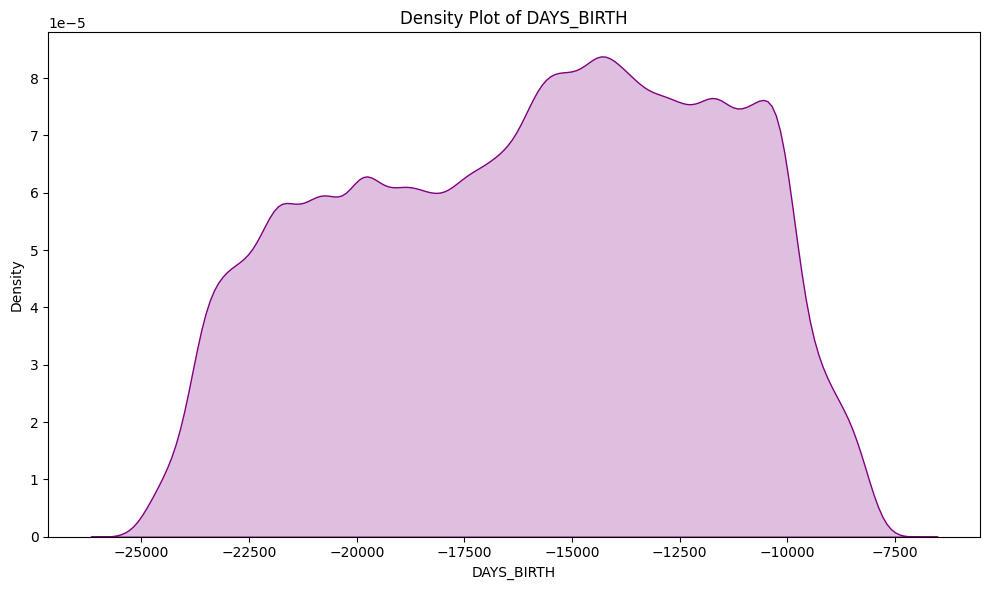


Descriptive Statistics for feature 'DAYS_BIRTH':

Min: -25201.00
Q1 (25th): -19482.00
Q2 Median: -15622.00
Q3 (75th): -12524.00
Max: -7489.00
IQR: 6958.00
Mean: -15998.25
Mode: -11707.00
Variance: 17474406.90
Standard Deviation: 4180.24
Range: 17712.00
Skewness: -0.17
Kurtosis: -1.04


In [ ]:
plot_continuous(df_raw, "DAYS_BIRTH", plot_type="density")
descriptive_statistics(df_raw, "DAYS_BIRTH",variables_type="discrete")

It is important to consider that representing days since birth with negative values in the DAYS_BIRTH feature can lead to misinterpretations during the calculation of statistical indices. Specifically:

- Interpretation of minimum and maximum values: Days since birth are represented as negative numbers, where the lowest value indicates the oldest person in the dataset. Therefore, the numerical minimum in absolute terms (the most negative) actually represents the oldest person in the dataset, not the smallest numerical value in the traditional sense.

- Statistical calculations: When calculating descriptive statistics such as mean, median, standard deviation, etc., it is crucial to account for the negative sign. For example, the mean of days since birth will be negative due to the representation of negative values, even though it represents a positive age in years.

- Potential interpretation errors: Ignoring the fact that values are negative can lead to misinterpretation, especially when comparing days since birth with other variables or external data that do not use the same data representation convention.

For these reasons, it is essential to adopt a mindful approach when interpreting negative values in the DAYS_BIRTH feature. To mitigate potential interpretation errors during analysis, creating a new feature called DAYS_BIRTH_POSITIVE is recommended, where each value will be expressed with a positive sign, thus reflecting the positive age of individuals in the dataset.

#### DAYS_BIRTH_POSITIVE

In [ ]:
df_raw.loc[:, 'DAYS_BIRTH_POSITIVE'] = -df_raw['DAYS_BIRTH']
df_raw[['DAYS_BIRTH', 'DAYS_BIRTH_POSITIVE']].head()

DAYS_BIRTH  DAYS_BIRTH_POSITIVE
0   -12005.00             12005.00
1   -12005.00             12005.00
2   -21474.00             21474.00
3   -19110.00             19110.00
4   -19110.00             19110.00

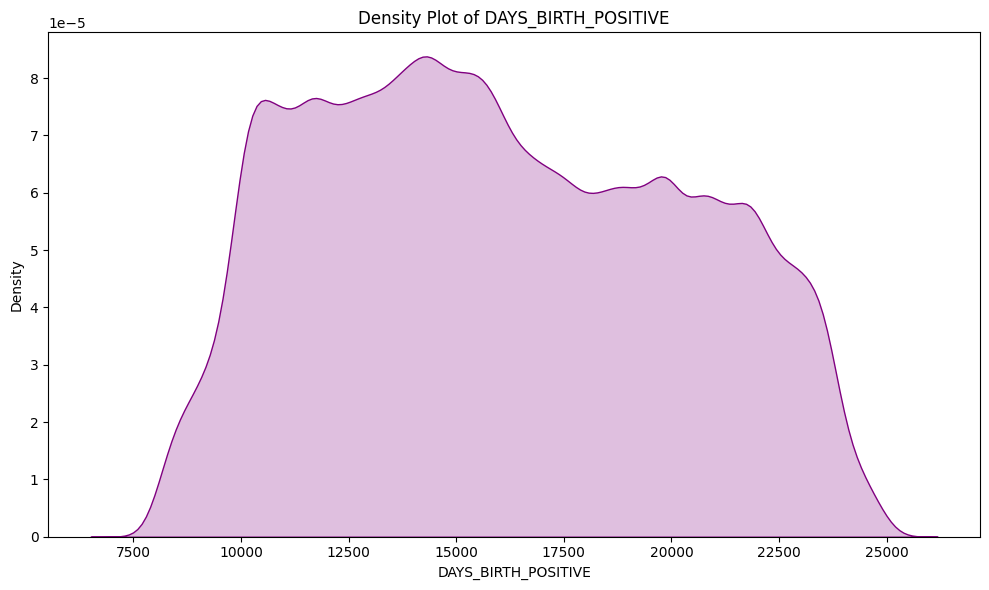


Descriptive Statistics for feature 'DAYS_BIRTH_POSITIVE':

Min: 7489.00
Q1 (25th): 12524.00
Q2 Median: 15622.00
Q3 (75th): 19482.00
Max: 25201.00
IQR: 6958.00
Mean: 15998.25
Mode: 11707.00
Variance: 17474406.90
Standard Deviation: 4180.24
Range: 17712.00
Skewness: 0.17
Kurtosis: -1.04


In [ ]:
#barplot_discrete(df_raw, "DAYS_BIRTH_POSITIVE") # 3 minutes to show the plot
plot_continuous(df_raw, "DAYS_BIRTH_POSITIVE", plot_type="density")
descriptive_statistics(df_raw, "DAYS_BIRTH_POSITIVE",variables_type="discrete")

DAYS_BIRTH_POSITIVE indicates a person's age in days:

- Min: 7489.00 days, which corresponds to the youngest person in the dataset.
- Q1 (25th): 12524.00 days, indicating that 25% of the individuals in the dataset are younger than approximately 34.3 years.
- Q2 Median: 15622.00 days, representing the median age of approximately 42.8 years.
- Q3 (75th): 19482.00 days, meaning that 75% of the individuals are younger than around 53.4 years.
- Max: 25201.00 days, indicating the oldest person in the dataset.
- IQR: 6958.00 days, which measures the spread of ages among the middle 50% of individuals.
- Mean: 15998.25 days, or about 43.8 years, showing a slight skew toward younger ages compared to the median.
- Mode: 11707.00 days, suggesting a higher frequency of individuals around the age of 32 years.
- Variance: 17474406.90, indicating the variability in age among the dataset.
- Standard Deviation: 4180.24 days, or approximately 11.4 years, showing the average deviation from the mean age.
- Range: 17712.00 days, representing the difference between the oldest and youngest individuals in the dataset.
- Skewness: 0.17, indicating a slight positive skew, suggesting a slightly higher concentration of younger ages compared to older ages.
- Kurtosis: -1.04, suggesting a relatively flat distribution with fewer extreme values compared to a normal distribution.

In [ ]:
df_raw.shape

(338426, 19)

In [ ]:
# drop 'DAYS_BIRTH' from the dataframe
df_raw.drop(columns=["DAYS_BIRTH"], inplace=True)

In [ ]:
df_raw.shape

(338426, 18)

#### DAYS_EMPLOYED

In [ ]:
plot_continuous(df_raw, "DAYS_EMPLOYED", plot_type="density")
descriptive_statistics(df_raw, "DAYS_EMPLOYED",variables_type="discrete")


Descriptive Statistics for feature 'DAYS_EMPLOYED':

Min: -17531.00
Q1 (25th): -3116.00
Q2 Median: -1485.00
Q3 (75th): -380.00
Max: 365243.00
IQR: 2736.00
Mean: 60238.50
Mode: 365243.00
Variance: 19182015422.30
Standard Deviation: 138499.15
Range: 382774.00
Skewness: 1.75
Kurtosis: 1.06


The variable DAYS_EMPLOYED represents the number of days since employment. A positive value indicates the number of days since the individual has been unemployed.

- The median (Q2) is -1485 days, indicating that 50% of the observations have an employment period of less than about 4 years.
- The first quartile (Q1) and third quartile (Q3) are -3116 days and -380 days, respectively, showing that 50% of the observations were employed for between about 1 and 8 years.
- The mean is 60238.50 days, a value skewed by very high observations.
- The mode is 365243 days, an evidently anomalous and very high value, which may represent missing or erroneous data.
- The variability in days of employment is very high, with a standard deviation of 138499.15 days.
- The skewness is 1.75, indicating a highly right-skewed distribution with many extreme positive values.
- The kurtosis of 1.06 suggests a distribution with heavier tails than a normal distribution, indicating the presence of extreme values.

These statistics highlight the existence of extreme outliers and the need for data cleaning for more accurate analysis.

#### CNT_FAM_MEMBERS

In [ ]:
barplot_discrete(df_raw, "CNT_FAM_MEMBERS")
descriptive_statistics(df_raw, "CNT_FAM_MEMBERS",variables_type="discrete")


Descriptive Statistics for feature 'CNT_FAM_MEMBERS':

Min: 1.00
Q1 (25th): 2.00
Q2 Median: 2.00
Q3 (75th): 3.00
Max: 20.00
IQR: 1.00
Mean: 2.20
Mode: 2.00
Variance: 0.81
Standard Deviation: 0.90
Range: 19.00
Skewness: 0.94
Kurtosis: 2.13


The variable CNT_FAM_MEMBERS represents the number of family members.

- The minimum number of family members is 1, indicating that some individuals live alone.
- The first quartile (Q1) and median (Q2) are both 2, showing that at least 50% of the observations have 2 family members.
- The third quartile (Q3) is 3, meaning that 75% of the observations have 3 or fewer family members.
- The maximum number of family members is 20, indicating some large families, though this might include outliers or data entry errors.
- The mode is 2, which is the most frequently occurring number of family members.
- The variance is 0.81, and the standard deviation is 0.90, indicating low variability in family size.
- The skewness is 0.94, showing a moderate right skew with some larger family sizes.
- The kurtosis is 2.13, suggesting a distribution with somewhat heavier tails than a normal distribution.

These statistics indicate that most individuals have a small family size, with occasional larger families.

### Continuous quantitative variable

#### AMT_INCOME_TOTAL

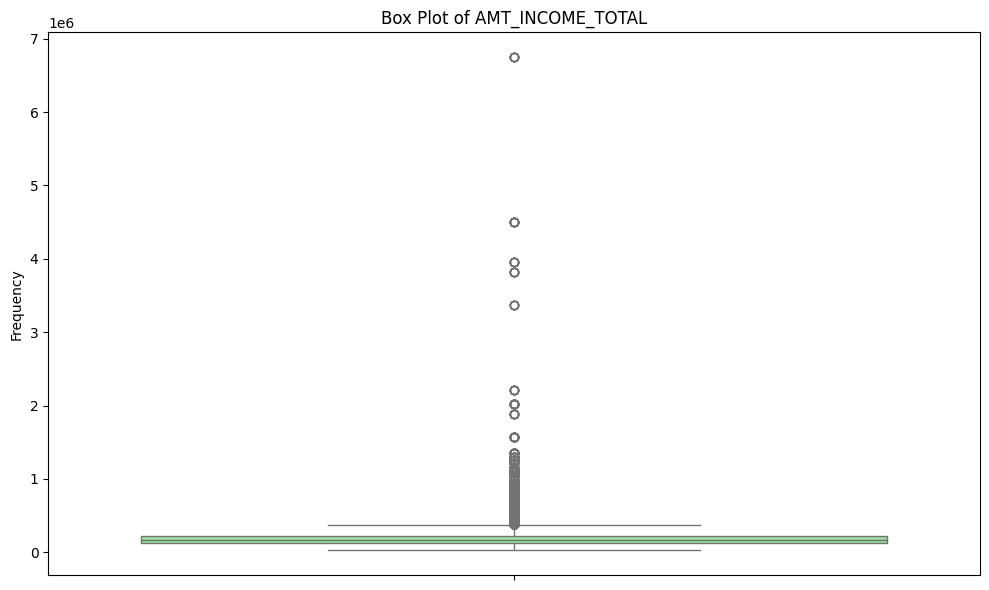


Descriptive Statistics for feature 'AMT_INCOME_TOTAL':

Min: 26100.00
Q1 (25th): 121500.00
Q2 Median: 162000.00
Q3 (75th): 225000.00
Max: 6750000.00
IQR: 103500.00
Mean: 187654.70
Mode: 135000.00
Variance: 12248880328.58
Standard Deviation: 110674.66
Range: 6723900.00
Skewness: 9.46
Kurtosis: 358.63


In [ ]:
plot_continuous(df_raw, "AMT_INCOME_TOTAL",  plot_type="hist")
plot_continuous(df_raw, "AMT_INCOME_TOTAL",  plot_type="box")
#plot_continuous(df_raw, "AMT_INCOME_TOTAL",  plot_type="density")
descriptive_statistics(df_raw, "AMT_INCOME_TOTAL",variables_type="continuous")

AMT_INCOME_TOTAL represents the annual income and is a continuous quantitative variable.

- The minimum annual income is 26100.00.
- The first quartile (Q1) is 121500.00 and the median (Q2) is 162000.00, indicating that 50% of the observations have incomes below this value.
- The third quartile (Q3) is 225000.00, meaning that 75% of the observations have incomes equal to or below this value.
- The maximum annual income is 6750000.00, showing the presence of some very high incomes that could include outliers or anomalous data.
- The interquartile range (IQR) is 103500.00, indicating a relatively compact distribution around the median.
- The mean annual income is 187654.34, higher than the median, indicating a slight positive skewness in the distribution.
- The variance is 12248886,794.47 and the standard deviation is 110674.69, showing significant variability in annual incomes.
- The skewness is 9.46, indicating a strong positive skew with a long tail towards higher incomes.
- The kurtosis is 358.62, suggesting an extremely flattened distribution compared to a normal distribution, with heavy tails.

These statistics reveal a wide range of annual incomes in the dataset, with a notable concentration around the mean values and a long tail of observations with very high incomes.

## Bivariate Analysis

### CODE_GENDER - TARGET

In [ ]:
bivariate_cat_cat(df_raw, 'CODE_GENDER', 'TARGET')

Contingency Table:
TARGET            0      1
CODE_GENDER               
F            208567  19348
M            100137  10374



Chi-Square Statistic: 74.83246623850184
P-Value: 5.1240114513014936e-18
Degrees of Freedom: 1
Expected Frequencies: 
[[207898.54254697  20016.45745303]
 [100805.45745303   9705.54254697]]


(TARGET            0      1
 CODE_GENDER               
 F            208567  19348
 M            100137  10374,
 np.float64(74.83246623850184),
 np.float64(5.1240114513014936e-18),
 1,
 array([[207898.54254697,  20016.45745303],
        [100805.45745303,   9705.54254697]]))

Interpretation
- Significant Association: The very low p-value (5.1240114513014936e-18) suggests that there is a significant association between CODE_GENDER and TARGET. This means that gender (F or M) is significantly associated with the value of TARGET (0 or 1).

- Deviation from Expected Frequencies: The high chi-square statistic (74.83246623850184) indicates that the frequencies observed in the contingency table are significantly different from the frequencies expected if the two variables were independent. This strengthens the evidence that there is a significant association between the variables.

In conclusion, the results indicate that there is a significant relationship between gender (CODE_GENDER) and target (TARGET) in the dataset.

### FLAG_OWN_CAR - TARGET

Contingency Table:
TARGET             0      1
FLAG_OWN_CAR               
N             196064  17131
Y             112640  12591


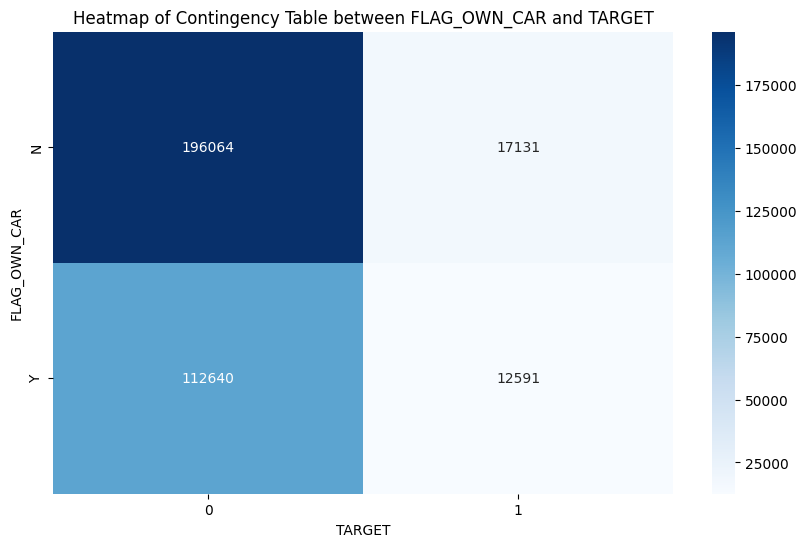


Chi-Square Statistic: 401.11510840727976
P-Value: 3.149128667120129e-89
Degrees of Freedom: 1
Expected Frequencies: 
[[194471.31508808  18723.68491192]
 [114232.68491192  10998.31508808]]


(TARGET             0      1
 FLAG_OWN_CAR               
 N             196064  17131
 Y             112640  12591,
 np.float64(401.11510840727976),
 np.float64(3.149128667120129e-89),
 1,
 array([[194471.31508808,  18723.68491192],
        [114232.68491192,  10998.31508808]]))

In [ ]:
bivariate_cat_cat(df_raw, 'FLAG_OWN_CAR', 'TARGET')

Interpretation
- Significant Association: The p-value of 3.149128667120129e-89 is extremely low, indicating a highly significant association between FLAG_OWN_CAR and TARGET. This means that the ownership of a car is significantly associated with the value of TARGET.

- Deviation from Expected Frequencies: The chi-square statistic of 401.11510840727976 is very high, indicating that the observed frequencies deviate significantly from the expected frequencies under the assumption of independence. This reinforces the evidence that there is a significant association between the variables.

- Practical Implications: The significant association between car ownership (FLAG_OWN_CAR) and the target variable (TARGET) suggests that whether a person owns a car could be an important factor related to the target variable.

In summary, the analysis shows a strong and significant relationship between car ownership and the target variable.

### FLAG_OWN_REALTY - TARGET

Contingency Table:
TARGET                0      1
FLAG_OWN_REALTY               
N                 99053   8066
Y                209651  21656


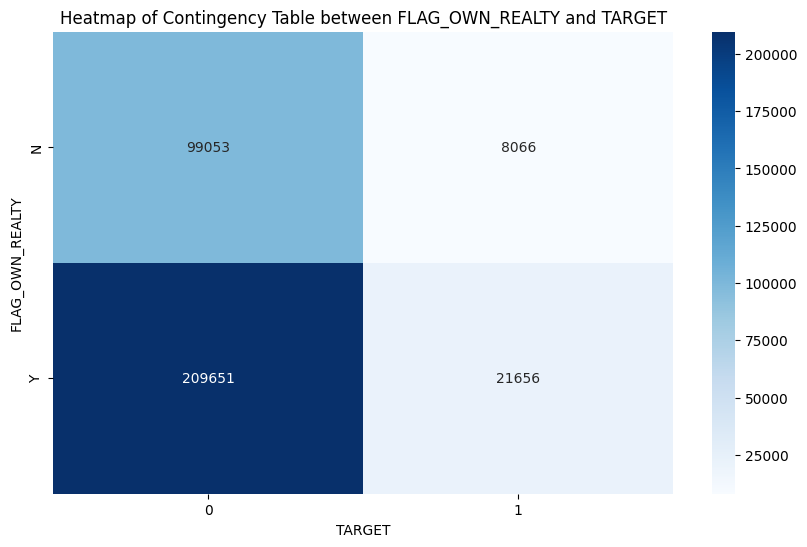


Chi-Square Statistic: 306.6659989184436
P-Value: 1.1628585004607685e-68
Degrees of Freedom: 1
Expected Frequencies: 
[[ 97711.35721251   9407.64278749]
 [210992.64278749  20314.35721251]]


(TARGET                0      1
 FLAG_OWN_REALTY               
 N                 99053   8066
 Y                209651  21656,
 np.float64(306.6659989184436),
 np.float64(1.1628585004607685e-68),
 1,
 array([[ 97711.35721251,   9407.64278749],
        [210992.64278749,  20314.35721251]]))

In [ ]:
bivariate_cat_cat(df_raw, 'FLAG_OWN_REALTY', 'TARGET')

Interpretation
- Significant Association: The p-value of 1.1628585004607685e-68 is extremely low, indicating a highly significant association between FLAG_OWN_REALTY and TARGET. This means that owning realty is significantly associated with the value of TARGET.

- Deviation from Expected Frequencies: The chi-square statistic of 306.6659989184436 is very high, indicating that the observed frequencies deviate significantly from the expected frequencies under the assumption of independence. This further suggests that there is a significant association between the variables.

- Practical Implications: The significant association between realty ownership (FLAG_OWN_REALTY) and the target variable (TARGET) implies that whether a person owns realty could be an important factor related to the target variable.


In summary, the analysis indicates a strong and significant relationship between realty ownership and the target variable.

### FLAG_WORK_PHONE - TARGET

In [ ]:
bivariate_cat_cat(df_raw, 'FLAG_WORK_PHONE', 'TARGET')

Contingency Table:
TARGET                0      1
FLAG_WORK_PHONE               
0.00             242949  23941
1.00              65755   5781



Chi-Square Statistic: 55.558624052756485
P-Value: 9.071299327349123e-14
Degrees of Freedom: 1
Expected Frequencies: 
[[243450.59351232  23439.40648768]
 [ 65253.40648768   6282.59351232]]


(TARGET                0      1
 FLAG_WORK_PHONE               
 0.00             242949  23941
 1.00              65755   5781,
 np.float64(55.558624052756485),
 np.float64(9.071299327349123e-14),
 1,
 array([[243450.59351232,  23439.40648768],
        [ 65253.40648768,   6282.59351232]]))

Interpretation
- Significant Association: The p-value of 9.071299327349123e-14 is extremely low, indicating a highly significant association between FLAG_WORK_PHONE and TARGET. This means that a person having a work phone number is significantly associated with the value of TARGET.

- Deviation from Expected Frequencies: The chi-square statistic of 55.558624052756485 is relatively high, indicating that the observed frequencies deviate significantly from the frequencies expected under the independence assumption. This suggests that there is a significant association between the variables.

- Practical Implications: The significant association between having a work phone (FLAG_WORK_PHONE) and the target variable (TARGET) implies that a person having a work phone number could be an important factor related to the target variable.

In summary, the analysis indicates a strong and significant relationship between having a work phone number and the target variable.

### FLAG_PHONE - TARGET

In [ ]:
bivariate_cat_cat(df_raw, 'FLAG_PHONE', 'TARGET')

Contingency Table:
TARGET           0      1
FLAG_PHONE               
0.00        218839  20326
1.00         89865   9396



Chi-Square Statistic: 81.79529081113446
P-Value: 1.509377680499247e-19
Degrees of Freedom: 1
Expected Frequencies: 
[[218160.52005461  21004.47994539]
 [ 90543.47994539   8717.52005461]]


(TARGET           0      1
 FLAG_PHONE               
 0.00        218839  20326
 1.00         89865   9396,
 np.float64(81.79529081113446),
 np.float64(1.509377680499247e-19),
 1,
 array([[218160.52005461,  21004.47994539],
        [ 90543.47994539,   8717.52005461]]))

Interpretation
- Significant Association: The p-value of 1.509377680499247e-19 is extremely low, indicating a highly significant association between FLAG_PHONE and TARGET. This means that owning a phone is significantly associated with the value of TARGET.

- Deviation from Expected Frequencies: The chi-square statistic of 81.79529081113446 is relatively high, indicating that the observed frequencies deviate significantly from the expected frequencies under the assumption of independence.

- Practical Implications: The significant association between owning a phone number (FLAG_PHONE) and the target variable (TARGET) implies that owning a phone number could be an important factor related to the target variable.

In summary, the analysis indicates a strong and significant relationship between owning a phone number and the target variable.

### FLAG_EMAIL - TARGET

In [ ]:
bivariate_cat_cat(df_raw, 'FLAG_EMAIL', 'TARGET')

Contingency Table:
TARGET           0      1
FLAG_EMAIL               
0.00        276861  25969
1.00         31843   3753



Chi-Square Statistic: 153.72627369983582
P-Value: 2.6579648570933367e-35
Degrees of Freedom: 1
Expected Frequencies: 
[[276234.19099005  26595.80900995]
 [ 32469.80900995   3126.19099005]]


(TARGET           0      1
 FLAG_EMAIL               
 0.00        276861  25969
 1.00         31843   3753,
 np.float64(153.72627369983582),
 np.float64(2.6579648570933367e-35),
 1,
 array([[276234.19099005,  26595.80900995],
        [ 32469.80900995,   3126.19099005]]))

Interpretation
- Significant Association: The p-value of 2.6579648570933367e-35 is extremely low, indicating a highly significant association between FLAG_EMAIL and TARGET. This means that the presence of an email is significantly associated with the value of TARGET.

- Deviation from Expected Frequencies: The chi-square statistic of 153.72627369983582 is very high, indicating that the observed frequencies significantly deviate from the expected frequencies under the assumption of independence. This further suggests that there is a significant association between the variables.

- Practical Implications: The significant association between having an email (FLAG_EMAIL) and the target variable (TARGET) implies that the presence of an email could be an important factor related to the target variable.

Summary: The analysis indicates a strong and significant relationship between having an email and the target variable.

### NAME_INCOME_TYPE - TARGET

Contingency Table:
TARGET                     0      1
NAME_INCOME_TYPE                   
Commercial associate   68678   9412
Pensioner              57841      0
State servant          24357   3756
Student                   14      3
Working               157814  16551


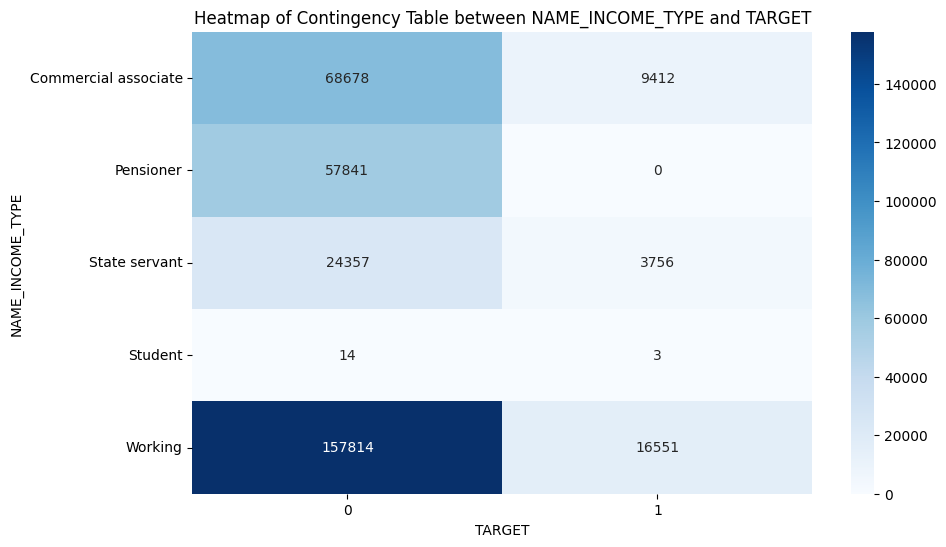


Chi-Square Statistic: 7458.214469327244
P-Value: 0.0
Degrees of Freedom: 4
Expected Frequencies: 
[[7.12318065e+04 6.85819346e+03]
 [5.27611592e+04 5.07984080e+03]
 [2.56439977e+04 2.46900234e+03]
 [1.55069882e+01 1.49301177e+00]
 [1.59051530e+05 1.53134704e+04]]


(TARGET                     0      1
 NAME_INCOME_TYPE                   
 Commercial associate   68678   9412
 Pensioner              57841      0
 State servant          24357   3756
 Student                   14      3
 Working               157814  16551,
 np.float64(7458.214469327244),
 np.float64(0.0),
 4,
 array([[7.12318065e+04, 6.85819346e+03],
        [5.27611592e+04, 5.07984080e+03],
        [2.56439977e+04, 2.46900234e+03],
        [1.55069882e+01, 1.49301177e+00],
        [1.59051530e+05, 1.53134704e+04]]))

In [ ]:
bivariate_cat_cat(df_raw, 'NAME_INCOME_TYPE', 'TARGET')

Interpretation
- Significant Association: The chi-square statistic of 7458.214469327244 and the p-value of 0.0 indicate a highly significant relationship between NAME_INCOME_TYPE and TARGET. This suggests that the income type (NAME_INCOME_TYPE) is strongly associated with the value of TARGET.
- Deviation from Expected Frequencies: The large chi-square statistic indicates that the observed frequencies are significantly different from the expected frequencies. This confirms that there is a significant relationship between the variables.
- Practical Implications: The significant association between the income type (NAME_INCOME_TYPE) and the target variable (TARGET) suggests that the income type may be an important factor in predicting or understanding the target variable.

Summary: The analysis indicates a strong and significant relationship between the income type and the target variable. This result suggests that the income type is an important factor to consider.

### NAME_FAMILY_STATUS - TARGET

Contingency Table:
TARGET                     0      1
NAME_FAMILY_STATUS                 
Civil marriage         26223   2293
Married               211303  20191
Separated              18269   2540
Single / not married   39350   3159
Widow                  13559   1539


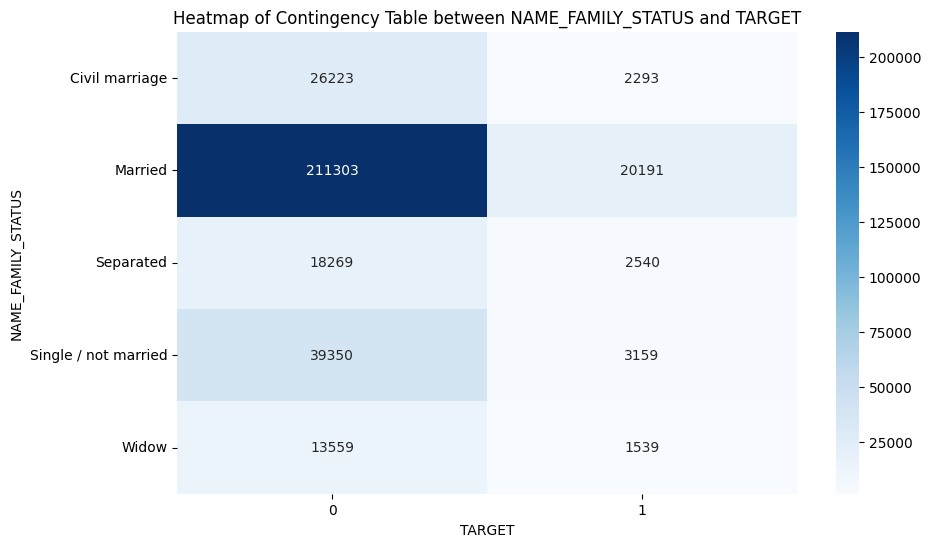


Chi-Square Statistic: 459.49123892410387
P-Value: 3.853706994070157e-98
Degrees of Freedom: 4
Expected Frequencies: 
[[ 26011.60449847   2504.39550153]
 [211163.21965806  20330.78034194]
 [ 18981.46577391   1827.53422609]
 [ 38775.68016642   3733.31983358]
 [ 13772.02990314   1325.97009686]]


(TARGET                     0      1
 NAME_FAMILY_STATUS                 
 Civil marriage         26223   2293
 Married               211303  20191
 Separated              18269   2540
 Single / not married   39350   3159
 Widow                  13559   1539,
 np.float64(459.49123892410387),
 np.float64(3.853706994070157e-98),
 4,
 array([[ 26011.60449847,   2504.39550153],
        [211163.21965806,  20330.78034194],
        [ 18981.46577391,   1827.53422609],
        [ 38775.68016642,   3733.31983358],
        [ 13772.02990314,   1325.97009686]]))

In [ ]:
bivariate_cat_cat(df_raw, 'NAME_FAMILY_STATUS', 'TARGET')

Interpretation

- Significant Association: The chi-square statistic of 459.49123892410387 and the p-value of 3.853706994070157e-98 indicate a highly significant relationship between NAME_FAMILY_STATUS and TARGET. This suggests that family status (NAME_FAMILY_STATUS) is strongly associated with the value of TARGET.

- Deviation from Expected Frequencies: The large chi-square statistic confirms that the observed frequencies significantly deviate from the expected frequencies.

- Practical Implications: The significant association between family status (NAME_FAMILY_STATUS) and the target variable (TARGET) implies that family status could be an important factor in predicting or understanding the target variable.

Summary: The analysis indicates a strong and significant relationship between family status and the target variable. This finding suggests that family status is an important factor to consider in future analyses or model building involving these data.

### NAME_HOUSING_TYPE - TARGET

Contingency Table:
TARGET                    0      1
NAME_HOUSING_TYPE                 
Co-op apartment        1088     74
House / apartment    276746  27664
Municipal apartment    9651   1168
Office apartment       2677    291
Rented apartment       4235    207
With parents          14307    318


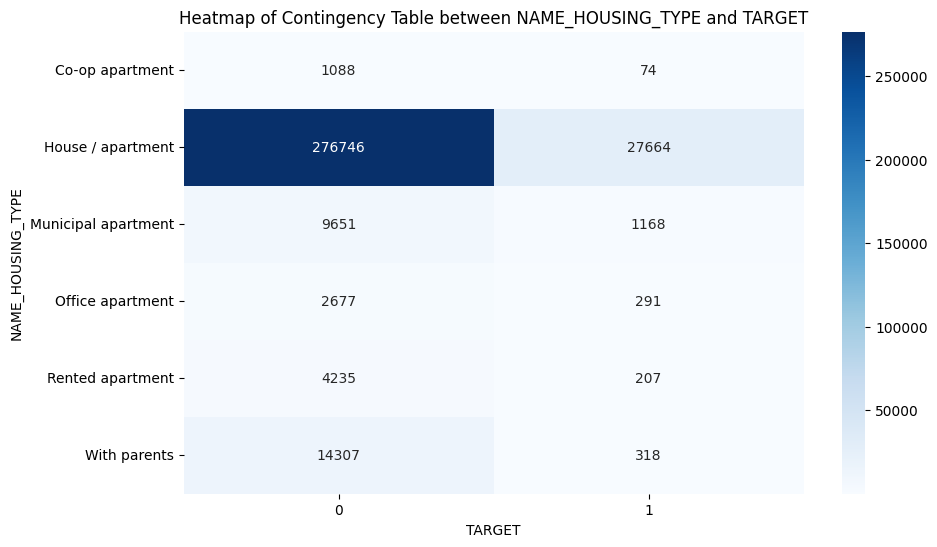


Chi-Square Statistic: 993.8911884242505
P-Value: 1.263013304377796e-212
Degrees of Freedom: 5
Expected Frequencies: 
[[1.05994825e+03 1.02051745e+02]
 [2.77675429e+05 2.67345713e+04]
 [9.86882975e+03 9.50170253e+02]
 [2.70733771e+03 2.60662290e+02]
 [4.05188481e+03 3.90115192e+02]
 [1.33405708e+04 1.28442924e+03]]


(TARGET                    0      1
 NAME_HOUSING_TYPE                 
 Co-op apartment        1088     74
 House / apartment    276746  27664
 Municipal apartment    9651   1168
 Office apartment       2677    291
 Rented apartment       4235    207
 With parents          14307    318,
 np.float64(993.8911884242505),
 np.float64(1.263013304377796e-212),
 5,
 array([[1.05994825e+03, 1.02051745e+02],
        [2.77675429e+05, 2.67345713e+04],
        [9.86882975e+03, 9.50170253e+02],
        [2.70733771e+03, 2.60662290e+02],
        [4.05188481e+03, 3.90115192e+02],
        [1.33405708e+04, 1.28442924e+03]]))

In [ ]:
bivariate_cat_cat(df_raw, 'NAME_HOUSING_TYPE', 'TARGET')

Interpretation

- Significant Association: The chi-square statistic of 993.8911884242505 and the p-value of 1.263013304377796e-212 indicate a highly significant relationship between NAME_HOUSING_TYPE and TARGET. This suggests that housing type (NAME_HOUSING_TYPE) is strongly associated with the value of TARGET.

- Deviation from Expected Frequencies: The large chi-square statistic confirms that the observed frequencies deviate significantly from the expected frequencies. This reinforces the idea that there is an association between the variables.

- Practical Implications: The significant association between housing type (NAME_HOUSING_TYPE) and the target variable (TARGET) suggests that housing type may be an important factor in predicting or understanding the target variable.

Summary: The analysis indicates a strong and significant relationship between housing type and the target variable. This finding suggests that housing type is an important factor to consider in future analyses or model building involving these data.

### OCCUPATION_TYPE - TARGET

Contingency Table:
TARGET                     0     1
OCCUPATION_TYPE                   
Accountants            10665  1616
Cleaning staff          4135   459
Cooking staff           5847   401
Core staff             30190  3337
Drivers                17852  2168
HR staff                 480    87
High skill tech staff  11808  1591
IT staff                 416    20
Laborers               54336  5810
Low-skill Laborers      1621    93
Managers               22494  4890
Medicine staff          9012  1426
Private service staff   2463   324
Realty agents            722   130
Sales staff            29599  2053
Secretaries             1466   111
Security staff          5614   604
Waiters/barmen staff    1212    33


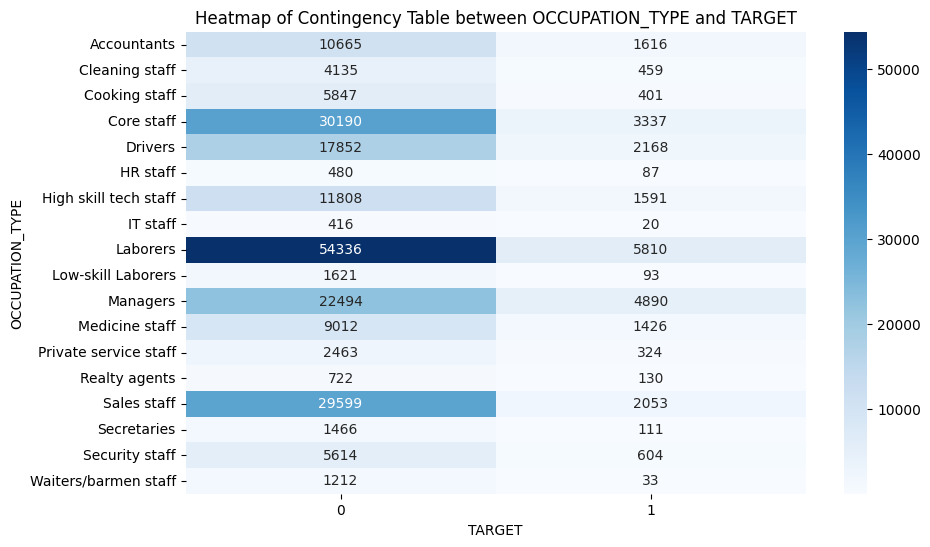


Chi-Square Statistic: 2673.158755213424
P-Value: 0.0
Degrees of Freedom: 17
Expected Frequencies: 
[[1.09669902e+04 1.31400980e+03]
 [4.10246340e+03 4.91536602e+02]
 [5.57949310e+03 6.68506898e+02]
 [2.99397672e+04 3.58723283e+03]
 [1.78779533e+04 2.14204675e+03]
 [5.06333641e+02 6.06663590e+01]
 [1.19653694e+04 1.43363059e+03]
 [3.89350031e+02 4.66499692e+01]
 [5.37106582e+04 6.43534185e+03]
 [1.53060998e+03 1.83390016e+02]
 [2.44540396e+04 2.92996045e+03]
 [9.32118262e+03 1.11681738e+03]
 [2.48880398e+03 2.98196018e+02]
 [7.60839969e+02 9.11600315e+01]
 [2.82653834e+04 3.38661657e+03]
 [1.40826835e+03 1.68731655e+02]
 [5.55270296e+03 6.65297037e+02]
 [1.11179080e+03 1.33209201e+02]]


(TARGET                     0     1
 OCCUPATION_TYPE                   
 Accountants            10665  1616
 Cleaning staff          4135   459
 Cooking staff           5847   401
 Core staff             30190  3337
 Drivers                17852  2168
 HR staff                 480    87
 High skill tech staff  11808  1591
 IT staff                 416    20
 Laborers               54336  5810
 Low-skill Laborers      1621    93
 Managers               22494  4890
 Medicine staff          9012  1426
 Private service staff   2463   324
 Realty agents            722   130
 Sales staff            29599  2053
 Secretaries             1466   111
 Security staff          5614   604
 Waiters/barmen staff    1212    33,
 np.float64(2673.158755213424),
 np.float64(0.0),
 17,
 array([[1.09669902e+04, 1.31400980e+03],
        [4.10246340e+03, 4.91536602e+02],
        [5.57949310e+03, 6.68506898e+02],
        [2.99397672e+04, 3.58723283e+03],
        [1.78779533e+04, 2.14204675e+03],
        [5.063

In [ ]:
bivariate_cat_cat(df_raw, 'OCCUPATION_TYPE', 'TARGET')

Interpretation

- Significant Association: The chi-square statistic of 2673.158755213424 and the p-value of 0.0 indicate a highly significant relationship between OCCUPATION_TYPE and TARGET. This suggests that occupation type (OCCUPATION_TYPE) is strongly associated with the value of TARGET.

- Deviation from Expected Frequencies: The large chi-square statistic confirms that the observed frequencies deviate significantly from the expected frequencies. This reinforces the idea that there is an association between the variables.

- Practical Implications: The significant association between occupation type (OCCUPATION_TYPE) and the target variable (TARGET) suggests that occupation type may be an important factor in predicting or understanding the target variable.

Summary: The analysis indicates a very strong and significant relationship between occupation type and the target variable.

### NAME_EDUCATION_TYPE - TARGET

Contingency Table:
TARGET                              0      1
NAME_EDUCATION_TYPE                         
Academic degree                   200     32
Higher education                81616   9446
Incomplete higher               10725    662
Lower secondary                  3055    122
Secondary / secondary special  213108  19460


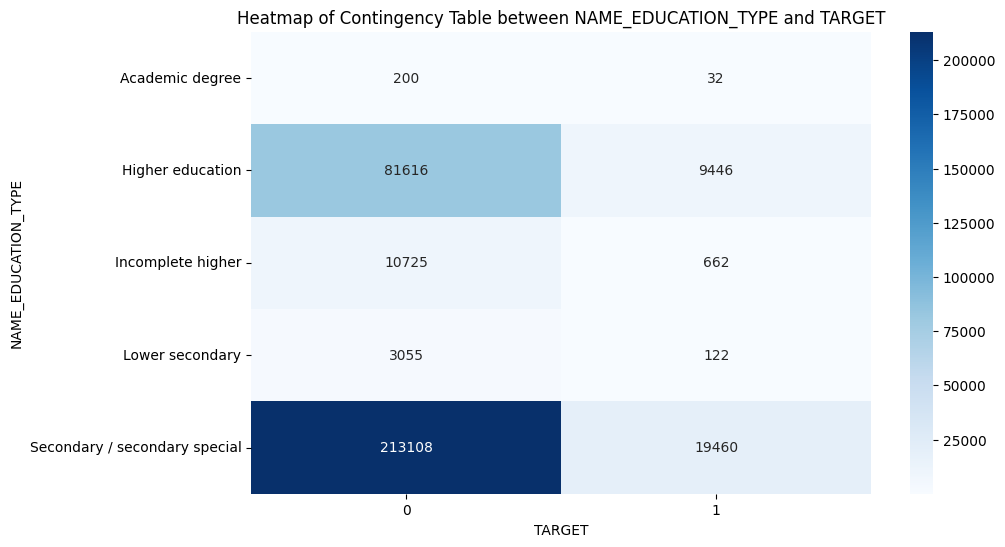


Chi-Square Statistic: 567.0418114349789
P-Value: 2.101596445311851e-121
Degrees of Freedom: 4
Expected Frequencies: 
[[2.11624781e+02 2.03752194e+01]
 [8.30645507e+04 7.99744926e+03]
 [1.03869456e+04 1.00005441e+03]
 [2.89798245e+03 2.79017552e+02]
 [2.12142896e+05 2.04251036e+04]]


(TARGET                              0      1
 NAME_EDUCATION_TYPE                         
 Academic degree                   200     32
 Higher education                81616   9446
 Incomplete higher               10725    662
 Lower secondary                  3055    122
 Secondary / secondary special  213108  19460,
 np.float64(567.0418114349789),
 np.float64(2.101596445311851e-121),
 4,
 array([[2.11624781e+02, 2.03752194e+01],
        [8.30645507e+04, 7.99744926e+03],
        [1.03869456e+04, 1.00005441e+03],
        [2.89798245e+03, 2.79017552e+02],
        [2.12142896e+05, 2.04251036e+04]]))

In [ ]:
bivariate_cat_cat(df_raw, 'NAME_EDUCATION_TYPE', 'TARGET')

Interpretation

- Significant Association: The chi-square statistic of 567.0418114349789 and the extremely low p-value of 2.101596445311851e-121 indicate a highly significant relationship between NAME_EDUCATION_TYPE and TARGET. This suggests that the level of education (NAME_EDUCATION_TYPE) is strongly associated with the value of TARGET.

- Deviation from Expected Frequencies: The large chi-square statistic confirms that the observed frequencies deviate significantly from the expected frequencies. This reinforces the idea that there is a strong association between the variables.

- Practical Implications: The significant relationship between the type of education (NAME_EDUCATION_TYPE) and the target variable (TARGET) suggests that the level of education may be an important factor in predicting or understanding the target variable.

Summary: The analysis indicates a very strong and significant relationship between the type of education and the target variable. This suggests that the type of education is a crucial factor to consider.

### CNT_CHILDREN - TARGET

Descriptive Statistics by Group:
           count  mean  std  min  25%  50%  75%   max
TARGET                                               
0      308704.00  0.45 0.74 0.00 0.00 0.00 1.00 19.00
1       29722.00  0.21 0.54 0.00 0.00 0.00 0.00 14.00


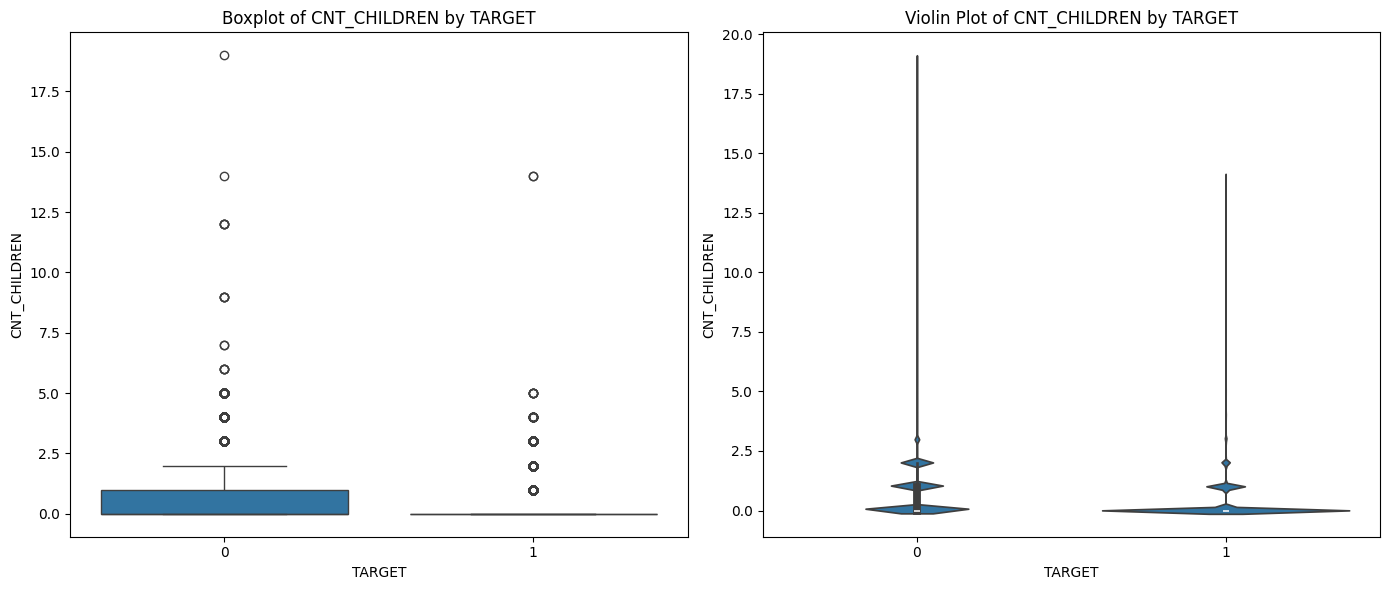

T-Test Results:
T-Statistic: 69.408269008193
P-Value: 0.0

Mann-Whitney U Test Results:
U-Statistic: 5313785329.5
P-Value: 0.0


(           count  mean  std  min  25%  50%  75%   max
 TARGET                                               
 0      308704.00  0.45 0.74 0.00 0.00 0.00 1.00 19.00
 1       29722.00  0.21 0.54 0.00 0.00 0.00 0.00 14.00,
 np.float64(69.408269008193),
 np.float64(0.0),
 np.float64(5313785329.5),
 np.float64(0.0))

In [ ]:
bivariate_analysis_num_cat(df_raw, 'CNT_CHILDREN', 'TARGET')

Overall Interpretation

- Difference between Groups: The test results indicate a significant difference between the groups with TARGET=0 and TARGET=1 in relation to the number of children (CNT_CHILDREN).
The mean for TARGET=0 is higher (0.45) than that for TARGET=1 (0.21), suggesting that, on average, people with TARGET=0 have more children than those with TARGET=1.

- Normality Test: The T-test assumes that the data follow a normal distribution, but since the results are highly significant in both tests, the observed difference is consistent even when considering the non-normality of the data, as confirmed by the Mann-Whitney test, which does not require the assumption of normality.

Conclusions: The tests suggest that there is a significant difference in the number of children between the two groups defined by TARGET. On average, observations with TARGET=0 tend to have more children than those with TARGET=1. This result is robust to both the t-test and the nonparametric Mann-Whitney test, confirming the importance of the CNT_CHILDREN variable in distinguishing between TARGET groups.

### DAYS_BIRTH_POSITIVE - TARGET

Descriptive Statistics by Group:
           count     mean     std      min      25%      50%      75%      max
TARGET                                                                        
0      308704.00 15758.73 4257.37  7489.00 12234.00 15081.00 19392.00 25201.00
1       29722.00 18486.01 1982.57 15623.00 16794.00 18243.00 19817.75 24770.00


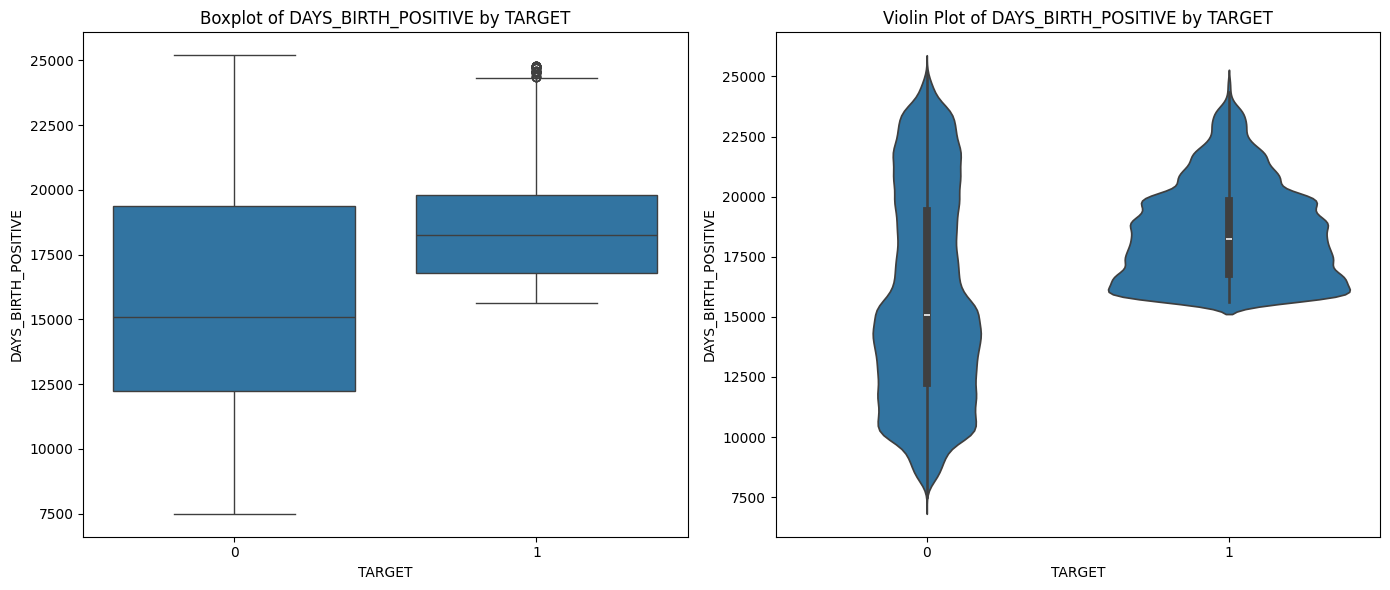

T-Test Results:
T-Statistic: -197.3611526222218
P-Value: 0.0

Mann-Whitney U Test Results:
U-Statistic: 2706934180.5
P-Value: 0.0


(           count     mean     std      min      25%      50%      75%      max
 TARGET                                                                        
 0      308704.00 15758.73 4257.37  7489.00 12234.00 15081.00 19392.00 25201.00
 1       29722.00 18486.01 1982.57 15623.00 16794.00 18243.00 19817.75 24770.00,
 np.float64(-197.3611526222218),
 np.float64(0.0),
 np.float64(2706934180.5),
 np.float64(0.0))

In [ ]:
bivariate_analysis_num_cat(df_raw, 'DAYS_BIRTH_POSITIVE', 'TARGET')

Overall Interpretation

- Difference between Groups: The results indicate a significant difference between the TARGET=0 and TARGET=1 groups regarding age (DAYS_BIRTH_POSITIVE).
People with TARGET=1 have on average more days since birth (mean of 18486.01) than those with TARGET=0 (mean of 15758.73). This suggests that the TARGET=1 group tends to be "older" than the TARGET=0 group.

- Confirmation of the Difference: Both the T-Test and the Mann-Whitney test confirm the presence of a significant difference. The T-Test shows a difference between the means, while the Mann-Whitney test confirms that the distributions of the two groups are different even when the data do not follow a normal distribution.

Conclusions: The variable DAYS_BIRTH_POSITIVE appears to be significantly different between the two groups defined by TARGET. This may indicate that time since birth is an important factor in distinguishing between the TARGET=0 and TARGET=1 groups. Test results indicate that this difference is robust and not due to chance.

### DAYS_EMPLOYED - TARGET

Descriptive Statistics by Group:
           count     mean       std       min      25%      50%      75%  \
TARGET                                                                     
0      308704.00 66485.45 143470.34 -17531.00 -2817.00 -1262.00  -283.00   
1       29722.00 -4644.77   2843.40 -16767.00 -5925.00 -3740.00 -2490.00   

             max  
TARGET            
0      365243.00  
1       -1486.00  


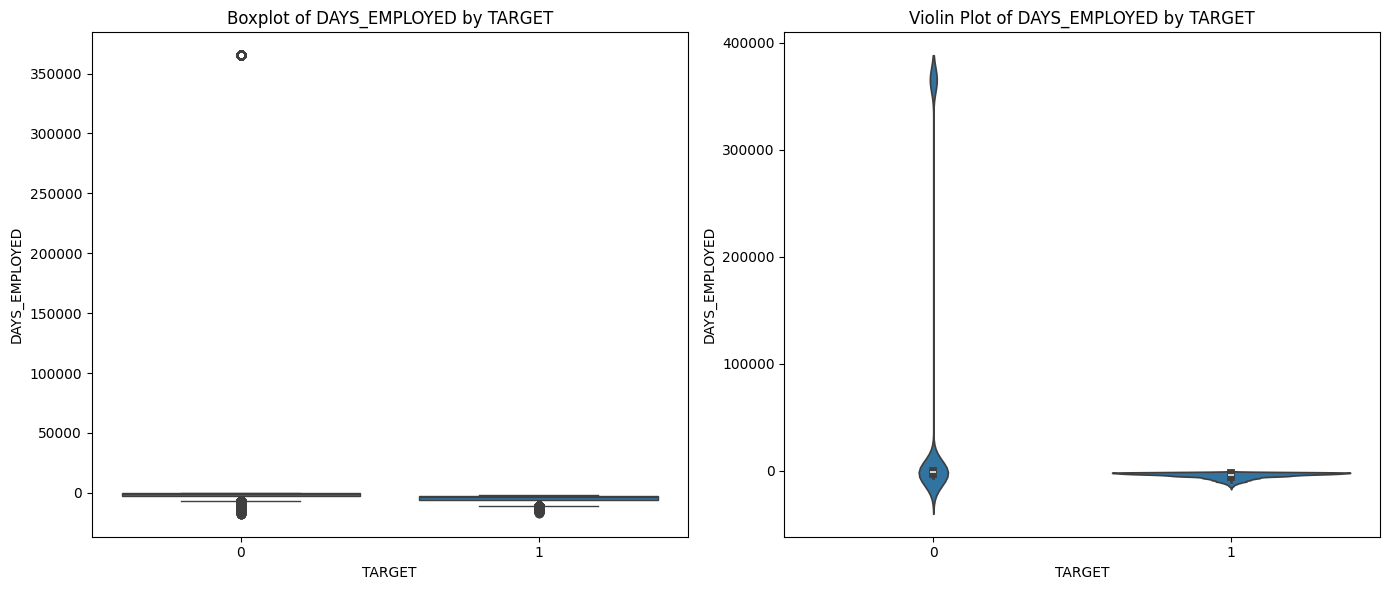

T-Test Results:
T-Statistic: 274.9027894655725
P-Value: 0.0

Mann-Whitney U Test Results:
U-Statistic: 7512676935.5
P-Value: 0.0


(           count     mean       std       min      25%      50%      75%  \
 TARGET                                                                     
 0      308704.00 66485.45 143470.34 -17531.00 -2817.00 -1262.00  -283.00   
 1       29722.00 -4644.77   2843.40 -16767.00 -5925.00 -3740.00 -2490.00   
 
              max  
 TARGET            
 0      365243.00  
 1       -1486.00  ,
 np.float64(274.9027894655725),
 np.float64(0.0),
 np.float64(7512676935.5),
 np.float64(0.0))

In [ ]:
bivariate_analysis_num_cat(df_raw, 'DAYS_EMPLOYED', 'TARGET')

Analysis to repeat after handling outliers for DAYS_EMPLOYED.

### CNT_FAM_MEMBERS - TARGET

Descriptive Statistics by Group:
           count  mean  std  min  25%  50%  75%   max
TARGET                                               
0      308704.00  2.22 0.91 1.00 2.00 2.00 3.00 20.00
1       29722.00  1.97 0.72 1.00 2.00 2.00 2.00 15.00


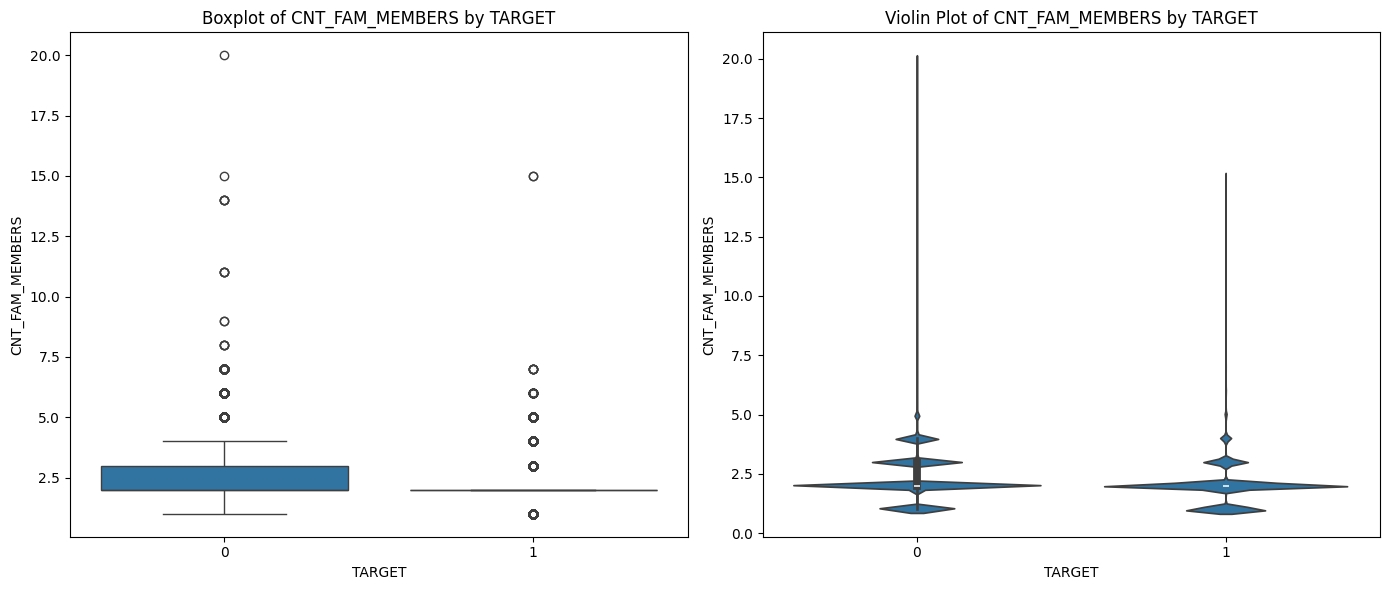

T-Test Results:
T-Statistic: 55.39237726893203
P-Value: 0.0

Mann-Whitney U Test Results:
U-Statistic: 5228090878.5
P-Value: 0.0


(           count  mean  std  min  25%  50%  75%   max
 TARGET                                               
 0      308704.00  2.22 0.91 1.00 2.00 2.00 3.00 20.00
 1       29722.00  1.97 0.72 1.00 2.00 2.00 2.00 15.00,
 np.float64(55.39237726893203),
 np.float64(0.0),
 np.float64(5228090878.5),
 np.float64(0.0))

In [ ]:
bivariate_analysis_num_cat(df_raw, 'CNT_FAM_MEMBERS', 'TARGET')

Interpretation

- Difference in means: The mean number of family members for the TARGET=0 group is 2.22, while for the TARGET=1 group it is 1.97.
This indicates that individuals with TARGET=0 tend to have slightly larger family sizes than those with TARGET=1.

- Statistical significance: Both the t-test and the Mann-Whitney U test produce highly significant p-values (0.0), suggesting that the observed difference in family size between the two groups is statistically significant.

Conclusion: The analysis shows a notable and statistically significant difference in the number of family members between the two target groups. Specifically, individuals in the TARGET=0 group have a higher mean number of family members than those in the TARGET=1 group. This difference is robust, as confirmed by both parametric and nonparametric tests.

### AMT_INCOME_TOTAL - TARGET

Descriptive Statistics by Group:
           count      mean       std       min       25%       50%       75%  \
TARGET                                                                         
0      308704.00 179948.74 105713.32  26100.00 112500.00 157500.00 225000.00   
1       29722.00 267691.70 127973.65 164250.00 202500.00 225000.00 306000.00   

              max  
TARGET             
0      6750000.00  
1      4500000.00  


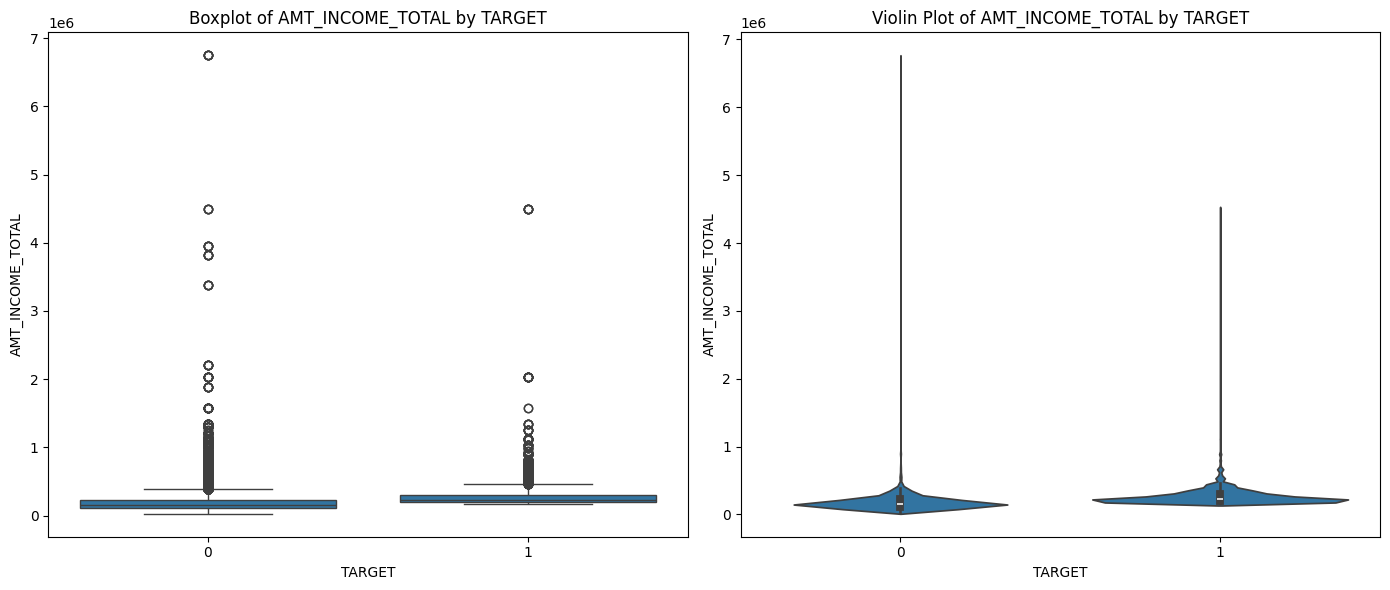

T-Test Results:
T-Statistic: -114.50213870975179
P-Value: 0.0

Mann-Whitney U Test Results:
U-Statistic: 1901861532.0
P-Value: 0.0


(           count      mean       std       min       25%       50%       75%  \
 TARGET                                                                         
 0      308704.00 179948.74 105713.32  26100.00 112500.00 157500.00 225000.00   
 1       29722.00 267691.70 127973.65 164250.00 202500.00 225000.00 306000.00   
 
               max  
 TARGET             
 0      6750000.00  
 1      4500000.00  ,
 np.float64(-114.50213870975179),
 np.float64(0.0),
 np.float64(1901861532.0),
 np.float64(0.0))

In [ ]:
bivariate_analysis_num_cat(df_raw, 'AMT_INCOME_TOTAL', 'TARGET')

Interpretation
- Difference in Means: The mean total annual income for the TARGET=0 group is 179,948.74, while for the TARGET=1 group it is 267,691.70.
This suggests that individuals in the TARGET=1 group have a significantly higher mean income than those in the TARGET=0 group.

- Statistical Significance: Both the t-test and Mann-Whitney U-test results are highly significant, with p-values ​​of 0.0. This indicates a statistically significant difference in total annual income between the two target groups.

Conclusion: The analysis reveals a substantial and statistically significant difference in total annual income between the two target groups. Individuals in the TARGET=1 group have a higher mean income than those in the TARGET=0 group. This difference is consistently supported by parametric and nonparametric tests, indicating a robust result.

## Critical issues

Based on the findings from the univariate analysis, the next steps could be as follows:

- Outlier Management: Address outliers in DAYS_EMPLOYED.
- Handling Missing Data: Address missing values, such as those in OCCUPATION_TYPE.

### Outlier Management: DAYS_EMPLOYED

In [ ]:
descriptive_statistics(df_raw, "DAYS_EMPLOYED",variables_type="discrete")


Descriptive Statistics for feature 'DAYS_EMPLOYED':

Min: -17531.00
Q1 (25th): -3116.00
Q2 Median: -1485.00
Q3 (75th): -380.00
Max: 365243.00
IQR: 2736.00
Mean: 60238.50
Mode: 365243.00
Variance: 19182015422.30
Standard Deviation: 138499.15
Range: 382774.00
Skewness: 1.75
Kurtosis: 1.06


The variable DAYS_EMPLOYED represents the number of days since employment. A positive value indicates the number of days since the individual has been unemployed.

As we can see the maximum present value is 365243 days, or 1000 years. Obviously this value is very different from the life expectancy of a human which is 125 years ([source](https://en.wikipedia.org/wiki/Maximum_life_span#:~:text=A%20theoretical%20study%20suggested%20the,been%20declining%20since%20the%201990s.)).


In [ ]:
# Maximum life span
years = 125
days_year = 365
max_days = years*days_year
max_days

45625

Now that we have identified the anomalous observations, according to the study cited as the source, let's take a look in more detail.

To do this I will use a dataframe (out_employed) which will contain all the observations that comply with the filtering rule, i.e. that the value for DAYS_EMPLOYED is greater than the maximum life span identified.

In [ ]:
out_employed = df_raw[df_raw["DAYS_EMPLOYED"] > max_days]
out_employed

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
7       5008812           F            N               Y             0   
8       5008813           F            N               Y             0   
9       5008814           F            N               Y             0   
76      5008884           F            N               Y             0   
160     5008974           F            N               Y             0   
...         ...         ...          ...             ...           ...   
338421  6392174           F            N               Y             0   
338422  6392175           F            N               Y             0   
338423  6392177           F            N               Y             0   
338424  6392178           F            N               Y             0   
338425  6392179           F            N               Y             0   

        AMT_INCOME_TOTAL NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
7              283500.00        Pensioner               Higher education   
8              283500.00        Pensioner               Higher education   
9              283500.00        Pensioner               Higher education   
76             315000.00        Pensioner  Secondary / secondary special   
160            112500.00        Pensioner  Secondary / secondary special   
...                  ...              ...                            ...   
338421         157500.00        Pensioner  Secondary / secondary special   
338422         157500.00        Pensioner  Secondary / secondary special   
338423         157500.00        Pensioner  Secondary / secondary special   
338424         157500.00        Pensioner  Secondary / secondary special   
338425         157500.00        Pensioner  Secondary / secondary special   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_EMPLOYED  FLAG_WORK_PHONE  \
7               Separated  House / apartment      365243.00             0.00   
8               Separated  House / apartment      365243.00             0.00   
9               Separated  House / apartment      365243.00             0.00   
76                  Widow  House / apartment      365243.00             0.00   
160               Married  House / apartment      365243.00             0.00   
...                   ...                ...            ...              ...   
338421            Married  House / apartment      365243.00             0.00   
338422            Married  House / apartment      365243.00             0.00   
338423            Married  House / apartment      365243.00             0.00   
338424            Married  House / apartment      365243.00             0.00   
338425            Married  House / apartment      365243.00             0.00   

        FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  TARGET  \
7             0.00        0.00             NaN             1.00       0   
8             0.00        0.00             NaN             1.00       0   
9             0.00        0.00             NaN             1.00       0   
76            0.00        0.00             NaN             1.00       0   
160           0.00        0.00             NaN             2.00       0   
...            ...         ...             ...              ...     ...   
338421        0.00        0.00             NaN             2.00       0   
338422        0.00        0.00             NaN             2.00       0   
338423        0.00        0.00             NaN             2.00       0   
338424        0.00        0.00             NaN             2.00       0   
338425        0.00        0.00             NaN             2.00       0   

        DAYS_BIRTH_POSITIVE  
7                  22464.00  
8                  22464.00  
9                  22464.00  
76                 20186.00  
160                22319.00  
...                     ...  
338421             23661.00  
338422             23661.00  
338423             23661.00  
338424             23661.00  
338425             

In [ ]:
out_employed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57841 entries, 7 to 338425
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   57841 non-null  int64  
 1   CODE_GENDER          57841 non-null  object 
 2   FLAG_OWN_CAR         57841 non-null  object 
 3   FLAG_OWN_REALTY      57841 non-null  object 
 4   CNT_CHILDREN         57841 non-null  int64  
 5   AMT_INCOME_TOTAL     57841 non-null  float64
 6   NAME_INCOME_TYPE     57841 non-null  object 
 7   NAME_EDUCATION_TYPE  57841 non-null  object 
 8   NAME_FAMILY_STATUS   57841 non-null  object 
 9   NAME_HOUSING_TYPE    57841 non-null  object 
 10  DAYS_EMPLOYED        57841 non-null  float64
 11  FLAG_WORK_PHONE      57841 non-null  float64
 12  FLAG_PHONE           57841 non-null  float64
 13  FLAG_EMAIL           57841 non-null  float64
 14  OCCUPATION_TYPE      0 non-null      object 
 15  CNT_FAM_MEMBERS      57841 non-null  flo

In [ ]:
out_employed.isna().sum()

ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_EMPLOYED              0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        57841
CNT_FAM_MEMBERS            0
TARGET                     0
DAYS_BIRTH_POSITIVE        0
dtype: int64

In [ ]:
out_employed["TARGET"].value_counts()

TARGET
0    57841
Name: count, dtype: int64

For all observations the value of the target variable is 0.

In [ ]:
out_employed["OCCUPATION_TYPE"].value_counts()

Series([], Name: count, dtype: int64)

As we can see for all existing observations the value of OCCUPATION_TYPE is NaN.

In [ ]:
out_employed["NAME_INCOME_TYPE"].value_counts()

NAME_INCOME_TYPE
Pensioner    57841
Name: count, dtype: int64

As we can see, 100% are pensioners.

In [ ]:
df_raw["NAME_INCOME_TYPE"].value_counts()

NAME_INCOME_TYPE
Working                 174365
Commercial associate     78090
Pensioner                57841
State servant            28113
Student                     17
Name: count, dtype: int64

All observations identified as Pensioners have a value for DAYS_EMPLOYED greater than "Maximum life span", therefore if I proceed with deleting these observations I also lose information on NAME_INCOME_TYPE.

In [ ]:
out_employed["DAYS_BIRTH_POSITIVE"].describe()

count   57841.00
mean    21716.32
std      1852.23
min      8145.00
25%     20795.00
50%     21916.00
75%     22989.00
max     25201.00
Name: DAYS_BIRTH_POSITIVE, dtype: float64

- Average Age of Pensioners:
    - The mean of DAYS_BIRTH_POSITIVE is 21716.32 days, which corresponds to about 59.5 years. This suggests that most pensioners in the dataset are around 60 years old, aligning with typical retirement ages in many countries.

- Age Distribution:
    - The standard deviation of 1852.23 days (about 5.1 years) indicates some variability in the ages of pensioners, but most observations are clustered around the mean.
    - The interquartile range (IQR), from 20795 days (about 57 years) to 22989 days (about 63 years), shows that the central 50% of pensioners are between 57 and 63 years old.
- Young Pensioners:

    - The minimum age recorded is 8145 days (about 22.3 years), which is unusually low for a pensioner. This might indicate data entry errors or special cases such as early retirement due to disability or other reasons.

- Older Pensioners:
    - The maximum age recorded is 25201 days (about 69 years), which is plausible and falls within the range of delayed retirement ages.

#### Summary (outliers DAYS_EMPLOYED)

The variable DAYS_EMPLOYED represents the number of days since employment, with a positive value indicating the number of days since the individual has been unemployed. The maximum present value is 365,243 days (about 1,000 years), which is clearly beyond human life expectancy of 125 years.

Given the identification of these anomalous observations, let's delve deeper into the details using a dataframe (out_employed) containing all observations where DAYS_EMPLOYED exceeds the maximum human lifespan. Notably, for all such observations, the value of OCCUPATION_TYPE is NaN, and 100% are identified as Pensioners. Removing these observations would result in losing valuable information on NAME_INCOME_TYPE.

I decided not to delete observations with a DAYS_EMPLOYED value greater than "Maximum life span". Since all these observations have NAME_INCOME_TYPE as Retired, I will transform the value of DAYS_EMPLOYED making the data more consistent.

In [ ]:
# Maximum life span
max_days

45625

In [ ]:
df_update = df_raw.copy()

# Verifica che ci siano righe con NAME_INCOME_TYPE == 'Pensioner'
pensioner_mask = df_update['NAME_INCOME_TYPE'] == 'Pensioner'
if not pensioner_mask.any():
    raise ValueError("Non ci sono righe con NAME_INCOME_TYPE uguale a 'Pensioner'.")

# Calcolare la mediana di DAYS_BIRTH_POSITIVE per i Pensioners, escludendo i NaN
median_days_birth_positive = df_update.loc[pensioner_mask, 'DAYS_BIRTH_POSITIVE'].median() # or median_days_birth_positive = df_update.loc[pensioner_mask, 'DAYS_BIRTH_POSITIVE'].dropna().median()

# Filtrare i dati
mask = (df_update['DAYS_EMPLOYED'] > max_days) & pensioner_mask

# Applicare le modifiche a DAYS_EMPLOYED
df_update.loc[mask, 'DAYS_EMPLOYED'] = df_update.loc[mask, 'DAYS_BIRTH_POSITIVE'].apply(
    lambda x: x - median_days_birth_positive if x > median_days_birth_positive else 0
)

# Cambiare i valori di OCCUPATION_TYPE per queste osservazioni
df_update.loc[mask, 'OCCUPATION_TYPE'] = 'unemployed'

# Verifica delle modifiche
df_update

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0       5008804           M            Y               Y             0   
1       5008805           M            Y               Y             0   
2       5008806           M            Y               Y             0   
3       5008808           F            N               Y             0   
4       5008809           F            N               Y             0   
...         ...         ...          ...             ...           ...   
338421  6392174           F            N               Y             0   
338422  6392175           F            N               Y             0   
338423  6392177           F            N               Y             0   
338424  6392178           F            N               Y             0   
338425  6392179           F            N               Y             0   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0              427500.00               Working               Higher education   
1              427500.00               Working               Higher education   
2              112500.00               Working  Secondary / secondary special   
3              270000.00  Commercial associate  Secondary / secondary special   
4              270000.00  Commercial associate  Secondary / secondary special   
...                  ...                   ...                            ...   
338421         157500.00             Pensioner  Secondary / secondary special   
338422         157500.00             Pensioner  Secondary / secondary special   
338423         157500.00             Pensioner  Secondary / secondary special   
338424         157500.00             Pensioner  Secondary / secondary special   
338425         157500.00             Pensioner  Secondary / secondary special   

          NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_EMPLOYED  \
0             Civil marriage   Rented apartment       -4542.00   
1             Civil marriage   Rented apartment       -4542.00   
2                    Married  House / apartment       -1134.00   
3       Single / not married  House / apartment       -3051.00   
4       Single / not married  House / apartment       -3051.00   
...                      ...                ...            ...   
338421               Married  House / apartment        1745.00   
338422               Married  House / apartment        1745.00   
338423               Married  House / apartment        1745.00   
338424               Married  House / apartment        1745.00   
338425               Married  House / apartment        1745.00   

        FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0                  1.00        0.00        0.00             NaN   
1                  1.00        0.00        0.00             NaN   
2                  0.00        0.00        0.00  Security staff   
3                  0.00        1.00        1.00     Sales staff   
4                  0.00        1.00        1.00     Sales staff   
...                 ...         ...         ...             ...   
338421             0.00        0.00        0.00      unemployed   
338422             0.00        0.00        0.00      unemployed   
338423             0.00        0.00        0.00      unemployed   
338424             0.00        0.00        0.00      unemployed   
338425             0.00        0.00        0.00      unemployed   

        CNT_FAM_MEMBERS  TARGET  DAYS_BIRTH_POSITIVE  
0                  2.00       0             12005.00  
1                  2.00       0             12005.00  
2                  2.00       0             21474.00  
3                  1.00       1             19110.00  
4                  1.00       1             19110.00  
...                 ...     ...                  ...  
338421             2.00       0             23661.00  
338422             2.00       0             23661.00  
338423             2.00       0             23661.00  
338

The goal is to handle unrealistic values in DAYS_EMPLOYED by assuming that the retirement age is the median of DAYS_BIRTH_POSITIVE for observations with NAME_INCOME_TYPE equal to 'Pensioner'.

We identify all observations with a DAYS_EMPLOYED value greater than max_days and a NAME_INCOME_TYPE equal to 'Pensioner'.

We then apply the following transformation:

- If DAYS_BIRTH_POSITIVE (age in days) is greater than the median of the (retirement) age, DAYS_EMPLOYED is set to the difference between DAYS_BIRTH_POSITIVE and the median, thus more consistently indicating retirement days.

- If DAYS_BIRTH_POSITIVE is less than or equal to the median, DAYS_EMPLOYED is set to 0, assuming that the person has just retired.

For these same observations, OCCUPATION_TYPE is set to 'unemployed'.

In [ ]:
df_update[df_update['OCCUPATION_TYPE'] == 'unemployed']

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
7       5008812           F            N               Y             0   
8       5008813           F            N               Y             0   
9       5008814           F            N               Y             0   
76      5008884           F            N               Y             0   
160     5008974           F            N               Y             0   
...         ...         ...          ...             ...           ...   
338421  6392174           F            N               Y             0   
338422  6392175           F            N               Y             0   
338423  6392177           F            N               Y             0   
338424  6392178           F            N               Y             0   
338425  6392179           F            N               Y             0   

        AMT_INCOME_TOTAL NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
7              283500.00        Pensioner               Higher education   
8              283500.00        Pensioner               Higher education   
9              283500.00        Pensioner               Higher education   
76             315000.00        Pensioner  Secondary / secondary special   
160            112500.00        Pensioner  Secondary / secondary special   
...                  ...              ...                            ...   
338421         157500.00        Pensioner  Secondary / secondary special   
338422         157500.00        Pensioner  Secondary / secondary special   
338423         157500.00        Pensioner  Secondary / secondary special   
338424         157500.00        Pensioner  Secondary / secondary special   
338425         157500.00        Pensioner  Secondary / secondary special   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_EMPLOYED  FLAG_WORK_PHONE  \
7               Separated  House / apartment         548.00             0.00   
8               Separated  House / apartment         548.00             0.00   
9               Separated  House / apartment         548.00             0.00   
76                  Widow  House / apartment           0.00             0.00   
160               Married  House / apartment         403.00             0.00   
...                   ...                ...            ...              ...   
338421            Married  House / apartment        1745.00             0.00   
338422            Married  House / apartment        1745.00             0.00   
338423            Married  House / apartment        1745.00             0.00   
338424            Married  House / apartment        1745.00             0.00   
338425            Married  House / apartment        1745.00             0.00   

        FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  TARGET  \
7             0.00        0.00      unemployed             1.00       0   
8             0.00        0.00      unemployed             1.00       0   
9             0.00        0.00      unemployed             1.00       0   
76            0.00        0.00      unemployed             1.00       0   
160           0.00        0.00      unemployed             2.00       0   
...            ...         ...             ...              ...     ...   
338421        0.00        0.00      unemployed             2.00       0   
338422        0.00        0.00      unemployed             2.00       0   
338423        0.00        0.00      unemployed             2.00       0   
338424        0.00        0.00      unemployed             2.00       0   
338425        0.00        0.00      unemployed             2.00       0   

        DAYS_BIRTH_POSITIVE  
7                  22464.00  
8                  22464.00  
9                  22464.00  
76                 20186.00  
160                22319.00  
...                     ...  
338421             23661.00  
338422             23661.00  
338423             23661.00  
338424             23661.00  
338425             

In [ ]:
df_update.shape

(338426, 18)

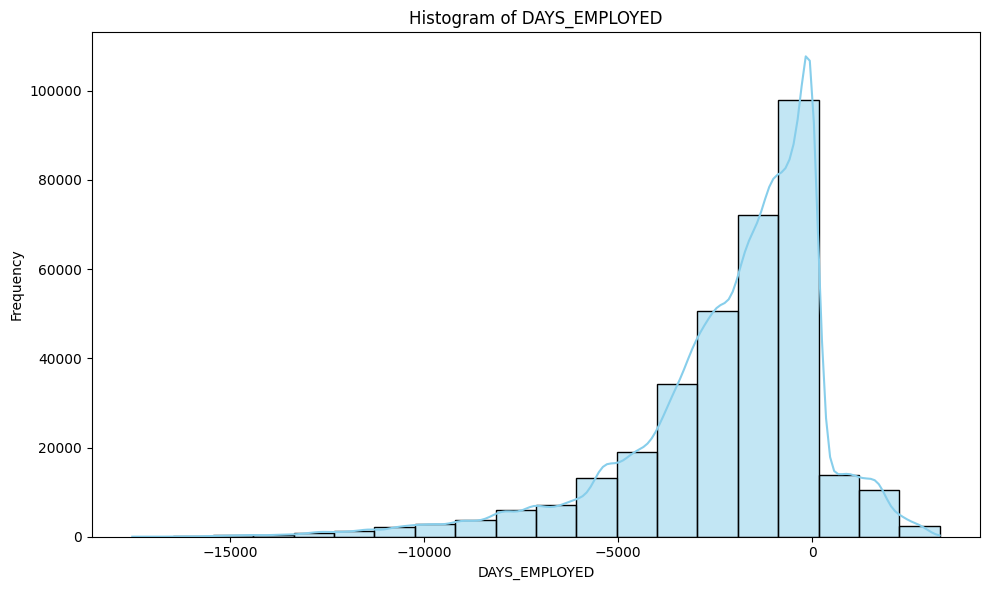


Descriptive Statistics for feature 'DAYS_EMPLOYED':

Min: -17531.00
Q1 (25th): -3116.00
Q2 Median: -1485.00
Q3 (75th): -380.00
Max: 3285.00
IQR: 2736.00
Mean: -2088.26
Mode: 0.00
Variance: 6376712.09
Standard Deviation: 2525.22
Range: 20816.00
Skewness: -1.52
Kurtosis: 3.29


In [ ]:
plot_continuous(df_update, "DAYS_EMPLOYED", plot_type="hist")
descriptive_statistics(df_update, "DAYS_EMPLOYED",variables_type="discrete")

### DAYS_EMPLOYED - TARGET (Bivariate Analysis)

Descriptive Statistics by Group:
           count     mean     std       min      25%      50%      75%  \
TARGET                                                                   
0      308704.00 -1842.12 2349.98 -17531.00 -2817.00 -1262.00  -283.00   
1       29722.00 -4644.77 2843.40 -16767.00 -5925.00 -3740.00 -2490.00   

            max  
TARGET           
0       3285.00  
1      -1486.00  


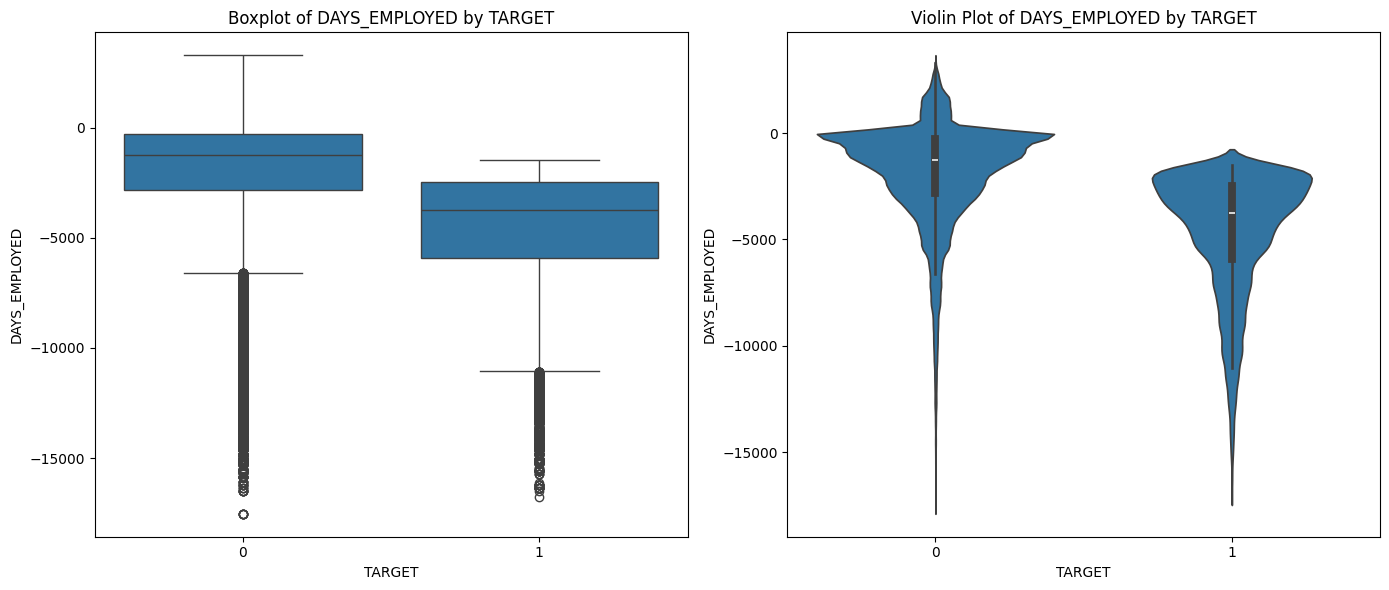

T-Test Results:
T-Statistic: 164.60419713837285
P-Value: 0.0

Mann-Whitney U Test Results:
U-Statistic: 7512676935.5
P-Value: 0.0


(           count     mean     std       min      25%      50%      75%  \
 TARGET                                                                   
 0      308704.00 -1842.12 2349.98 -17531.00 -2817.00 -1262.00  -283.00   
 1       29722.00 -4644.77 2843.40 -16767.00 -5925.00 -3740.00 -2490.00   
 
             max  
 TARGET           
 0       3285.00  
 1      -1486.00  ,
 np.float64(164.60419713837285),
 np.float64(0.0),
 np.float64(7512676935.5),
 np.float64(0.0))

In [ ]:
bivariate_analysis_num_cat(df_update, 'DAYS_EMPLOYED', 'TARGET')

Interpretations

- Difference between Groups: The results indicate a significant difference between the TARGET=0 and TARGET=1 groups for the DAYS_EMPLOYED variable. In particular, the TARGET=0 group has a lower average of days (less negative) than the TARGET=1 group, they have been working for less time.

- Confirmation of the Difference: Both the T-Test and the Mann-Whitney test confirm that the observed difference is statistically significant. This suggests that the TARGET=1 group has on average more days of employment than the TARGET=0 group.

Implications: These results indicate that the number of days of employment is an important and different indicator between the TARGET=0 and TARGET=1 groups.

### Handling Missing Data: OCCUPATION_TYPE

In [ ]:
# NaN values in df_filtered (after fixing the issues for DAYS_EMPLOYED)
occup_nan_filtered = df_update["OCCUPATION_TYPE"].isna().sum()
occup_nan_filtered

np.int64(45500)

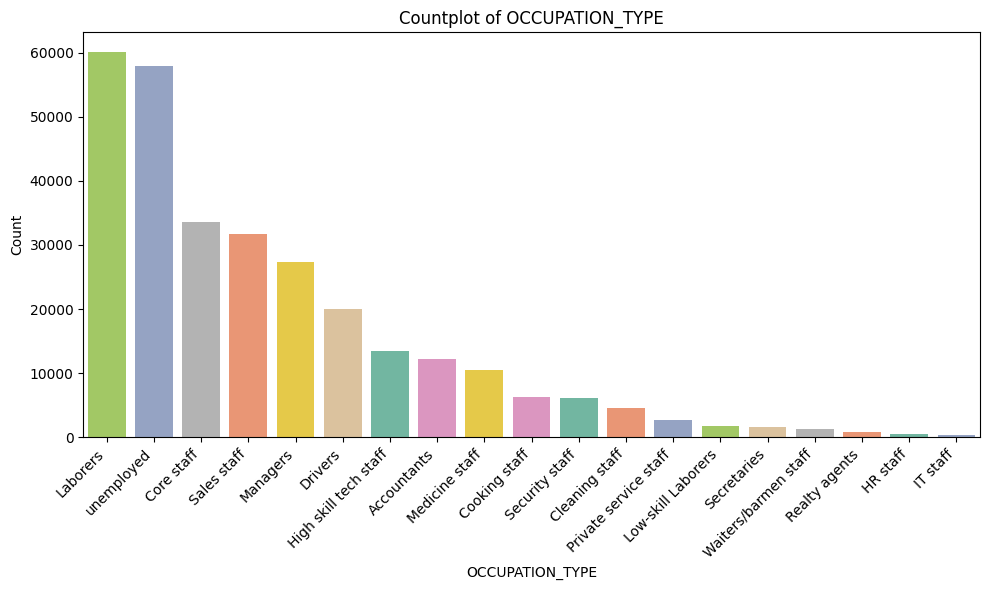


Summary Statistics for feature 'OCCUPATION_TYPE':

             Category  Frequency Percentage
             Laborers      60146     17.77%
           unemployed      57841     17.09%
                  NaN      45500     13.44%
           Core staff      33527      9.91%
          Sales staff      31652      9.35%
             Managers      27384      8.09%
              Drivers      20020      5.92%
High skill tech staff      13399      3.96%
          Accountants      12281      3.63%
       Medicine staff      10438      3.08%
        Cooking staff       6248      1.85%
       Security staff       6218      1.84%
       Cleaning staff       4594      1.36%
Private service staff       2787      0.82%
   Low-skill Laborers       1714      0.51%
          Secretaries       1577      0.47%
 Waiters/barmen staff       1245      0.37%
        Realty agents        852      0.25%
             HR staff        567      0.17%
             IT staff        436      0.13%

Additional Information:

In [ ]:
countplot_categorical(df_update, "OCCUPATION_TYPE")
descriptive_statistics(df_update, "OCCUPATION_TYPE", variables_type='nominal')

As we can see we have 45500 observations that have NaN in 'OCCUPATION_TYPE'.

It may be beneficial to examine other variables in the dataset that may be associated with employment. For example, the feature 'DAYS_EMPLOYED' represents the number of days that have passed since the hiring date, if positive it indicates the number of days since you have been unemployed.

#### DAYS_EMPLOYED where OCCUPATION_TYPE is NaN

In [ ]:
nan_occupation = df_update[df_update["OCCUPATION_TYPE"].isna()]
nan_occupation

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0       5008804           M            Y               Y             0   
1       5008805           M            Y               Y             0   
24      5008834           F            N               Y             1   
25      5008835           F            N               Y             1   
26      6153712           F            N               Y             1   
...         ...         ...          ...             ...           ...   
338356  6392074           F            N               N             0   
338357  6392075           F            N               N             0   
338358  6392076           F            N               N             0   
338359  6392077           F            N               N             0   
338360  6392078           F            N               N             0   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0              427500.00               Working               Higher education   
1              427500.00               Working               Higher education   
24             112500.00               Working  Secondary / secondary special   
25             112500.00               Working  Secondary / secondary special   
26             112500.00               Working  Secondary / secondary special   
...                  ...                   ...                            ...   
338356         135000.00  Commercial associate  Secondary / secondary special   
338357         135000.00  Commercial associate  Secondary / secondary special   
338358         135000.00  Commercial associate  Secondary / secondary special   
338359         135000.00  Commercial associate  Secondary / secondary special   
338360         135000.00  Commercial associate  Secondary / secondary special   

          NAME_FAMILY_STATUS    NAME_HOUSING_TYPE  DAYS_EMPLOYED  \
0             Civil marriage     Rented apartment       -4542.00   
1             Civil marriage     Rented apartment       -4542.00   
24      Single / not married    House / apartment       -1620.00   
25      Single / not married    House / apartment       -1620.00   
26      Single / not married    House / apartment       -1620.00   
...                      ...                  ...            ...   
338356               Married  Municipal apartment       -7108.00   
338357               Married  Municipal apartment       -7108.00   
338358               Married  Municipal apartment       -7108.00   
338359               Married  Municipal apartment       -7108.00   
338360               Married  Municipal apartment       -7108.00   

        FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0                  1.00        0.00        0.00             NaN   
1                  1.00        0.00        0.00             NaN   
24                 0.00        0.00        0.00             NaN   
25                 0.00        0.00        0.00             NaN   
26                 0.00        0.00        0.00             NaN   
...                 ...         ...         ...             ...   
338356             0.00        1.00        1.00             NaN   
338357             0.00        1.00        1.00             NaN   
338358             0.00        1.00        1.00             NaN   
338359             0.00        1.00        1.00             NaN   
338360             0.00        1.00        1.00             NaN   

        CNT_FAM_MEMBERS  TARGET  DAYS_BIRTH_POSITIVE  
0                  2.00       0             12005.00  
1                  2.00       0             12005.00  
24                 2.00       0             10968.00  
25                 2.00       0             10968.00  
26                 2.00       0             10968.00  
...                 ...     ...                  ...  
338356             2.00       0             17544.00  
338357             2.00       0             17544.00  
338358             2.00       0   

In [ ]:
plot_continuous(nan_occupation, "DAYS_EMPLOYED", plot_type="hist")
descriptive_statistics(nan_occupation, "DAYS_EMPLOYED", variables_type="discrete")


Descriptive Statistics for feature 'DAYS_EMPLOYED':

Min: -16365.00
Q1 (25th): -3548.00
Q2 Median: -2003.50
Q3 (75th): -898.00
Max: -22.00
IQR: 2650.00
Mean: -2640.60
Mode: -302.00
Variance: 5816020.52
Standard Deviation: 2411.64
Range: 16343.00
Skewness: -1.80
Kurtosis: 4.10


As we can see, all people who have a NaN value in OCCUPATION_TYPE have a negative value in DAYS_EMPLOYED, which means they are currently employed.

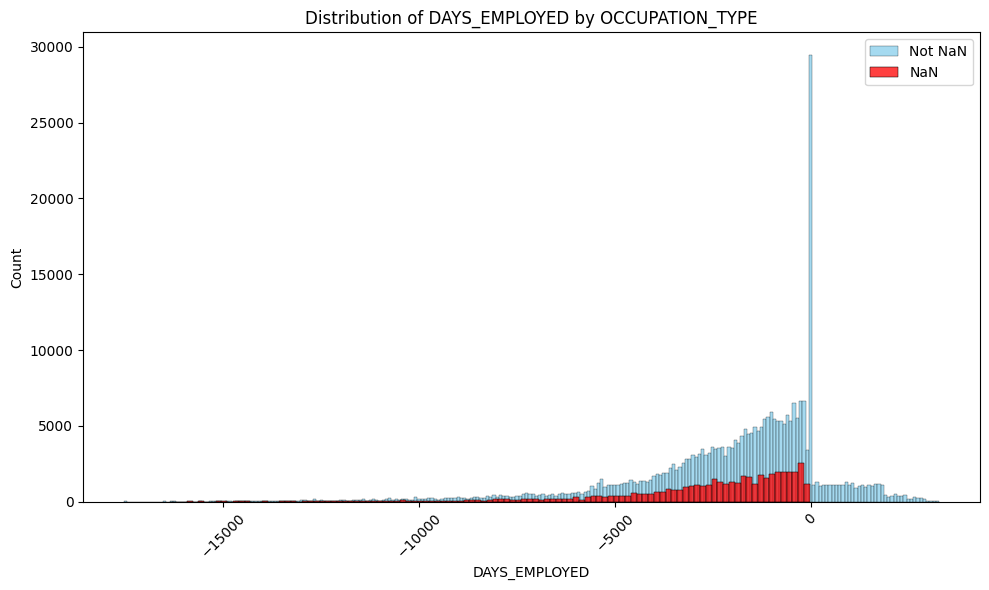

In [ ]:
compare_feature_by_nan(df_update, "DAYS_EMPLOYED", "OCCUPATION_TYPE")

#### NAME_INCOME_TYPE where OCCUPATION_TYPE is NaN

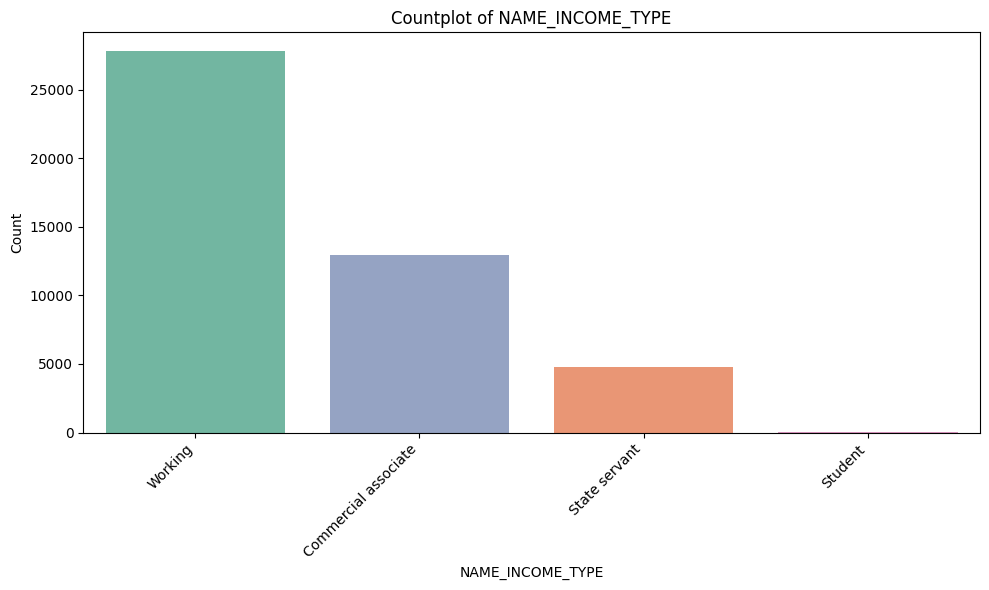


Summary Statistics for feature 'NAME_INCOME_TYPE':

            Category  Frequency Percentage
             Working      27783     61.06%
Commercial associate      12927     28.41%
       State servant       4785     10.52%
             Student          5      0.01%

Additional Information:
Unique Values Count: 4
Mode: Working


In [ ]:
countplot_categorical(nan_occupation, "NAME_INCOME_TYPE")
descriptive_statistics(nan_occupation, "NAME_INCOME_TYPE", variables_type='nominal')

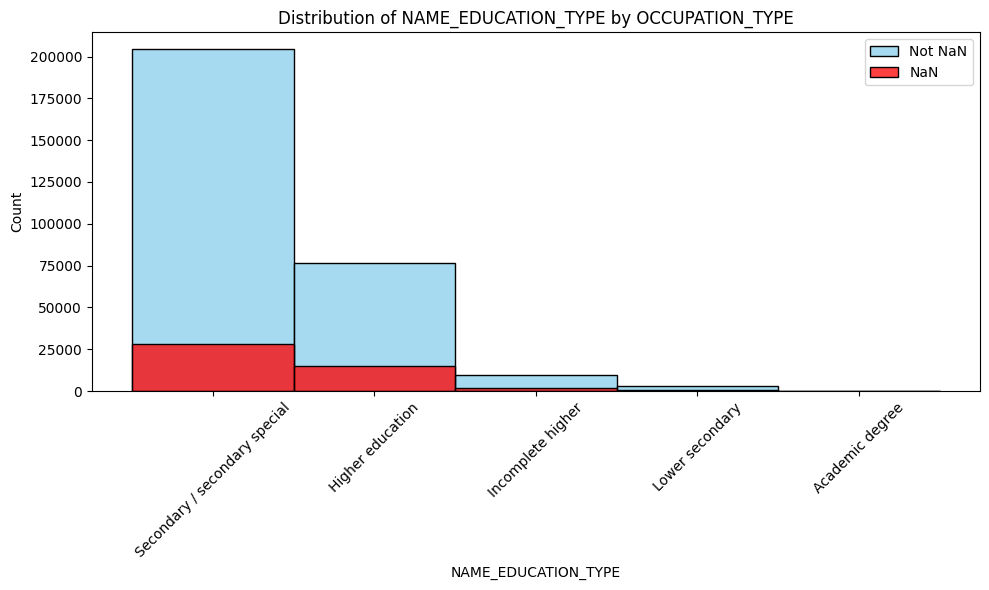

In [ ]:
compare_feature_by_nan(df_update, "NAME_EDUCATION_TYPE", "OCCUPATION_TYPE")

#### CODE_GENDER where OCCUPATION_TYPE is NaN

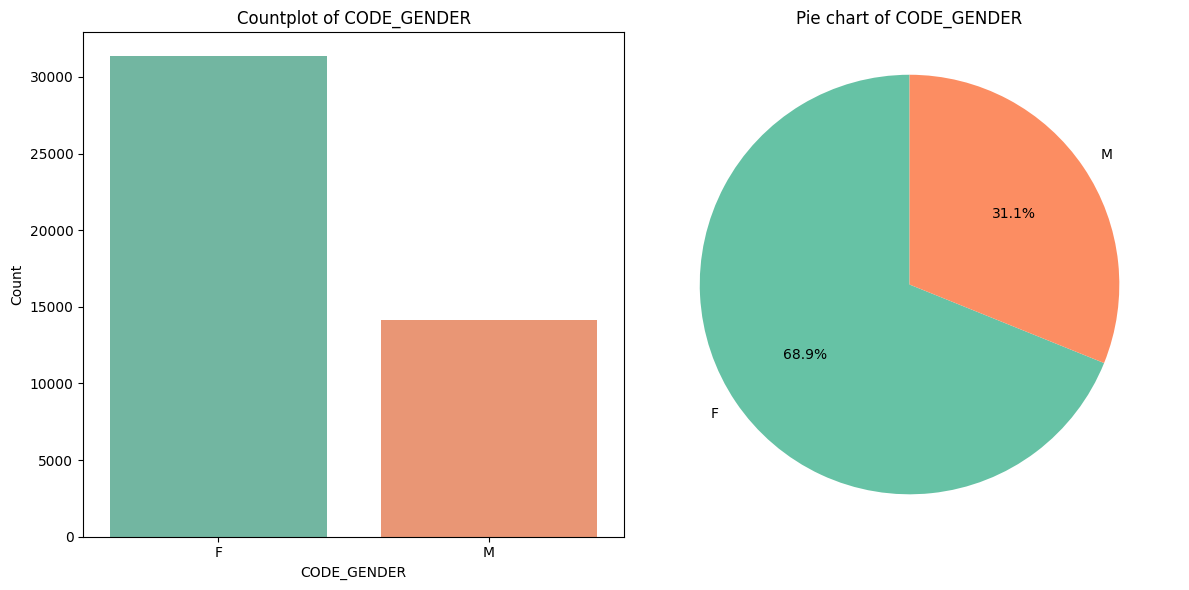


Summary Statistics for feature 'CODE_GENDER':

Category  Frequency Percentage
       F      31347     68.89%
       M      14153     31.11%

Additional Information:
Unique Values Count: 2
Mode: F


In [ ]:
plots_binary(nan_occupation, "CODE_GENDER")
descriptive_statistics(nan_occupation, "CODE_GENDER", variables_type="binary")

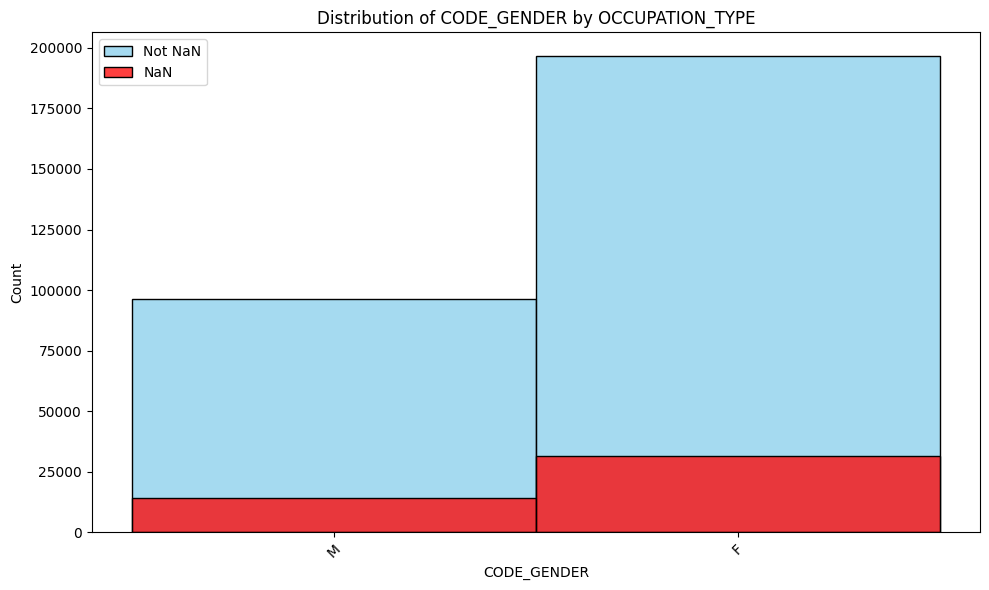

In [ ]:
compare_feature_by_nan(df_update, "CODE_GENDER", "OCCUPATION_TYPE")

#### FLAG_OWN_CAR where OCCUPATION_TYPE is NaN

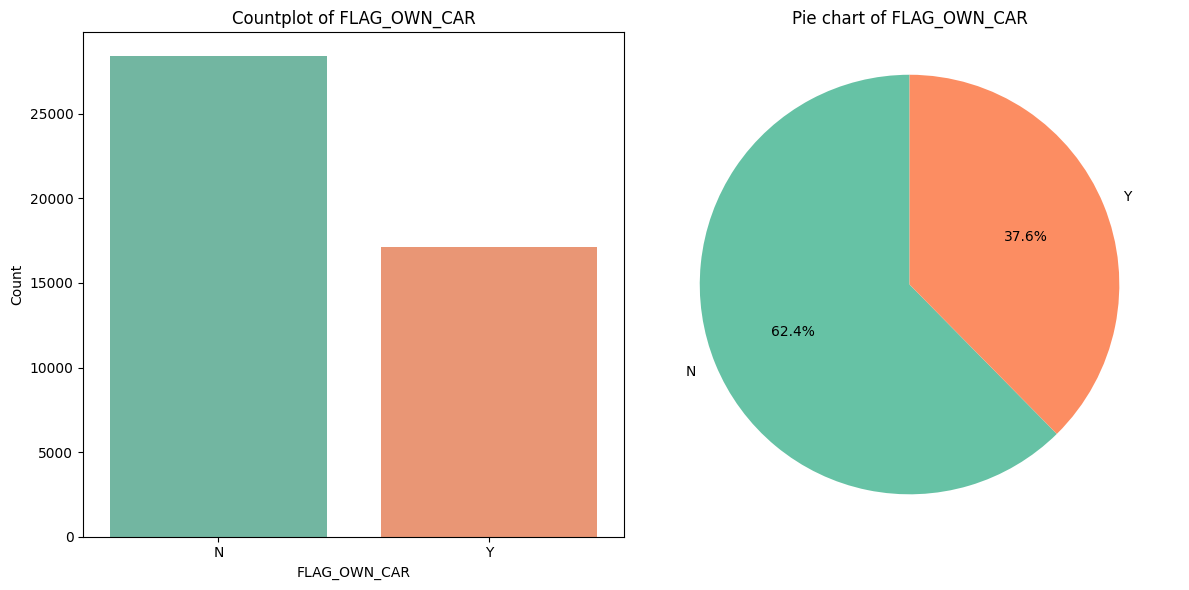


Summary Statistics for feature 'FLAG_OWN_CAR':

Category  Frequency Percentage
       N      28387     62.39%
       Y      17113     37.61%

Additional Information:
Unique Values Count: 2
Mode: N


In [ ]:
plots_binary(nan_occupation, "FLAG_OWN_CAR")
descriptive_statistics(nan_occupation, "FLAG_OWN_CAR", variables_type="binary")

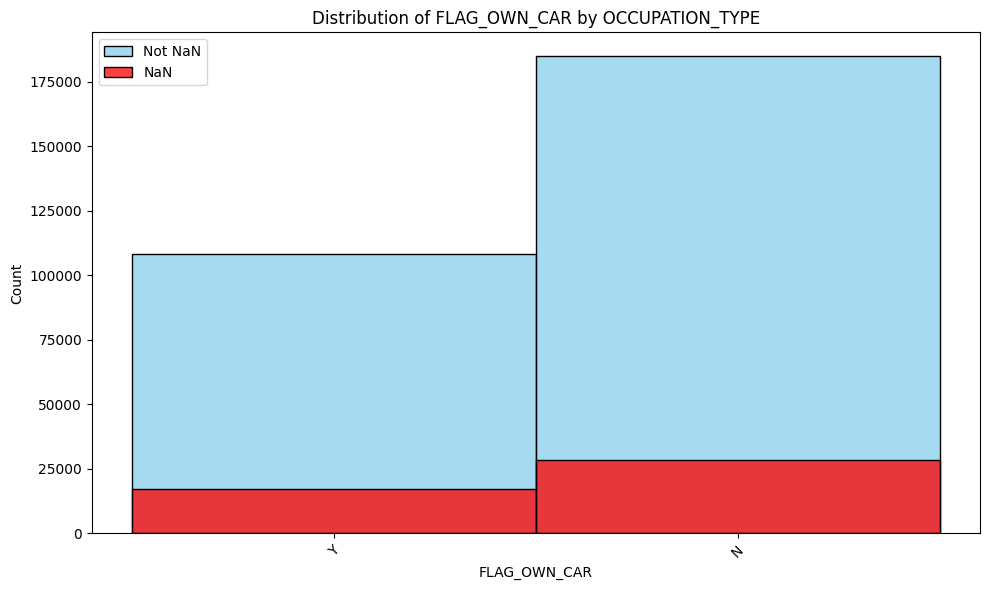

In [ ]:
compare_feature_by_nan(df_update, "FLAG_OWN_CAR", "OCCUPATION_TYPE")

#### FLAG_OWN_REALTY where OCCUPATION_TYPE is NaN

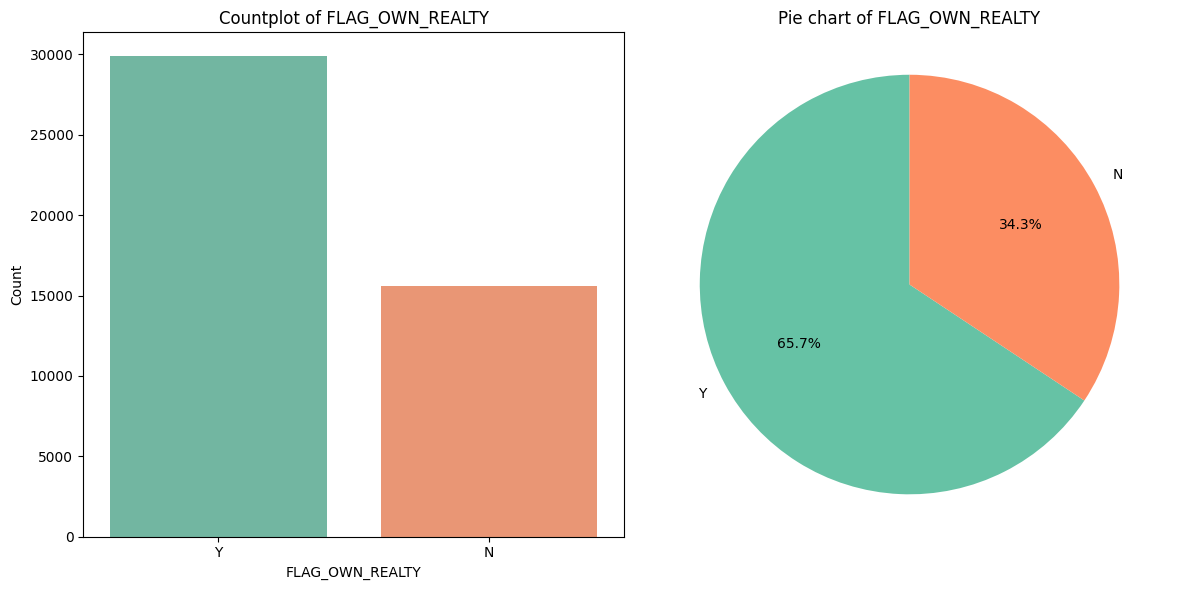


Summary Statistics for feature 'FLAG_OWN_REALTY':

Category  Frequency Percentage
       Y      29882     65.67%
       N      15618     34.33%

Additional Information:
Unique Values Count: 2
Mode: Y


In [ ]:
plots_binary(nan_occupation, "FLAG_OWN_REALTY")
descriptive_statistics(nan_occupation, "FLAG_OWN_REALTY", variables_type="binary")

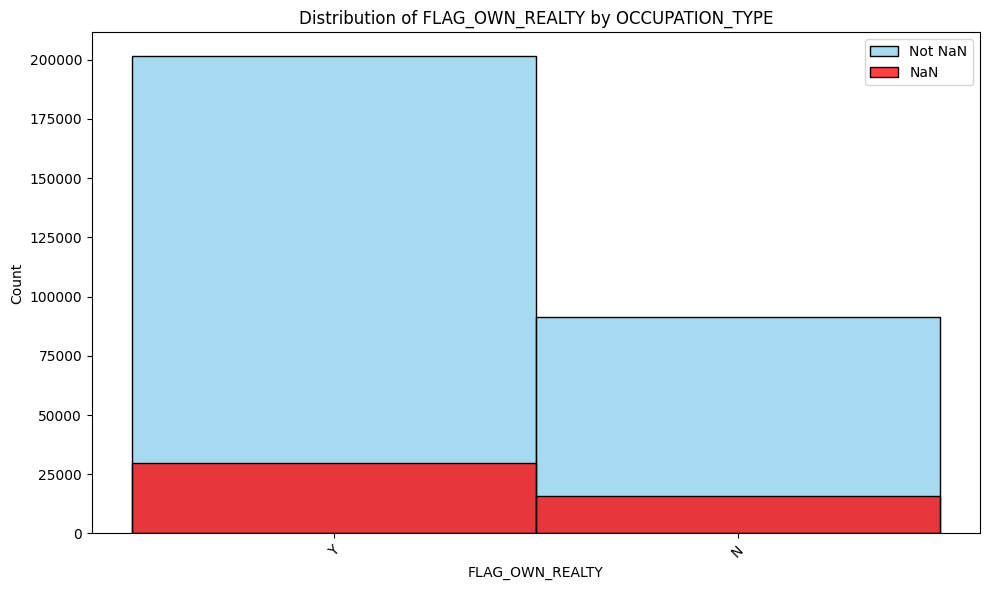

In [ ]:
compare_feature_by_nan(df_update, "FLAG_OWN_REALTY", "OCCUPATION_TYPE")

#### FLAG_WORK_PHONE where OCCUPATION_TYPE is NaN

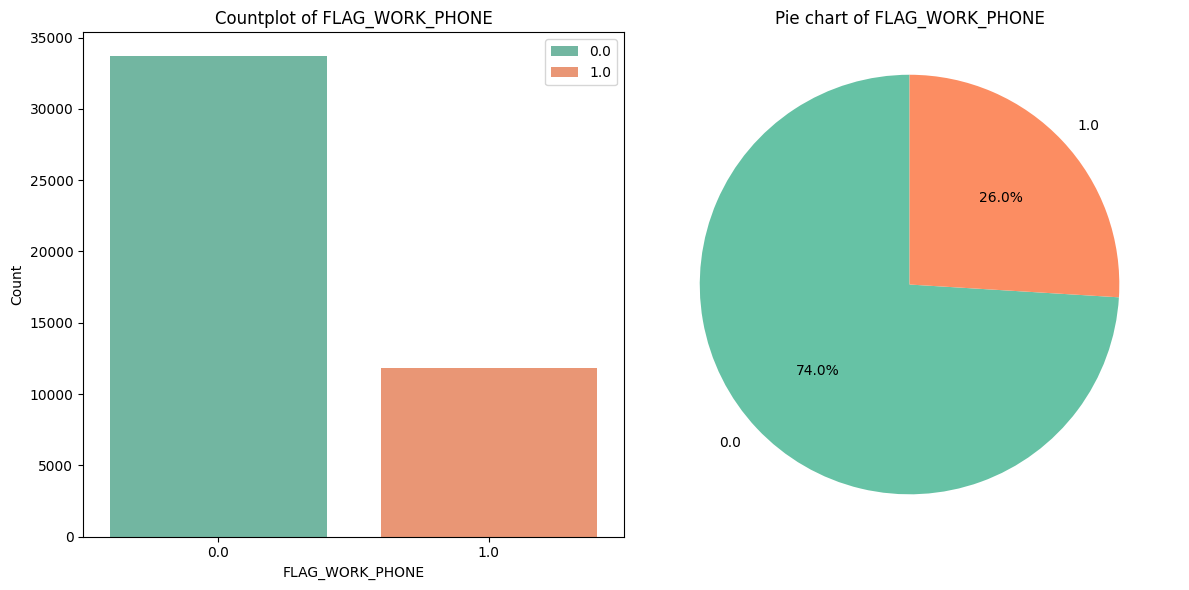


Summary Statistics for feature 'FLAG_WORK_PHONE':

 Category  Frequency Percentage
     0.00      33683     74.03%
     1.00      11817     25.97%

Additional Information:
Unique Values Count: 2
Mode: 0.0


In [ ]:
plots_binary(nan_occupation, "FLAG_WORK_PHONE")
descriptive_statistics(nan_occupation, "FLAG_WORK_PHONE", variables_type="binary")

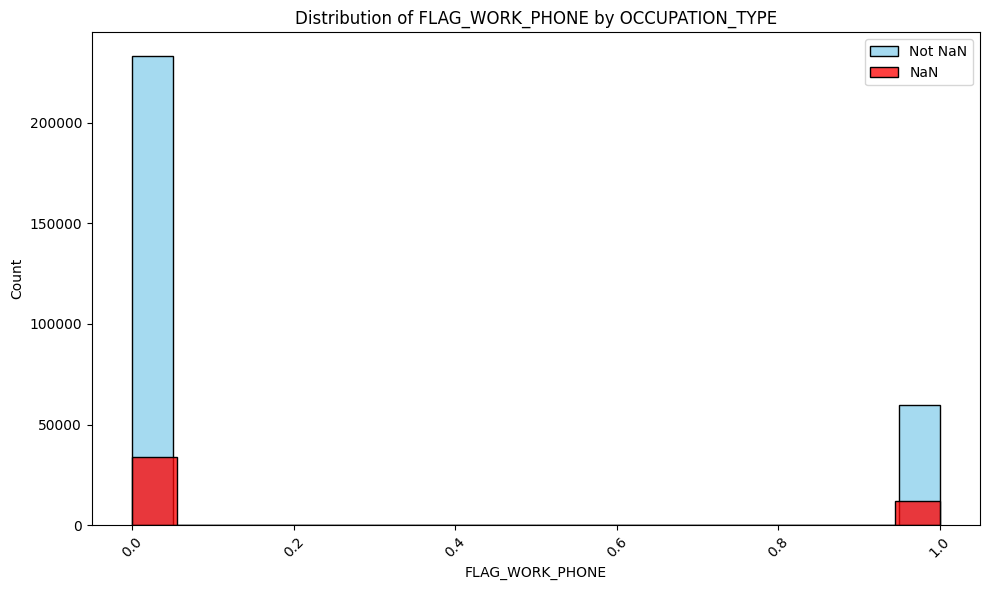

In [ ]:
compare_feature_by_nan(df_update, "FLAG_WORK_PHONE", "OCCUPATION_TYPE")

#### FLAG_PHONE where OCCUPATION_TYPE is NaN

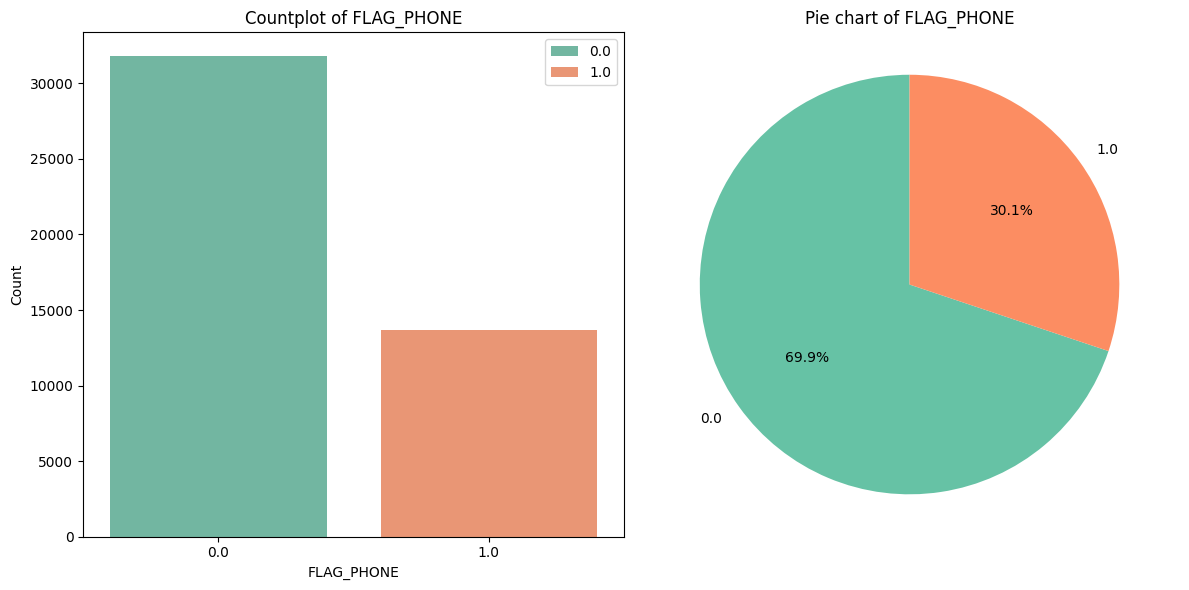


Summary Statistics for feature 'FLAG_PHONE':

 Category  Frequency Percentage
     0.00      31788     69.86%
     1.00      13712     30.14%

Additional Information:
Unique Values Count: 2
Mode: 0.0


In [ ]:
plots_binary(nan_occupation, "FLAG_PHONE")
descriptive_statistics(nan_occupation, "FLAG_PHONE", variables_type="binary")

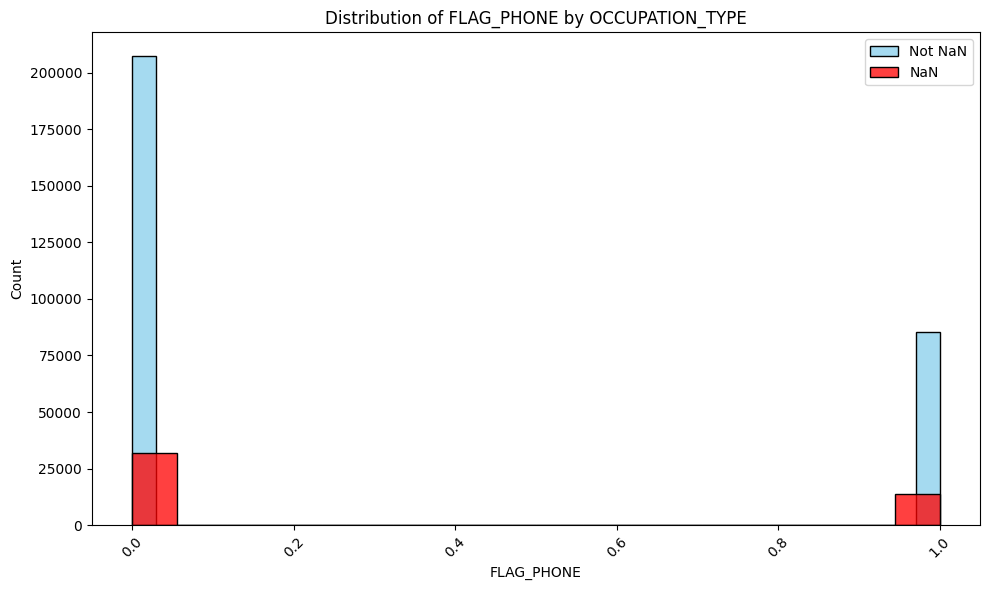

In [ ]:
compare_feature_by_nan(df_update, "FLAG_PHONE", "OCCUPATION_TYPE")

#### FLAG_EMAIL where OCCUPATION_TYPE is NaN

In [ ]:
plots_binary(nan_occupation, "FLAG_EMAIL")
descriptive_statistics(nan_occupation, "FLAG_EMAIL", variables_type="binary")


Summary Statistics for feature 'FLAG_EMAIL':

 Category  Frequency Percentage
     0.00      39993     87.90%
     1.00       5507     12.10%

Additional Information:
Unique Values Count: 2
Mode: 0.0


In [ ]:
compare_feature_by_nan(df_update, "FLAG_EMAIL", "OCCUPATION_TYPE")

#### TARGET where OCCUPATION_TYPE is NaN

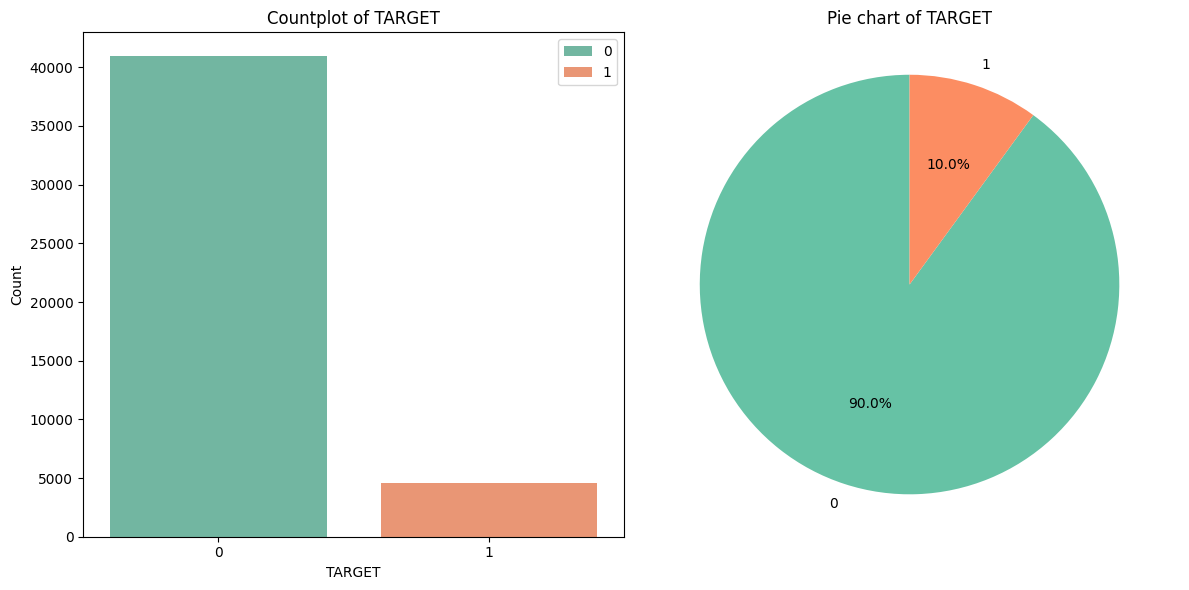


Summary Statistics for feature 'TARGET':

 Category  Frequency Percentage
        0      40931     89.96%
        1       4569     10.04%

Additional Information:
Unique Values Count: 2
Mode: 0


In [ ]:
plots_binary(nan_occupation, "TARGET")
descriptive_statistics(nan_occupation, "TARGET", variables_type="binary")

In [ ]:
compare_feature_by_nan(df_update, "TARGET", "OCCUPATION_TYPE")

#### NAME_FAMILY_STATUS where OCCUPATION_TYPE is NaN

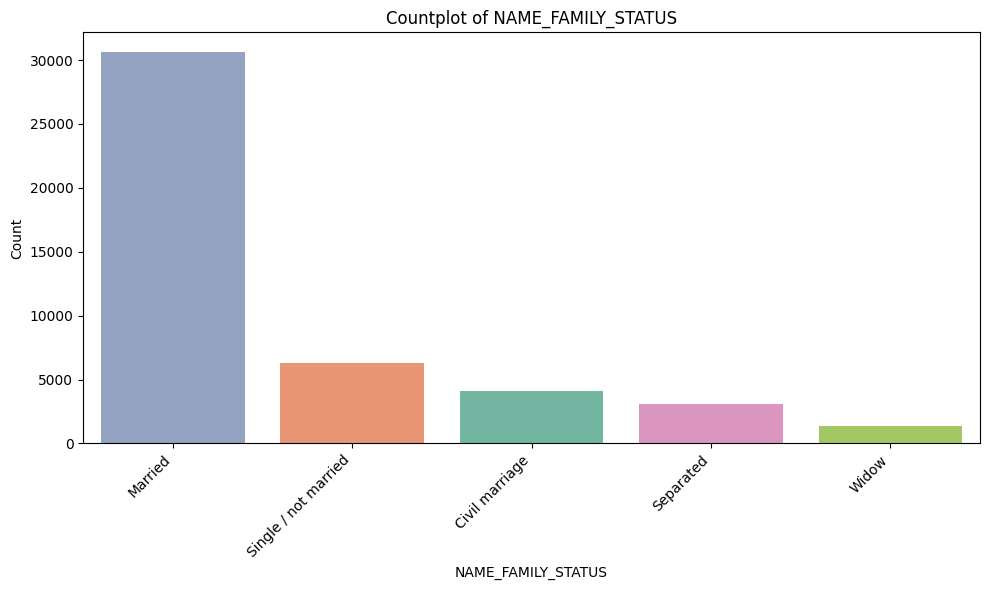


Summary Statistics for feature 'NAME_FAMILY_STATUS':

            Category  Frequency Percentage
             Married      30638     67.34%
Single / not married       6322     13.89%
      Civil marriage       4124      9.06%
           Separated       3056      6.72%
               Widow       1360      2.99%

Additional Information:
Unique Values Count: 5
Mode: Married


In [ ]:
countplot_categorical(nan_occupation, "NAME_FAMILY_STATUS")
descriptive_statistics(nan_occupation, "NAME_FAMILY_STATUS", variables_type="nominal")

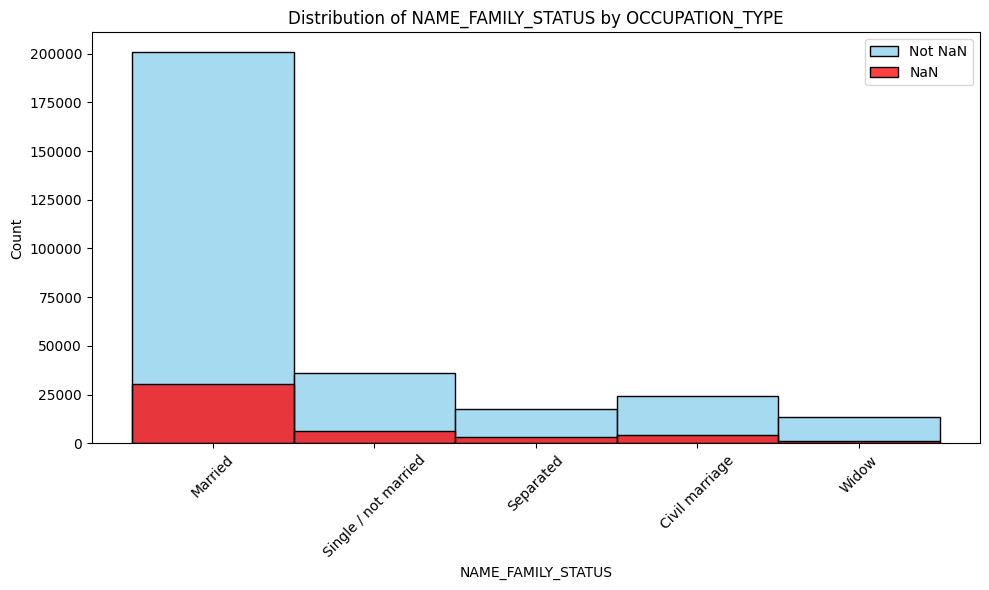

In [ ]:
compare_feature_by_nan(df_update, "NAME_FAMILY_STATUS", "OCCUPATION_TYPE")

#### NAME_HOUSING_TYPE where OCCUPATION_TYPE is NaN

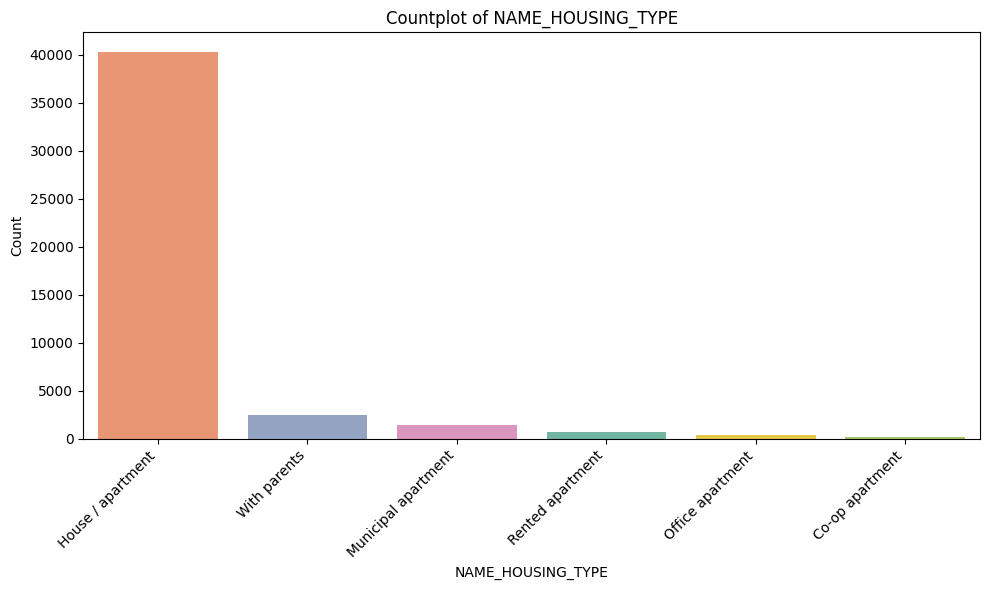


Summary Statistics for feature 'NAME_HOUSING_TYPE':

           Category  Frequency Percentage
  House / apartment      40295     88.56%
       With parents       2482      5.45%
Municipal apartment       1459      3.21%
   Rented apartment        690      1.52%
   Office apartment        433      0.95%
    Co-op apartment        141      0.31%

Additional Information:
Unique Values Count: 6
Mode: House / apartment


In [ ]:
countplot_categorical(nan_occupation, "NAME_HOUSING_TYPE")
descriptive_statistics(nan_occupation, "NAME_HOUSING_TYPE", variables_type="nominal")

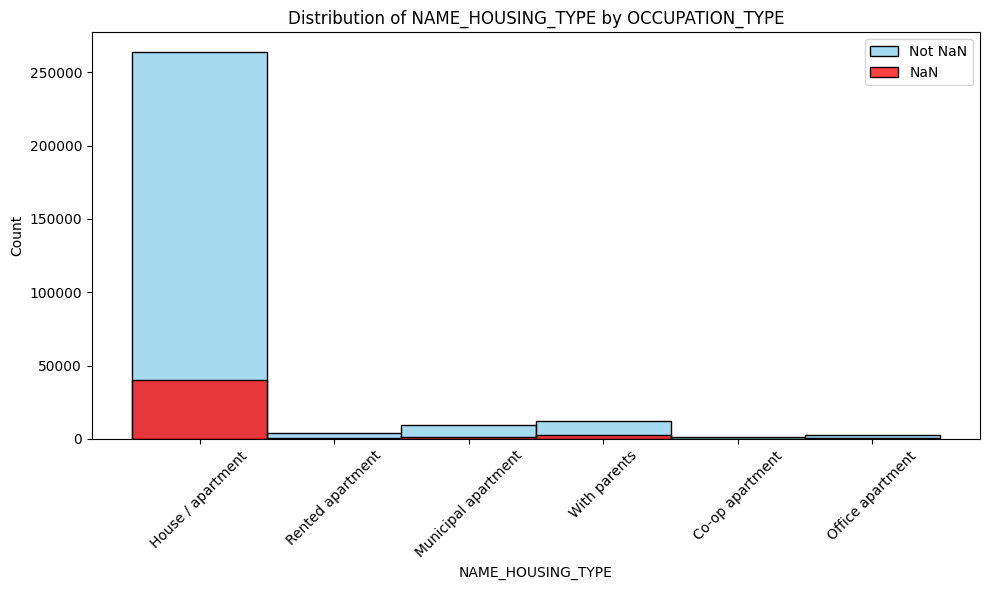

In [ ]:
compare_feature_by_nan(df_update, "NAME_HOUSING_TYPE", "OCCUPATION_TYPE")

#### NAME_EDUCATION_TYPE where OCCUPATION_TYPE is NaN

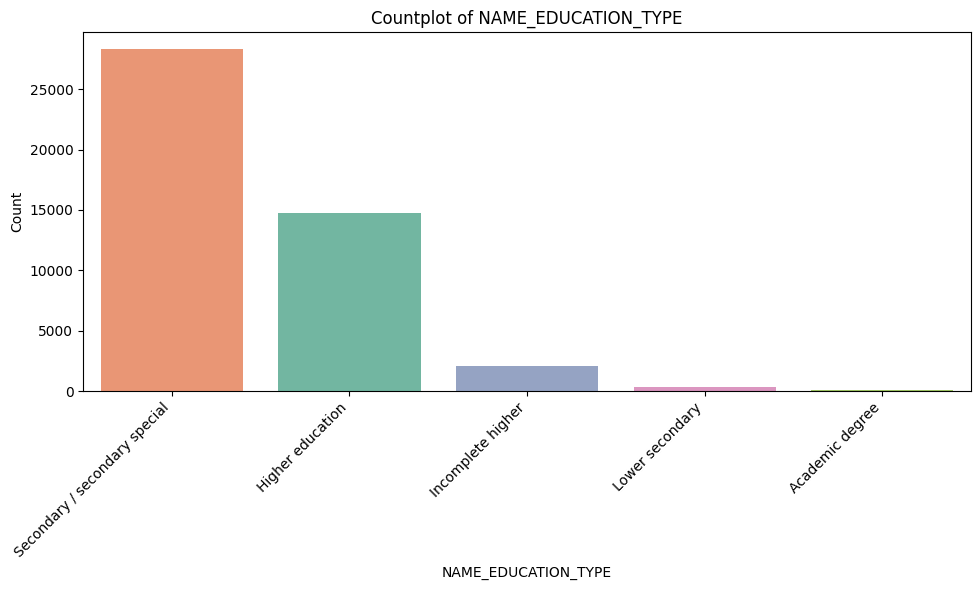


Summary Statistics for feature 'NAME_EDUCATION_TYPE':

                     Category  Frequency Percentage
Secondary / secondary special      28297     62.19%
             Higher education      14758     32.44%
            Incomplete higher       2038      4.48%
              Lower secondary        353      0.78%
              Academic degree         54      0.12%

Additional Information:
Unique Values Count: 5
Mode: Secondary / secondary special


In [ ]:
countplot_categorical(nan_occupation, "NAME_EDUCATION_TYPE")
descriptive_statistics(nan_occupation, "NAME_EDUCATION_TYPE", variables_type="ordinal")

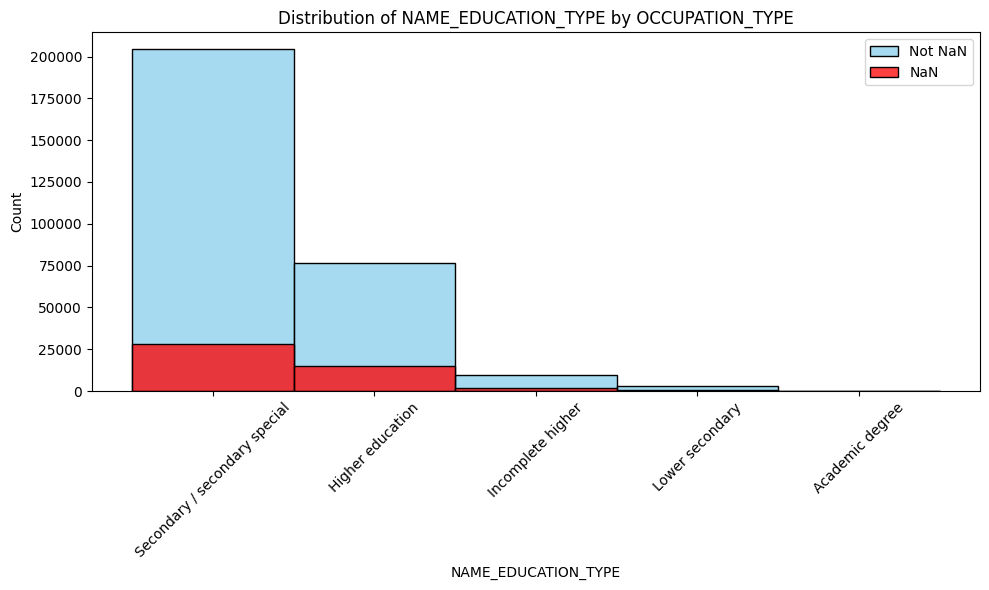

In [ ]:
compare_feature_by_nan(df_update, "NAME_EDUCATION_TYPE", "OCCUPATION_TYPE")

#### CNT_CHILDREN where OCCUPATION_TYPE is NaN

In [ ]:
barplot_discrete(nan_occupation, "CNT_CHILDREN")
descriptive_statistics(nan_occupation, "CNT_CHILDREN", variables_type="discrete")


Descriptive Statistics for feature 'CNT_CHILDREN':

Min: 0
Q1 (25th): 0.00
Q2 Median: 0.00
Q3 (75th): 1.00
Max: 6
IQR: 1.00
Mean: 0.49
Mode: 0
Variance: 0.58
Standard Deviation: 0.76
Range: 6
Skewness: 1.51
Kurtosis: 1.86


In [ ]:
compare_feature_by_nan(df_update, "CNT_CHILDREN", "OCCUPATION_TYPE")

#### DAYS_BIRTH_POSITIVE where OCCUPATION_TYPE is NaN

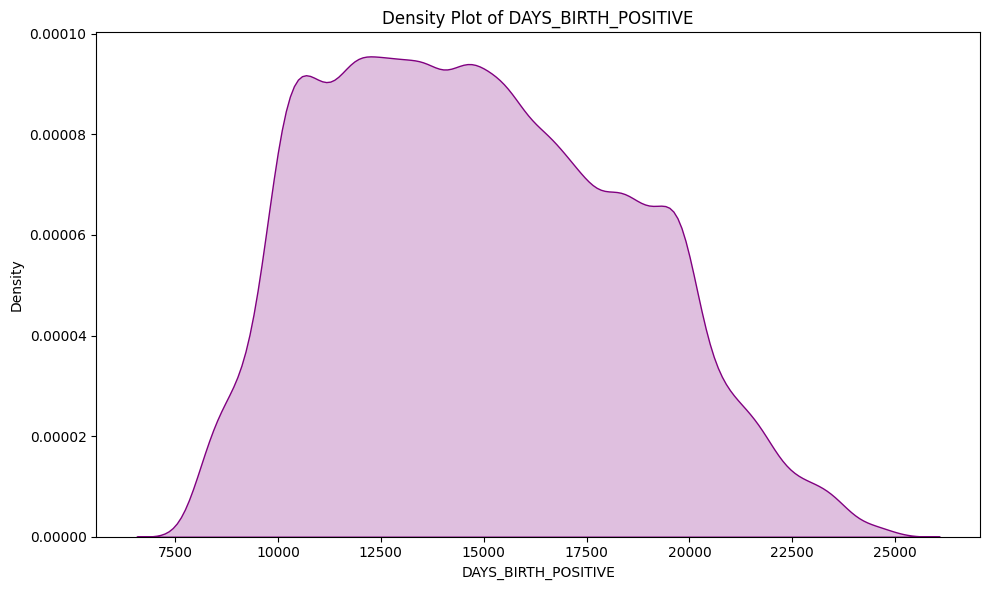


Descriptive Statistics for feature 'DAYS_BIRTH_POSITIVE':

Min: 7811.00
Q1 (25th): 11914.00
Q2 Median: 14573.00
Q3 (75th): 17529.00
Max: 24834.00
IQR: 5615.00
Mean: 14840.08
Mode: 10281.00
Variance: 12685717.08
Standard Deviation: 3561.70
Range: 17023.00
Skewness: 0.28
Kurtosis: -0.75


In [ ]:
plot_continuous(nan_occupation, "DAYS_BIRTH_POSITIVE", plot_type="density")
descriptive_statistics(nan_occupation, "DAYS_BIRTH_POSITIVE", variables_type="discrete")

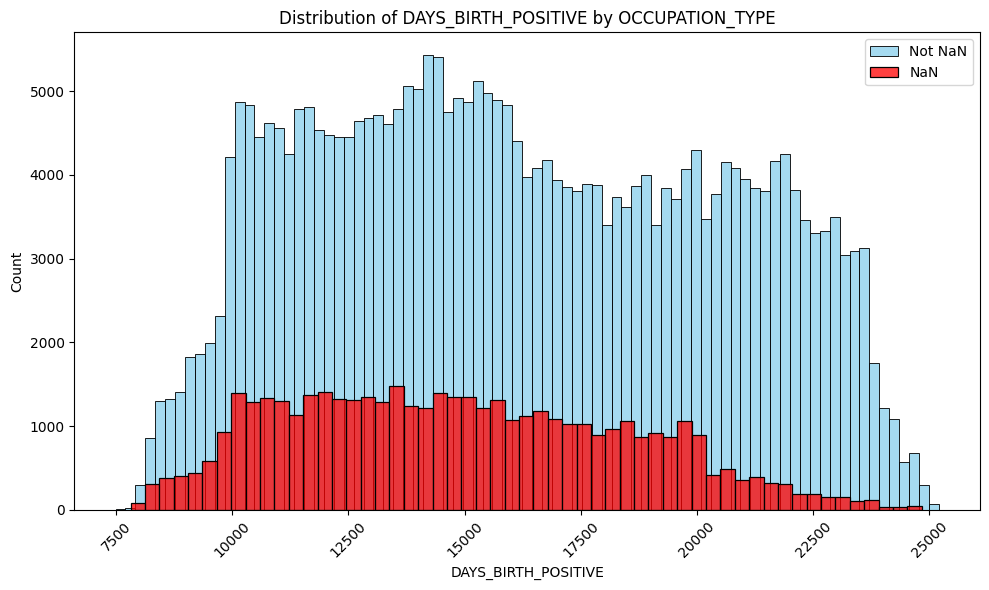

In [ ]:
compare_feature_by_nan(df_update, "DAYS_BIRTH_POSITIVE", "OCCUPATION_TYPE")

#### CNT_FAM_MEMBERS where OCCUPATION_TYPE is NaN

In [ ]:
barplot_discrete(nan_occupation, "CNT_FAM_MEMBERS")
descriptive_statistics(nan_occupation, "CNT_FAM_MEMBERS", variables_type="discrete")


Descriptive Statistics for feature 'CNT_FAM_MEMBERS':

Min: 1.00
Q1 (25th): 2.00
Q2 Median: 2.00
Q3 (75th): 3.00
Max: 8.00
IQR: 1.00
Mean: 2.26
Mode: 2.00
Variance: 0.87
Standard Deviation: 0.93
Range: 7.00
Skewness: 0.79
Kurtosis: 0.59


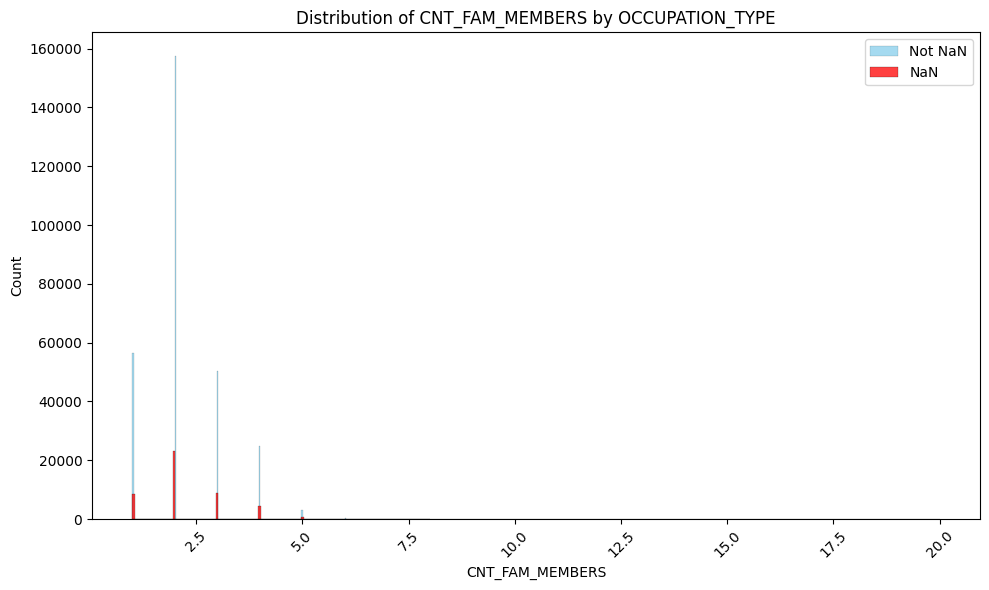

In [ ]:
compare_feature_by_nan(df_update, "CNT_FAM_MEMBERS", "OCCUPATION_TYPE")

#### AMT_INCOME_TOTAL where OCCUPATION_TYPE is NaN

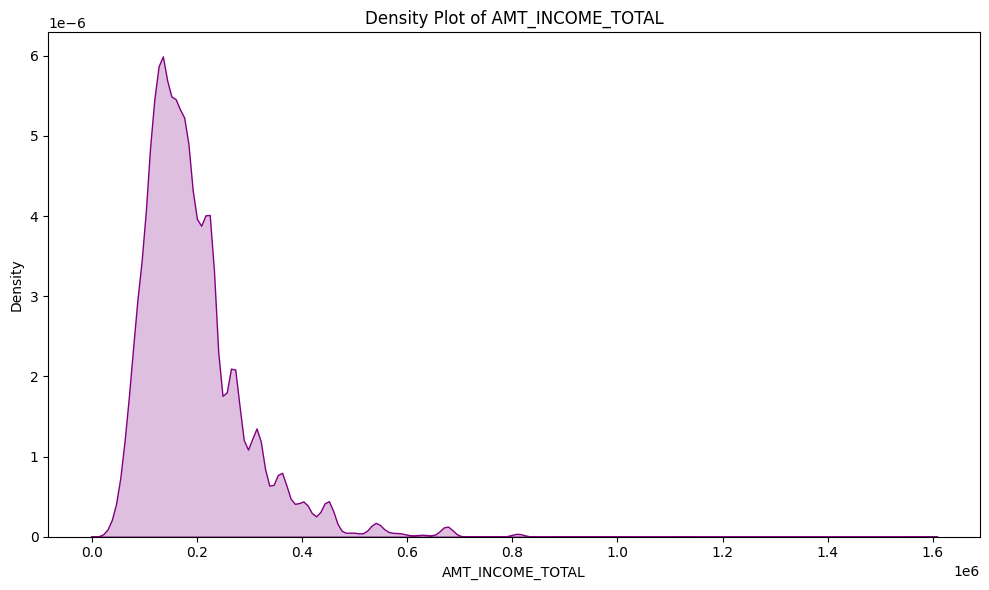


Descriptive Statistics for feature 'AMT_INCOME_TOTAL':

Min: 31500.00
Q1 (25th): 135000.00
Q2 Median: 180000.00
Q3 (75th): 225000.00
Max: 1575000.00
IQR: 90000.00
Mean: 192641.41
Mode: 135000.00
Variance: 9591899658.90
Standard Deviation: 97938.24
Range: 1543500.00
Skewness: 2.09
Kurtosis: 9.39


In [ ]:
plot_continuous(nan_occupation, "AMT_INCOME_TOTAL", plot_type="density")
descriptive_statistics(nan_occupation, "AMT_INCOME_TOTAL", variables_type="continuous")

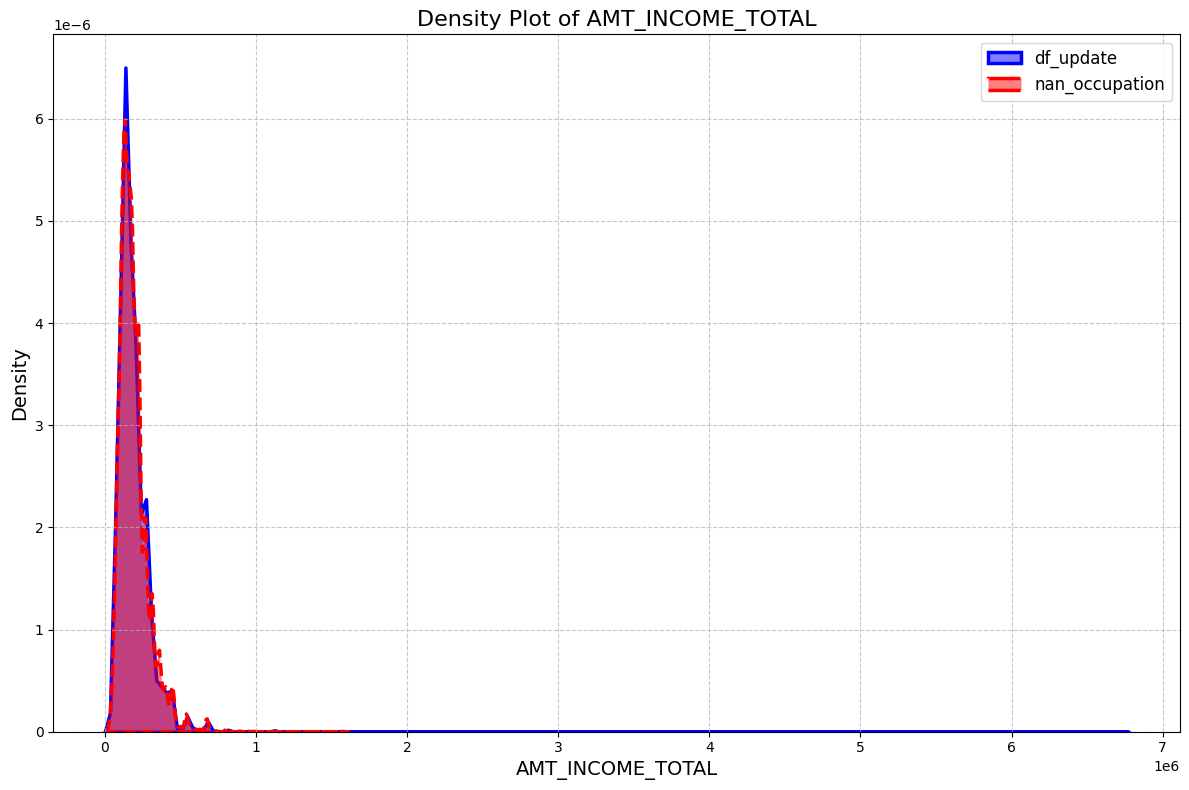

In [ ]:
#df_update
#nan_occupation

plt.figure(figsize=(12, 8))
# Grafico di densità per AMT_INCOME_TOTAL nel primo DataFrame
sns.kdeplot(df_update['AMT_INCOME_TOTAL'], label='df_update', color='blue', linestyle='-', fill=True, alpha=0.5, linewidth=2.5)

# Grafico di densità per AMT_INCOME_TOTAL nel secondo DataFrame
sns.kdeplot(nan_occupation['AMT_INCOME_TOTAL'], label='nan_occupation', color='red', linestyle='--', fill=True, alpha=0.5, linewidth=2.5)

# Aggiungere titolo e etichette
plt.title('Density Plot of AMT_INCOME_TOTAL', fontsize=16)
plt.xlabel('AMT_INCOME_TOTAL', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Aggiungere le linee di griglia per una migliore leggibilità
plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

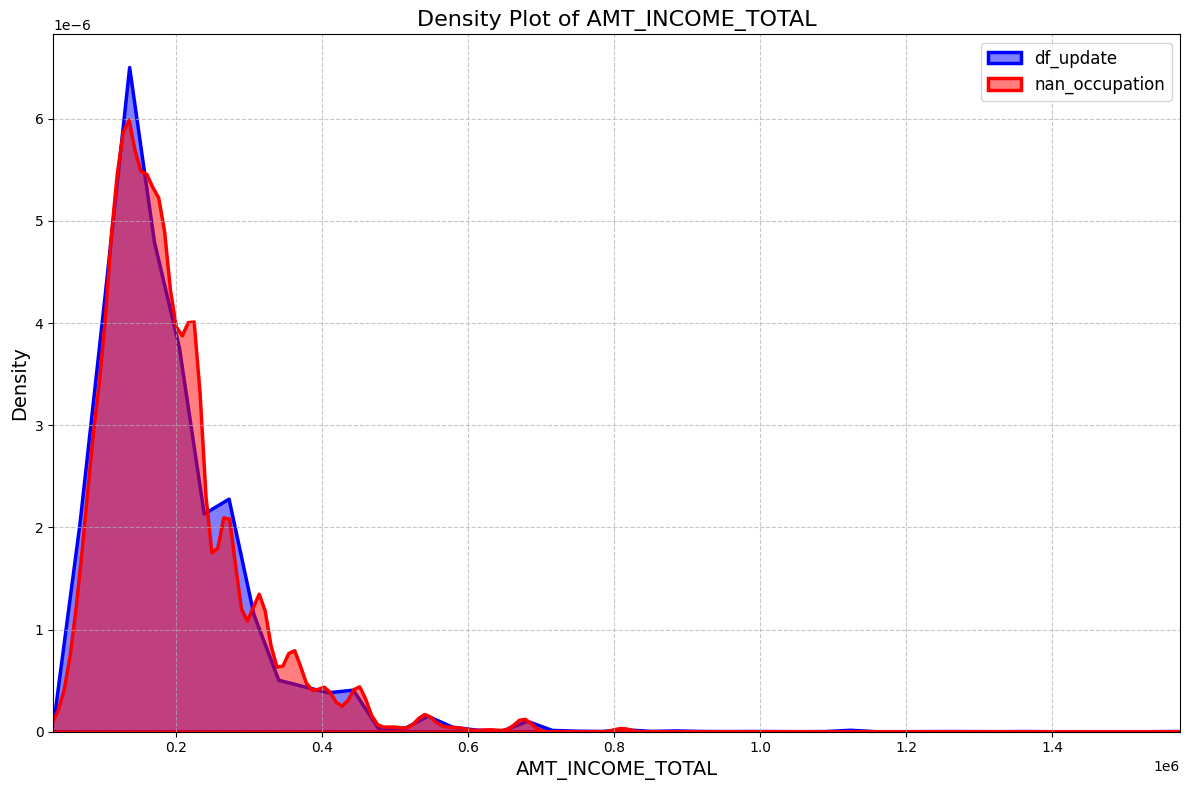

In [ ]:
# Determina i limiti dell'asse X basati su nan_occupation
x_min = nan_occupation['AMT_INCOME_TOTAL'].min()
x_max = nan_occupation['AMT_INCOME_TOTAL'].max()

# Creare la figura con dimensioni migliorate
plt.figure(figsize=(12, 8))

# Grafico di densità per AMT_INCOME_TOTAL nel primo DataFrame
sns.kdeplot(df_update['AMT_INCOME_TOTAL'],
            label='df_update',
            color='blue',
            fill=True,
            alpha=0.5,
            linewidth=2.5)

# Grafico di densità per AMT_INCOME_TOTAL nel secondo DataFrame
sns.kdeplot(nan_occupation['AMT_INCOME_TOTAL'],
            label='nan_occupation',
            color='red',
            fill=True,
            alpha=0.5,
            linewidth=2.5)

# Aggiungere titolo e etichette
plt.title('Density Plot of AMT_INCOME_TOTAL', fontsize=16)
plt.xlabel('AMT_INCOME_TOTAL', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Aggiungere le linee di griglia per una migliore leggibilità
plt.grid(True, linestyle='--', alpha=0.7)

# Impostare i limiti dell'asse X
plt.xlim(x_min, x_max)

# Aggiungere la legenda con una dimensione del font maggiore
plt.legend(fontsize=12)

# Ottimizzare il layout per evitare sovrapposizioni
plt.tight_layout()

# Mostrare il grafico
plt.show()

#### Summary (missing data in OCCUPATION_TYPE)

In the df_filtered dataframe, the OCCUPATION_TYPE feature has 45,500 NaN values, representing 13.44% of the total observations. After a thorough analysis of the implications of these data gaps, I decided to replace all NaN values with "unknown".

This choice was motivated by taking into account the options for managing NaN values:

- Rows removal with NaN:
    - Pro: Removes rows with missing data, maintaining the completeness of the remaining data.
    - Cons: Can cause significant information loss if rows contain other relevant information.
- Replacement with Moda:
    - Pro: Maintains dataset size and can be useful for numeric or categorical features with dominant values.
    - Cons: It could introduce bias if the missing data is not random and if the mean or mode value does not adequately represent the distribution of the data.
- Imputation based on Machine Learning Algorithms:
    -  Pro: Uses more complex models to predict missing values, potentially improving accuracy.
    -  Cons: Can be computationally more expensive and require greater understanding of the data and context.
- Replacing with "unknown":
    -  Pros: Keeps all observations in the dataset and does not alter the distribution of existing data, is simple to implement and understand.
    -  Cons: Bias in the analysis: If “unknown” becomes a significant value for the analysis (for example, if there are a significant number of NaN values), it could influence the results and models generated.



In [ ]:
# Replace NaN with "unknown" for the OCCUPATION_TYPE variable
df_update['OCCUPATION_TYPE'] = df_update['OCCUPATION_TYPE'].fillna('unknown')

In [ ]:
df_update['OCCUPATION_TYPE'].value_counts()

OCCUPATION_TYPE
Laborers                 60146
unemployed               57841
unknown                  45500
Core staff               33527
Sales staff              31652
Managers                 27384
Drivers                  20020
High skill tech staff    13399
Accountants              12281
Medicine staff           10438
Cooking staff             6248
Security staff            6218
Cleaning staff            4594
Private service staff     2787
Low-skill Laborers        1714
Secretaries               1577
Waiters/barmen staff      1245
Realty agents              852
HR staff                   567
IT staff                   436
Name: count, dtype: int64

In [ ]:
df_update

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0       5008804           M            Y               Y             0   
1       5008805           M            Y               Y             0   
2       5008806           M            Y               Y             0   
3       5008808           F            N               Y             0   
4       5008809           F            N               Y             0   
...         ...         ...          ...             ...           ...   
338421  6392174           F            N               Y             0   
338422  6392175           F            N               Y             0   
338423  6392177           F            N               Y             0   
338424  6392178           F            N               Y             0   
338425  6392179           F            N               Y             0   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0              427500.00               Working               Higher education   
1              427500.00               Working               Higher education   
2              112500.00               Working  Secondary / secondary special   
3              270000.00  Commercial associate  Secondary / secondary special   
4              270000.00  Commercial associate  Secondary / secondary special   
...                  ...                   ...                            ...   
338421         157500.00             Pensioner  Secondary / secondary special   
338422         157500.00             Pensioner  Secondary / secondary special   
338423         157500.00             Pensioner  Secondary / secondary special   
338424         157500.00             Pensioner  Secondary / secondary special   
338425         157500.00             Pensioner  Secondary / secondary special   

          NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_EMPLOYED  \
0             Civil marriage   Rented apartment       -4542.00   
1             Civil marriage   Rented apartment       -4542.00   
2                    Married  House / apartment       -1134.00   
3       Single / not married  House / apartment       -3051.00   
4       Single / not married  House / apartment       -3051.00   
...                      ...                ...            ...   
338421               Married  House / apartment        1745.00   
338422               Married  House / apartment        1745.00   
338423               Married  House / apartment        1745.00   
338424               Married  House / apartment        1745.00   
338425               Married  House / apartment        1745.00   

        FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0                  1.00        0.00        0.00         unknown   
1                  1.00        0.00        0.00         unknown   
2                  0.00        0.00        0.00  Security staff   
3                  0.00        1.00        1.00     Sales staff   
4                  0.00        1.00        1.00     Sales staff   
...                 ...         ...         ...             ...   
338421             0.00        0.00        0.00      unemployed   
338422             0.00        0.00        0.00      unemployed   
338423             0.00        0.00        0.00      unemployed   
338424             0.00        0.00        0.00      unemployed   
338425             0.00        0.00        0.00      unemployed   

        CNT_FAM_MEMBERS  TARGET  DAYS_BIRTH_POSITIVE  
0                  2.00       0             12005.00  
1                  2.00       0             12005.00  
2                  2.00       0             21474.00  
3                  1.00       1             19110.00  
4                  1.00       1             19110.00  
...                 ...     ...                  ...  
338421             2.00       0             23661.00  
338422             2.00       0             23661.00  
338423             2.00       0             23661.00  
338

In [ ]:
df_update.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338426 entries, 0 to 338425
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   338426 non-null  int64  
 1   CODE_GENDER          338426 non-null  object 
 2   FLAG_OWN_CAR         338426 non-null  object 
 3   FLAG_OWN_REALTY      338426 non-null  object 
 4   CNT_CHILDREN         338426 non-null  int64  
 5   AMT_INCOME_TOTAL     338426 non-null  float64
 6   NAME_INCOME_TYPE     338426 non-null  object 
 7   NAME_EDUCATION_TYPE  338426 non-null  object 
 8   NAME_FAMILY_STATUS   338426 non-null  object 
 9   NAME_HOUSING_TYPE    338426 non-null  object 
 10  DAYS_EMPLOYED        338426 non-null  float64
 11  FLAG_WORK_PHONE      338426 non-null  float64
 12  FLAG_PHONE           338426 non-null  float64
 13  FLAG_EMAIL           338426 non-null  float64
 14  OCCUPATION_TYPE      338426 non-null  object 
 15  CNT_FAM_MEMBERS  

# Preprocessing

Here's a recap of the preprocessing done so far:

- DAY_BIRTH to DAY_BIRTH_POSITIVE:
    - The DAY_BIRTH feature has been transformed into DAY_BIRTH_POSITIVE to represent age in positive days.
- Drop of FLAG_MOBIL:
    - The FLAG_MOBIL column was removed because all values were 1, indicating that all observations had a mobile number.
- DAYS_EMPLOYED, OCCUPATION_TYPE:
    - For all observations that had a value in DAYS_EMPLOYED greater than the "Maximum life span" & as a value for NAME_INCOME_TYPE "Pensioner", I transformed the value of DAYS_EMPLOYED to make it more consistent and replaced the NaN in OCCUPATION_TYPE with "unemployed"
- OCCUPATION_TYPE:
    - I decided to replace all NaN values with "unknown"

In [ ]:
df_update.head()

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0         427500.00               Working               Higher education   
1         427500.00               Working               Higher education   
2         112500.00               Working  Secondary / secondary special   
3         270000.00  Commercial associate  Secondary / secondary special   
4         270000.00  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_EMPLOYED  FLAG_WORK_PHONE  \
0        Civil marriage   Rented apartment       -4542.00             1.00   
1        Civil marriage   Rented apartment       -4542.00             1.00   
2               Married  House / apartment       -1134.00             0.00   
3  Single / not married  House / apartment       -3051.00             0.00   
4  Single / not married  House / apartment       -3051.00             0.00   

   FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  TARGET  \
0        0.00        0.00         unknown             2.00       0   
1        0.00        0.00         unknown             2.00       0   
2        0.00        0.00  Security staff             2.00       0   
3        1.00        1.00     Sales staff             1.00       1   
4        1.00        1.00     Sales staff             1.00       1   

   DAYS_BIRTH_POSITIVE  
0             12005.00  
1             12005.00  
2             21474.00  
3             19110.00  
4             19110.00

## Data Transformation

- To drop
    - **'ID'** : To drop
- Encoding {1:'Y', 0:'N'}
    - **'FLAG_WORK_PHONE'** : after OHE
    - **'FLAG_PHONE'** : after OHE
    - **'FLAG_EMAIL'** : after OHE
- One-Hot Encoding
    - **'CODE_GENDER'**
    - **'NAME_INCOME_TYPE'**
    - **'NAME_FAMILY_STATUS'**
    - **'NAME_HOUSING_TYPE'**
    - **'OCCUPATION_TYPE'**
    - **'FLAG_OWN_CAR'**  
    - **'FLAG_OWN_REALTY'**
- Ordinal Encoding
    - **'NAME_EDUCATION_TYPE'**
- Scaling (StandardScaler)
    - **'CNT_CHILDREN'**
    - **'AMT_INCOME_TOTAL'**
    - **'DAYS_BIRTH_POSITIVE'**
    - **'DAYS_EMPLOYED'**
    - **'CNT_FAM_MEMBERS'**

In [ ]:
df_process = df_update.copy()

In [ ]:
# Drop 'ID'
df_process.drop(columns=['ID'], inplace=True)

# Encoding 'FLAG_WORK_PHONE', 'FLAG_PHONE' e 'FLAG_EMAIL'
mapping = {1:'Y', 0:'N'}

df_process['FLAG_WORK_PHONE'] = df_process['FLAG_WORK_PHONE'].map(mapping)
df_process['FLAG_PHONE'] = df_process['FLAG_PHONE'].map(mapping)
df_process['FLAG_EMAIL'] = df_process['FLAG_EMAIL'].map(mapping)

In [ ]:
df_process

CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0                M            Y               Y             0   
1                M            Y               Y             0   
2                M            Y               Y             0   
3                F            N               Y             0   
4                F            N               Y             0   
...            ...          ...             ...           ...   
338421           F            N               Y             0   
338422           F            N               Y             0   
338423           F            N               Y             0   
338424           F            N               Y             0   
338425           F            N               Y             0   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0              427500.00               Working               Higher education   
1              427500.00               Working               Higher education   
2              112500.00               Working  Secondary / secondary special   
3              270000.00  Commercial associate  Secondary / secondary special   
4              270000.00  Commercial associate  Secondary / secondary special   
...                  ...                   ...                            ...   
338421         157500.00             Pensioner  Secondary / secondary special   
338422         157500.00             Pensioner  Secondary / secondary special   
338423         157500.00             Pensioner  Secondary / secondary special   
338424         157500.00             Pensioner  Secondary / secondary special   
338425         157500.00             Pensioner  Secondary / secondary special   

          NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_EMPLOYED  \
0             Civil marriage   Rented apartment       -4542.00   
1             Civil marriage   Rented apartment       -4542.00   
2                    Married  House / apartment       -1134.00   
3       Single / not married  House / apartment       -3051.00   
4       Single / not married  House / apartment       -3051.00   
...                      ...                ...            ...   
338421               Married  House / apartment        1745.00   
338422               Married  House / apartment        1745.00   
338423               Married  House / apartment        1745.00   
338424               Married  House / apartment        1745.00   
338425               Married  House / apartment        1745.00   

       FLAG_WORK_PHONE FLAG_PHONE FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                    Y          N          N         unknown             2.00   
1                    Y          N          N         unknown             2.00   
2                    N          N          N  Security staff             2.00   
3                    N          Y          Y     Sales staff             1.00   
4                    N          Y          Y     Sales staff             1.00   
...                ...        ...        ...             ...              ...   
338421               N          N          N      unemployed             2.00   
338422               N          N          N      unemployed             2.00   
338423               N          N          N      unemployed             2.00   
338424               N          N          N      unemployed             2.00   
338425               N          N          N      unemployed             2.00   

        TARGET  DAYS_BIRTH_POSITIVE  
0            0             12005.00  
1            0             12005.00  
2            0             21474.00  
3            1             19110.00  
4            1             19110.00  
...        ...                  ...  
338421       0             23661.00  
338422       0             23661.00  
338423       0             23661.00  
338424       0             23661.00  
338425       0             23661.00  

[338426 rows x 17 columns]

In [ ]:
X = df_process.drop(columns=['TARGET'])
y = df_process['TARGET']

In [ ]:
num_col = [
    'CNT_CHILDREN',
    'AMT_INCOME_TOTAL',
    'DAYS_BIRTH_POSITIVE',
    'DAYS_EMPLOYED',
    'CNT_FAM_MEMBERS'
]

nominal_cat_col = [
    'FLAG_WORK_PHONE',
    'FLAG_PHONE',
    'FLAG_EMAIL',
    'CODE_GENDER',
    'NAME_INCOME_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY'
]

ordinal_cat_col = [
    'NAME_EDUCATION_TYPE'
]

ordinal_categories = [
    ['Lower secondary', 'Secondary / secondary special', 'Incomplete higher', 'Higher education', 'Academic degree']
]

ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_col),
        ('cat_nom', one_hot_encoder, nominal_cat_col),
        ('cat_ord', ordinal_encoder, ordinal_cat_col)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [ ]:
X_train_df = pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out())
X_test_df = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())

In [ ]:
X_train_df.shape

(236898, 44)

In [ ]:
for i in X_train_df.columns:
    print(i)

num__CNT_CHILDREN
num__AMT_INCOME_TOTAL
num__DAYS_BIRTH_POSITIVE
num__DAYS_EMPLOYED
num__CNT_FAM_MEMBERS
cat_nom__FLAG_WORK_PHONE_Y
cat_nom__FLAG_PHONE_Y
cat_nom__FLAG_EMAIL_Y
cat_nom__CODE_GENDER_M
cat_nom__NAME_INCOME_TYPE_Pensioner
cat_nom__NAME_INCOME_TYPE_State servant
cat_nom__NAME_INCOME_TYPE_Student
cat_nom__NAME_INCOME_TYPE_Working
cat_nom__NAME_FAMILY_STATUS_Married
cat_nom__NAME_FAMILY_STATUS_Separated
cat_nom__NAME_FAMILY_STATUS_Single / not married
cat_nom__NAME_FAMILY_STATUS_Widow
cat_nom__NAME_HOUSING_TYPE_House / apartment
cat_nom__NAME_HOUSING_TYPE_Municipal apartment
cat_nom__NAME_HOUSING_TYPE_Office apartment
cat_nom__NAME_HOUSING_TYPE_Rented apartment
cat_nom__NAME_HOUSING_TYPE_With parents
cat_nom__OCCUPATION_TYPE_Cleaning staff
cat_nom__OCCUPATION_TYPE_Cooking staff
cat_nom__OCCUPATION_TYPE_Core staff
cat_nom__OCCUPATION_TYPE_Drivers
cat_nom__OCCUPATION_TYPE_HR staff
cat_nom__OCCUPATION_TYPE_High skill tech staff
cat_nom__OCCUPATION_TYPE_IT staff
cat_nom__OCCUPATI

# Models (All features)

In [ ]:
# Models to evaluate
models = {
    "Logistic Regression Base": LogisticRegression(random_state=SEED),
    "Decision Tree Base": DecisionTreeClassifier(random_state=SEED),
    "Random Forest Base": RandomForestClassifier(random_state=SEED),
    "Gradient Boosting Machines Base": GradientBoostingClassifier(random_state=SEED),
    "k-Nearest Neighbors Base": KNeighborsClassifier(),
    "Neural Networks Base": MLPClassifier(random_state=SEED),
    "Naive Bayes Base": GaussianNB(),
    "XGBoost Base": xgb.XGBClassifier(random_state=SEED)
}

In [ ]:
results_df = evaluate_models(models, X_train, y_train, X_test, y_test)

Evaluating Models:  12%|████████▏                                                        | 1/8 [00:01<00:09,  1.34s/it]

Logistic Regression Base Accuracy: 0.91205
Logistic Regression Base F1 Score: 0.27951
Logistic Regression Base Precision: 0.50807
Logistic Regression Base Recall: 0.19279
Logistic Regression Base ROC-AUC: 0.91821



Evaluating Models:  25%|████████████████▎                                                | 2/8 [00:02<00:06,  1.13s/it]

Decision Tree Base Accuracy: 0.94861
Decision Tree Base F1 Score: 0.71737
Decision Tree Base Precision: 0.69867
Decision Tree Base Recall: 0.73709
Decision Tree Base ROC-AUC: 0.95550



Evaluating Models:  38%|████████████████████████▍                                        | 3/8 [00:18<00:39,  7.92s/it]

Random Forest Base Accuracy: 0.95282
Random Forest Base F1 Score: 0.75446
Random Forest Base Precision: 0.69926
Random Forest Base Recall: 0.81912
Random Forest Base ROC-AUC: 0.97911



Evaluating Models:  50%|████████████████████████████████▌                                | 4/8 [01:10<01:41, 25.45s/it]

Gradient Boosting Machines Base Accuracy: 0.96191
Gradient Boosting Machines Base F1 Score: 0.82282
Gradient Boosting Machines Base Precision: 0.69924
Gradient Boosting Machines Base Recall: 0.99944
Gradient Boosting Machines Base ROC-AUC: 0.97918



Evaluating Models:  62%|████████████████████████████████████████▋                        | 5/8 [02:09<01:52, 37.45s/it]

k-Nearest Neighbors Base Accuracy: 0.94342
k-Nearest Neighbors Base F1 Score: 0.69221
k-Nearest Neighbors Base Precision: 0.66739
k-Nearest Neighbors Base Recall: 0.71894
k-Nearest Neighbors Base ROC-AUC: 0.95986



Evaluating Models:  75%|████████████████████████████████████████████████▊                | 6/8 [03:05<01:27, 43.64s/it]

Neural Networks Base Accuracy: 0.95915
Neural Networks Base F1 Score: 0.80285
Neural Networks Base Precision: 0.70069
Neural Networks Base Recall: 0.93989
Neural Networks Base ROC-AUC: 0.97916



Evaluating Models:  88%|████████████████████████████████████████████████████████▉        | 7/8 [03:05<00:29, 29.50s/it]

Naive Bayes Base Accuracy: 0.33095
Naive Bayes Base F1 Score: 0.20498
Naive Bayes Base Precision: 0.11453
Naive Bayes Base Recall: 0.97473
Naive Bayes Base ROC-AUC: 0.83992



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 8/8 [03:07<00:00, 23.38s/it]

XGBoost Base Accuracy: 0.96057
XGBoost Base F1 Score: 0.81318
XGBoost Base Precision: 0.70015
XGBoost Base Recall: 0.96972
XGBoost Base ROC-AUC: 0.97894




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:284: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame(results_list)], ignore_index=True)
C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)


In [ ]:
save_dataframe_to_csv(results_df, 'results_df.csv')

In [ ]:
results_df

Model Accuracy F1 Score Precision   Recall  \
0         Logistic Regression Base  0.91205  0.27951   0.50807  0.19279   
1               Decision Tree Base  0.94861  0.71737   0.69867  0.73709   
2               Random Forest Base  0.95282  0.75446   0.69926  0.81912   
3  Gradient Boosting Machines Base  0.96191  0.82282   0.69924  0.99944   
4         k-Nearest Neighbors Base  0.94342  0.69221   0.66739  0.71894   
5             Neural Networks Base  0.95915  0.80285   0.70069  0.93989   
6                 Naive Bayes Base  0.33095  0.20498   0.11453  0.97473   
7                     XGBoost Base  0.96057  0.81318   0.70015  0.96972   

   ROC-AUC    TP     FP     TN    FN  Duration (seconds)  \
0  0.91821  1732   1677  90867  7252                1.34   
1  0.95550  6622   2856  89688  2362                0.98   
2  0.97911  7359   3165  89379  1625               16.00   
3  0.97918  8979   3862  88682     5               52.32   
4  0.95986  6459   3219  89325  2525               58.74   
5  0.97916  8444   3607  88937   540               55.66   
6  0.83992  8757  67700  24844   227                0.37   
7  0.97894  8712   3731  88813   272                1.61   

                                          Parameters  
0  {'C': 1.0, 'class_weight': None, 'dual': False...  
1  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  
2  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
3  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...  
4  {'algorithm': 'auto', 'leaf_size': 30, 'metric...  
5  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
6           {'priors': None, 'var_smoothing': 1e-09}  
7  {'objective': 'binary:logistic', 'base_score':...

In [ ]:
# questa è la funzione da chiamare per i training di modelli successivi ai primi "Modelli Base"
#results_df = evaluate_models(models, X_train, y_train, X_test, y_test, results_df)

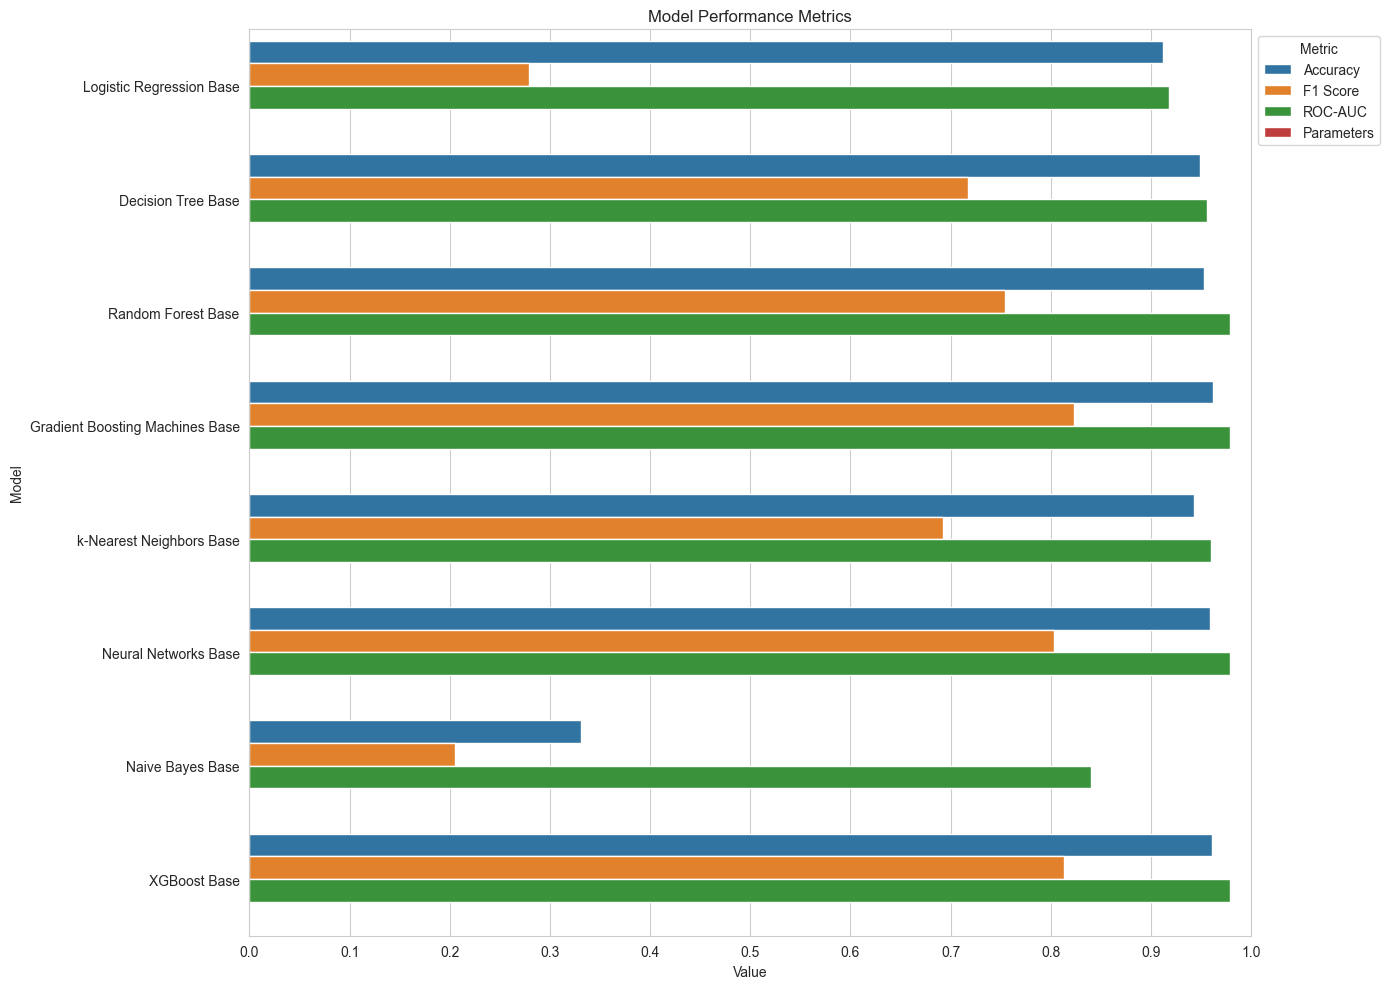

In [ ]:
plot_results(results_df, exclude_metrics=['Precision', 'Recall', 'TP', 'FP', 'TN', 'FN', 'Duration (seconds)'])

## Features Selection

### Filter Methods

#### Variance threshold

Using VarianceThreshold after standardization and OHE:

- Standardization: After standardization, all numeric features will have a variance of 1. Therefore, using VarianceThreshold on these features will not be useful because no features will be eliminated based on variance unless there is a constant feature with zero variance.

- One-Hot Encoding: Binary features obtained via OHE will have a variance that reflects the category distribution. If all observations for a binary feature are 0 or 1, the variance will be zero and VarianceThreshold will be useful for eliminating these features. However, if there is any variation in the data (even small ones), these features will not be eliminated unless the threshold is specifically set.

In practice, VarianceThreshold can still be useful for eliminating constant or nearly constant features (even after OHE), but it will not be effective for standardized numeric features.

In [ ]:
X_train_var, X_test_var, y_train_var, y_test_var = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [ ]:
X_train_var_df = pd.DataFrame(X_train_var, columns=preprocessor.get_feature_names_out())
X_test_var_df = pd.DataFrame(X_test_var, columns=preprocessor.get_feature_names_out())

In [ ]:
check_column_alignment(X_train_var_df, X_train_var)

True

In [ ]:
check_column_alignment(X_test_var_df, X_test_var)

True

In [ ]:
X_train_var_filtered, X_test_var_filtered = select_and_plot_features_by_var(X_train_var_df, X_train_var, X_test_var, threshold=0.05)

Feature selezionate: ['num__CNT_CHILDREN', 'num__AMT_INCOME_TOTAL', 'num__DAYS_BIRTH_POSITIVE', 'num__DAYS_EMPLOYED', 'num__CNT_FAM_MEMBERS', 'cat_nom__FLAG_WORK_PHONE_Y', 'cat_nom__FLAG_PHONE_Y', 'cat_nom__FLAG_EMAIL_Y', 'cat_nom__CODE_GENDER_M', 'cat_nom__NAME_INCOME_TYPE_Pensioner', 'cat_nom__NAME_INCOME_TYPE_State servant', 'cat_nom__NAME_INCOME_TYPE_Working', 'cat_nom__NAME_FAMILY_STATUS_Married', 'cat_nom__NAME_FAMILY_STATUS_Separated', 'cat_nom__NAME_FAMILY_STATUS_Single / not married', 'cat_nom__NAME_HOUSING_TYPE_House / apartment', 'cat_nom__OCCUPATION_TYPE_Core staff', 'cat_nom__OCCUPATION_TYPE_Drivers', 'cat_nom__OCCUPATION_TYPE_Laborers', 'cat_nom__OCCUPATION_TYPE_Managers', 'cat_nom__OCCUPATION_TYPE_Sales staff', 'cat_nom__OCCUPATION_TYPE_unemployed', 'cat_nom__OCCUPATION_TYPE_unknown', 'cat_nom__FLAG_OWN_CAR_Y', 'cat_nom__FLAG_OWN_REALTY_Y', 'cat_ord__NAME_EDUCATION_TYPE']

Numero di feature selezionate: 26

Dimensione originale di X_train_var: (236898, 44)
Dimensione fil

#### Models (VarianceThreshold)

In [ ]:
# Models to evaluate
models_var = {
    "Logistic Regression VarThreshold": LogisticRegression(random_state=SEED),
    "Decision Tree VarThreshold": DecisionTreeClassifier(random_state=SEED),
    "Random Forest VarThreshold": RandomForestClassifier(random_state=SEED),
    "Gradient Boosting Machines VarThreshold": GradientBoostingClassifier(random_state=SEED),
    "k-Nearest Neighbors VarThreshold": KNeighborsClassifier(),
    "Neural Networks VarThreshold": MLPClassifier(random_state=SEED),
    "Naive Bayes VarThreshold": GaussianNB(),
    "XGBoost VarThreshold": xgb.XGBClassifier(random_state=SEED)
}

In [ ]:
results_df = evaluate_models(models_var, X_train_var_filtered, y_train_var, X_test_var_filtered, y_test_var, results_df)

Evaluating Models:  12%|████████▏                                                        | 1/8 [00:00<00:06,  1.10it/s]

Logistic Regression VarThreshold Accuracy: 0.91209
Logistic Regression VarThreshold F1 Score: 0.27902
Logistic Regression VarThreshold Precision: 0.50869
Logistic Regression VarThreshold Recall: 0.19223
Logistic Regression VarThreshold ROC-AUC: 0.91784



Evaluating Models:  25%|████████████████▎                                                | 2/8 [00:01<00:04,  1.33it/s]

Decision Tree VarThreshold Accuracy: 0.94852
Decision Tree VarThreshold F1 Score: 0.71717
Decision Tree VarThreshold Precision: 0.69780
Decision Tree VarThreshold Recall: 0.73764
Decision Tree VarThreshold ROC-AUC: 0.95593



Evaluating Models:  38%|████████████████████████▍                                        | 3/8 [00:13<00:29,  5.91s/it]

Random Forest VarThreshold Accuracy: 0.95290
Random Forest VarThreshold F1 Score: 0.75517
Random Forest VarThreshold Precision: 0.69918
Random Forest VarThreshold Recall: 0.82090
Random Forest VarThreshold ROC-AUC: 0.97911



Evaluating Models:  50%|████████████████████████████████▌                                | 4/8 [00:40<00:56, 14.24s/it]

Gradient Boosting Machines VarThreshold Accuracy: 0.96189
Gradient Boosting Machines VarThreshold F1 Score: 0.82266
Gradient Boosting Machines VarThreshold Precision: 0.69929
Gradient Boosting Machines VarThreshold Recall: 0.99889
Gradient Boosting Machines VarThreshold ROC-AUC: 0.97927



Evaluating Models:  62%|████████████████████████████████████████▋                        | 5/8 [01:34<01:25, 28.46s/it]

k-Nearest Neighbors VarThreshold Accuracy: 0.94390
k-Nearest Neighbors VarThreshold F1 Score: 0.69517
k-Nearest Neighbors VarThreshold Precision: 0.66945
k-Nearest Neighbors VarThreshold Recall: 0.72295
k-Nearest Neighbors VarThreshold ROC-AUC: 0.96068



Evaluating Models:  75%|████████████████████████████████████████████████▊                | 6/8 [02:15<01:05, 32.65s/it]

Neural Networks VarThreshold Accuracy: 0.95957
Neural Networks VarThreshold F1 Score: 0.80579
Neural Networks VarThreshold Precision: 0.70073
Neural Networks VarThreshold Recall: 0.94791
Neural Networks VarThreshold ROC-AUC: 0.97932



Evaluating Models:  88%|████████████████████████████████████████████████████████▉        | 7/8 [02:15<00:22, 22.07s/it]

Naive Bayes VarThreshold Accuracy: 0.26582
Naive Bayes VarThreshold F1 Score: 0.19401
Naive Bayes VarThreshold Precision: 0.10744
Naive Bayes VarThreshold Recall: 0.99855
Naive Bayes VarThreshold ROC-AUC: 0.87563



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 8/8 [02:16<00:00, 17.07s/it]

XGBoost VarThreshold Accuracy: 0.96023
XGBoost VarThreshold F1 Score: 0.81154
XGBoost VarThreshold Precision: 0.69876
XGBoost VarThreshold Recall: 0.96772
XGBoost VarThreshold ROC-AUC: 0.97905




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)


In [ ]:
save_dataframe_to_csv(results_df, 'results_df.csv')

In [ ]:
results_df

Model Accuracy F1 Score Precision  \
0                  Logistic Regression Base  0.91205  0.27951   0.50807   
1                        Decision Tree Base  0.94861  0.71737   0.69867   
2                        Random Forest Base  0.95282  0.75446   0.69926   
3           Gradient Boosting Machines Base  0.96191  0.82282   0.69924   
4                  k-Nearest Neighbors Base  0.94342  0.69221   0.66739   
5                      Neural Networks Base  0.95915  0.80285   0.70069   
6                          Naive Bayes Base  0.33095  0.20498   0.11453   
7                              XGBoost Base  0.96057  0.81318   0.70015   
8          Logistic Regression VarThreshold  0.91209  0.27902   0.50869   
9                Decision Tree VarThreshold  0.94852  0.71717   0.69780   
10               Random Forest VarThreshold  0.95290  0.75517   0.69918   
11  Gradient Boosting Machines VarThreshold  0.96189  0.82266   0.69929   
12         k-Nearest Neighbors VarThreshold  0.94390  0.69517   0.66945   
13             Neural Networks VarThreshold  0.95957  0.80579   0.70073   
14                 Naive Bayes VarThreshold  0.26582  0.19401   0.10744   
15                     XGBoost VarThreshold  0.96023  0.81154   0.69876   

     Recall  ROC-AUC    TP     FP     TN    FN  Duration (seconds)  \
0   0.19279  0.91821  1732   1677  90867  7252                1.34   
1   0.73709  0.95550  6622   2856  89688  2362                0.98   
2   0.81912  0.97911  7359   3165  89379  1625               16.00   
3   0.99944  0.97918  8979   3862  88682     5               52.32   
4   0.71894  0.95986  6459   3219  89325  2525               58.74   
5   0.93989  0.97916  8444   3607  88937   540               55.66   
6   0.97473  0.83992  8757  67700  24844   227                0.37   
7   0.96972  0.97894  8712   3731  88813   272                1.61   
8   0.19223  0.91784  1727   1668  90876  7257                0.91   
9   0.73764  0.95593  6627   2870  89674  2357                0.64   
10  0.82090  0.97911  7375   3173  89371  1609               12.05   
11  0.99889  0.97927  8974   3859  88685    10               27.00   
12  0.72295  0.96068  6495   3207  89337  2489               53.68   
13  0.94791  0.97932  8516   3637  88907   468               40.79   
14  0.99855  0.87563  8971  74527  18017    13                0.28   
15  0.96772  0.97905  8694   3748  88796   290                1.21   

                                           Parameters  
0                                                 NaN  
1                                                 NaN  
2                                                 NaN  
3                                                 NaN  
4                                                 NaN  
5                                                 NaN  
6                                                 NaN  
7                                                 NaN  
8   {'C': 1.0, 'class_weight': None, 'dual': False...  
9   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  
10  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
11  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...  
12  {'algorithm': 'auto', 'leaf_size': 30, 'metric...  
13  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
14           {'priors': None, 'var_smoothing': 1e-09}  
15  {'objective': 'binary:logistic', 'base_score':...

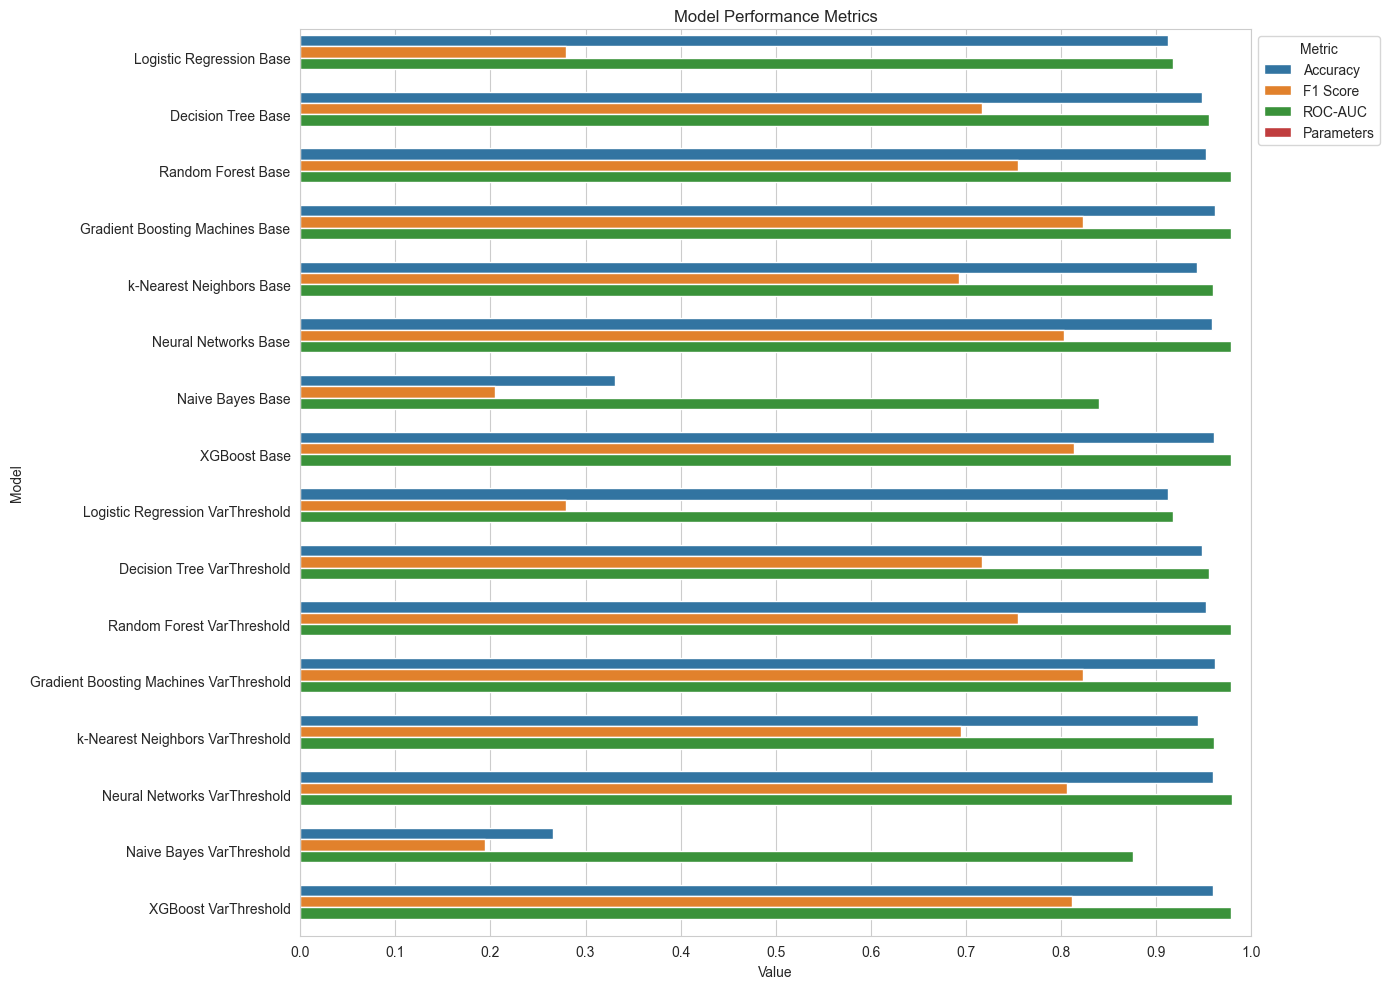

In [ ]:
plot_results(results_df, exclude_metrics=['Precision', 'Recall', 'TP', 'FP', 'TN', 'FN', 'Duration (seconds)'])

#### Correlation Matrix

In [ ]:
X_train_corr, X_test_corr, y_train_corr, y_test_corr = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [ ]:
X_train_corr_df = pd.DataFrame(X_train_corr, columns=preprocessor.get_feature_names_out())
X_test_corr_df = pd.DataFrame(X_test_corr, columns=preprocessor.get_feature_names_out())

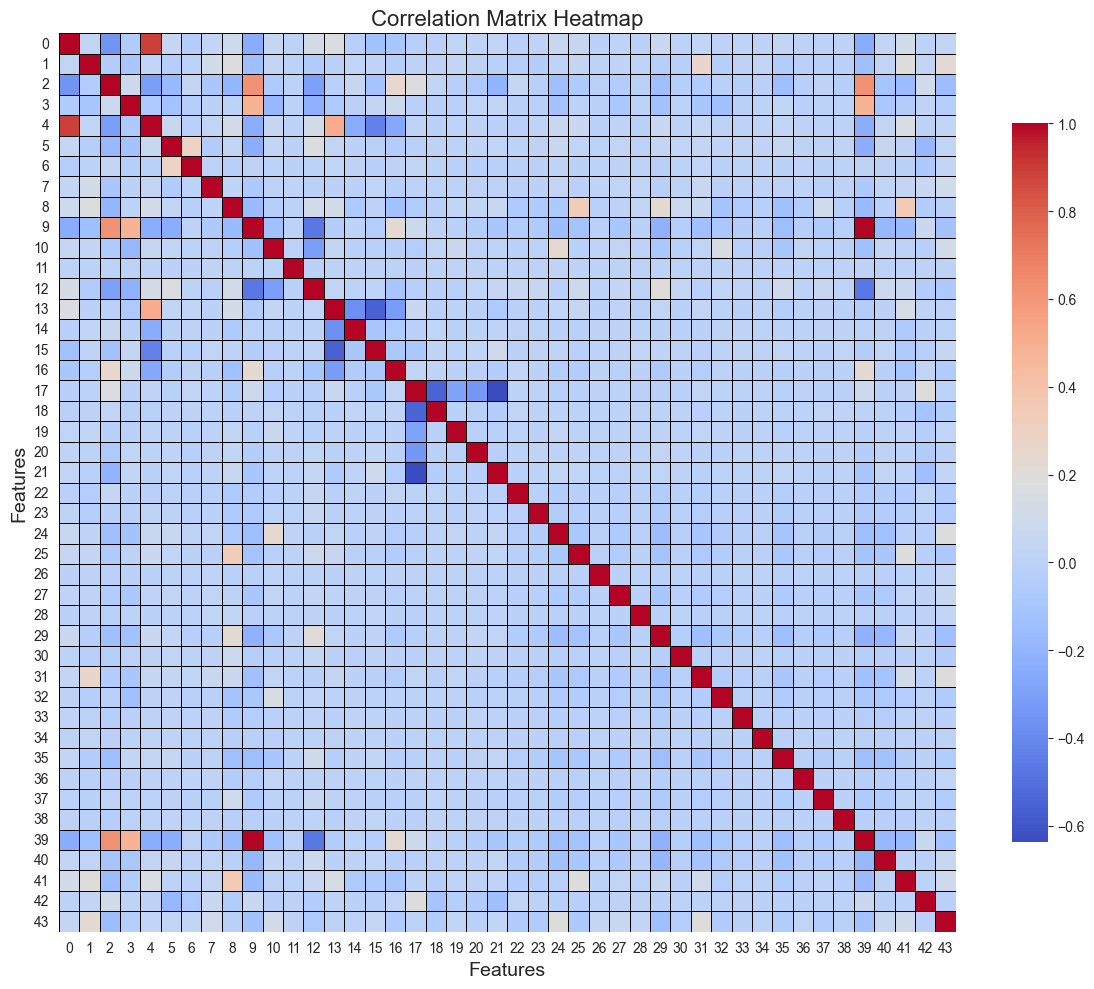

Correlation Matrix:

[[ 1.00000000e+00  2.35303192e-02 -3.51074332e-01 ...  1.14873937e-01
   5.94218884e-04  3.79994728e-02]
 [ 2.35303192e-02  1.00000000e+00 -5.27818401e-02 ...  1.89212811e-01
   2.60499523e-02  2.20564617e-01]
 [-3.51074332e-01 -5.27818401e-02  1.00000000e+00 ... -1.61606362e-01
   1.10731115e-01 -1.55300654e-01]
 ...
 [ 1.14873937e-01  1.89212811e-01 -1.61606362e-01 ...  1.00000000e+00
  -1.30757104e-04  9.84404260e-02]
 [ 5.94218884e-04  2.60499523e-02  1.10731115e-01 ... -1.30757104e-04
   1.00000000e+00 -1.64460204e-02]
 [ 3.79994728e-02  2.20564617e-01 -1.55300654e-01 ...  9.84404260e-02
  -1.64460204e-02  1.00000000e+00]]


In [ ]:
plot_correlation_heatmap(X_train_corr)

In [ ]:
"""
Problema con la funzione get_high_correlation_pairs_test(), ritorna sempre le coppie che hanno un valore maggiore di threshold anche quando questo è negativo. (Per provare inserisci soglia negativa)

Inserendo solo numeri positivi sembra funzionare correttamente, il problema c'è quando la soglia viene espressa con segno negativo.
"""

"\nProblema con la funzione get_high_correlation_pairs_test(), ritorna sempre le coppie che hanno un valore maggiore di threshold anche quando questo è negativo. (Per provare inserisci soglia negativa)\n\nInserendo solo numeri positivi sembra funzionare correttamente, il problema c'è quando la soglia viene espressa con segno negativo.\n"

In [ ]:
check_column_alignment(X_train_corr_df, X_train_corr)

True

In [ ]:
check_column_alignment(X_test_corr_df, X_test_corr)

True

In [ ]:
get_high_correlation_pairs(X_train_corr_df, threshold=0.7)

Feature_1                            Feature_2  \
435  cat_nom__NAME_INCOME_TYPE_Pensioner  cat_nom__OCCUPATION_TYPE_unemployed   
4                      num__CNT_CHILDREN                 num__CNT_FAM_MEMBERS   

     Correlation  
435         1.00  
4           0.89

In [ ]:
X_train_corr_df, X_test_corr_df, X_train_corr, X_test_corr = remove_feature('cat_nom__OCCUPATION_TYPE_unemployed',
                                                                            X_train_corr_df,
                                                                            X_test_corr_df,
                                                                            X_train_corr,
                                                                            X_test_corr)

Forma originale di X_train_array: (236898, 44)
Forma originale di X_test_array: (101528, 44)
Forma dopo la rimozione di X_train_array: (236898, 43)
Forma dopo la rimozione di X_test_array: (101528, 43)
Forma originale di X_train_df: (236898, 44)
Forma originale di X_test_df: (101528, 44)
Forma dopo la rimozione di X_train_df: (236898, 43)
Forma dopo la rimozione di X_test_df: (101528, 43)


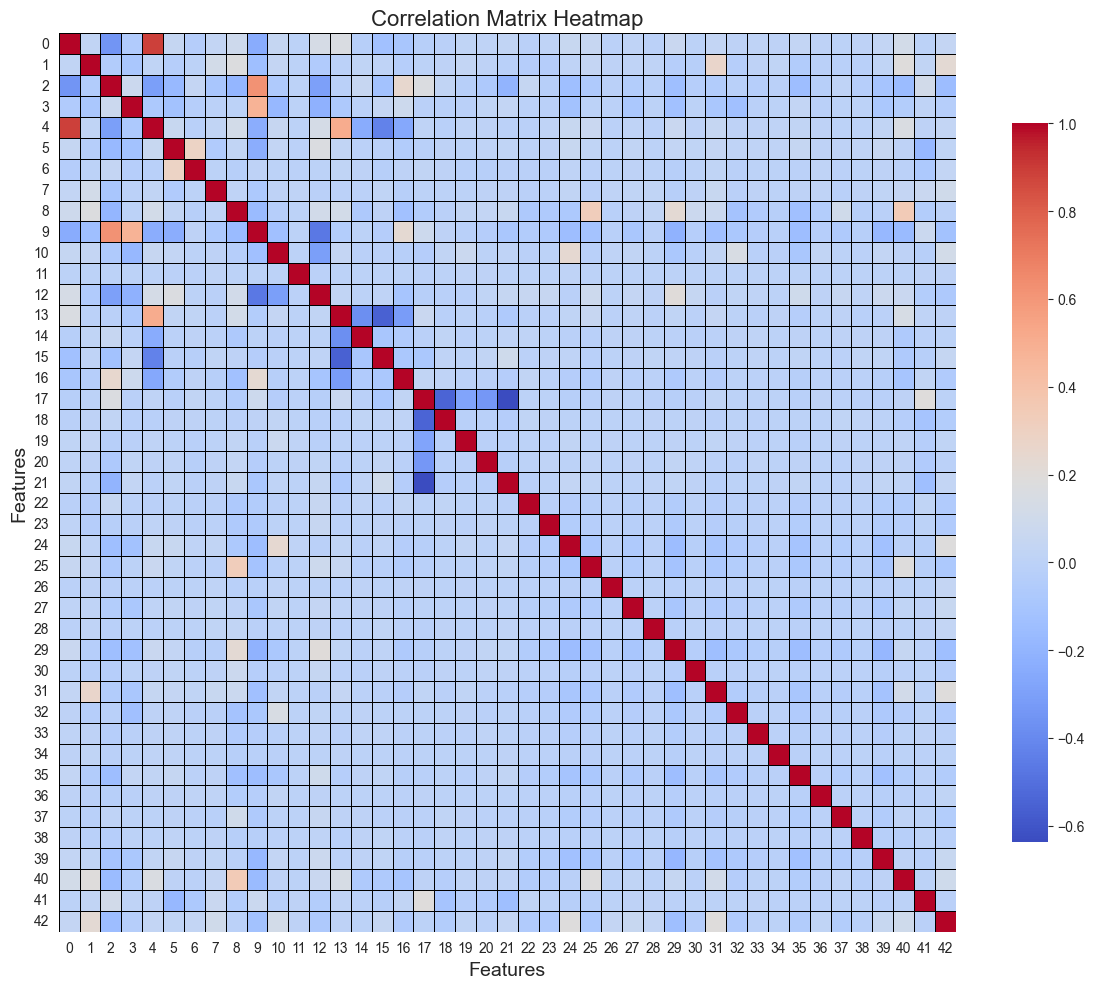

Correlation Matrix:

[[ 1.00000000e+00  2.35303192e-02 -3.51074332e-01 ...  1.14873937e-01
   5.94218884e-04  3.79994728e-02]
 [ 2.35303192e-02  1.00000000e+00 -5.27818401e-02 ...  1.89212811e-01
   2.60499523e-02  2.20564617e-01]
 [-3.51074332e-01 -5.27818401e-02  1.00000000e+00 ... -1.61606362e-01
   1.10731115e-01 -1.55300654e-01]
 ...
 [ 1.14873937e-01  1.89212811e-01 -1.61606362e-01 ...  1.00000000e+00
  -1.30757104e-04  9.84404260e-02]
 [ 5.94218884e-04  2.60499523e-02  1.10731115e-01 ... -1.30757104e-04
   1.00000000e+00 -1.64460204e-02]
 [ 3.79994728e-02  2.20564617e-01 -1.55300654e-01 ...  9.84404260e-02
  -1.64460204e-02  1.00000000e+00]]


In [ ]:
plot_correlation_heatmap(X_train_corr)

In [ ]:
get_high_correlation_pairs(X_train_corr_df, threshold=0.7)

Feature_1             Feature_2  Correlation
4  num__CNT_CHILDREN  num__CNT_FAM_MEMBERS         0.89

In [ ]:
X_train_corr_df, X_test_corr_df, X_train_corr, X_test_corr = remove_feature('num__CNT_CHILDREN',
                                                                            X_train_corr_df,
                                                                            X_test_corr_df,
                                                                            X_train_corr,
                                                                            X_test_corr)

Forma originale di X_train_array: (236898, 43)
Forma originale di X_test_array: (101528, 43)
Forma dopo la rimozione di X_train_array: (236898, 42)
Forma dopo la rimozione di X_test_array: (101528, 42)
Forma originale di X_train_df: (236898, 43)
Forma originale di X_test_df: (101528, 43)
Forma dopo la rimozione di X_train_df: (236898, 42)
Forma dopo la rimozione di X_test_df: (101528, 42)


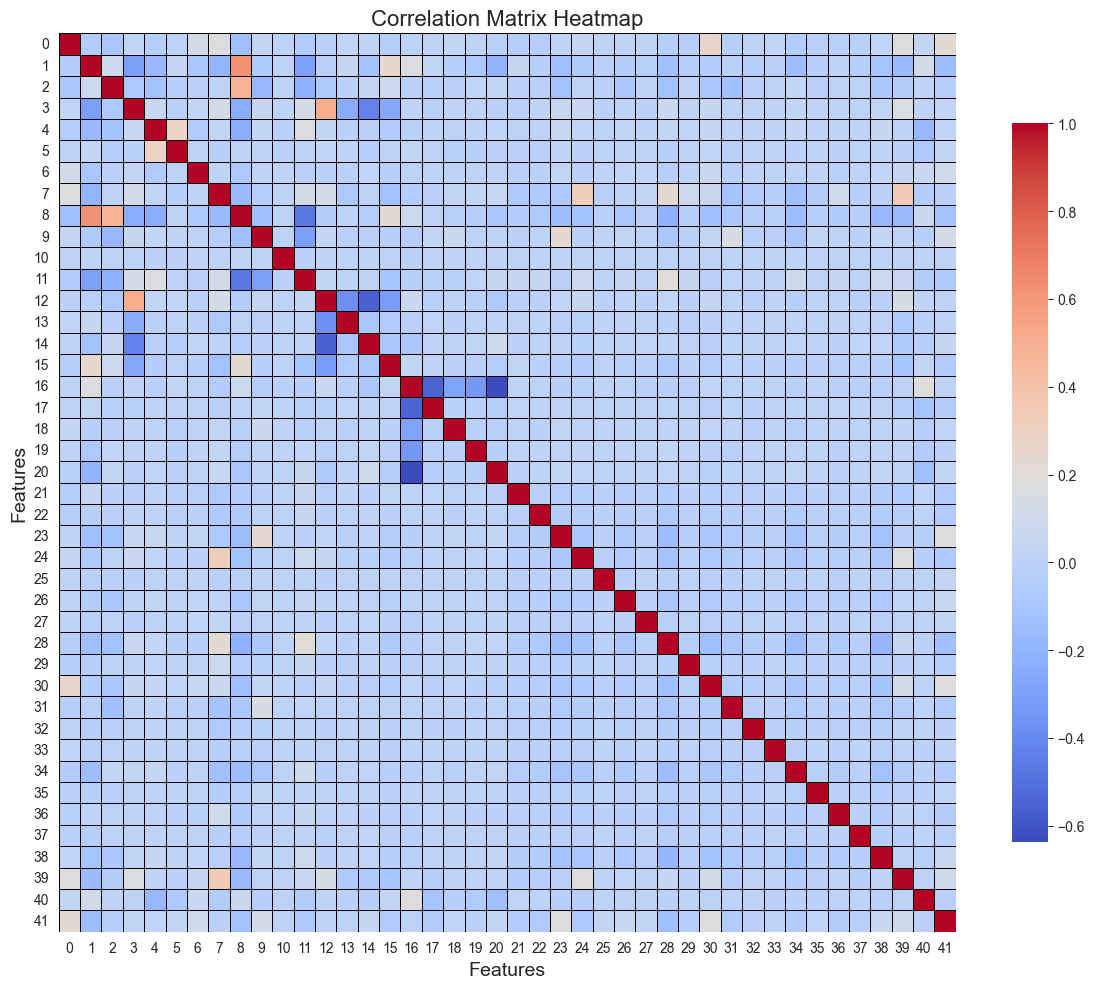

Correlation Matrix:

[[ 1.00000000e+00 -5.27818401e-02 -8.81274764e-02 ...  1.89212811e-01
   2.60499523e-02  2.20564617e-01]
 [-5.27818401e-02  1.00000000e+00  7.90959773e-02 ... -1.61606362e-01
   1.10731115e-01 -1.55300654e-01]
 [-8.81274764e-02  7.90959773e-02  1.00000000e+00 ... -4.29511427e-02
   1.41908775e-02 -3.30166709e-02]
 ...
 [ 1.89212811e-01 -1.61606362e-01 -4.29511427e-02 ...  1.00000000e+00
  -1.30757104e-04  9.84404260e-02]
 [ 2.60499523e-02  1.10731115e-01  1.41908775e-02 ... -1.30757104e-04
   1.00000000e+00 -1.64460204e-02]
 [ 2.20564617e-01 -1.55300654e-01 -3.30166709e-02 ...  9.84404260e-02
  -1.64460204e-02  1.00000000e+00]]


In [ ]:
plot_correlation_heatmap(X_train_corr)

In [ ]:
get_high_correlation_pairs(X_train_corr_df, threshold=0.6)

Feature_1  \
50                       num__DAYS_BIRTH_POSITIVE   
692  cat_nom__NAME_HOUSING_TYPE_House / apartment   

                                   Feature_2  Correlation  
50       cat_nom__NAME_INCOME_TYPE_Pensioner         0.62  
692  cat_nom__NAME_HOUSING_TYPE_With parents        -0.64

#### Models (CorrelationFiltering)

In [ ]:
# Models to evaluate
models_corr = {
    "Logistic Regression CorrelationFiltering": LogisticRegression(random_state=SEED),
    "Decision Tree CorrelationFiltering": DecisionTreeClassifier(random_state=SEED),
    "Random Forest CorrelationFiltering": RandomForestClassifier(random_state=SEED),
    "Gradient Boosting Machines CorrelationFiltering": GradientBoostingClassifier(random_state=SEED),
    "k-Nearest Neighbors CorrelationFiltering": KNeighborsClassifier(),
    "Neural Networks CorrelationFiltering": MLPClassifier(random_state=SEED),
    "Naive Bayes CorrelationFiltering": GaussianNB(),
    "XGBoost CorrelationFiltering": xgb.XGBClassifier(random_state=SEED)
}

In [ ]:
results_df = evaluate_models(models_corr, X_train_corr, y_train_corr, X_test_corr, y_test_corr, results_df)

Evaluating Models:  12%|████████▏                                                        | 1/8 [00:01<00:10,  1.43s/it]

Logistic Regression CorrelationFiltering Accuracy: 0.91209
Logistic Regression CorrelationFiltering F1 Score: 0.27890
Logistic Regression CorrelationFiltering Precision: 0.50869
Logistic Regression CorrelationFiltering Recall: 0.19212
Logistic Regression CorrelationFiltering ROC-AUC: 0.91820



Evaluating Models:  25%|████████████████▎                                                | 2/8 [00:02<00:06,  1.15s/it]

Decision Tree CorrelationFiltering Accuracy: 0.94863
Decision Tree CorrelationFiltering F1 Score: 0.71750
Decision Tree CorrelationFiltering Precision: 0.69873
Decision Tree CorrelationFiltering Recall: 0.73731
Decision Tree CorrelationFiltering ROC-AUC: 0.95583



Evaluating Models:  38%|████████████████████████▍                                        | 3/8 [00:18<00:39,  7.91s/it]

Random Forest CorrelationFiltering Accuracy: 0.95286
Random Forest CorrelationFiltering F1 Score: 0.75482
Random Forest CorrelationFiltering Precision: 0.69922
Random Forest CorrelationFiltering Recall: 0.82001
Random Forest CorrelationFiltering ROC-AUC: 0.97909



Evaluating Models:  50%|████████████████████████████████▌                                | 4/8 [01:08<01:37, 24.47s/it]

Gradient Boosting Machines CorrelationFiltering Accuracy: 0.96191
Gradient Boosting Machines CorrelationFiltering F1 Score: 0.82282
Gradient Boosting Machines CorrelationFiltering Precision: 0.69924
Gradient Boosting Machines CorrelationFiltering Recall: 0.99944
Gradient Boosting Machines CorrelationFiltering ROC-AUC: 0.97918



Evaluating Models:  62%|████████████████████████████████████████▋                        | 5/8 [02:05<01:48, 36.15s/it]

k-Nearest Neighbors CorrelationFiltering Accuracy: 0.94367
k-Nearest Neighbors CorrelationFiltering F1 Score: 0.69370
k-Nearest Neighbors CorrelationFiltering Precision: 0.66852
k-Nearest Neighbors CorrelationFiltering Recall: 0.72084
k-Nearest Neighbors CorrelationFiltering ROC-AUC: 0.96016



Evaluating Models:  75%|████████████████████████████████████████████████▊                | 6/8 [02:48<01:17, 38.68s/it]

Neural Networks CorrelationFiltering Accuracy: 0.95989
Neural Networks CorrelationFiltering F1 Score: 0.80854
Neural Networks CorrelationFiltering Precision: 0.69993
Neural Networks CorrelationFiltering Recall: 0.95703
Neural Networks CorrelationFiltering ROC-AUC: 0.97893



Evaluating Models:  88%|████████████████████████████████████████████████████████▉        | 7/8 [02:49<00:26, 26.15s/it]

Naive Bayes CorrelationFiltering Accuracy: 0.43204
Naive Bayes CorrelationFiltering F1 Score: 0.23088
Naive Bayes CorrelationFiltering Precision: 0.13116
Naive Bayes CorrelationFiltering Recall: 0.96338
Naive Bayes CorrelationFiltering ROC-AUC: 0.83933



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 8/8 [02:50<00:00, 21.30s/it]

XGBoost CorrelationFiltering Accuracy: 0.96088
XGBoost CorrelationFiltering F1 Score: 0.81529
XGBoost CorrelationFiltering Precision: 0.70016
XGBoost CorrelationFiltering Recall: 0.97573
XGBoost CorrelationFiltering ROC-AUC: 0.97893




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)


In [ ]:
save_dataframe_to_csv(results_df, 'results_df.csv')

In [ ]:
results_df

Model Accuracy F1 Score  \
0                          Logistic Regression Base  0.91205  0.27951   
1                                Decision Tree Base  0.94861  0.71737   
2                                Random Forest Base  0.95282  0.75446   
3                   Gradient Boosting Machines Base  0.96191  0.82282   
4                          k-Nearest Neighbors Base  0.94342  0.69221   
5                              Neural Networks Base  0.95915  0.80285   
6                                  Naive Bayes Base  0.33095  0.20498   
7                                      XGBoost Base  0.96057  0.81318   
8                  Logistic Regression VarThreshold  0.91209  0.27902   
9                        Decision Tree VarThreshold  0.94852  0.71717   
10                       Random Forest VarThreshold  0.95290  0.75517   
11          Gradient Boosting Machines VarThreshold  0.96189  0.82266   
12                 k-Nearest Neighbors VarThreshold  0.94390  0.69517   
13                     Neural Networks VarThreshold  0.95957  0.80579   
14                         Naive Bayes VarThreshold  0.26582  0.19401   
15                             XGBoost VarThreshold  0.96023  0.81154   
16         Logistic Regression CorrelationFiltering  0.91209  0.27890   
17               Decision Tree CorrelationFiltering  0.94863  0.71750   
18               Random Forest CorrelationFiltering  0.95286  0.75482   
19  Gradient Boosting Machines CorrelationFiltering  0.96191  0.82282   
20         k-Nearest Neighbors CorrelationFiltering  0.94367  0.69370   
21             Neural Networks CorrelationFiltering  0.95989  0.80854   
22                 Naive Bayes CorrelationFiltering  0.43204  0.23088   
23                     XGBoost CorrelationFiltering  0.96088  0.81529   

   Precision   Recall  ROC-AUC    TP     FP     TN    FN  Duration (seconds)  \
0    0.50807  0.19279  0.91821  1732   1677  90867  7252                1.34   
1    0.69867  0.73709  0.95550  6622   2856  89688  2362                0.98   
2    0.69926  0.81912  0.97911  7359   3165  89379  1625               16.00   
3    0.69924  0.99944  0.97918  8979   3862  88682     5               52.32   
4    0.66739  0.71894  0.95986  6459   3219  89325  2525               58.74   
5    0.70069  0.93989  0.97916  8444   3607  88937   540               55.66   
6    0.11453  0.97473  0.83992  8757  67700  24844   227                0.37   
7    0.70015  0.96972  0.97894  8712   3731  88813   272                1.61   
8    0.50869  0.19223  0.91784  1727   1668  90876  7257                0.91   
9    0.69780  0.73764  0.95593  6627   2870  89674  2357                0.64   
10   0.69918  0.82090  0.97911  7375   3173  89371  1609               12.05   
11   0.69929  0.99889  0.97927  8974   3859  88685    10               27.00   
12   0.66945  0.72295  0.96068  6495   3207  89337  2489               53.68   
13   0.70073  0.94791  0.97932  8516   3637  88907   468               40.79   
14   0.10744  0.99855  0.87563  8971  74527  18017    13                0.28   
15   0.69876  0.96772  0.97905  8694   3748  88796   290                1.21   
16   0.50869  0.19212  0.91820  1726   1667  90877  7258                1.43   
17   0.69873  0.73731  0.95583  6624   2856  89688  2360                0.95   
18   0.69922  0.82001  0.97909  7367   3169  89375  1617               15.97   
19   0.69924  0.99944  0.97918  8979   3862  88682     5               49.84   
20   0.66852  0.72084  0.96016  6476   3211  89333  2508               56.87   
21   0.69993  0.95703  0.97893  8598   3686  88858   386               43.60   
22   0.13116  0.96338  0.83933  8655  57335  35209   329                0.35   
23   0.70016  0.97573  0.97893  8766   3754  88790   218                1.42   

                                           Parameters  
0                                                 NaN  
1                                                 NaN  
2                                                 N

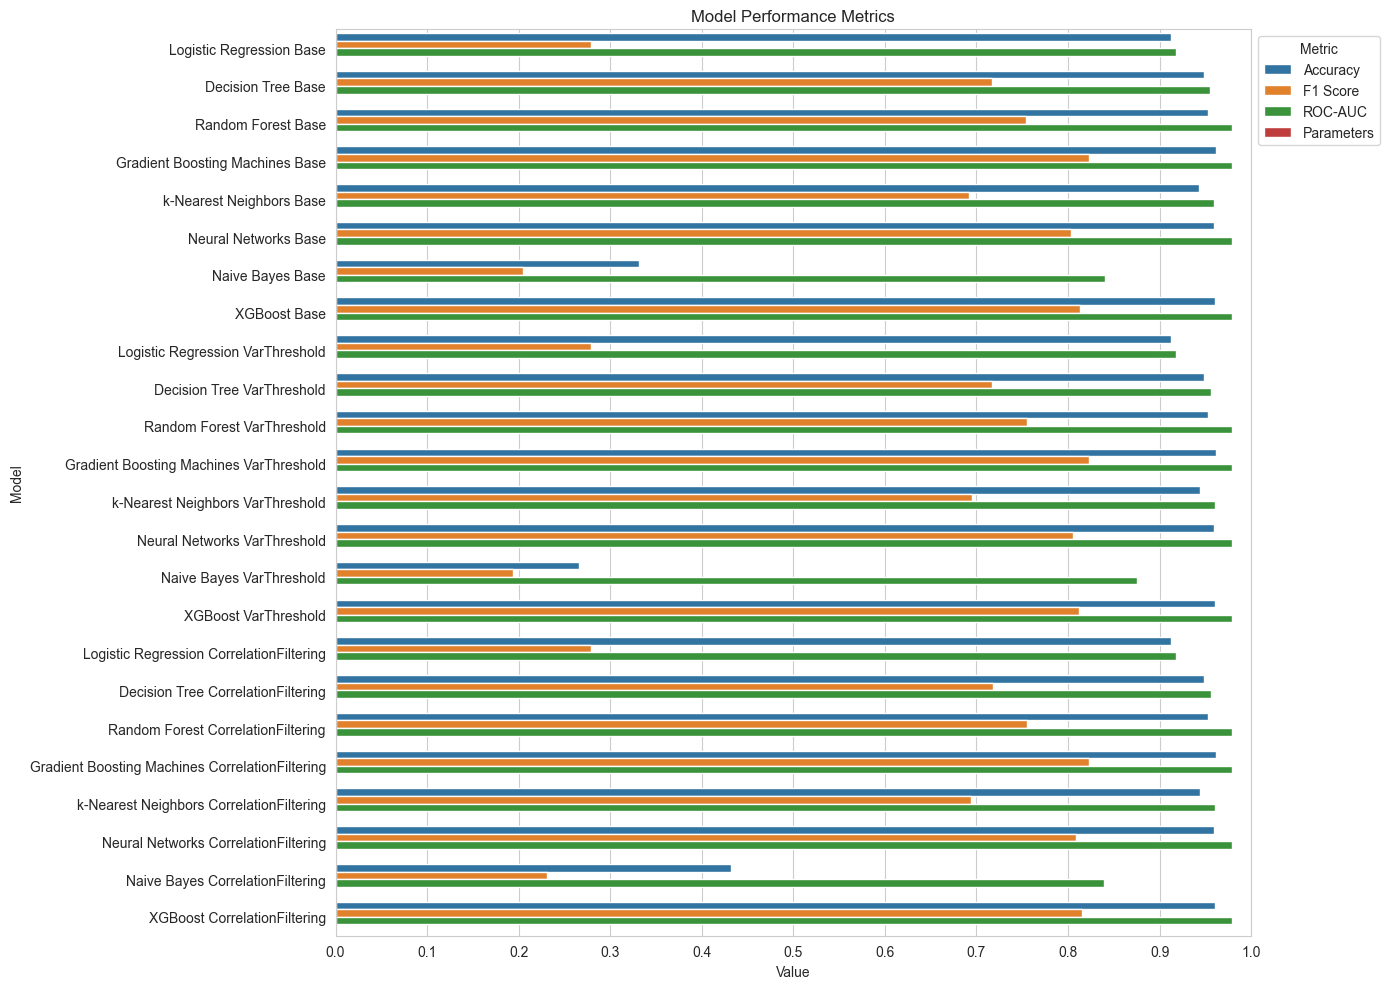

In [ ]:
plot_results(results_df, exclude_metrics=['Precision', 'Recall', 'TP', 'FP', 'TN', 'FN', 'Duration (seconds)'])

#### VIF

In [ ]:
X_train_vif, X_test_vif, y_train_vif, y_test_vif = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [ ]:
X_train_vif_df = pd.DataFrame(X_train_vif, columns=preprocessor.get_feature_names_out())
X_test_vif_df = pd.DataFrame(X_test_vif, columns=preprocessor.get_feature_names_out())

In [ ]:
check_column_alignment(X_train_vif_df, X_train_vif)

True

In [ ]:
check_column_alignment(X_test_vif_df, X_test_vif)

True

In [ ]:
vif_df = calculate_vif(X_train_vif_df)
print(vif_df)

C:\Users\Gcarl\anaconda3\envs\creditworthiness_project\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\Gcarl\anaconda3\envs\creditworthiness_project\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                             Feature            VIF
1                                  num__CNT_CHILDREN            inf
2                              num__AMT_INCOME_TOTAL           1.21
3                           num__DAYS_BIRTH_POSITIVE           2.20
4                                 num__DAYS_EMPLOYED           1.53
5                               num__CNT_FAM_MEMBERS            inf
6                         cat_nom__FLAG_WORK_PHONE_Y           1.22
7                              cat_nom__FLAG_PHONE_Y           1.11
8                              cat_nom__FLAG_EMAIL_Y           1.04
9                             cat_nom__CODE_GENDER_M           1.52
10               cat_nom__NAME_INCOME_TYPE_Pensioner 23539802096.35
11           cat_nom__NAME_INCOME_TYPE_State servant           1.38
12                 cat_nom__NAME_INCOME_TYPE_Student           1.00
13                 cat_nom__NAME_INCOME_TYPE_Working           1.65
14               cat_nom__NAME_FAMILY_STATUS_Mar

In [ ]:
X_train_vif_df, X_test_vif_df, X_train_vif, X_test_vif = remove_feature('num__CNT_CHILDREN',
                                                                        X_train_vif_df,
                                                                        X_test_vif_df,
                                                                        X_train_vif,
                                                                        X_test_vif)

Forma originale di X_train_array: (236898, 44)
Forma originale di X_test_array: (101528, 44)
Forma dopo la rimozione di X_train_array: (236898, 43)
Forma dopo la rimozione di X_test_array: (101528, 43)
Forma originale di X_train_df: (236898, 44)
Forma originale di X_test_df: (101528, 44)
Forma dopo la rimozione di X_train_df: (236898, 43)
Forma dopo la rimozione di X_test_df: (101528, 43)


In [ ]:
vif_df = calculate_vif(X_train_vif_df)
print(vif_df)

C:\Users\Gcarl\anaconda3\envs\creditworthiness_project\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                             Feature   VIF
1                              num__AMT_INCOME_TOTAL  1.21
2                           num__DAYS_BIRTH_POSITIVE  2.20
3                                 num__DAYS_EMPLOYED  1.53
4                               num__CNT_FAM_MEMBERS  1.83
5                         cat_nom__FLAG_WORK_PHONE_Y  1.22
6                              cat_nom__FLAG_PHONE_Y  1.11
7                              cat_nom__FLAG_EMAIL_Y  1.04
8                             cat_nom__CODE_GENDER_M  1.52
9                cat_nom__NAME_INCOME_TYPE_Pensioner   inf
10           cat_nom__NAME_INCOME_TYPE_State servant  1.38
11                 cat_nom__NAME_INCOME_TYPE_Student  1.00
12                 cat_nom__NAME_INCOME_TYPE_Working  1.65
13               cat_nom__NAME_FAMILY_STATUS_Married  2.93
14             cat_nom__NAME_FAMILY_STATUS_Separated  1.75
15  cat_nom__NAME_FAMILY_STATUS_Single / not married  2.58
16                 cat_nom__NAME_FAMILY_STATUS_Widow  1.

In [ ]:
X_train_vif_df, X_test_vif_df, X_train_vif, X_test_vif = remove_feature('cat_nom__OCCUPATION_TYPE_unemployed',
                                                                        X_train_vif_df,
                                                                        X_test_vif_df,
                                                                        X_train_vif,
                                                                        X_test_vif)

Forma originale di X_train_array: (236898, 43)
Forma originale di X_test_array: (101528, 43)
Forma dopo la rimozione di X_train_array: (236898, 42)
Forma dopo la rimozione di X_test_array: (101528, 42)
Forma originale di X_train_df: (236898, 43)
Forma originale di X_test_df: (101528, 43)
Forma dopo la rimozione di X_train_df: (236898, 42)
Forma dopo la rimozione di X_test_df: (101528, 42)


In [ ]:
vif_df = calculate_vif(X_train_vif_df)
print(vif_df)

                                             Feature   VIF
1                              num__AMT_INCOME_TOTAL  1.21
2                           num__DAYS_BIRTH_POSITIVE  2.20
3                                 num__DAYS_EMPLOYED  1.53
4                               num__CNT_FAM_MEMBERS  1.83
5                         cat_nom__FLAG_WORK_PHONE_Y  1.22
6                              cat_nom__FLAG_PHONE_Y  1.11
7                              cat_nom__FLAG_EMAIL_Y  1.04
8                             cat_nom__CODE_GENDER_M  1.52
9                cat_nom__NAME_INCOME_TYPE_Pensioner  6.71
10           cat_nom__NAME_INCOME_TYPE_State servant  1.38
11                 cat_nom__NAME_INCOME_TYPE_Student  1.00
12                 cat_nom__NAME_INCOME_TYPE_Working  1.65
13               cat_nom__NAME_FAMILY_STATUS_Married  2.93
14             cat_nom__NAME_FAMILY_STATUS_Separated  1.75
15  cat_nom__NAME_FAMILY_STATUS_Single / not married  2.58
16                 cat_nom__NAME_FAMILY_STATUS_Widow  1.

In [ ]:
X_train_vif_df, X_test_vif_df, X_train_vif, X_test_vif = remove_feature('cat_nom__NAME_HOUSING_TYPE_House / apartment',
                                                                        X_train_vif_df,
                                                                        X_test_vif_df,
                                                                        X_train_vif,
                                                                        X_test_vif)

Forma originale di X_train_array: (236898, 42)
Forma originale di X_test_array: (101528, 42)
Forma dopo la rimozione di X_train_array: (236898, 41)
Forma dopo la rimozione di X_test_array: (101528, 41)
Forma originale di X_train_df: (236898, 42)
Forma originale di X_test_df: (101528, 42)
Forma dopo la rimozione di X_train_df: (236898, 41)
Forma dopo la rimozione di X_test_df: (101528, 41)


In [ ]:
vif_df = calculate_vif(X_train_vif_df)
print(vif_df)

                                             Feature  VIF
1                              num__AMT_INCOME_TOTAL 1.21
2                           num__DAYS_BIRTH_POSITIVE 2.20
3                                 num__DAYS_EMPLOYED 1.53
4                               num__CNT_FAM_MEMBERS 1.83
5                         cat_nom__FLAG_WORK_PHONE_Y 1.21
6                              cat_nom__FLAG_PHONE_Y 1.11
7                              cat_nom__FLAG_EMAIL_Y 1.04
8                             cat_nom__CODE_GENDER_M 1.52
9                cat_nom__NAME_INCOME_TYPE_Pensioner 6.71
10           cat_nom__NAME_INCOME_TYPE_State servant 1.38
11                 cat_nom__NAME_INCOME_TYPE_Student 1.00
12                 cat_nom__NAME_INCOME_TYPE_Working 1.65
13               cat_nom__NAME_FAMILY_STATUS_Married 2.93
14             cat_nom__NAME_FAMILY_STATUS_Separated 1.75
15  cat_nom__NAME_FAMILY_STATUS_Single / not married 2.58
16                 cat_nom__NAME_FAMILY_STATUS_Widow 1.64
17    cat_nom_

In [ ]:
X_train_vif_df, X_test_vif_df, X_train_vif, X_test_vif = remove_feature('cat_nom__NAME_INCOME_TYPE_Pensioner',
                                                                        X_train_vif_df,
                                                                        X_test_vif_df,
                                                                        X_train_vif,
                                                                        X_test_vif)

Forma originale di X_train_array: (236898, 41)
Forma originale di X_test_array: (101528, 41)
Forma dopo la rimozione di X_train_array: (236898, 40)
Forma dopo la rimozione di X_test_array: (101528, 40)
Forma originale di X_train_df: (236898, 41)
Forma originale di X_test_df: (101528, 41)
Forma dopo la rimozione di X_train_df: (236898, 40)
Forma dopo la rimozione di X_test_df: (101528, 40)


In [ ]:
vif_df = calculate_vif(X_train_vif_df)
print(vif_df)

                                             Feature  VIF
1                              num__AMT_INCOME_TOTAL 1.19
2                           num__DAYS_BIRTH_POSITIVE 1.93
3                                 num__DAYS_EMPLOYED 1.39
4                               num__CNT_FAM_MEMBERS 1.83
5                         cat_nom__FLAG_WORK_PHONE_Y 1.21
6                              cat_nom__FLAG_PHONE_Y 1.11
7                              cat_nom__FLAG_EMAIL_Y 1.04
8                             cat_nom__CODE_GENDER_M 1.51
9            cat_nom__NAME_INCOME_TYPE_State servant 1.37
10                 cat_nom__NAME_INCOME_TYPE_Student 1.00
11                 cat_nom__NAME_INCOME_TYPE_Working 1.57
12               cat_nom__NAME_FAMILY_STATUS_Married 2.93
13             cat_nom__NAME_FAMILY_STATUS_Separated 1.75
14  cat_nom__NAME_FAMILY_STATUS_Single / not married 2.58
15                 cat_nom__NAME_FAMILY_STATUS_Widow 1.63
16    cat_nom__NAME_HOUSING_TYPE_Municipal apartment 1.02
17       cat_n

#### Models (VIF_Filtering)

In [ ]:
# Models to evaluate
models_vif = {
    "Logistic Regression vif": LogisticRegression(random_state=SEED),
    "Decision Tree vif": DecisionTreeClassifier(random_state=SEED),
    "Random Forest vif": RandomForestClassifier(random_state=SEED),
    "Gradient Boosting Machines vif": GradientBoostingClassifier(random_state=SEED),
    "k-Nearest Neighbors vif": KNeighborsClassifier(),
    "Neural Networks vif": MLPClassifier(random_state=SEED),
    "Naive Bayes vif": GaussianNB(),
    "XGBoost vif": xgb.XGBClassifier(random_state=SEED)
}

In [ ]:
results_df = evaluate_models(models_vif, X_train_vif, y_train_vif, X_test_vif, y_test_vif, results_df)

Evaluating Models:  12%|████████▏                                                        | 1/8 [00:01<00:11,  1.62s/it]

Logistic Regression vif Accuracy: 0.91147
Logistic Regression vif F1 Score: 0.26927
Logistic Regression vif Precision: 0.49940
Logistic Regression vif Recall: 0.18433
Logistic Regression vif ROC-AUC: 0.90459



Evaluating Models:  25%|████████████████▎                                                | 2/8 [00:02<00:07,  1.22s/it]

Decision Tree vif Accuracy: 0.94856
Decision Tree vif F1 Score: 0.71702
Decision Tree vif Precision: 0.69851
Decision Tree vif Recall: 0.73653
Decision Tree vif ROC-AUC: 0.95611



Evaluating Models:  38%|████████████████████████▍                                        | 3/8 [00:18<00:39,  7.89s/it]

Random Forest vif Accuracy: 0.95290
Random Forest vif F1 Score: 0.75507
Random Forest vif Precision: 0.69934
Random Forest vif Recall: 0.82046
Random Forest vif ROC-AUC: 0.97911



Evaluating Models:  50%|████████████████████████████████▌                                | 4/8 [01:06<01:34, 23.70s/it]

Gradient Boosting Machines vif Accuracy: 0.96188
Gradient Boosting Machines vif F1 Score: 0.82264
Gradient Boosting Machines vif Precision: 0.69921
Gradient Boosting Machines vif Recall: 0.99900
Gradient Boosting Machines vif ROC-AUC: 0.97927



Evaluating Models:  62%|████████████████████████████████████████▋                        | 5/8 [02:02<01:46, 35.49s/it]

k-Nearest Neighbors vif Accuracy: 0.94410
k-Nearest Neighbors vif F1 Score: 0.69599
k-Nearest Neighbors vif Precision: 0.67087
k-Nearest Neighbors vif Recall: 0.72306
k-Nearest Neighbors vif ROC-AUC: 0.96041



Evaluating Models:  75%|████████████████████████████████████████████████▊                | 6/8 [02:46<01:16, 38.31s/it]

Neural Networks vif Accuracy: 0.95966
Neural Networks vif F1 Score: 0.80661
Neural Networks vif Precision: 0.70039
Neural Networks vif Recall: 0.95080
Neural Networks vif ROC-AUC: 0.97922



Evaluating Models:  88%|████████████████████████████████████████████████████████▉        | 7/8 [02:46<00:25, 25.93s/it]

Naive Bayes vif Accuracy: 0.82683
Naive Bayes vif F1 Score: 0.36646
Naive Bayes vif Precision: 0.27094
Naive Bayes vif Recall: 0.56601
Naive Bayes vif ROC-AUC: 0.81730



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 8/8 [02:48<00:00, 21.04s/it]

XGBoost vif Accuracy: 0.96062
XGBoost vif F1 Score: 0.81375
XGBoost vif Precision: 0.69973
XGBoost vif Recall: 0.97217
XGBoost vif ROC-AUC: 0.97894




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)


In [ ]:
save_dataframe_to_csv(results_df, 'results_df.csv')

In [ ]:
results_df

Model Accuracy F1 Score  \
0                          Logistic Regression Base  0.91205  0.27951   
1                                Decision Tree Base  0.94861  0.71737   
2                                Random Forest Base  0.95282  0.75446   
3                   Gradient Boosting Machines Base  0.96191  0.82282   
4                          k-Nearest Neighbors Base  0.94342  0.69221   
5                              Neural Networks Base  0.95915  0.80285   
6                                  Naive Bayes Base  0.33095  0.20498   
7                                      XGBoost Base  0.96057  0.81318   
8                  Logistic Regression VarThreshold  0.91209  0.27902   
9                        Decision Tree VarThreshold  0.94852  0.71717   
10                       Random Forest VarThreshold  0.95290  0.75517   
11          Gradient Boosting Machines VarThreshold  0.96189  0.82266   
12                 k-Nearest Neighbors VarThreshold  0.94390  0.69517   
13                     Neural Networks VarThreshold  0.95957  0.80579   
14                         Naive Bayes VarThreshold  0.26582  0.19401   
15                             XGBoost VarThreshold  0.96023  0.81154   
16         Logistic Regression CorrelationFiltering  0.91209  0.27890   
17               Decision Tree CorrelationFiltering  0.94863  0.71750   
18               Random Forest CorrelationFiltering  0.95286  0.75482   
19  Gradient Boosting Machines CorrelationFiltering  0.96191  0.82282   
20         k-Nearest Neighbors CorrelationFiltering  0.94367  0.69370   
21             Neural Networks CorrelationFiltering  0.95989  0.80854   
22                 Naive Bayes CorrelationFiltering  0.43204  0.23088   
23                     XGBoost CorrelationFiltering  0.96088  0.81529   
24                          Logistic Regression vif  0.91147  0.26927   
25                                Decision Tree vif  0.94856  0.71702   
26                                Random Forest vif  0.95290  0.75507   
27                   Gradient Boosting Machines vif  0.96188  0.82264   
28                          k-Nearest Neighbors vif  0.94410  0.69599   
29                              Neural Networks vif  0.95966  0.80661   
30                                  Naive Bayes vif  0.82683  0.36646   
31                                      XGBoost vif  0.96062  0.81375   

   Precision   Recall  ROC-AUC    TP     FP     TN    FN  Duration (seconds)  \
0    0.50807  0.19279  0.91821  1732   1677  90867  7252                1.34   
1    0.69867  0.73709  0.95550  6622   2856  89688  2362                0.98   
2    0.69926  0.81912  0.97911  7359   3165  89379  1625               16.00   
3    0.69924  0.99944  0.97918  8979   3862  88682     5               52.32   
4    0.66739  0.71894  0.95986  6459   3219  89325  2525               58.74   
5    0.70069  0.93989  0.97916  8444   3607  88937   540               55.66   
6    0.11453  0.97473  0.83992  8757  67700  24844   227                0.37   
7    0.70015  0.96972  0.97894  8712   3731  88813   272                1.61   
8    0.50869  0.19223  0.91784  1727   1668  90876  7257                0.91   
9    0.69780  0.73764  0.95593  6627   2870  89674  2357                0.64   
10   0.69918  0.82090  0.97911  7375   3173  89371  1609               12.05   
11   0.69929  0.99889  0.97927  8974   3859  88685    10               27.00   
12   0.66945  0.72295  0.96068  6495   3207  89337  2489               53.68   
13   0.70073  0.94791  0.97932  8516   3637  88907   468               40.79   
14   0.10744  0.99855  0.87563  8971  74527  18017    13                0.28   
15   0.69876  0.96772  0.97905  8694   3748  88796   290                1.21   
16   0.50869  0.19212  0.91820  1726   1667  90877  7258                1.43   
17   0.69873  0.73731  0.95583  6624   2856  89688  2360                0.95   
18   0.69922  0.82001  0.97909  7367   3169  89375  1617               15.97   
19   0.69924  0.99944  0.97918  8979

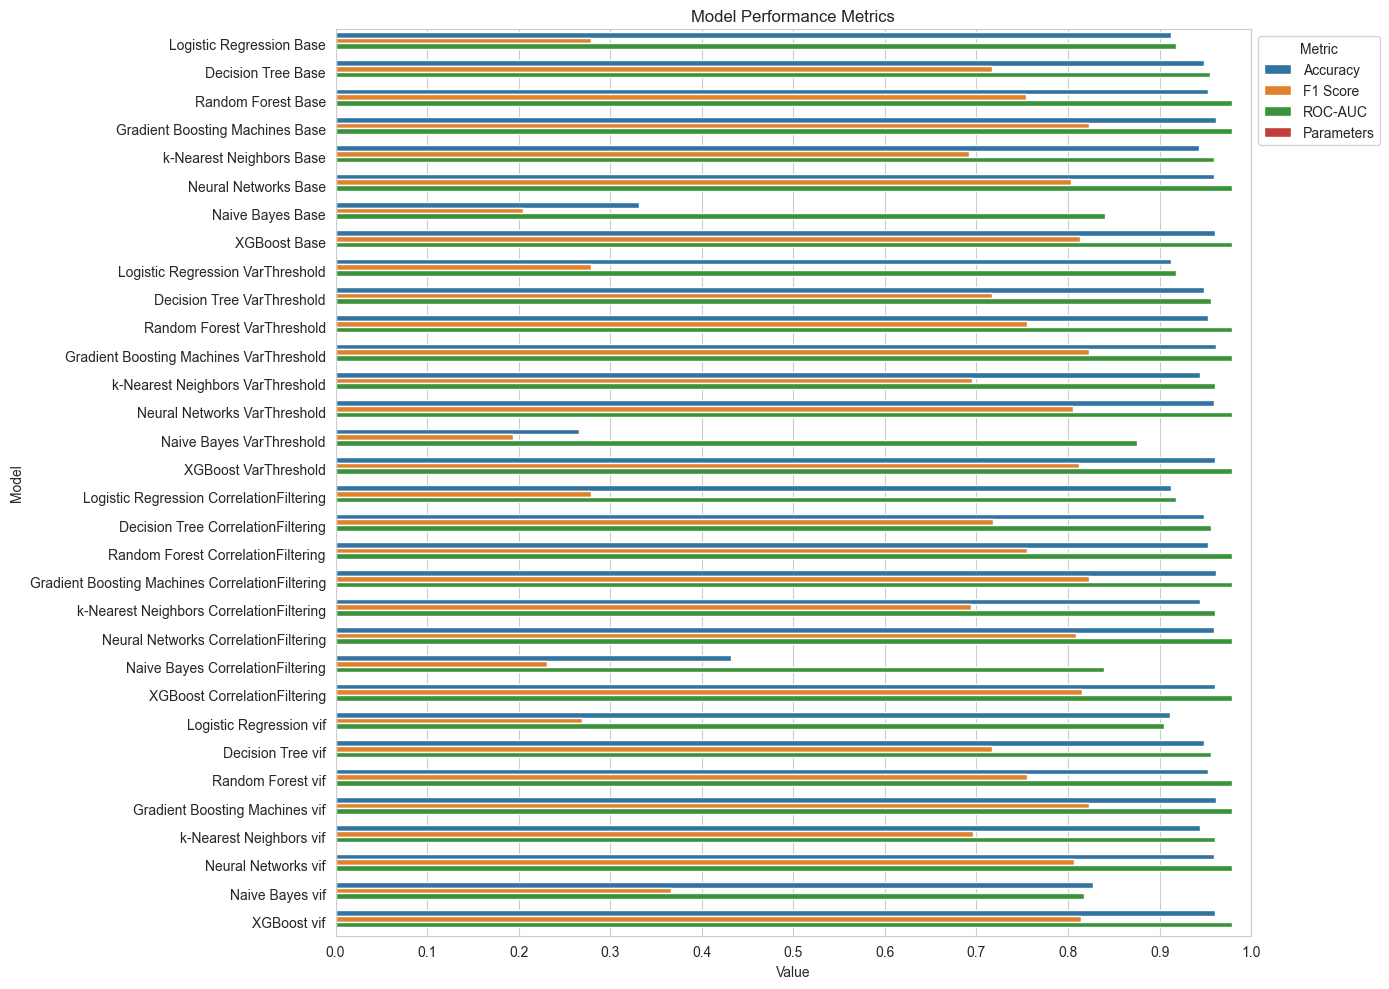

In [ ]:
plot_results(results_df, exclude_metrics=['Precision', 'Recall', 'TP', 'FP', 'TN', 'FN', 'Duration (seconds)'])

#### K-best (Mutual Information)

In [ ]:
X_train_kbest, X_test_kbest, y_train_kbest, y_test_kbest = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [ ]:
X_train_kbest_df = pd.DataFrame(X_train_kbest, columns=preprocessor.get_feature_names_out())
X_test_kbest_df = pd.DataFrame(X_test_kbest, columns=preprocessor.get_feature_names_out())

#### Models (K-best)

In [ ]:
k_values = [5, 10, 15, 20, 25, 30, 35, 40]

for k in k_values:

    # Models to evaluate
    models_kbest = {
        f"Logistic Regression kbest k:{k}": LogisticRegression(random_state=SEED),
        f"Decision Tree kbest k:{k}": DecisionTreeClassifier(random_state=SEED),
        f"Random Forest kbest k:{k}": RandomForestClassifier(random_state=SEED),
        f"Gradient Boosting Machines kbest k:{k}": GradientBoostingClassifier(random_state=SEED),
        f"k-Nearest Neighbors kbest k:{k}": KNeighborsClassifier(),
        f"Neural Networks kbest k:{k}": MLPClassifier(random_state=SEED),
        f"Naive Bayes kbest k:{k}": GaussianNB(),
        f"XGBoost kbest k:{k}": xgb.XGBClassifier(random_state=SEED)
    }

    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X_train_kbest, y_train_kbest)

    sel_X_train_kbest = selector.transform(X_train_kbest)
    sel_X_test_kbest = selector.transform(X_test_kbest)

    results_df = evaluate_models(models_kbest, sel_X_train_kbest, y_train_kbest, sel_X_test_kbest, y_test_kbest, results_df)

Evaluating Models:  12%|████████▏                                                        | 1/8 [00:00<00:02,  2.79it/s]

Logistic Regression kbest k:5 Accuracy: 0.91053
Logistic Regression kbest k:5 F1 Score: 0.24047
Logistic Regression kbest k:5 Precision: 0.48320
Logistic Regression kbest k:5 Recall: 0.16006
Logistic Regression kbest k:5 ROC-AUC: 0.89968



Evaluating Models:  25%|████████████████▎                                                | 2/8 [00:00<00:02,  2.46it/s]

Decision Tree kbest k:5 Accuracy: 0.94866
Decision Tree kbest k:5 F1 Score: 0.71787
Decision Tree kbest k:5 Precision: 0.69874
Decision Tree kbest k:5 Recall: 0.73809
Decision Tree kbest k:5 ROC-AUC: 0.95618



Evaluating Models:  38%|████████████████████████▍                                        | 3/8 [00:11<00:24,  4.98s/it]

Random Forest kbest k:5 Accuracy: 0.95300
Random Forest kbest k:5 F1 Score: 0.75618
Random Forest kbest k:5 Precision: 0.69890
Random Forest kbest k:5 Recall: 0.82369
Random Forest kbest k:5 ROC-AUC: 0.97906



Evaluating Models:  50%|████████████████████████████████▌                                | 4/8 [00:27<00:37,  9.32s/it]

Gradient Boosting Machines kbest k:5 Accuracy: 0.96189
Gradient Boosting Machines kbest k:5 F1 Score: 0.82266
Gradient Boosting Machines kbest k:5 Precision: 0.69929
Gradient Boosting Machines kbest k:5 Recall: 0.99889
Gradient Boosting Machines kbest k:5 ROC-AUC: 0.97911



Evaluating Models:  62%|████████████████████████████████████████▋                        | 5/8 [00:35<00:26,  8.94s/it]

k-Nearest Neighbors kbest k:5 Accuracy: 0.95261
k-Nearest Neighbors kbest k:5 F1 Score: 0.75322
k-Nearest Neighbors kbest k:5 Precision: 0.69851
k-Nearest Neighbors kbest k:5 Recall: 0.81723
k-Nearest Neighbors kbest k:5 ROC-AUC: 0.97598



Evaluating Models:  75%|████████████████████████████████████████████████▊                | 6/8 [00:49<00:21, 10.64s/it]

Neural Networks kbest k:5 Accuracy: 0.96170
Neural Networks kbest k:5 F1 Score: 0.82140
Neural Networks kbest k:5 Precision: 0.69916
Neural Networks kbest k:5 Recall: 0.99544
Neural Networks kbest k:5 ROC-AUC: 0.97934



Evaluating Models:  88%|████████████████████████████████████████████████████████▉        | 7/8 [00:49<00:07,  7.25s/it]

Naive Bayes kbest k:5 Accuracy: 0.90117
Naive Bayes kbest k:5 F1 Score: 0.31180
Naive Bayes kbest k:5 Precision: 0.40618
Naive Bayes kbest k:5 Recall: 0.25301
Naive Bayes kbest k:5 ROC-AUC: 0.90765



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 8/8 [00:50<00:00,  6.31s/it]

XGBoost kbest k:5 Accuracy: 0.96080
XGBoost kbest k:5 F1 Score: 0.81521
XGBoost kbest k:5 Precision: 0.69930
XGBoost kbest k:5 Recall: 0.97718
XGBoost kbest k:5 ROC-AUC: 0.97937




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  12%|████████▏                                                        | 1/8 [00:00<00:04,  1.49it/s]

Logistic Regression kbest k:10 Accuracy: 0.91181
Logistic Regression kbest k:10 F1 Score: 0.27837
Logistic Regression kbest k:10 Precision: 0.50438
Logistic Regression kbest k:10 Recall: 0.19223
Logistic Regression kbest k:10 ROC-AUC: 0.91783



Evaluating Models:  25%|████████████████▎                                                | 2/8 [00:01<00:03,  1.80it/s]

Decision Tree kbest k:10 Accuracy: 0.94860
Decision Tree kbest k:10 F1 Score: 0.71730
Decision Tree kbest k:10 Precision: 0.69864
Decision Tree kbest k:10 Recall: 0.73698
Decision Tree kbest k:10 ROC-AUC: 0.95562



Evaluating Models:  38%|████████████████████████▍                                        | 3/8 [00:11<00:25,  5.00s/it]

Random Forest kbest k:10 Accuracy: 0.95302
Random Forest kbest k:10 F1 Score: 0.75591
Random Forest kbest k:10 Precision: 0.69956
Random Forest kbest k:10 Recall: 0.82213
Random Forest kbest k:10 ROC-AUC: 0.97910



Evaluating Models:  50%|████████████████████████████████▌                                | 4/8 [00:30<00:42, 10.55s/it]

Gradient Boosting Machines kbest k:10 Accuracy: 0.96188
Gradient Boosting Machines kbest k:10 F1 Score: 0.82262
Gradient Boosting Machines kbest k:10 Precision: 0.69924
Gradient Boosting Machines kbest k:10 Recall: 0.99889
Gradient Boosting Machines kbest k:10 ROC-AUC: 0.97910



Evaluating Models:  62%|████████████████████████████████████████▋                        | 5/8 [00:53<00:44, 14.88s/it]

k-Nearest Neighbors kbest k:10 Accuracy: 0.95026
k-Nearest Neighbors kbest k:10 F1 Score: 0.73660
k-Nearest Neighbors kbest k:10 Precision: 0.69307
k-Nearest Neighbors kbest k:10 Recall: 0.78595
k-Nearest Neighbors kbest k:10 ROC-AUC: 0.97216



Evaluating Models:  75%|████████████████████████████████████████████████▊                | 6/8 [01:08<00:29, 14.96s/it]

Neural Networks kbest k:10 Accuracy: 0.96150
Neural Networks kbest k:10 F1 Score: 0.81955
Neural Networks kbest k:10 Precision: 0.70013
Neural Networks kbest k:10 Recall: 0.98809
Neural Networks kbest k:10 ROC-AUC: 0.97941



Evaluating Models:  88%|████████████████████████████████████████████████████████▉        | 7/8 [01:08<00:10, 10.14s/it]

Naive Bayes kbest k:10 Accuracy: 0.42304
Naive Bayes kbest k:10 F1 Score: 0.23441
Naive Bayes kbest k:10 Precision: 0.13280
Naive Bayes kbest k:10 Recall: 0.99822
Naive Bayes kbest k:10 ROC-AUC: 0.89941



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 8/8 [01:09<00:00,  8.66s/it]

XGBoost kbest k:10 Accuracy: 0.96077
XGBoost kbest k:10 F1 Score: 0.81499
XGBoost kbest k:10 Precision: 0.69932
XGBoost kbest k:10 Recall: 0.97651
XGBoost kbest k:10 ROC-AUC: 0.97907




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  12%|████████▏                                                        | 1/8 [00:00<00:06,  1.12it/s]

Logistic Regression kbest k:15 Accuracy: 0.91167
Logistic Regression kbest k:15 F1 Score: 0.27514
Logistic Regression kbest k:15 Precision: 0.50236
Logistic Regression kbest k:15 Recall: 0.18945
Logistic Regression kbest k:15 ROC-AUC: 0.91755



Evaluating Models:  25%|████████████████▎                                                | 2/8 [00:01<00:04,  1.47it/s]

Decision Tree kbest k:15 Accuracy: 0.94842
Decision Tree kbest k:15 F1 Score: 0.71620
Decision Tree kbest k:15 Precision: 0.69786
Decision Tree kbest k:15 Recall: 0.73553
Decision Tree kbest k:15 ROC-AUC: 0.95525



Evaluating Models:  38%|████████████████████████▍                                        | 3/8 [00:11<00:25,  5.03s/it]

Random Forest kbest k:15 Accuracy: 0.95280
Random Forest kbest k:15 F1 Score: 0.75448
Random Forest kbest k:15 Precision: 0.69897
Random Forest kbest k:15 Recall: 0.81957
Random Forest kbest k:15 ROC-AUC: 0.97908



Evaluating Models:  50%|████████████████████████████████▌                                | 4/8 [00:33<00:46, 11.75s/it]

Gradient Boosting Machines kbest k:15 Accuracy: 0.96189
Gradient Boosting Machines kbest k:15 F1 Score: 0.82266
Gradient Boosting Machines kbest k:15 Precision: 0.69929
Gradient Boosting Machines kbest k:15 Recall: 0.99889
Gradient Boosting Machines kbest k:15 ROC-AUC: 0.97922



Evaluating Models:  62%|████████████████████████████████████████▋                        | 5/8 [01:22<01:15, 25.17s/it]

k-Nearest Neighbors kbest k:15 Accuracy: 0.94666
k-Nearest Neighbors kbest k:15 F1 Score: 0.71296
k-Nearest Neighbors kbest k:15 Precision: 0.68060
k-Nearest Neighbors kbest k:15 Recall: 0.74855
k-Nearest Neighbors kbest k:15 ROC-AUC: 0.96756



Evaluating Models:  75%|████████████████████████████████████████████████▊                | 6/8 [01:45<00:48, 24.35s/it]

Neural Networks kbest k:15 Accuracy: 0.96110
Neural Networks kbest k:15 F1 Score: 0.81735
Neural Networks kbest k:15 Precision: 0.69922
Neural Networks kbest k:15 Recall: 0.98353
Neural Networks kbest k:15 ROC-AUC: 0.97907



Evaluating Models:  88%|████████████████████████████████████████████████████████▉        | 7/8 [01:45<00:16, 16.47s/it]

Naive Bayes kbest k:15 Accuracy: 0.26382
Naive Bayes kbest k:15 F1 Score: 0.19358
Naive Bayes kbest k:15 Precision: 0.10718
Naive Bayes kbest k:15 Recall: 0.99855
Naive Bayes kbest k:15 ROC-AUC: 0.89474



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 8/8 [01:46<00:00, 13.33s/it]

XGBoost kbest k:15 Accuracy: 0.96048
XGBoost kbest k:15 F1 Score: 0.81300
XGBoost kbest k:15 Precision: 0.69936
XGBoost kbest k:15 Recall: 0.97073
XGBoost kbest k:15 ROC-AUC: 0.97924




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  12%|████████▏                                                        | 1/8 [00:01<00:10,  1.48s/it]

Logistic Regression kbest k:20 Accuracy: 0.91185
Logistic Regression kbest k:20 F1 Score: 0.27483
Logistic Regression kbest k:20 Precision: 0.50506
Logistic Regression kbest k:20 Recall: 0.18878
Logistic Regression kbest k:20 ROC-AUC: 0.91774



Evaluating Models:  25%|████████████████▎                                                | 2/8 [00:02<00:05,  1.05it/s]

Decision Tree kbest k:20 Accuracy: 0.94848
Decision Tree kbest k:20 F1 Score: 0.71622
Decision Tree kbest k:20 Precision: 0.69859
Decision Tree kbest k:20 Recall: 0.73475
Decision Tree kbest k:20 ROC-AUC: 0.95576



Evaluating Models:  38%|████████████████████████▍                                        | 3/8 [00:13<00:28,  5.60s/it]

Random Forest kbest k:20 Accuracy: 0.95286
Random Forest kbest k:20 F1 Score: 0.75492
Random Forest kbest k:20 Precision: 0.69907
Random Forest kbest k:20 Recall: 0.82046
Random Forest kbest k:20 ROC-AUC: 0.97907



Evaluating Models:  50%|████████████████████████████████▌                                | 4/8 [00:37<00:52, 13.02s/it]

Gradient Boosting Machines kbest k:20 Accuracy: 0.96189
Gradient Boosting Machines kbest k:20 F1 Score: 0.82266
Gradient Boosting Machines kbest k:20 Precision: 0.69929
Gradient Boosting Machines kbest k:20 Recall: 0.99889
Gradient Boosting Machines kbest k:20 ROC-AUC: 0.97922



Evaluating Models:  62%|████████████████████████████████████████▋                        | 5/8 [01:29<01:21, 27.03s/it]

k-Nearest Neighbors kbest k:20 Accuracy: 0.94500
k-Nearest Neighbors kbest k:20 F1 Score: 0.70326
k-Nearest Neighbors kbest k:20 Precision: 0.67287
k-Nearest Neighbors kbest k:20 Recall: 0.73653
k-Nearest Neighbors kbest k:20 ROC-AUC: 0.96261



Evaluating Models:  75%|████████████████████████████████████████████████▊                | 6/8 [01:59<00:56, 28.22s/it]

Neural Networks kbest k:20 Accuracy: 0.96114
Neural Networks kbest k:20 F1 Score: 0.81713
Neural Networks kbest k:20 Precision: 0.70014
Neural Networks kbest k:20 Recall: 0.98108
Neural Networks kbest k:20 ROC-AUC: 0.97948



Evaluating Models:  88%|████████████████████████████████████████████████████████▉        | 7/8 [02:00<00:19, 19.08s/it]

Naive Bayes kbest k:20 Accuracy: 0.30321
Naive Bayes kbest k:20 F1 Score: 0.20063
Naive Bayes kbest k:20 Precision: 0.11165
Naive Bayes kbest k:20 Recall: 0.98820
Naive Bayes kbest k:20 ROC-AUC: 0.88296



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 8/8 [02:01<00:00, 15.17s/it]

XGBoost kbest k:20 Accuracy: 0.96021
XGBoost kbest k:20 F1 Score: 0.81143
XGBoost kbest k:20 Precision: 0.69871
XGBoost kbest k:20 Recall: 0.96750
XGBoost kbest k:20 ROC-AUC: 0.97908




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  12%|████████▏                                                        | 1/8 [00:00<00:06,  1.13it/s]

Logistic Regression kbest k:25 Accuracy: 0.91223
Logistic Regression kbest k:25 F1 Score: 0.27864
Logistic Regression kbest k:25 Precision: 0.51083
Logistic Regression kbest k:25 Recall: 0.19156
Logistic Regression kbest k:25 ROC-AUC: 0.91787



Evaluating Models:  25%|████████████████▎                                                | 2/8 [00:01<00:04,  1.36it/s]

Decision Tree kbest k:25 Accuracy: 0.94862
Decision Tree kbest k:25 F1 Score: 0.71771
Decision Tree kbest k:25 Precision: 0.69833
Decision Tree kbest k:25 Recall: 0.73820
Decision Tree kbest k:25 ROC-AUC: 0.95613



Evaluating Models:  38%|████████████████████████▍                                        | 3/8 [00:13<00:29,  5.89s/it]

Random Forest kbest k:25 Accuracy: 0.95290
Random Forest kbest k:25 F1 Score: 0.75510
Random Forest kbest k:25 Precision: 0.69930
Random Forest kbest k:25 Recall: 0.82057
Random Forest kbest k:25 ROC-AUC: 0.97908



Evaluating Models:  50%|████████████████████████████████▌                                | 4/8 [00:40<00:56, 14.04s/it]

Gradient Boosting Machines kbest k:25 Accuracy: 0.96189
Gradient Boosting Machines kbest k:25 F1 Score: 0.82266
Gradient Boosting Machines kbest k:25 Precision: 0.69929
Gradient Boosting Machines kbest k:25 Recall: 0.99889
Gradient Boosting Machines kbest k:25 ROC-AUC: 0.97926



Evaluating Models:  62%|████████████████████████████████████████▋                        | 5/8 [01:37<01:29, 29.79s/it]

k-Nearest Neighbors kbest k:25 Accuracy: 0.94402
k-Nearest Neighbors kbest k:25 F1 Score: 0.69611
k-Nearest Neighbors kbest k:25 Precision: 0.66975
k-Nearest Neighbors kbest k:25 Recall: 0.72462
k-Nearest Neighbors kbest k:25 ROC-AUC: 0.96107



Evaluating Models:  75%|████████████████████████████████████████████████▊                | 6/8 [02:14<01:04, 32.25s/it]

Neural Networks kbest k:25 Accuracy: 0.95963
Neural Networks kbest k:25 F1 Score: 0.80722
Neural Networks kbest k:25 Precision: 0.69892
Neural Networks kbest k:25 Recall: 0.95525
Neural Networks kbest k:25 ROC-AUC: 0.97900



Evaluating Models:  88%|████████████████████████████████████████████████████████▉        | 7/8 [02:15<00:21, 21.80s/it]

Naive Bayes kbest k:25 Accuracy: 0.30353
Naive Bayes kbest k:25 F1 Score: 0.20071
Naive Bayes kbest k:25 Precision: 0.11170
Naive Bayes kbest k:25 Recall: 0.98820
Naive Bayes kbest k:25 ROC-AUC: 0.87576



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 8/8 [02:16<00:00, 17.04s/it]

XGBoost kbest k:25 Accuracy: 0.96046
XGBoost kbest k:25 F1 Score: 0.81269
XGBoost kbest k:25 Precision: 0.69966
XGBoost kbest k:25 Recall: 0.96928
XGBoost kbest k:25 ROC-AUC: 0.97896




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  12%|████████▏                                                        | 1/8 [00:01<00:07,  1.10s/it]

Logistic Regression kbest k:30 Accuracy: 0.91215
Logistic Regression kbest k:30 F1 Score: 0.27892
Logistic Regression kbest k:30 Precision: 0.50960
Logistic Regression kbest k:30 Recall: 0.19201
Logistic Regression kbest k:30 ROC-AUC: 0.91789



Evaluating Models:  25%|████████████████▎                                                | 2/8 [00:01<00:05,  1.17it/s]

Decision Tree kbest k:30 Accuracy: 0.94844
Decision Tree kbest k:30 F1 Score: 0.71658
Decision Tree kbest k:30 Precision: 0.69759
Decision Tree kbest k:30 Recall: 0.73664
Decision Tree kbest k:30 ROC-AUC: 0.95609



Evaluating Models:  38%|████████████████████████▍                                        | 3/8 [00:14<00:31,  6.37s/it]

Random Forest kbest k:30 Accuracy: 0.95275
Random Forest kbest k:30 F1 Score: 0.75419
Random Forest kbest k:30 Precision: 0.69879
Random Forest kbest k:30 Recall: 0.81912
Random Forest kbest k:30 ROC-AUC: 0.97903



Evaluating Models:  50%|████████████████████████████████▌                                | 4/8 [00:43<01:01, 15.29s/it]

Gradient Boosting Machines kbest k:30 Accuracy: 0.96189
Gradient Boosting Machines kbest k:30 F1 Score: 0.82266
Gradient Boosting Machines kbest k:30 Precision: 0.69929
Gradient Boosting Machines kbest k:30 Recall: 0.99889
Gradient Boosting Machines kbest k:30 ROC-AUC: 0.97925



Evaluating Models:  62%|████████████████████████████████████████▋                        | 5/8 [01:42<01:33, 31.06s/it]

k-Nearest Neighbors kbest k:30 Accuracy: 0.94354
k-Nearest Neighbors kbest k:30 F1 Score: 0.69341
k-Nearest Neighbors kbest k:30 Precision: 0.66742
k-Nearest Neighbors kbest k:30 Recall: 0.72150
k-Nearest Neighbors kbest k:30 ROC-AUC: 0.96003



Evaluating Models:  75%|████████████████████████████████████████████████▊                | 6/8 [02:29<01:12, 36.43s/it]

Neural Networks kbest k:30 Accuracy: 0.96103
Neural Networks kbest k:30 F1 Score: 0.81649
Neural Networks kbest k:30 Precision: 0.69982
Neural Networks kbest k:30 Recall: 0.97985
Neural Networks kbest k:30 ROC-AUC: 0.97926



Evaluating Models:  88%|████████████████████████████████████████████████████████▉        | 7/8 [02:29<00:24, 24.62s/it]

Naive Bayes kbest k:30 Accuracy: 0.30663
Naive Bayes kbest k:30 F1 Score: 0.20135
Naive Bayes kbest k:30 Precision: 0.11210
Naive Bayes kbest k:30 Recall: 0.98776
Naive Bayes kbest k:30 ROC-AUC: 0.86638



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 8/8 [02:31<00:00, 18.90s/it]

XGBoost kbest k:30 Accuracy: 0.96039
XGBoost kbest k:30 F1 Score: 0.81202
XGBoost kbest k:30 Precision: 0.69989
XGBoost kbest k:30 Recall: 0.96694
XGBoost kbest k:30 ROC-AUC: 0.97906




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  12%|████████▏                                                        | 1/8 [00:01<00:08,  1.19s/it]

Logistic Regression kbest k:35 Accuracy: 0.91199
Logistic Regression kbest k:35 F1 Score: 0.27716
Logistic Regression kbest k:35 Precision: 0.50725
Logistic Regression kbest k:35 Recall: 0.19067
Logistic Regression kbest k:35 ROC-AUC: 0.91792



Evaluating Models:  25%|████████████████▎                                                | 2/8 [00:01<00:05,  1.05it/s]

Decision Tree kbest k:35 Accuracy: 0.94867
Decision Tree kbest k:35 F1 Score: 0.71803
Decision Tree kbest k:35 Precision: 0.69864
Decision Tree kbest k:35 Recall: 0.73854
Decision Tree kbest k:35 ROC-AUC: 0.95616



Evaluating Models:  38%|████████████████████████▍                                        | 3/8 [00:15<00:33,  6.74s/it]

Random Forest kbest k:35 Accuracy: 0.95290
Random Forest kbest k:35 F1 Score: 0.75505
Random Forest kbest k:35 Precision: 0.69937
Random Forest kbest k:35 Recall: 0.82035
Random Forest kbest k:35 ROC-AUC: 0.97909



Evaluating Models:  50%|████████████████████████████████▌                                | 4/8 [00:46<01:05, 16.26s/it]

Gradient Boosting Machines kbest k:35 Accuracy: 0.96188
Gradient Boosting Machines kbest k:35 F1 Score: 0.82264
Gradient Boosting Machines kbest k:35 Precision: 0.69921
Gradient Boosting Machines kbest k:35 Recall: 0.99900
Gradient Boosting Machines kbest k:35 ROC-AUC: 0.97924



Evaluating Models:  62%|████████████████████████████████████████▋                        | 5/8 [01:49<01:39, 33.23s/it]

k-Nearest Neighbors kbest k:35 Accuracy: 0.94394
k-Nearest Neighbors kbest k:35 F1 Score: 0.69542
k-Nearest Neighbors kbest k:35 Precision: 0.66962
k-Nearest Neighbors kbest k:35 Recall: 0.72329
k-Nearest Neighbors kbest k:35 ROC-AUC: 0.96055



Evaluating Models:  75%|████████████████████████████████████████████████▊                | 6/8 [02:41<01:19, 39.58s/it]

Neural Networks kbest k:35 Accuracy: 0.95905
Neural Networks kbest k:35 F1 Score: 0.80283
Neural Networks kbest k:35 Precision: 0.69936
Neural Networks kbest k:35 Recall: 0.94223
Neural Networks kbest k:35 ROC-AUC: 0.97901



Evaluating Models:  88%|████████████████████████████████████████████████████████▉        | 7/8 [02:42<00:26, 26.76s/it]

Naive Bayes kbest k:35 Accuracy: 0.31468
Naive Bayes kbest k:35 F1 Score: 0.20238
Naive Bayes kbest k:35 Precision: 0.11281
Naive Bayes kbest k:35 Recall: 0.98252
Naive Bayes kbest k:35 ROC-AUC: 0.86042



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 8/8 [02:43<00:00, 20.43s/it]

XGBoost kbest k:35 Accuracy: 0.96055
XGBoost kbest k:35 F1 Score: 0.81368
XGBoost kbest k:35 Precision: 0.69898
XGBoost kbest k:35 Recall: 0.97340
XGBoost kbest k:35 ROC-AUC: 0.97902




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  12%|████████▏                                                        | 1/8 [00:01<00:10,  1.56s/it]

Logistic Regression kbest k:40 Accuracy: 0.91201
Logistic Regression kbest k:40 F1 Score: 0.27592
Logistic Regression kbest k:40 Precision: 0.50761
Logistic Regression kbest k:40 Recall: 0.18945
Logistic Regression kbest k:40 ROC-AUC: 0.91791



Evaluating Models:  25%|████████████████▎                                                | 2/8 [00:02<00:06,  1.11s/it]

Decision Tree kbest k:40 Accuracy: 0.94860
Decision Tree kbest k:40 F1 Score: 0.71742
Decision Tree kbest k:40 Precision: 0.69847
Decision Tree kbest k:40 Recall: 0.73742
Decision Tree kbest k:40 ROC-AUC: 0.95572



Evaluating Models:  38%|████████████████████████▍                                        | 3/8 [00:16<00:36,  7.23s/it]

Random Forest kbest k:40 Accuracy: 0.95284
Random Forest kbest k:40 F1 Score: 0.75446
Random Forest kbest k:40 Precision: 0.69951
Random Forest kbest k:40 Recall: 0.81879
Random Forest kbest k:40 ROC-AUC: 0.97895



Evaluating Models:  50%|████████████████████████████████▌                                | 4/8 [00:48<01:07, 16.83s/it]

Gradient Boosting Machines kbest k:40 Accuracy: 0.96189
Gradient Boosting Machines kbest k:40 F1 Score: 0.82266
Gradient Boosting Machines kbest k:40 Precision: 0.69929
Gradient Boosting Machines kbest k:40 Recall: 0.99889
Gradient Boosting Machines kbest k:40 ROC-AUC: 0.97917



Evaluating Models:  62%|████████████████████████████████████████▋                        | 5/8 [01:52<01:41, 33.72s/it]

k-Nearest Neighbors kbest k:40 Accuracy: 0.94353
k-Nearest Neighbors kbest k:40 F1 Score: 0.69298
k-Nearest Neighbors kbest k:40 Precision: 0.66777
k-Nearest Neighbors kbest k:40 Recall: 0.72017
k-Nearest Neighbors kbest k:40 ROC-AUC: 0.96021



Evaluating Models:  75%|████████████████████████████████████████████████▊                | 6/8 [03:02<01:32, 46.04s/it]

Neural Networks kbest k:40 Accuracy: 0.95822
Neural Networks kbest k:40 F1 Score: 0.79643
Neural Networks kbest k:40 Precision: 0.70002
Neural Networks kbest k:40 Recall: 0.92364
Neural Networks kbest k:40 ROC-AUC: 0.97898



Evaluating Models:  88%|████████████████████████████████████████████████████████▉        | 7/8 [03:02<00:31, 31.11s/it]

Naive Bayes kbest k:40 Accuracy: 0.33050
Naive Bayes kbest k:40 F1 Score: 0.20491
Naive Bayes kbest k:40 Precision: 0.11449
Naive Bayes kbest k:40 Recall: 0.97496
Naive Bayes kbest k:40 ROC-AUC: 0.84497



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 8/8 [03:03<00:00, 22.99s/it]

XGBoost kbest k:40 Accuracy: 0.96075
XGBoost kbest k:40 F1 Score: 0.81425
XGBoost kbest k:40 Precision: 0.70046
XGBoost kbest k:40 Recall: 0.97217
XGBoost kbest k:40 ROC-AUC: 0.97903




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)


In [ ]:
save_dataframe_to_csv(results_df, 'results_df.csv')

In [ ]:
results_df

Model Accuracy F1 Score Precision  \
0                Logistic Regression Base  0.91205  0.27951   0.50807   
1                      Decision Tree Base  0.94861  0.71737   0.69867   
2                      Random Forest Base  0.95282  0.75446   0.69926   
3         Gradient Boosting Machines Base  0.96191  0.82282   0.69924   
4                k-Nearest Neighbors Base  0.94342  0.69221   0.66739   
..                                    ...      ...      ...       ...   
91  Gradient Boosting Machines kbest k:40  0.96189  0.82266   0.69929   
92         k-Nearest Neighbors kbest k:40  0.94353  0.69298   0.66777   
93             Neural Networks kbest k:40  0.95822  0.79643   0.70002   
94                 Naive Bayes kbest k:40  0.33050  0.20491   0.11449   
95                     XGBoost kbest k:40  0.96075  0.81425   0.70046   

     Recall  ROC-AUC    TP     FP     TN    FN  Duration (seconds)  \
0   0.19279  0.91821  1732   1677  90867  7252                1.34   
1   0.73709  0.95550  6622   2856  89688  2362                0.98   
2   0.81912  0.97911  7359   3165  89379  1625               16.00   
3   0.99944  0.97918  8979   3862  88682     5               52.32   
4   0.71894  0.95986  6459   3219  89325  2525               58.74   
..      ...      ...   ...    ...    ...   ...                 ...   
91  0.99889  0.97917  8974   3859  88685    10               31.55   
92  0.72017  0.96021  6470   3219  89325  2514               63.66   
93  0.92364  0.97898  8298   3556  88988   686               69.96   
94  0.97496  0.84497  8759  67748  24796   225                0.36   
95  0.97217  0.97903  8734   3735  88809   250                1.50   

                                           Parameters  
0                                                 NaN  
1                                                 NaN  
2                                                 NaN  
3                                                 NaN  
4                                                 NaN  
..                                                ...  
91  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...  
92  {'algorithm': 'auto', 'leaf_size': 30, 'metric...  
93  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
94           {'priors': None, 'var_smoothing': 1e-09}  
95  {'objective': 'binary:logistic', 'base_score':...  

[96 rows x 12 columns]

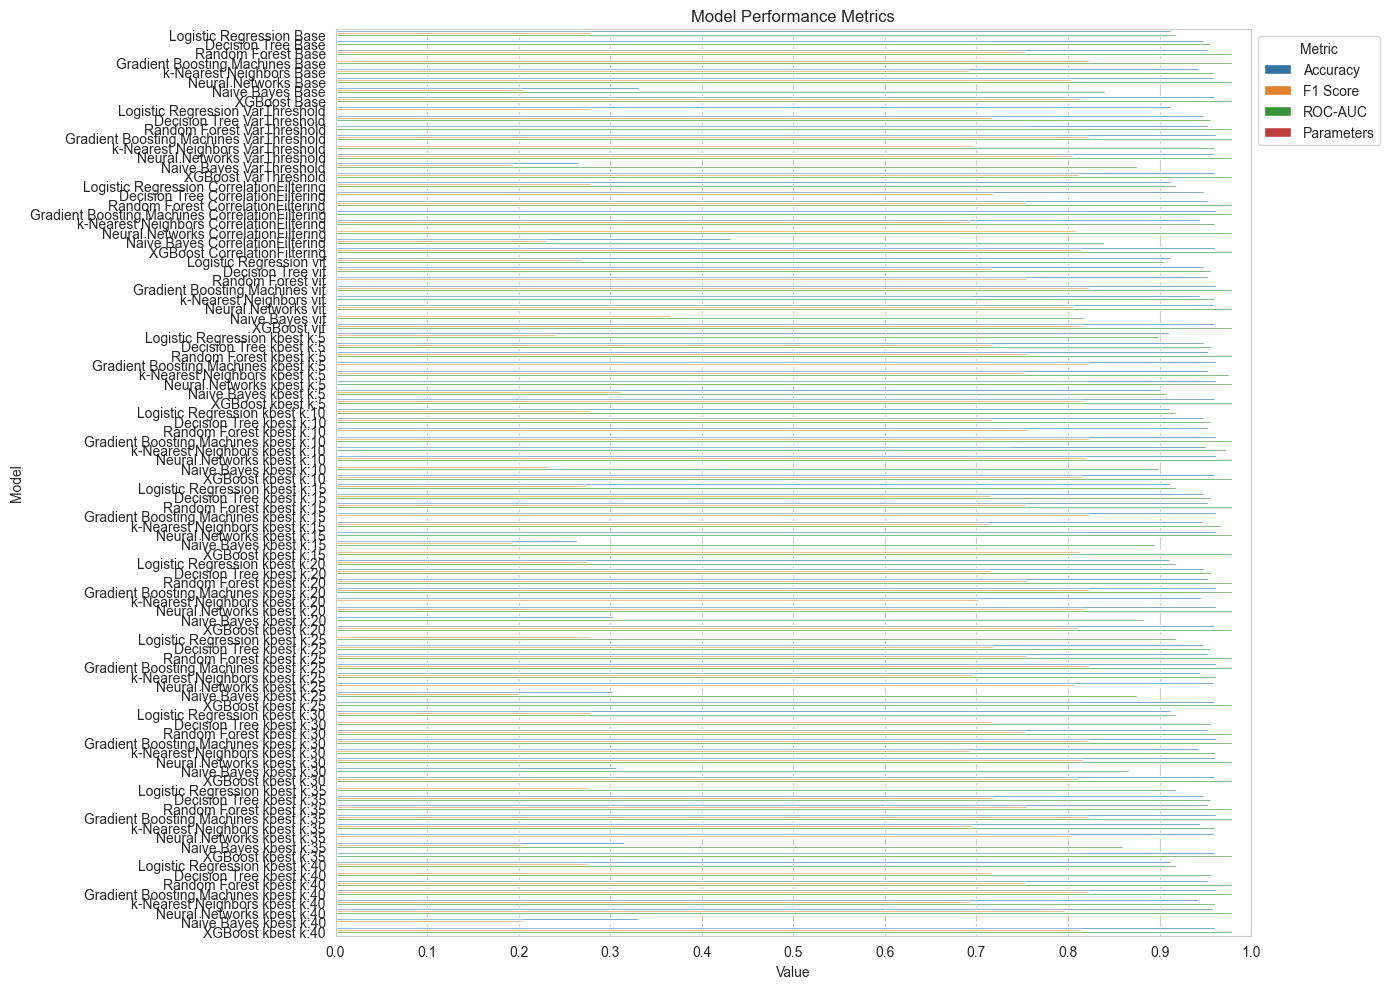

In [ ]:
plot_results(results_df, exclude_metrics=['Precision', 'Recall', 'TP', 'FP', 'TN', 'FN', 'Duration (seconds)'])

### Wrapper Methods

#### Recursive Feature Elimination (RFE)

In [ ]:
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [ ]:
X_train_rfe_df = pd.DataFrame(X_train_rfe, columns=preprocessor.get_feature_names_out())
X_test_rfe_df = pd.DataFrame(X_test_rfe, columns=preprocessor.get_feature_names_out())

#### Models (RFE)

In [ ]:
n_features_to_select = [5, 10, 15, 20, 25, 30, 35, 40]

for k in n_features_to_select:

    # Models to evaluate
    models_rfe = {
        f"Logistic Regression rfe k:{k}": LogisticRegression(random_state=SEED),
        f"Decision Tree rfe k:{k}": DecisionTreeClassifier(random_state=SEED),
        f"Random Forest rfe k:{k}": RandomForestClassifier(random_state=SEED),
        f"Gradient Boosting Machines rfe k:{k}": GradientBoostingClassifier(random_state=SEED),
        #f"k-Nearest Neighbors rfe k:{k}": KNeighborsClassifier(), ValueError: when `importance_getter=='auto'`, the underlying estimator KNeighborsClassifier should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.
        #f"Neural Networks rfe k:{k}": MLPClassifier(random_state=SEED), ValueError: when `importance_getter=='auto'`, the underlying estimator MLPClassifier should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.
        #f"Naive Bayes rfe k:{k}": GaussianNB(), ValueError: when `importance_getter=='auto'`, the underlying estimator GaussianNB should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.
        f"XGBoost rfe k:{k}": xgb.XGBClassifier(random_state=SEED)
    }
    for model_name, model in models_rfe.items():

        selector = RFE(estimator=model, n_features_to_select=k)
        selector.fit(X_train_rfe, y_train_rfe)

        sel_X_train_rfe = selector.transform(X_train_rfe)
        sel_X_test_rfe = selector.transform(X_test_rfe)

        results_df = evaluate_models(models_rfe, sel_X_train_rfe, y_train_rfe, sel_X_test_rfe, y_test_rfe, results_df)

Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:01,  2.31it/s]

Logistic Regression rfe k:5 Accuracy: 0.90903
Logistic Regression rfe k:5 F1 Score: 0.21529
Logistic Regression rfe k:5 Precision: 0.45477
Logistic Regression rfe k:5 Recall: 0.14103
Logistic Regression rfe k:5 ROC-AUC: 0.90304



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:00<00:01,  2.36it/s]

Decision Tree rfe k:5 Accuracy: 0.94518
Decision Tree rfe k:5 F1 Score: 0.69737
Decision Tree rfe k:5 Precision: 0.68165
Decision Tree rfe k:5 Recall: 0.71382
Decision Tree rfe k:5 ROC-AUC: 0.95137



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:12<00:10,  5.41s/it]

Random Forest rfe k:5 Accuracy: 0.94803
Random Forest rfe k:5 F1 Score: 0.72484
Random Forest rfe k:5 Precision: 0.68194
Random Forest rfe k:5 Recall: 0.77349
Random Forest rfe k:5 ROC-AUC: 0.97310



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:24<00:08,  8.08s/it]

Gradient Boosting Machines rfe k:5 Accuracy: 0.91526
Gradient Boosting Machines rfe k:5 F1 Score: 0.35630
Gradient Boosting Machines rfe k:5 Precision: 0.54348
Gradient Boosting Machines rfe k:5 Recall: 0.26503
Gradient Boosting Machines rfe k:5 ROC-AUC: 0.95339



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.04s/it]

XGBoost rfe k:5 Accuracy: 0.92394
XGBoost rfe k:5 F1 Score: 0.55738
XGBoost rfe k:5 Precision: 0.57457
XGBoost rfe k:5 Recall: 0.54118
XGBoost rfe k:5 ROC-AUC: 0.96085




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:01,  2.57it/s]

Logistic Regression rfe k:5 Accuracy: 0.91047
Logistic Regression rfe k:5 F1 Score: 0.24111
Logistic Regression rfe k:5 Precision: 0.48230
Logistic Regression rfe k:5 Recall: 0.16073
Logistic Regression rfe k:5 ROC-AUC: 0.90023



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:00<00:01,  2.35it/s]

Decision Tree rfe k:5 Accuracy: 0.94860
Decision Tree rfe k:5 F1 Score: 0.71751
Decision Tree rfe k:5 Precision: 0.69835
Decision Tree rfe k:5 Recall: 0.73776
Decision Tree rfe k:5 ROC-AUC: 0.95610



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:11<00:10,  5.26s/it]

Random Forest rfe k:5 Accuracy: 0.95290
Random Forest rfe k:5 F1 Score: 0.75510
Random Forest rfe k:5 Precision: 0.69930
Random Forest rfe k:5 Recall: 0.82057
Random Forest rfe k:5 ROC-AUC: 0.97900



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:29<00:10, 10.06s/it]

Gradient Boosting Machines rfe k:5 Accuracy: 0.96188
Gradient Boosting Machines rfe k:5 F1 Score: 0.82262
Gradient Boosting Machines rfe k:5 Precision: 0.69924
Gradient Boosting Machines rfe k:5 Recall: 0.99889
Gradient Boosting Machines rfe k:5 ROC-AUC: 0.97929



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.02s/it]

XGBoost rfe k:5 Accuracy: 0.96056
XGBoost rfe k:5 F1 Score: 0.81398
XGBoost rfe k:5 Precision: 0.69856
XGBoost rfe k:5 Recall: 0.97507
XGBoost rfe k:5 ROC-AUC: 0.97906




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:01,  2.15it/s]

Logistic Regression rfe k:5 Accuracy: 0.91152
Logistic Regression rfe k:5 F1 Score: 0.27737
Logistic Regression rfe k:5 Precision: 0.50015
Logistic Regression rfe k:5 Recall: 0.19190
Logistic Regression rfe k:5 ROC-AUC: 0.91760



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:00<00:01,  2.26it/s]

Decision Tree rfe k:5 Accuracy: 0.94868
Decision Tree rfe k:5 F1 Score: 0.71807
Decision Tree rfe k:5 Precision: 0.69872
Decision Tree rfe k:5 Recall: 0.73854
Decision Tree rfe k:5 ROC-AUC: 0.95601



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:11<00:10,  5.19s/it]

Random Forest rfe k:5 Accuracy: 0.95295
Random Forest rfe k:5 F1 Score: 0.75574
Random Forest rfe k:5 Precision: 0.69895
Random Forest rfe k:5 Recall: 0.82257
Random Forest rfe k:5 ROC-AUC: 0.97893



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:28<00:09,  9.73s/it]

Gradient Boosting Machines rfe k:5 Accuracy: 0.96188
Gradient Boosting Machines rfe k:5 F1 Score: 0.82262
Gradient Boosting Machines rfe k:5 Precision: 0.69924
Gradient Boosting Machines rfe k:5 Recall: 0.99889
Gradient Boosting Machines rfe k:5 ROC-AUC: 0.97912



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.87s/it]

XGBoost rfe k:5 Accuracy: 0.96116
XGBoost rfe k:5 F1 Score: 0.81748
XGBoost rfe k:5 Precision: 0.69974
XGBoost rfe k:5 Recall: 0.98286
XGBoost rfe k:5 ROC-AUC: 0.97903




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:01,  2.78it/s]

Logistic Regression rfe k:5 Accuracy: 0.91042
Logistic Regression rfe k:5 F1 Score: 0.24025
Logistic Regression rfe k:5 Precision: 0.48142
Logistic Regression rfe k:5 Recall: 0.16006
Logistic Regression rfe k:5 ROC-AUC: 0.89965



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:00<00:01,  2.49it/s]

Decision Tree rfe k:5 Accuracy: 0.94849
Decision Tree rfe k:5 F1 Score: 0.71644
Decision Tree rfe k:5 Precision: 0.69841
Decision Tree rfe k:5 Recall: 0.73542
Decision Tree rfe k:5 ROC-AUC: 0.95595



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:11<00:10,  5.04s/it]

Random Forest rfe k:5 Accuracy: 0.95290
Random Forest rfe k:5 F1 Score: 0.75517
Random Forest rfe k:5 Precision: 0.69918
Random Forest rfe k:5 Recall: 0.82090
Random Forest rfe k:5 ROC-AUC: 0.97904



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:27<00:09,  9.24s/it]

Gradient Boosting Machines rfe k:5 Accuracy: 0.96188
Gradient Boosting Machines rfe k:5 F1 Score: 0.82262
Gradient Boosting Machines rfe k:5 Precision: 0.69924
Gradient Boosting Machines rfe k:5 Recall: 0.99889
Gradient Boosting Machines rfe k:5 ROC-AUC: 0.97911



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.58s/it]

XGBoost rfe k:5 Accuracy: 0.96070
XGBoost rfe k:5 F1 Score: 0.81481
XGBoost rfe k:5 Precision: 0.69877
XGBoost rfe k:5 Recall: 0.97707
XGBoost rfe k:5 ROC-AUC: 0.97898




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:01,  2.47it/s]

Logistic Regression rfe k:5 Accuracy: 0.91022
Logistic Regression rfe k:5 F1 Score: 0.24023
Logistic Regression rfe k:5 Precision: 0.47826
Logistic Regression rfe k:5 Recall: 0.16040
Logistic Regression rfe k:5 ROC-AUC: 0.89884



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:00<00:01,  2.36it/s]

Decision Tree rfe k:5 Accuracy: 0.94860
Decision Tree rfe k:5 F1 Score: 0.71739
Decision Tree rfe k:5 Precision: 0.69851
Decision Tree rfe k:5 Recall: 0.73731
Decision Tree rfe k:5 ROC-AUC: 0.95606



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:11<00:10,  5.02s/it]

Random Forest rfe k:5 Accuracy: 0.95293
Random Forest rfe k:5 F1 Score: 0.75541
Random Forest rfe k:5 Precision: 0.69919
Random Forest rfe k:5 Recall: 0.82146
Random Forest rfe k:5 ROC-AUC: 0.97906



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:27<00:09,  9.33s/it]

Gradient Boosting Machines rfe k:5 Accuracy: 0.96188
Gradient Boosting Machines rfe k:5 F1 Score: 0.82262
Gradient Boosting Machines rfe k:5 Precision: 0.69924
Gradient Boosting Machines rfe k:5 Recall: 0.99889
Gradient Boosting Machines rfe k:5 ROC-AUC: 0.97914



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.62s/it]

XGBoost rfe k:5 Accuracy: 0.96091
XGBoost rfe k:5 F1 Score: 0.81592
XGBoost rfe k:5 Precision: 0.69937
XGBoost rfe k:5 Recall: 0.97907
XGBoost rfe k:5 ROC-AUC: 0.97901




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:01,  2.11it/s]

Logistic Regression rfe k:10 Accuracy: 0.91161
Logistic Regression rfe k:10 F1 Score: 0.27722
Logistic Regression rfe k:10 Precision: 0.50146
Logistic Regression rfe k:10 Recall: 0.19156
Logistic Regression rfe k:10 ROC-AUC: 0.91785



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:00<00:01,  2.17it/s]

Decision Tree rfe k:10 Accuracy: 0.94858
Decision Tree rfe k:10 F1 Score: 0.71728
Decision Tree rfe k:10 Precision: 0.69841
Decision Tree rfe k:10 Recall: 0.73720
Decision Tree rfe k:10 ROC-AUC: 0.95522



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:11<00:10,  5.14s/it]

Random Forest rfe k:10 Accuracy: 0.95294
Random Forest rfe k:10 F1 Score: 0.75560
Random Forest rfe k:10 Precision: 0.69903
Random Forest rfe k:10 Recall: 0.82213
Random Forest rfe k:10 ROC-AUC: 0.97884



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:28<00:09,  9.74s/it]

Gradient Boosting Machines rfe k:10 Accuracy: 0.96188
Gradient Boosting Machines rfe k:10 F1 Score: 0.82262
Gradient Boosting Machines rfe k:10 Precision: 0.69924
Gradient Boosting Machines rfe k:10 Recall: 0.99889
Gradient Boosting Machines rfe k:10 ROC-AUC: 0.97917



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.87s/it]

XGBoost rfe k:10 Accuracy: 0.96102
XGBoost rfe k:10 F1 Score: 0.81654
XGBoost rfe k:10 Precision: 0.69960
XGBoost rfe k:10 Recall: 0.98041
XGBoost rfe k:10 ROC-AUC: 0.97914




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:01,  2.49it/s]

Logistic Regression rfe k:10 Accuracy: 0.91027
Logistic Regression rfe k:10 F1 Score: 0.24574
Logistic Regression rfe k:10 Precision: 0.47964
Logistic Regression rfe k:10 Recall: 0.16518
Logistic Regression rfe k:10 ROC-AUC: 0.90088



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:00<00:01,  2.22it/s]

Decision Tree rfe k:10 Accuracy: 0.94836
Decision Tree rfe k:10 F1 Score: 0.71569
Decision Tree rfe k:10 Precision: 0.69779
Decision Tree rfe k:10 Recall: 0.73453
Decision Tree rfe k:10 ROC-AUC: 0.95544



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:11<00:10,  5.03s/it]

Random Forest rfe k:10 Accuracy: 0.95296
Random Forest rfe k:10 F1 Score: 0.75575
Random Forest rfe k:10 Precision: 0.69905
Random Forest rfe k:10 Recall: 0.82246
Random Forest rfe k:10 ROC-AUC: 0.97912



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:30<00:10, 10.64s/it]

Gradient Boosting Machines rfe k:10 Accuracy: 0.96189
Gradient Boosting Machines rfe k:10 F1 Score: 0.82266
Gradient Boosting Machines rfe k:10 Precision: 0.69929
Gradient Boosting Machines rfe k:10 Recall: 0.99889
Gradient Boosting Machines rfe k:10 ROC-AUC: 0.97929



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.30s/it]

XGBoost rfe k:10 Accuracy: 0.96059
XGBoost rfe k:10 F1 Score: 0.81381
XGBoost rfe k:10 Precision: 0.69924
XGBoost rfe k:10 Recall: 0.97329
XGBoost rfe k:10 ROC-AUC: 0.97908




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:02,  1.84it/s]

Logistic Regression rfe k:10 Accuracy: 0.91155
Logistic Regression rfe k:10 F1 Score: 0.27264
Logistic Regression rfe k:10 Precision: 0.50059
Logistic Regression rfe k:10 Recall: 0.18733
Logistic Regression rfe k:10 ROC-AUC: 0.91774



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:01,  1.97it/s]

Decision Tree rfe k:10 Accuracy: 0.94846
Decision Tree rfe k:10 F1 Score: 0.71648
Decision Tree rfe k:10 Precision: 0.69798
Decision Tree rfe k:10 Recall: 0.73598
Decision Tree rfe k:10 ROC-AUC: 0.95546



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:11<00:09,  4.92s/it]

Random Forest rfe k:10 Accuracy: 0.95302
Random Forest rfe k:10 F1 Score: 0.75623
Random Forest rfe k:10 Precision: 0.69907
Random Forest rfe k:10 Recall: 0.82358
Random Forest rfe k:10 ROC-AUC: 0.97910



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:29<00:10, 10.40s/it]

Gradient Boosting Machines rfe k:10 Accuracy: 0.96187
Gradient Boosting Machines rfe k:10 F1 Score: 0.82257
Gradient Boosting Machines rfe k:10 Precision: 0.69921
Gradient Boosting Machines rfe k:10 Recall: 0.99878
Gradient Boosting Machines rfe k:10 ROC-AUC: 0.97921



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.18s/it]

XGBoost rfe k:10 Accuracy: 0.96044
XGBoost rfe k:10 F1 Score: 0.81307
XGBoost rfe k:10 Precision: 0.69872
XGBoost rfe k:10 Recall: 0.97217
XGBoost rfe k:10 ROC-AUC: 0.97884




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:02,  1.89it/s]

Logistic Regression rfe k:10 Accuracy: 0.91060
Logistic Regression rfe k:10 F1 Score: 0.24074
Logistic Regression rfe k:10 Precision: 0.48435
Logistic Regression rfe k:10 Recall: 0.16017
Logistic Regression rfe k:10 ROC-AUC: 0.89976



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:01,  1.98it/s]

Decision Tree rfe k:10 Accuracy: 0.94852
Decision Tree rfe k:10 F1 Score: 0.71674
Decision Tree rfe k:10 Precision: 0.69838
Decision Tree rfe k:10 Recall: 0.73609
Decision Tree rfe k:10 ROC-AUC: 0.95559



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:12<00:10,  5.29s/it]

Random Forest rfe k:10 Accuracy: 0.95301
Random Forest rfe k:10 F1 Score: 0.75605
Random Forest rfe k:10 Precision: 0.69923
Random Forest rfe k:10 Recall: 0.82291
Random Forest rfe k:10 ROC-AUC: 0.97907



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:30<00:10, 10.66s/it]

Gradient Boosting Machines rfe k:10 Accuracy: 0.96190
Gradient Boosting Machines rfe k:10 F1 Score: 0.82268
Gradient Boosting Machines rfe k:10 Precision: 0.69938
Gradient Boosting Machines rfe k:10 Recall: 0.99878
Gradient Boosting Machines rfe k:10 ROC-AUC: 0.97913



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.37s/it]

XGBoost rfe k:10 Accuracy: 0.96036
XGBoost rfe k:10 F1 Score: 0.81259
XGBoost rfe k:10 Precision: 0.69847
XGBoost rfe k:10 Recall: 0.97128
XGBoost rfe k:10 ROC-AUC: 0.97904




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:02,  1.78it/s]

Logistic Regression rfe k:10 Accuracy: 0.91073
Logistic Regression rfe k:10 F1 Score: 0.24569
Logistic Regression rfe k:10 Precision: 0.48697
Logistic Regression rfe k:10 Recall: 0.16429
Logistic Regression rfe k:10 ROC-AUC: 0.89897



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:01,  1.92it/s]

Decision Tree rfe k:10 Accuracy: 0.94851
Decision Tree rfe k:10 F1 Score: 0.71710
Decision Tree rfe k:10 Precision: 0.69777
Decision Tree rfe k:10 Recall: 0.73753
Decision Tree rfe k:10 ROC-AUC: 0.95639



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:12<00:11,  5.57s/it]

Random Forest rfe k:10 Accuracy: 0.95311
Random Forest rfe k:10 F1 Score: 0.75666
Random Forest rfe k:10 Precision: 0.69956
Random Forest rfe k:10 Recall: 0.82391
Random Forest rfe k:10 ROC-AUC: 0.97912



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:31<00:10, 10.75s/it]

Gradient Boosting Machines rfe k:10 Accuracy: 0.96188
Gradient Boosting Machines rfe k:10 F1 Score: 0.82262
Gradient Boosting Machines rfe k:10 Precision: 0.69924
Gradient Boosting Machines rfe k:10 Recall: 0.99889
Gradient Boosting Machines rfe k:10 ROC-AUC: 0.97904



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.45s/it]

XGBoost rfe k:10 Accuracy: 0.96081
XGBoost rfe k:10 F1 Score: 0.81509
XGBoost rfe k:10 Precision: 0.69964
XGBoost rfe k:10 Recall: 0.97618
XGBoost rfe k:10 ROC-AUC: 0.97910




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:02,  1.75it/s]

Logistic Regression rfe k:15 Accuracy: 0.91185
Logistic Regression rfe k:15 F1 Score: 0.27718
Logistic Regression rfe k:15 Precision: 0.50500
Logistic Regression rfe k:15 Recall: 0.19101
Logistic Regression rfe k:15 ROC-AUC: 0.91814



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:01,  1.85it/s]

Decision Tree rfe k:15 Accuracy: 0.94868
Decision Tree rfe k:15 F1 Score: 0.71798
Decision Tree rfe k:15 Precision: 0.69884
Decision Tree rfe k:15 Recall: 0.73820
Decision Tree rfe k:15 ROC-AUC: 0.95593



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:13<00:11,  5.89s/it]

Random Forest rfe k:15 Accuracy: 0.95281
Random Forest rfe k:15 F1 Score: 0.75450
Random Forest rfe k:15 Precision: 0.69908
Random Forest rfe k:15 Recall: 0.81946
Random Forest rfe k:15 ROC-AUC: 0.97897



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:33<00:11, 11.65s/it]

Gradient Boosting Machines rfe k:15 Accuracy: 0.96187
Gradient Boosting Machines rfe k:15 F1 Score: 0.82260
Gradient Boosting Machines rfe k:15 Precision: 0.69915
Gradient Boosting Machines rfe k:15 Recall: 0.99900
Gradient Boosting Machines rfe k:15 ROC-AUC: 0.97910



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.99s/it]

XGBoost rfe k:15 Accuracy: 0.96086
XGBoost rfe k:15 F1 Score: 0.81557
XGBoost rfe k:15 Precision: 0.69938
XGBoost rfe k:15 Recall: 0.97807
XGBoost rfe k:15 ROC-AUC: 0.97905




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:02,  1.73it/s]

Logistic Regression rfe k:15 Accuracy: 0.91032
Logistic Regression rfe k:15 F1 Score: 0.24596
Logistic Regression rfe k:15 Precision: 0.48043
Logistic Regression rfe k:15 Recall: 0.16529
Logistic Regression rfe k:15 ROC-AUC: 0.90101



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:01,  1.76it/s]

Decision Tree rfe k:15 Accuracy: 0.94848
Decision Tree rfe k:15 F1 Score: 0.71646
Decision Tree rfe k:15 Precision: 0.69826
Decision Tree rfe k:15 Recall: 0.73564
Decision Tree rfe k:15 ROC-AUC: 0.95624



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:11<00:10,  5.23s/it]

Random Forest rfe k:15 Accuracy: 0.95303
Random Forest rfe k:15 F1 Score: 0.75607
Random Forest rfe k:15 Precision: 0.69944
Random Forest rfe k:15 Recall: 0.82268
Random Forest rfe k:15 ROC-AUC: 0.97910



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:33<00:11, 11.82s/it]

Gradient Boosting Machines rfe k:15 Accuracy: 0.96189
Gradient Boosting Machines rfe k:15 F1 Score: 0.82266
Gradient Boosting Machines rfe k:15 Precision: 0.69929
Gradient Boosting Machines rfe k:15 Recall: 0.99889
Gradient Boosting Machines rfe k:15 ROC-AUC: 0.97929



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.97s/it]

XGBoost rfe k:15 Accuracy: 0.96044
XGBoost rfe k:15 F1 Score: 0.81267
XGBoost rfe k:15 Precision: 0.69945
XGBoost rfe k:15 Recall: 0.96961
XGBoost rfe k:15 ROC-AUC: 0.97904




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:02,  1.62it/s]

Logistic Regression rfe k:15 Accuracy: 0.91187
Logistic Regression rfe k:15 F1 Score: 0.27605
Logistic Regression rfe k:15 Precision: 0.50533
Logistic Regression rfe k:15 Recall: 0.18989
Logistic Regression rfe k:15 ROC-AUC: 0.91771



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:01,  1.75it/s]

Decision Tree rfe k:15 Accuracy: 0.94857
Decision Tree rfe k:15 F1 Score: 0.71666
Decision Tree rfe k:15 Precision: 0.69913
Decision Tree rfe k:15 Recall: 0.73508
Decision Tree rfe k:15 ROC-AUC: 0.95563



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:11<00:09,  4.91s/it]

Random Forest rfe k:15 Accuracy: 0.95302
Random Forest rfe k:15 F1 Score: 0.75596
Random Forest rfe k:15 Precision: 0.69949
Random Forest rfe k:15 Recall: 0.82235
Random Forest rfe k:15 ROC-AUC: 0.97913



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:33<00:11, 11.59s/it]

Gradient Boosting Machines rfe k:15 Accuracy: 0.96192
Gradient Boosting Machines rfe k:15 F1 Score: 0.82284
Gradient Boosting Machines rfe k:15 Precision: 0.69933
Gradient Boosting Machines rfe k:15 Recall: 0.99933
Gradient Boosting Machines rfe k:15 ROC-AUC: 0.97929



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.81s/it]

XGBoost rfe k:15 Accuracy: 0.96028
XGBoost rfe k:15 F1 Score: 0.81199
XGBoost rfe k:15 Precision: 0.69856
XGBoost rfe k:15 Recall: 0.96939
XGBoost rfe k:15 ROC-AUC: 0.97900




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:03,  1.26it/s]

Logistic Regression rfe k:15 Accuracy: 0.91057
Logistic Regression rfe k:15 F1 Score: 0.24055
Logistic Regression rfe k:15 Precision: 0.48385
Logistic Regression rfe k:15 Recall: 0.16006
Logistic Regression rfe k:15 ROC-AUC: 0.89875



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:01,  1.60it/s]

Decision Tree rfe k:15 Accuracy: 0.94871
Decision Tree rfe k:15 F1 Score: 0.71804
Decision Tree rfe k:15 Precision: 0.69915
Decision Tree rfe k:15 Recall: 0.73798
Decision Tree rfe k:15 ROC-AUC: 0.95592



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:11<00:10,  5.02s/it]

Random Forest rfe k:15 Accuracy: 0.95293
Random Forest rfe k:15 F1 Score: 0.75541
Random Forest rfe k:15 Precision: 0.69919
Random Forest rfe k:15 Recall: 0.82146
Random Forest rfe k:15 ROC-AUC: 0.97910



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:31<00:10, 10.80s/it]

Gradient Boosting Machines rfe k:15 Accuracy: 0.96188
Gradient Boosting Machines rfe k:15 F1 Score: 0.82262
Gradient Boosting Machines rfe k:15 Precision: 0.69924
Gradient Boosting Machines rfe k:15 Recall: 0.99889
Gradient Boosting Machines rfe k:15 ROC-AUC: 0.97913



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.44s/it]

XGBoost rfe k:15 Accuracy: 0.96044
XGBoost rfe k:15 F1 Score: 0.81300
XGBoost rfe k:15 Precision: 0.69885
XGBoost rfe k:15 Recall: 0.97173
XGBoost rfe k:15 ROC-AUC: 0.97890




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:02,  1.87it/s]

Logistic Regression rfe k:15 Accuracy: 0.91066
Logistic Regression rfe k:15 F1 Score: 0.24364
Logistic Regression rfe k:15 Precision: 0.48554
Logistic Regression rfe k:15 Recall: 0.16262
Logistic Regression rfe k:15 ROC-AUC: 0.90025



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:01,  1.88it/s]

Decision Tree rfe k:15 Accuracy: 0.94853
Decision Tree rfe k:15 F1 Score: 0.71687
Decision Tree rfe k:15 Precision: 0.69833
Decision Tree rfe k:15 Recall: 0.73642
Decision Tree rfe k:15 ROC-AUC: 0.95583



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:11<00:09,  4.99s/it]

Random Forest rfe k:15 Accuracy: 0.95280
Random Forest rfe k:15 F1 Score: 0.75466
Random Forest rfe k:15 Precision: 0.69871
Random Forest rfe k:15 Recall: 0.82035
Random Forest rfe k:15 ROC-AUC: 0.97909



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:31<00:11, 11.13s/it]

Gradient Boosting Machines rfe k:15 Accuracy: 0.96187
Gradient Boosting Machines rfe k:15 F1 Score: 0.82255
Gradient Boosting Machines rfe k:15 Precision: 0.69924
Gradient Boosting Machines rfe k:15 Recall: 0.99866
Gradient Boosting Machines rfe k:15 ROC-AUC: 0.97899



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.58s/it]

XGBoost rfe k:15 Accuracy: 0.96057
XGBoost rfe k:15 F1 Score: 0.81349
XGBoost rfe k:15 Precision: 0.69958
XGBoost rfe k:15 Recall: 0.97173
XGBoost rfe k:15 ROC-AUC: 0.97922




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:03,  1.29it/s]

Logistic Regression rfe k:20 Accuracy: 0.91227
Logistic Regression rfe k:20 F1 Score: 0.28268
Logistic Regression rfe k:20 Precision: 0.51121
Logistic Regression rfe k:20 Recall: 0.19535
Logistic Regression rfe k:20 ROC-AUC: 0.91840



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:01,  1.57it/s]

Decision Tree rfe k:20 Accuracy: 0.94851
Decision Tree rfe k:20 F1 Score: 0.71704
Decision Tree rfe k:20 Precision: 0.69785
Decision Tree rfe k:20 Recall: 0.73731
Decision Tree rfe k:20 ROC-AUC: 0.95581



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:12<00:10,  5.38s/it]

Random Forest rfe k:20 Accuracy: 0.95278
Random Forest rfe k:20 F1 Score: 0.75441
Random Forest rfe k:20 Precision: 0.69884
Random Forest rfe k:20 Recall: 0.81957
Random Forest rfe k:20 ROC-AUC: 0.97897



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:33<00:11, 11.56s/it]

Gradient Boosting Machines rfe k:20 Accuracy: 0.96187
Gradient Boosting Machines rfe k:20 F1 Score: 0.82260
Gradient Boosting Machines rfe k:20 Precision: 0.69915
Gradient Boosting Machines rfe k:20 Recall: 0.99900
Gradient Boosting Machines rfe k:20 ROC-AUC: 0.97921



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.89s/it]

XGBoost rfe k:20 Accuracy: 0.96075
XGBoost rfe k:20 F1 Score: 0.81476
XGBoost rfe k:20 Precision: 0.69950
XGBoost rfe k:20 Recall: 0.97551
XGBoost rfe k:20 ROC-AUC: 0.97903




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:02,  1.39it/s]

Logistic Regression rfe k:20 Accuracy: 0.91043
Logistic Regression rfe k:20 F1 Score: 0.24855
Logistic Regression rfe k:20 Precision: 0.48236
Logistic Regression rfe k:20 Recall: 0.16741
Logistic Regression rfe k:20 ROC-AUC: 0.90090



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:01,  1.54it/s]

Decision Tree rfe k:20 Accuracy: 0.94839
Decision Tree rfe k:20 F1 Score: 0.71605
Decision Tree rfe k:20 Precision: 0.69768
Decision Tree rfe k:20 Recall: 0.73542
Decision Tree rfe k:20 ROC-AUC: 0.95546



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:12<00:11,  5.60s/it]

Random Forest rfe k:20 Accuracy: 0.95300
Random Forest rfe k:20 F1 Score: 0.75576
Random Forest rfe k:20 Precision: 0.69955
Random Forest rfe k:20 Recall: 0.82179
Random Forest rfe k:20 ROC-AUC: 0.97910



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:36<00:12, 12.94s/it]

Gradient Boosting Machines rfe k:20 Accuracy: 0.96189
Gradient Boosting Machines rfe k:20 F1 Score: 0.82266
Gradient Boosting Machines rfe k:20 Precision: 0.69929
Gradient Boosting Machines rfe k:20 Recall: 0.99889
Gradient Boosting Machines rfe k:20 ROC-AUC: 0.97927



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:38<00:00,  7.63s/it]

XGBoost rfe k:20 Accuracy: 0.96006
XGBoost rfe k:20 F1 Score: 0.81004
XGBoost rfe k:20 Precision: 0.69934
XGBoost rfe k:20 Recall: 0.96238
XGBoost rfe k:20 ROC-AUC: 0.97906




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:03,  1.17it/s]

Logistic Regression rfe k:20 Accuracy: 0.91202
Logistic Regression rfe k:20 F1 Score: 0.27512
Logistic Regression rfe k:20 Precision: 0.50779
Logistic Regression rfe k:20 Recall: 0.18867
Logistic Regression rfe k:20 ROC-AUC: 0.91779



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:02,  1.45it/s]

Decision Tree rfe k:20 Accuracy: 0.94847
Decision Tree rfe k:20 F1 Score: 0.71645
Decision Tree rfe k:20 Precision: 0.69814
Decision Tree rfe k:20 Recall: 0.73575
Decision Tree rfe k:20 ROC-AUC: 0.95590



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:13<00:11,  5.69s/it]

Random Forest rfe k:20 Accuracy: 0.95278
Random Forest rfe k:20 F1 Score: 0.75425
Random Forest rfe k:20 Precision: 0.69907
Random Forest rfe k:20 Recall: 0.81890
Random Forest rfe k:20 ROC-AUC: 0.97907



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:38<00:13, 13.66s/it]

Gradient Boosting Machines rfe k:20 Accuracy: 0.96189
Gradient Boosting Machines rfe k:20 F1 Score: 0.82266
Gradient Boosting Machines rfe k:20 Precision: 0.69929
Gradient Boosting Machines rfe k:20 Recall: 0.99889
Gradient Boosting Machines rfe k:20 ROC-AUC: 0.97926



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.01s/it]

XGBoost rfe k:20 Accuracy: 0.96046
XGBoost rfe k:20 F1 Score: 0.81266
XGBoost rfe k:20 Precision: 0.69973
XGBoost rfe k:20 Recall: 0.96906
XGBoost rfe k:20 ROC-AUC: 0.97917




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:03,  1.26it/s]

Logistic Regression rfe k:20 Accuracy: 0.91062
Logistic Regression rfe k:20 F1 Score: 0.24495
Logistic Regression rfe k:20 Precision: 0.48501
Logistic Regression rfe k:20 Recall: 0.16385
Logistic Regression rfe k:20 ROC-AUC: 0.90017



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:02,  1.45it/s]

Decision Tree rfe k:20 Accuracy: 0.94868
Decision Tree rfe k:20 F1 Score: 0.71804
Decision Tree rfe k:20 Precision: 0.69876
Decision Tree rfe k:20 Recall: 0.73842
Decision Tree rfe k:20 ROC-AUC: 0.95577



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:15<00:13,  6.60s/it]

Random Forest rfe k:20 Accuracy: 0.95300
Random Forest rfe k:20 F1 Score: 0.75583
Random Forest rfe k:20 Precision: 0.69943
Random Forest rfe k:20 Recall: 0.82213
Random Forest rfe k:20 ROC-AUC: 0.97907



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:37<00:12, 12.84s/it]

Gradient Boosting Machines rfe k:20 Accuracy: 0.96191
Gradient Boosting Machines rfe k:20 F1 Score: 0.82282
Gradient Boosting Machines rfe k:20 Precision: 0.69924
Gradient Boosting Machines rfe k:20 Recall: 0.99944
Gradient Boosting Machines rfe k:20 ROC-AUC: 0.97905



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:38<00:00,  7.72s/it]

XGBoost rfe k:20 Accuracy: 0.96034
XGBoost rfe k:20 F1 Score: 0.81244
XGBoost rfe k:20 Precision: 0.69849
XGBoost rfe k:20 Recall: 0.97084
XGBoost rfe k:20 ROC-AUC: 0.97891




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:02,  1.37it/s]

Logistic Regression rfe k:20 Accuracy: 0.91081
Logistic Regression rfe k:20 F1 Score: 0.25577
Logistic Regression rfe k:20 Precision: 0.48885
Logistic Regression rfe k:20 Recall: 0.17320
Logistic Regression rfe k:20 ROC-AUC: 0.90174



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:01,  1.55it/s]

Decision Tree rfe k:20 Accuracy: 0.94863
Decision Tree rfe k:20 F1 Score: 0.71744
Decision Tree rfe k:20 Precision: 0.69882
Decision Tree rfe k:20 Recall: 0.73709
Decision Tree rfe k:20 ROC-AUC: 0.95597



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:13<00:11,  5.93s/it]

Random Forest rfe k:20 Accuracy: 0.95284
Random Forest rfe k:20 F1 Score: 0.75504
Random Forest rfe k:20 Precision: 0.69864
Random Forest rfe k:20 Recall: 0.82135
Random Forest rfe k:20 ROC-AUC: 0.97908



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:36<00:12, 12.80s/it]

Gradient Boosting Machines rfe k:20 Accuracy: 0.96190
Gradient Boosting Machines rfe k:20 F1 Score: 0.82273
Gradient Boosting Machines rfe k:20 Precision: 0.69928
Gradient Boosting Machines rfe k:20 Recall: 0.99911
Gradient Boosting Machines rfe k:20 ROC-AUC: 0.97905



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:38<00:00,  7.63s/it]

XGBoost rfe k:20 Accuracy: 0.96070
XGBoost rfe k:20 F1 Score: 0.81464
XGBoost rfe k:20 Precision: 0.69909
XGBoost rfe k:20 Recall: 0.97596
XGBoost rfe k:20 ROC-AUC: 0.97896




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:02,  1.49it/s]

Logistic Regression rfe k:25 Accuracy: 0.91224
Logistic Regression rfe k:25 F1 Score: 0.28249
Logistic Regression rfe k:25 Precision: 0.51077
Logistic Regression rfe k:25 Recall: 0.19524
Logistic Regression rfe k:25 ROC-AUC: 0.91821



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:01,  1.53it/s]

Decision Tree rfe k:25 Accuracy: 0.94848
Decision Tree rfe k:25 F1 Score: 0.71671
Decision Tree rfe k:25 Precision: 0.69792
Decision Tree rfe k:25 Recall: 0.73653
Decision Tree rfe k:25 ROC-AUC: 0.95576



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:13<00:12,  6.04s/it]

Random Forest rfe k:25 Accuracy: 0.95281
Random Forest rfe k:25 F1 Score: 0.75475
Random Forest rfe k:25 Precision: 0.69870
Random Forest rfe k:25 Recall: 0.82057
Random Forest rfe k:25 ROC-AUC: 0.97894



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:37<00:13, 13.13s/it]

Gradient Boosting Machines rfe k:25 Accuracy: 0.96187
Gradient Boosting Machines rfe k:25 F1 Score: 0.82260
Gradient Boosting Machines rfe k:25 Precision: 0.69915
Gradient Boosting Machines rfe k:25 Recall: 0.99900
Gradient Boosting Machines rfe k:25 ROC-AUC: 0.97929



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.82s/it]

XGBoost rfe k:25 Accuracy: 0.96071
XGBoost rfe k:25 F1 Score: 0.81475
XGBoost rfe k:25 Precision: 0.69902
XGBoost rfe k:25 Recall: 0.97640
XGBoost rfe k:25 ROC-AUC: 0.97902




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:01<00:05,  1.36s/it]

Logistic Regression rfe k:25 Accuracy: 0.91119
Logistic Regression rfe k:25 F1 Score: 0.26060
Logistic Regression rfe k:25 Precision: 0.49486
Logistic Regression rfe k:25 Recall: 0.17687
Logistic Regression rfe k:25 ROC-AUC: 0.90331



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:02<00:02,  1.05it/s]

Decision Tree rfe k:25 Accuracy: 0.94860
Decision Tree rfe k:25 F1 Score: 0.71760
Decision Tree rfe k:25 Precision: 0.69822
Decision Tree rfe k:25 Recall: 0.73809
Decision Tree rfe k:25 ROC-AUC: 0.95596



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:15<00:13,  6.53s/it]

Random Forest rfe k:25 Accuracy: 0.95279
Random Forest rfe k:25 F1 Score: 0.75462
Random Forest rfe k:25 Precision: 0.69864
Random Forest rfe k:25 Recall: 0.82035
Random Forest rfe k:25 ROC-AUC: 0.97911



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:42<00:14, 14.82s/it]

Gradient Boosting Machines rfe k:25 Accuracy: 0.96189
Gradient Boosting Machines rfe k:25 F1 Score: 0.82266
Gradient Boosting Machines rfe k:25 Precision: 0.69929
Gradient Boosting Machines rfe k:25 Recall: 0.99889
Gradient Boosting Machines rfe k:25 ROC-AUC: 0.97927



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.80s/it]

XGBoost rfe k:25 Accuracy: 0.96020
XGBoost rfe k:25 F1 Score: 0.81119
XGBoost rfe k:25 Precision: 0.69901
XGBoost rfe k:25 Recall: 0.96627
XGBoost rfe k:25 ROC-AUC: 0.97892




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:03,  1.18it/s]

Logistic Regression rfe k:25 Accuracy: 0.91218
Logistic Regression rfe k:25 F1 Score: 0.27782
Logistic Regression rfe k:25 Precision: 0.51011
Logistic Regression rfe k:25 Recall: 0.19089
Logistic Regression rfe k:25 ROC-AUC: 0.91788



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:02,  1.39it/s]

Decision Tree rfe k:25 Accuracy: 0.94841
Decision Tree rfe k:25 F1 Score: 0.71582
Decision Tree rfe k:25 Precision: 0.69824
Decision Tree rfe k:25 Recall: 0.73431
Decision Tree rfe k:25 ROC-AUC: 0.95531



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:13<00:11,  5.84s/it]

Random Forest rfe k:25 Accuracy: 0.95287
Random Forest rfe k:25 F1 Score: 0.75533
Random Forest rfe k:25 Precision: 0.69857
Random Forest rfe k:25 Recall: 0.82213
Random Forest rfe k:25 ROC-AUC: 0.97911



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:39<00:13, 13.92s/it]

Gradient Boosting Machines rfe k:25 Accuracy: 0.96188
Gradient Boosting Machines rfe k:25 F1 Score: 0.82264
Gradient Boosting Machines rfe k:25 Precision: 0.69921
Gradient Boosting Machines rfe k:25 Recall: 0.99900
Gradient Boosting Machines rfe k:25 ROC-AUC: 0.97921



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.18s/it]
C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)


XGBoost rfe k:25 Accuracy: 0.96022
XGBoost rfe k:25 F1 Score: 0.81120
XGBoost rfe k:25 Precision: 0.69925
XGBoost rfe k:25 Recall: 0.96583
XGBoost rfe k:25 ROC-AUC: 0.97892



Evaluating Models:  20%|█████████████                                                    | 1/5 [00:01<00:04,  1.19s/it]

Logistic Regression rfe k:25 Accuracy: 0.91062
Logistic Regression rfe k:25 F1 Score: 0.24545
Logistic Regression rfe k:25 Precision: 0.48505
Logistic Regression rfe k:25 Recall: 0.16429
Logistic Regression rfe k:25 ROC-AUC: 0.90128



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:02,  1.18it/s]

Decision Tree rfe k:25 Accuracy: 0.94866
Decision Tree rfe k:25 F1 Score: 0.71769
Decision Tree rfe k:25 Precision: 0.69899
Decision Tree rfe k:25 Recall: 0.73742
Decision Tree rfe k:25 ROC-AUC: 0.95591



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:13<00:11,  5.97s/it]

Random Forest rfe k:25 Accuracy: 0.95301
Random Forest rfe k:25 F1 Score: 0.75587
Random Forest rfe k:25 Precision: 0.69950
Random Forest rfe k:25 Recall: 0.82213
Random Forest rfe k:25 ROC-AUC: 0.97905



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:38<00:13, 13.27s/it]

Gradient Boosting Machines rfe k:25 Accuracy: 0.96191
Gradient Boosting Machines rfe k:25 F1 Score: 0.82282
Gradient Boosting Machines rfe k:25 Precision: 0.69924
Gradient Boosting Machines rfe k:25 Recall: 0.99944
Gradient Boosting Machines rfe k:25 ROC-AUC: 0.97918



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.89s/it]

XGBoost rfe k:25 Accuracy: 0.96070
XGBoost rfe k:25 F1 Score: 0.81392
XGBoost rfe k:25 Precision: 0.70043
XGBoost rfe k:25 Recall: 0.97128
XGBoost rfe k:25 ROC-AUC: 0.97903




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:01<00:04,  1.00s/it]

Logistic Regression rfe k:25 Accuracy: 0.91164
Logistic Regression rfe k:25 F1 Score: 0.26725
Logistic Regression rfe k:25 Precision: 0.50199
Logistic Regression rfe k:25 Recall: 0.18210
Logistic Regression rfe k:25 ROC-AUC: 0.90298



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:02,  1.28it/s]

Decision Tree rfe k:25 Accuracy: 0.94847
Decision Tree rfe k:25 F1 Score: 0.71624
Decision Tree rfe k:25 Precision: 0.69843
Decision Tree rfe k:25 Recall: 0.73497
Decision Tree rfe k:25 ROC-AUC: 0.95580



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:13<00:11,  5.96s/it]

Random Forest rfe k:25 Accuracy: 0.95287
Random Forest rfe k:25 F1 Score: 0.75526
Random Forest rfe k:25 Precision: 0.69868
Random Forest rfe k:25 Recall: 0.82179
Random Forest rfe k:25 ROC-AUC: 0.97910



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:38<00:13, 13.43s/it]

Gradient Boosting Machines rfe k:25 Accuracy: 0.96188
Gradient Boosting Machines rfe k:25 F1 Score: 0.82264
Gradient Boosting Machines rfe k:25 Precision: 0.69921
Gradient Boosting Machines rfe k:25 Recall: 0.99900
Gradient Boosting Machines rfe k:25 ROC-AUC: 0.97921



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.97s/it]

XGBoost rfe k:25 Accuracy: 0.96039
XGBoost rfe k:25 F1 Score: 0.81227
XGBoost rfe k:25 Precision: 0.69944
XGBoost rfe k:25 Recall: 0.96850
XGBoost rfe k:25 ROC-AUC: 0.97892




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:01<00:04,  1.01s/it]

Logistic Regression rfe k:30 Accuracy: 0.91206
Logistic Regression rfe k:30 F1 Score: 0.27884
Logistic Regression rfe k:30 Precision: 0.50824
Logistic Regression rfe k:30 Recall: 0.19212
Logistic Regression rfe k:30 ROC-AUC: 0.91834



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:02,  1.26it/s]

Decision Tree rfe k:30 Accuracy: 0.94850
Decision Tree rfe k:30 F1 Score: 0.71678
Decision Tree rfe k:30 Precision: 0.69807
Decision Tree rfe k:30 Recall: 0.73653
Decision Tree rfe k:30 ROC-AUC: 0.95547



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:13<00:11,  5.84s/it]

Random Forest rfe k:30 Accuracy: 0.95271
Random Forest rfe k:30 F1 Score: 0.75398
Random Forest rfe k:30 Precision: 0.69860
Random Forest rfe k:30 Recall: 0.81890
Random Forest rfe k:30 ROC-AUC: 0.97886



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:39<00:13, 13.89s/it]

Gradient Boosting Machines rfe k:30 Accuracy: 0.96188
Gradient Boosting Machines rfe k:30 F1 Score: 0.82264
Gradient Boosting Machines rfe k:30 Precision: 0.69921
Gradient Boosting Machines rfe k:30 Recall: 0.99900
Gradient Boosting Machines rfe k:30 ROC-AUC: 0.97925



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.24s/it]

XGBoost rfe k:30 Accuracy: 0.96097
XGBoost rfe k:30 F1 Score: 0.81597
XGBoost rfe k:30 Precision: 0.70002
XGBoost rfe k:30 Recall: 0.97796
XGBoost rfe k:30 ROC-AUC: 0.97923




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:01<00:06,  1.52s/it]

Logistic Regression rfe k:30 Accuracy: 0.91142
Logistic Regression rfe k:30 F1 Score: 0.26678
Logistic Regression rfe k:30 Precision: 0.49863
Logistic Regression rfe k:30 Recall: 0.18210
Logistic Regression rfe k:30 ROC-AUC: 0.90359



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:02<00:03,  1.07s/it]

Decision Tree rfe k:30 Accuracy: 0.94861
Decision Tree rfe k:30 F1 Score: 0.71737
Decision Tree rfe k:30 Precision: 0.69867
Decision Tree rfe k:30 Recall: 0.73709
Decision Tree rfe k:30 ROC-AUC: 0.95584



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:15<00:13,  6.70s/it]

Random Forest rfe k:30 Accuracy: 0.95286
Random Forest rfe k:30 F1 Score: 0.75474
Random Forest rfe k:30 Precision: 0.69934
Random Forest rfe k:30 Recall: 0.81968
Random Forest rfe k:30 ROC-AUC: 0.97909



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:45<00:15, 15.67s/it]

Gradient Boosting Machines rfe k:30 Accuracy: 0.96188
Gradient Boosting Machines rfe k:30 F1 Score: 0.82264
Gradient Boosting Machines rfe k:30 Precision: 0.69921
Gradient Boosting Machines rfe k:30 Recall: 0.99900
Gradient Boosting Machines rfe k:30 ROC-AUC: 0.97920



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.35s/it]

XGBoost rfe k:30 Accuracy: 0.96039
XGBoost rfe k:30 F1 Score: 0.81213
XGBoost rfe k:30 Precision: 0.69969
XGBoost rfe k:30 Recall: 0.96761
XGBoost rfe k:30 ROC-AUC: 0.97869




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:00<00:03,  1.07it/s]

Logistic Regression rfe k:30 Accuracy: 0.91210
Logistic Regression rfe k:30 F1 Score: 0.27811
Logistic Regression rfe k:30 Precision: 0.50888
Logistic Regression rfe k:30 Recall: 0.19134
Logistic Regression rfe k:30 ROC-AUC: 0.91787



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:02,  1.28it/s]

Decision Tree rfe k:30 Accuracy: 0.94852
Decision Tree rfe k:30 F1 Score: 0.71671
Decision Tree rfe k:30 Precision: 0.69843
Decision Tree rfe k:30 Recall: 0.73598
Decision Tree rfe k:30 ROC-AUC: 0.95557



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:13<00:12,  6.04s/it]

Random Forest rfe k:30 Accuracy: 0.95292
Random Forest rfe k:30 F1 Score: 0.75540
Random Forest rfe k:30 Precision: 0.69909
Random Forest rfe k:30 Recall: 0.82157
Random Forest rfe k:30 ROC-AUC: 0.97898



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:42<00:14, 14.78s/it]

Gradient Boosting Machines rfe k:30 Accuracy: 0.96188
Gradient Boosting Machines rfe k:30 F1 Score: 0.82264
Gradient Boosting Machines rfe k:30 Precision: 0.69921
Gradient Boosting Machines rfe k:30 Recall: 0.99900
Gradient Boosting Machines rfe k:30 ROC-AUC: 0.97923



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.67s/it]

XGBoost rfe k:30 Accuracy: 0.96041
XGBoost rfe k:30 F1 Score: 0.81215
XGBoost rfe k:30 Precision: 0.69990
XGBoost rfe k:30 Recall: 0.96728
XGBoost rfe k:30 ROC-AUC: 0.97899




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:01<00:04,  1.10s/it]

Logistic Regression rfe k:30 Accuracy: 0.91170
Logistic Regression rfe k:30 F1 Score: 0.27602
Logistic Regression rfe k:30 Precision: 0.50279
Logistic Regression rfe k:30 Recall: 0.19023
Logistic Regression rfe k:30 ROC-AUC: 0.91797



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:02,  1.20it/s]

Decision Tree rfe k:30 Accuracy: 0.94869
Decision Tree rfe k:30 F1 Score: 0.71793
Decision Tree rfe k:30 Precision: 0.69904
Decision Tree rfe k:30 Recall: 0.73787
Decision Tree rfe k:30 ROC-AUC: 0.95563



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:13<00:11,  5.94s/it]

Random Forest rfe k:30 Accuracy: 0.95298
Random Forest rfe k:30 F1 Score: 0.75553
Random Forest rfe k:30 Precision: 0.69964
Random Forest rfe k:30 Recall: 0.82113
Random Forest rfe k:30 ROC-AUC: 0.97906



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:39<00:13, 13.94s/it]

Gradient Boosting Machines rfe k:30 Accuracy: 0.96191
Gradient Boosting Machines rfe k:30 F1 Score: 0.82282
Gradient Boosting Machines rfe k:30 Precision: 0.69924
Gradient Boosting Machines rfe k:30 Recall: 0.99944
Gradient Boosting Machines rfe k:30 ROC-AUC: 0.97918



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.26s/it]

XGBoost rfe k:30 Accuracy: 0.96064
XGBoost rfe k:30 F1 Score: 0.81395
XGBoost rfe k:30 Precision: 0.69962
XGBoost rfe k:30 Recall: 0.97295
XGBoost rfe k:30 ROC-AUC: 0.97904




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:01<00:05,  1.41s/it]

Logistic Regression rfe k:30 Accuracy: 0.91118
Logistic Regression rfe k:30 F1 Score: 0.26384
Logistic Regression rfe k:30 Precision: 0.49479
Logistic Regression rfe k:30 Recall: 0.17988
Logistic Regression rfe k:30 ROC-AUC: 0.90331



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:02<00:02,  1.03it/s]

Decision Tree rfe k:30 Accuracy: 0.94868
Decision Tree rfe k:30 F1 Score: 0.71810
Decision Tree rfe k:30 Precision: 0.69867
Decision Tree rfe k:30 Recall: 0.73865
Decision Tree rfe k:30 ROC-AUC: 0.95585



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:14<00:12,  6.22s/it]

Random Forest rfe k:30 Accuracy: 0.95308
Random Forest rfe k:30 F1 Score: 0.75639
Random Forest rfe k:30 Precision: 0.69958
Random Forest rfe k:30 Recall: 0.82324
Random Forest rfe k:30 ROC-AUC: 0.97900



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:41<00:14, 14.51s/it]

Gradient Boosting Machines rfe k:30 Accuracy: 0.96188
Gradient Boosting Machines rfe k:30 F1 Score: 0.82264
Gradient Boosting Machines rfe k:30 Precision: 0.69921
Gradient Boosting Machines rfe k:30 Recall: 0.99900
Gradient Boosting Machines rfe k:30 ROC-AUC: 0.97920



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.61s/it]

XGBoost rfe k:30 Accuracy: 0.96029
XGBoost rfe k:30 F1 Score: 0.81175
XGBoost rfe k:30 Precision: 0.69913
XGBoost rfe k:30 Recall: 0.96761
XGBoost rfe k:30 ROC-AUC: 0.97905




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:01<00:04,  1.19s/it]

Logistic Regression rfe k:35 Accuracy: 0.91214
Logistic Regression rfe k:35 F1 Score: 0.28053
Logistic Regression rfe k:35 Precision: 0.50937
Logistic Regression rfe k:35 Recall: 0.19357
Logistic Regression rfe k:35 ROC-AUC: 0.91827



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:02,  1.11it/s]

Decision Tree rfe k:35 Accuracy: 0.94859
Decision Tree rfe k:35 F1 Score: 0.71695
Decision Tree rfe k:35 Precision: 0.69898
Decision Tree rfe k:35 Recall: 0.73586
Decision Tree rfe k:35 ROC-AUC: 0.95597



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:14<00:12,  6.26s/it]

Random Forest rfe k:35 Accuracy: 0.95271
Random Forest rfe k:35 F1 Score: 0.75411
Random Forest rfe k:35 Precision: 0.69842
Random Forest rfe k:35 Recall: 0.81946
Random Forest rfe k:35 ROC-AUC: 0.97911



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:42<00:14, 14.70s/it]

Gradient Boosting Machines rfe k:35 Accuracy: 0.96189
Gradient Boosting Machines rfe k:35 F1 Score: 0.82266
Gradient Boosting Machines rfe k:35 Precision: 0.69929
Gradient Boosting Machines rfe k:35 Recall: 0.99889
Gradient Boosting Machines rfe k:35 ROC-AUC: 0.97921



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.70s/it]

XGBoost rfe k:35 Accuracy: 0.96075
XGBoost rfe k:35 F1 Score: 0.81464
XGBoost rfe k:35 Precision: 0.69972
XGBoost rfe k:35 Recall: 0.97473
XGBoost rfe k:35 ROC-AUC: 0.97910




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:01<00:07,  1.91s/it]

Logistic Regression rfe k:35 Accuracy: 0.91118
Logistic Regression rfe k:35 F1 Score: 0.26480
Logistic Regression rfe k:35 Precision: 0.49482
Logistic Regression rfe k:35 Recall: 0.18077
Logistic Regression rfe k:35 ROC-AUC: 0.90368



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:02<00:03,  1.20s/it]

Decision Tree rfe k:35 Accuracy: 0.94863
Decision Tree rfe k:35 F1 Score: 0.71770
Decision Tree rfe k:35 Precision: 0.69860
Decision Tree rfe k:35 Recall: 0.73787
Decision Tree rfe k:35 ROC-AUC: 0.95580



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:16<00:13,  6.81s/it]

Random Forest rfe k:35 Accuracy: 0.95298
Random Forest rfe k:35 F1 Score: 0.75548
Random Forest rfe k:35 Precision: 0.69972
Random Forest rfe k:35 Recall: 0.82090
Random Forest rfe k:35 ROC-AUC: 0.97886



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:45<00:15, 15.75s/it]

Gradient Boosting Machines rfe k:35 Accuracy: 0.96188
Gradient Boosting Machines rfe k:35 F1 Score: 0.82264
Gradient Boosting Machines rfe k:35 Precision: 0.69921
Gradient Boosting Machines rfe k:35 Recall: 0.99900
Gradient Boosting Machines rfe k:35 ROC-AUC: 0.97922



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.37s/it]

XGBoost rfe k:35 Accuracy: 0.96041
XGBoost rfe k:35 F1 Score: 0.81224
XGBoost rfe k:35 Precision: 0.69974
XGBoost rfe k:35 Recall: 0.96783
XGBoost rfe k:35 ROC-AUC: 0.97893




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:01<00:06,  1.53s/it]

Logistic Regression rfe k:35 Accuracy: 0.91198
Logistic Regression rfe k:35 F1 Score: 0.27653
Logistic Regression rfe k:35 Precision: 0.50698
Logistic Regression rfe k:35 Recall: 0.19012
Logistic Regression rfe k:35 ROC-AUC: 0.91816



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:02<00:03,  1.18s/it]

Decision Tree rfe k:35 Accuracy: 0.94869
Decision Tree rfe k:35 F1 Score: 0.71775
Decision Tree rfe k:35 Precision: 0.69929
Decision Tree rfe k:35 Recall: 0.73720
Decision Tree rfe k:35 ROC-AUC: 0.95575



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:17<00:14,  7.43s/it]

Random Forest rfe k:35 Accuracy: 0.95281
Random Forest rfe k:35 F1 Score: 0.75422
Random Forest rfe k:35 Precision: 0.69950
Random Forest rfe k:35 Recall: 0.81823
Random Forest rfe k:35 ROC-AUC: 0.97910



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:49<00:17, 17.31s/it]

Gradient Boosting Machines rfe k:35 Accuracy: 0.96187
Gradient Boosting Machines rfe k:35 F1 Score: 0.82260
Gradient Boosting Machines rfe k:35 Precision: 0.69915
Gradient Boosting Machines rfe k:35 Recall: 0.99900
Gradient Boosting Machines rfe k:35 ROC-AUC: 0.97914



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.23s/it]

XGBoost rfe k:35 Accuracy: 0.96026
XGBoost rfe k:35 F1 Score: 0.81160
XGBoost rfe k:35 Precision: 0.69903
XGBoost rfe k:35 Recall: 0.96739
XGBoost rfe k:35 ROC-AUC: 0.97901




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:01<00:05,  1.25s/it]

Logistic Regression rfe k:35 Accuracy: 0.91179
Logistic Regression rfe k:35 F1 Score: 0.27704
Logistic Regression rfe k:35 Precision: 0.50411
Logistic Regression rfe k:35 Recall: 0.19101
Logistic Regression rfe k:35 ROC-AUC: 0.91806



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:02,  1.09it/s]

Decision Tree rfe k:35 Accuracy: 0.94863
Decision Tree rfe k:35 F1 Score: 0.71763
Decision Tree rfe k:35 Precision: 0.69868
Decision Tree rfe k:35 Recall: 0.73764
Decision Tree rfe k:35 ROC-AUC: 0.95563



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:14<00:12,  6.39s/it]

Random Forest rfe k:35 Accuracy: 0.95270
Random Forest rfe k:35 F1 Score: 0.75412
Random Forest rfe k:35 Precision: 0.69827
Random Forest rfe k:35 Recall: 0.81968
Random Forest rfe k:35 ROC-AUC: 0.97909



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:42<00:14, 14.84s/it]

Gradient Boosting Machines rfe k:35 Accuracy: 0.96191
Gradient Boosting Machines rfe k:35 F1 Score: 0.82282
Gradient Boosting Machines rfe k:35 Precision: 0.69924
Gradient Boosting Machines rfe k:35 Recall: 0.99944
Gradient Boosting Machines rfe k:35 ROC-AUC: 0.97918



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.80s/it]

XGBoost rfe k:35 Accuracy: 0.96080
XGBoost rfe k:35 F1 Score: 0.81461
XGBoost rfe k:35 Precision: 0.70042
XGBoost rfe k:35 Recall: 0.97329
XGBoost rfe k:35 ROC-AUC: 0.97893




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:01<00:07,  1.84s/it]

Logistic Regression rfe k:35 Accuracy: 0.91114
Logistic Regression rfe k:35 F1 Score: 0.26387
Logistic Regression rfe k:35 Precision: 0.49419
Logistic Regression rfe k:35 Recall: 0.17999
Logistic Regression rfe k:35 ROC-AUC: 0.90343



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:02<00:03,  1.18s/it]

Decision Tree rfe k:35 Accuracy: 0.94861
Decision Tree rfe k:35 F1 Score: 0.71752
Decision Tree rfe k:35 Precision: 0.69846
Decision Tree rfe k:35 Recall: 0.73764
Decision Tree rfe k:35 ROC-AUC: 0.95612



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:17<00:14,  7.45s/it]

Random Forest rfe k:35 Accuracy: 0.95284
Random Forest rfe k:35 F1 Score: 0.75464
Random Forest rfe k:35 Precision: 0.69924
Random Forest rfe k:35 Recall: 0.81957
Random Forest rfe k:35 ROC-AUC: 0.97899



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:47<00:16, 16.54s/it]

Gradient Boosting Machines rfe k:35 Accuracy: 0.96188
Gradient Boosting Machines rfe k:35 F1 Score: 0.82264
Gradient Boosting Machines rfe k:35 Precision: 0.69921
Gradient Boosting Machines rfe k:35 Recall: 0.99900
Gradient Boosting Machines rfe k:35 ROC-AUC: 0.97922



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.91s/it]

XGBoost rfe k:35 Accuracy: 0.96050
XGBoost rfe k:35 F1 Score: 0.81318
XGBoost rfe k:35 Precision: 0.69928
XGBoost rfe k:35 Recall: 0.97139
XGBoost rfe k:35 ROC-AUC: 0.97890




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:01<00:05,  1.29s/it]

Logistic Regression rfe k:40 Accuracy: 0.91205
Logistic Regression rfe k:40 F1 Score: 0.27870
Logistic Regression rfe k:40 Precision: 0.50810
Logistic Regression rfe k:40 Recall: 0.19201
Logistic Regression rfe k:40 ROC-AUC: 0.91825



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:02<00:03,  1.00s/it]

Decision Tree rfe k:40 Accuracy: 0.94857
Decision Tree rfe k:40 F1 Score: 0.71690
Decision Tree rfe k:40 Precision: 0.69880
Decision Tree rfe k:40 Recall: 0.73598
Decision Tree rfe k:40 ROC-AUC: 0.95547



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:15<00:13,  6.86s/it]

Random Forest rfe k:40 Accuracy: 0.95285
Random Forest rfe k:40 F1 Score: 0.75478
Random Forest rfe k:40 Precision: 0.69916
Random Forest rfe k:40 Recall: 0.82001
Random Forest rfe k:40 ROC-AUC: 0.97911



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:46<00:16, 16.41s/it]

Gradient Boosting Machines rfe k:40 Accuracy: 0.96188
Gradient Boosting Machines rfe k:40 F1 Score: 0.82264
Gradient Boosting Machines rfe k:40 Precision: 0.69921
Gradient Boosting Machines rfe k:40 Recall: 0.99900
Gradient Boosting Machines rfe k:40 ROC-AUC: 0.97923



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.68s/it]

XGBoost rfe k:40 Accuracy: 0.96047
XGBoost rfe k:40 F1 Score: 0.81266
XGBoost rfe k:40 Precision: 0.69985
XGBoost rfe k:40 Recall: 0.96883
XGBoost rfe k:40 ROC-AUC: 0.97908




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:01<00:07,  1.82s/it]

Logistic Regression rfe k:40 Accuracy: 0.91139
Logistic Regression rfe k:40 F1 Score: 0.26659
Logistic Regression rfe k:40 Precision: 0.49817
Logistic Regression rfe k:40 Recall: 0.18199
Logistic Regression rfe k:40 ROC-AUC: 0.90434



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:02<00:03,  1.20s/it]

Decision Tree rfe k:40 Accuracy: 0.94859
Decision Tree rfe k:40 F1 Score: 0.71720
Decision Tree rfe k:40 Precision: 0.69865
Decision Tree rfe k:40 Recall: 0.73675
Decision Tree rfe k:40 ROC-AUC: 0.95604



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:16<00:14,  7.22s/it]

Random Forest rfe k:40 Accuracy: 0.95269
Random Forest rfe k:40 F1 Score: 0.75376
Random Forest rfe k:40 Precision: 0.69870
Random Forest rfe k:40 Recall: 0.81823
Random Forest rfe k:40 ROC-AUC: 0.97902



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:47<00:16, 16.49s/it]

Gradient Boosting Machines rfe k:40 Accuracy: 0.96187
Gradient Boosting Machines rfe k:40 F1 Score: 0.82260
Gradient Boosting Machines rfe k:40 Precision: 0.69915
Gradient Boosting Machines rfe k:40 Recall: 0.99900
Gradient Boosting Machines rfe k:40 ROC-AUC: 0.97915



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.83s/it]

XGBoost rfe k:40 Accuracy: 0.96065
XGBoost rfe k:40 F1 Score: 0.81381
XGBoost rfe k:40 Precision: 0.69999
XGBoost rfe k:40 Recall: 0.97184
XGBoost rfe k:40 ROC-AUC: 0.97902




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:01<00:04,  1.12s/it]

Logistic Regression rfe k:40 Accuracy: 0.91205
Logistic Regression rfe k:40 F1 Score: 0.27788
Logistic Regression rfe k:40 Precision: 0.50813
Logistic Regression rfe k:40 Recall: 0.19123
Logistic Regression rfe k:40 ROC-AUC: 0.91814



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:01<00:02,  1.11it/s]

Decision Tree rfe k:40 Accuracy: 0.94858
Decision Tree rfe k:40 F1 Score: 0.71710
Decision Tree rfe k:40 Precision: 0.69866
Decision Tree rfe k:40 Recall: 0.73653
Decision Tree rfe k:40 ROC-AUC: 0.95586



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:15<00:13,  6.78s/it]

Random Forest rfe k:40 Accuracy: 0.95287
Random Forest rfe k:40 F1 Score: 0.75495
Random Forest rfe k:40 Precision: 0.69914
Random Forest rfe k:40 Recall: 0.82046
Random Forest rfe k:40 ROC-AUC: 0.97893



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:46<00:16, 16.36s/it]

Gradient Boosting Machines rfe k:40 Accuracy: 0.96187
Gradient Boosting Machines rfe k:40 F1 Score: 0.82260
Gradient Boosting Machines rfe k:40 Precision: 0.69915
Gradient Boosting Machines rfe k:40 Recall: 0.99900
Gradient Boosting Machines rfe k:40 ROC-AUC: 0.97920



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.63s/it]

XGBoost rfe k:40 Accuracy: 0.96056
XGBoost rfe k:40 F1 Score: 0.81302
XGBoost rfe k:40 Precision: 0.70032
XGBoost rfe k:40 Recall: 0.96894
XGBoost rfe k:40 ROC-AUC: 0.97902




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:01<00:05,  1.38s/it]

Logistic Regression rfe k:40 Accuracy: 0.91221
Logistic Regression rfe k:40 F1 Score: 0.28080
Logistic Regression rfe k:40 Precision: 0.51041
Logistic Regression rfe k:40 Recall: 0.19368
Logistic Regression rfe k:40 ROC-AUC: 0.91830



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:02<00:03,  1.00s/it]

Decision Tree rfe k:40 Accuracy: 0.94847
Decision Tree rfe k:40 F1 Score: 0.71655
Decision Tree rfe k:40 Precision: 0.69802
Decision Tree rfe k:40 Recall: 0.73609
Decision Tree rfe k:40 ROC-AUC: 0.95565



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:15<00:13,  6.68s/it]

Random Forest rfe k:40 Accuracy: 0.95297
Random Forest rfe k:40 F1 Score: 0.75567
Random Forest rfe k:40 Precision: 0.69931
Random Forest rfe k:40 Recall: 0.82191
Random Forest rfe k:40 ROC-AUC: 0.97914



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:45<00:15, 15.84s/it]

Gradient Boosting Machines rfe k:40 Accuracy: 0.96191
Gradient Boosting Machines rfe k:40 F1 Score: 0.82282
Gradient Boosting Machines rfe k:40 Precision: 0.69924
Gradient Boosting Machines rfe k:40 Recall: 0.99944
Gradient Boosting Machines rfe k:40 ROC-AUC: 0.97918



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.38s/it]

XGBoost rfe k:40 Accuracy: 0.96074
XGBoost rfe k:40 F1 Score: 0.81428
XGBoost rfe k:40 Precision: 0.70027
XGBoost rfe k:40 Recall: 0.97262
XGBoost rfe k:40 ROC-AUC: 0.97915




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models:  20%|█████████████                                                    | 1/5 [00:01<00:06,  1.57s/it]

Logistic Regression rfe k:40 Accuracy: 0.91129
Logistic Regression rfe k:40 F1 Score: 0.26885
Logistic Regression rfe k:40 Precision: 0.49655
Logistic Regression rfe k:40 Recall: 0.18433
Logistic Regression rfe k:40 ROC-AUC: 0.90443



Evaluating Models:  40%|██████████████████████████                                       | 2/5 [00:02<00:03,  1.10s/it]

Decision Tree rfe k:40 Accuracy: 0.94867
Decision Tree rfe k:40 F1 Score: 0.71782
Decision Tree rfe k:40 Precision: 0.69893
Decision Tree rfe k:40 Recall: 0.73776
Decision Tree rfe k:40 ROC-AUC: 0.95623



Evaluating Models:  60%|███████████████████████████████████████                          | 3/5 [00:16<00:14,  7.08s/it]

Random Forest rfe k:40 Accuracy: 0.95279
Random Forest rfe k:40 F1 Score: 0.75427
Random Forest rfe k:40 Precision: 0.69917
Random Forest rfe k:40 Recall: 0.81879
Random Forest rfe k:40 ROC-AUC: 0.97896



Evaluating Models:  80%|████████████████████████████████████████████████████             | 4/5 [00:46<00:16, 16.30s/it]

Gradient Boosting Machines rfe k:40 Accuracy: 0.96187
Gradient Boosting Machines rfe k:40 F1 Score: 0.82260
Gradient Boosting Machines rfe k:40 Precision: 0.69915
Gradient Boosting Machines rfe k:40 Recall: 0.99900
Gradient Boosting Machines rfe k:40 ROC-AUC: 0.97913



Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.69s/it]

XGBoost rfe k:40 Accuracy: 0.96041
XGBoost rfe k:40 F1 Score: 0.81259
XGBoost rfe k:40 Precision: 0.69922
XGBoost rfe k:40 Recall: 0.96984
XGBoost rfe k:40 ROC-AUC: 0.97887




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)


In [ ]:
save_dataframe_to_csv(results_df, 'results_df.csv')

In [ ]:
results_df

Model Accuracy F1 Score Precision   Recall  \
0               Logistic Regression Base  0.91205  0.27951   0.50807  0.19279   
1                     Decision Tree Base  0.94861  0.71737   0.69867  0.73709   
2                     Random Forest Base  0.95282  0.75446   0.69926  0.81912   
3        Gradient Boosting Machines Base  0.96191  0.82282   0.69924  0.99944   
4               k-Nearest Neighbors Base  0.94342  0.69221   0.66739  0.71894   
..                                   ...      ...      ...       ...      ...   
291         Logistic Regression rfe k:40  0.91129  0.26885   0.49655  0.18433   
292               Decision Tree rfe k:40  0.94867  0.71782   0.69893  0.73776   
293               Random Forest rfe k:40  0.95279  0.75427   0.69917  0.81879   
294  Gradient Boosting Machines rfe k:40  0.96187  0.82260   0.69915  0.99900   
295                     XGBoost rfe k:40  0.96041  0.81259   0.69922  0.96984   

     ROC-AUC    TP    FP     TN    FN  Duration (seconds)  \
0    0.91821  1732  1677  90867  7252                1.34   
1    0.95550  6622  2856  89688  2362                0.98   
2    0.97911  7359  3165  89379  1625               16.00   
3    0.97918  8979  3862  88682     5               52.32   
4    0.95986  6459  3219  89325  2525               58.74   
..       ...   ...   ...    ...   ...                 ...   
291  0.90443  1656  1679  90865  7328                1.57   
292  0.95623  6628  2855  89689  2356                0.78   
293  0.97896  7356  3165  89379  1628               14.20   
294  0.97913  8975  3862  88682     9               30.43   
295  0.97887  8713  3748  88796   271                1.47   

                                            Parameters  
0                                                  NaN  
1                                                  NaN  
2                                                  NaN  
3                                                  NaN  
4                                                  NaN  
..                                                 ...  
291  {'C': 1.0, 'class_weight': None, 'dual': False...  
292  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  
293  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
294  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...  
295  {'objective': 'binary:logistic', 'base_score':...  

[296 rows x 12 columns]

### Embedded Methods

In [ ]:
X_train_emb, X_test_emb, y_train_emb, y_test_emb = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [ ]:
X_train_emb_df = pd.DataFrame(X_train_emb, columns=preprocessor.get_feature_names_out())
X_test_emb_df = pd.DataFrame(X_test_emb, columns=preprocessor.get_feature_names_out())

In [ ]:
# Definizione delle griglie di iperparametri
param_grids = {
    "Logistic Regression l1": {
        'model': LogisticRegression(random_state=SEED, class_weight='balanced', max_iter=1000),
        'param_grid': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    },
    "Logistic Regression l2": {
        'model': LogisticRegression(random_state=SEED, class_weight='balanced', max_iter=1000),
        'param_grid': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    "Decision Tree emb": {
        'model': DecisionTreeClassifier(random_state=SEED, class_weight='balanced'),
        'param_grid': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']
        }
    },
    "Random Forest emb": {
        'model': RandomForestClassifier(random_state=SEED, class_weight='balanced'),
        'param_grid': {
            'n_estimators': [100, 200, 500],
            'max_features': ['sqrt', 'log2', None],
            'max_depth': [None, 10, 20, 30, 40],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
    },
    "Gradient Boosting Machines emb": {
        'model': GradientBoostingClassifier(random_state=SEED),
        'param_grid': {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5, 7],
            'subsample': [0.8, 1.0],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    "k-Nearest Neighbors emb": {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    "Neural Networks emb": {
        'model': MLPClassifier(random_state=SEED, max_iter=1000),
        'param_grid': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive']
        }
    },
    "Naive Bayes emb": {
        'model': GaussianNB(),
        'param_grid': {
            'var_smoothing': np.logspace(-9, -1, 10)
        }
    },
    "XGBoost emb": {
        'model': xgb.XGBClassifier(random_state=SEED),
        'param_grid': {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5, 7],
            'min_child_weight': [1, 3, 5],
            'gamma': [0, 0.1, 0.2],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    }
}

In [ ]:
for model_name, model_info in param_grids.items():

    model = model_info['model']
    param_grid = model_info['param_grid']

    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        n_iter=min(10, len(param_grid)),
        cv=3,
        scoring='f1',  # Usa f1 come metrica di valutazione
        random_state=SEED,
        n_jobs=-1
    )
    random_search.fit(X_train_emb, y_train_emb)

    best_model = random_search.best_estimator_

    # Crea un dizionario temporaneo con il modello migliore
    best_model_dict = {model_name: best_model}

    # Usa la funzione evaluate_models per valutare il modello migliore
    results_df = evaluate_models(best_model_dict, X_train_emb, y_train_emb, X_test_emb, y_test_emb, results_df)

Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]

Logistic Regression l1 Accuracy: 0.82753
Logistic Regression l1 F1 Score: 0.47533
Logistic Regression l1 Precision: 0.32520
Logistic Regression l1 Recall: 0.88290
Logistic Regression l1 ROC-AUC: 0.92032




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]

Logistic Regression l2 Accuracy: 0.82755
Logistic Regression l2 F1 Score: 0.47548
Logistic Regression l2 Precision: 0.32529
Logistic Regression l2 Recall: 0.88335
Logistic Regression l2 ROC-AUC: 0.92032




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]

Decision Tree emb Accuracy: 0.96193
Decision Tree emb F1 Score: 0.82289
Decision Tree emb Precision: 0.69935
Decision Tree emb Recall: 0.99944
Decision Tree emb ROC-AUC: 0.97898




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 1/1 [01:30<00:00, 90.51s/it]

Random Forest emb Accuracy: 0.96196
Random Forest emb F1 Score: 0.82309
Random Forest emb Precision: 0.69936
Random Forest emb Recall: 1.00000
Random Forest emb ROC-AUC: 0.97912




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models: 100%|████████████████████████████████████████████████████████████████| 1/1 [01:58<00:00, 118.19s/it]

Gradient Boosting Machines emb Accuracy: 0.96189
Gradient Boosting Machines emb F1 Score: 0.82268
Gradient Boosting Machines emb Precision: 0.69926
Gradient Boosting Machines emb Recall: 0.99900
Gradient Boosting Machines emb ROC-AUC: 0.97928




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:57<00:00, 57.83s/it]

k-Nearest Neighbors emb Accuracy: 0.94683
k-Nearest Neighbors emb F1 Score: 0.70784
k-Nearest Neighbors emb Precision: 0.68890
k-Nearest Neighbors emb Recall: 0.72785
k-Nearest Neighbors emb ROC-AUC: 0.95108




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models: 100%|████████████████████████████████████████████████████████████████| 1/1 [01:57<00:00, 117.45s/it]

Neural Networks emb Accuracy: 0.96093
Neural Networks emb F1 Score: 0.81575
Neural Networks emb Precision: 0.69993
Neural Networks emb Recall: 0.97752
Neural Networks emb ROC-AUC: 0.97921




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]

Naive Bayes emb Accuracy: 0.35106
Naive Bayes emb F1 Score: 0.20962
Naive Bayes emb Precision: 0.11747
Naive Bayes emb Recall: 0.97251
Naive Bayes emb ROC-AUC: 0.83991




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)
Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]

XGBoost emb Accuracy: 0.96159
XGBoost emb F1 Score: 0.82105
XGBoost emb Precision: 0.69844
XGBoost emb Recall: 0.99588
XGBoost emb ROC-AUC: 0.97918




C:\Users\Gcarl\AppData\Local\Temp\ipykernel_15308\3105352900.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)


In [ ]:
save_dataframe_to_csv(results_df, 'results_df.csv')

In [ ]:
results_df

Model Accuracy F1 Score Precision   Recall  \
0           Logistic Regression Base  0.91205  0.27951   0.50807  0.19279   
1                 Decision Tree Base  0.94861  0.71737   0.69867  0.73709   
2                 Random Forest Base  0.95282  0.75446   0.69926  0.81912   
3    Gradient Boosting Machines Base  0.96191  0.82282   0.69924  0.99944   
4           k-Nearest Neighbors Base  0.94342  0.69221   0.66739  0.71894   
..                               ...      ...      ...       ...      ...   
300   Gradient Boosting Machines emb  0.96189  0.82268   0.69926  0.99900   
301          k-Nearest Neighbors emb  0.94683  0.70784   0.68890  0.72785   
302              Neural Networks emb  0.96093  0.81575   0.69993  0.97752   
303                  Naive Bayes emb  0.35106  0.20962   0.11747  0.97251   
304                      XGBoost emb  0.96159  0.82105   0.69844  0.99588   

     ROC-AUC    TP     FP     TN    FN  Duration (seconds)  \
0    0.91821  1732   1677  90867  7252                1.34   
1    0.95550  6622   2856  89688  2362                0.98   
2    0.97911  7359   3165  89379  1625               16.00   
3    0.97918  8979   3862  88682     5               52.32   
4    0.95986  6459   3219  89325  2525               58.74   
..       ...   ...    ...    ...   ...                 ...   
300  0.97928  8975   3860  88684     9              118.19   
301  0.95108  6539   2953  89591  2445               57.83   
302  0.97921  8782   3765  88779   202              117.45   
303  0.83991  8737  65639  26905   247                0.38   
304  0.97918  8947   3863  88681    37                1.60   

                                            Parameters  
0                                                  NaN  
1                                                  NaN  
2                                                  NaN  
3                                                  NaN  
4                                                  NaN  
..                                                 ...  
300  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...  
301  {'algorithm': 'auto', 'leaf_size': 30, 'metric...  
302  {'activation': 'tanh', 'alpha': 0.001, 'batch_...  
303  {'priors': None, 'var_smoothing': 5.9948425031...  
304  {'objective': 'binary:logistic', 'base_score':...  

[305 rows x 12 columns]

# CONCLUSIONS

In [ ]:
results_df['Accuracy'] = pd.to_numeric(results_df['Accuracy'], errors='coerce')
results_df = results_df[results_df['Accuracy'] > 0.9]
sorted_results_df = results_df.sort_values(by='Recall', ascending=False)

In [ ]:
save_dataframe_to_csv(sorted_results_df, 'sorted_results_df.csv')
sorted_results_df

Model  Accuracy F1 Score  \
299                                Random Forest emb      0.96  0.82309   
264              Gradient Boosting Machines rfe k:35      0.96  0.82282   
19   Gradient Boosting Machines CorrelationFiltering      0.96  0.82282   
239              Gradient Boosting Machines rfe k:30      0.96  0.82282   
189              Gradient Boosting Machines rfe k:20      0.96  0.82282   
..                                               ...       ...      ...   
136                     Logistic Regression rfe k:10      0.91  0.24074   
111                      Logistic Regression rfe k:5      0.91  0.24025   
161                     Logistic Regression rfe k:15      0.91  0.24055   
32                     Logistic Regression kbest k:5      0.91  0.24047   
96                       Logistic Regression rfe k:5      0.91  0.21529   

    Precision   Recall  ROC-AUC    TP    FP     TN    FN  Duration (seconds)  \
299   0.69936  1.00000  0.97912  8984  3862  88682     0               90.51   
264   0.69924  0.99944  0.97918  8979  3862  88682     5               27.79   
19    0.69924  0.99944  0.97918  8979  3862  88682     5               49.84   
239   0.69924  0.99944  0.97918  8979  3862  88682     5               26.22   
189   0.69924  0.99944  0.97905  8979  3862  88682     5               22.40   
..        ...      ...      ...   ...   ...    ...   ...                 ...   
136   0.48435  0.16017  0.89976  1439  1532  91012  7545                0.53   
111   0.48142  0.16006  0.89965  1438  1549  90995  7546                0.36   
161   0.48385  0.16006  0.89875  1438  1534  91010  7546                0.79   
32    0.48320  0.16006  0.89968  1438  1538  91006  7546                0.36   
96    0.45477  0.14103  0.90304  1267  1519  91025  7717                0.43   

                                            Parameters  
299  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
264  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...  
19                                                 NaN  
239  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...  
189  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...  
..                                                 ...  
136  {'C': 1.0, 'class_weight': None, 'dual': False...  
111  {'C': 1.0, 'class_weight': None, 'dual': False...  
161  {'C': 1.0, 'class_weight': None, 'dual': False...  
32                                                 NaN  
96   {'C': 1.0, 'class_weight': None, 'dual': False...  

[291 rows x 12 columns]

- Above we have the list of the best models, sorted by Recall value because I think that minimizing false negatives is the most important thing in this context.

- If this is not the case we can choose the model according to other criteria, such as accuracy, precision or f1 score.

- This is a non-exhaustive list of models, for which training took a long time, although it is possible to try to improve the metrics, and in general the performance of the model, this can only be done taking into account the budget and timing of the customer that are currently unknown.

In [ ]:
end_time = time.time()
running_time = end_time - start_time
print(f"Tempo totale di esecuzione: {running_time:.2f} secondi, {running_time/60:.2f} minuti.")

Tempo totale di esecuzione: 13582.05 secondi, 226.37 minuti.
